In [1]:
from mec_env_var import *
from helper import *
import tensorflow as tf
import tflearn
import ipdb as pdb
import time

for k in range(5,10):
    
    tf.reset_default_graph()
    
    print('---------' + str(k) + '------------')
    
    MAX_EPISODE = 2000
    MAX_EPISODE_LEN = 200

    NUM_T = 1
    NUM_R = 4
    SIGMA2 = 1e-9

    t_factor = 0.2
    noise_sigma = 0.12

    config = {'state_dim':3, 'action_dim':2};
    train_config = {'minibatch_size':64, 'actor_lr':0.0001, 'tau':0.001, 
                    'critic_lr':0.001, 'gamma':0.99, 'buffer_size':250000, 
                    'random_seed':int(time.clock()*1000%1000), 'noise_sigma':noise_sigma, 'sigma2':SIGMA2}
    
    IS_TRAIN = False
#     rate = 3.0
    res_path = 't_M_02_nB/'
    model_path = 'model_M_02_nB/my_train_model_'+str(k)+'-2000'
    meta_path = model_path+'.meta'
    init_path = ''
    init_seqCnt = 40
    
    user_config = [{'id':'1', 'model':'AR', 'num_r':NUM_R, 'rate':1.0, 'dis':100, 'action_bound':2, 
                    'data_buf_size':100, 't_factor':t_factor, 'penalty':1000},
                   {'id':'2', 'model':'AR', 'num_r':NUM_R, 'rate':2.0, 'dis':100, 'action_bound':2, 
                    'data_buf_size':100, 't_factor':t_factor, 'penalty':1000},
                   {'id':'3', 'model':'AR', 'num_r':NUM_R, 'rate':3.0, 'dis':100, 'action_bound':2, 
                    'data_buf_size':100, 't_factor':t_factor, 'penalty':1000}]
    
    if not os.path.exists(res_path):
        os.mkdir(res_path) 
    
    print(user_config)
    # 0. initialize the session object
    sess = tf.Session() 

    # gpu_options = tf.GPUOptions(per_process_gpu_memory_fraction=0.2)
    # sess = tf.Session(config=tf.ConfigProto(gpu_options=gpu_options)) 

    # 1. include all user in the system according to the user_config
    user_list = [];
    for info in user_config:
        info.update(config)
        info['model_path'] = model_path + '_' + info['id']
        info['meta_path'] = info['model_path']+'.meta'
        info['init_path'] = init_path
        info['init_seqCnt'] = init_seqCnt
        user_list.append(MecTermRL(sess, info, train_config))
        print('Initialization OK!----> user ' + info['id'])

    # 2. create the simulation env
    env = MecSvrEnv(user_list, NUM_R, SIGMA2, MAX_EPISODE_LEN)

    sess.run(tf.global_variables_initializer())
    
    tflearn.config.is_training(is_training=IS_TRAIN, session=sess)

    env.init_target_network()

    res_r = []
    res_p = []
    res_b = []
    res_o = []
    res_d = []
    # 3. start to explore for each episode
    for i in range(MAX_EPISODE):

        cur_init_ds_ep = env.reset()

        cur_r_ep = np.zeros(len(user_list))
        cur_p_ep = np.zeros(len(user_list))
        cur_op_ep = np.zeros(len(user_list))
        cur_ts_ep = np.zeros(len(user_list))
        cur_ps_ep = np.zeros(len(user_list))
        cur_rs_ep = np.zeros(len(user_list))
        cur_ds_ep = np.zeros(len(user_list))
        cur_ch_ep = np.zeros(len(user_list))
        cur_of_ep = np.zeros(len(user_list))

        for j in range(MAX_EPISODE_LEN):

            # first try to transmit from current state
            [cur_r, done, cur_p, cur_op, temp, cur_ts, cur_ps, cur_rs, cur_ds, cur_ch, cur_of] = env.step_transmit()

            cur_r_ep += cur_r
            cur_p_ep += cur_p
            cur_op_ep += cur_op
            cur_ts_ep += cur_ts
            cur_ps_ep += cur_ps
            cur_rs_ep += cur_rs
            cur_ds_ep += cur_ds
            cur_ch_ep += cur_ch
            cur_of_ep += cur_of


            if done:
                res_r.append(cur_r_ep/MAX_EPISODE_LEN)
                res_p.append(cur_p_ep/MAX_EPISODE_LEN)
                res_b.append(cur_ds_ep/MAX_EPISODE_LEN)
                res_o.append(cur_of_ep/MAX_EPISODE_LEN)
                res_d.append(cur_ds)
                print('%d:r:%s,p:%s,op:%s,tr:%s,pr:%s,rev:%s,dbuf:%s,ch:%s,ibuf:%s,rbuf:%s' % (i, cur_r_ep/MAX_EPISODE_LEN, cur_p_ep/MAX_EPISODE_LEN, cur_op_ep/MAX_EPISODE_LEN, cur_ts_ep/MAX_EPISODE_LEN, cur_ps_ep/MAX_EPISODE_LEN, cur_rs_ep/MAX_EPISODE_LEN, cur_ds_ep/MAX_EPISODE_LEN, cur_ch_ep/MAX_EPISODE_LEN, cur_init_ds_ep, cur_ds))

    name = res_path+'test_1000_' + time.strftime("%b_%d_%Y_%H_%M_%S", time.localtime(time.time()))
    np.savez(name, res_r, res_p, res_b, res_o, res_d)
    
    tflearn.config.is_training(is_training=False, session=sess)
    #Create a saver object which will save all the variables
    saver = tf.train.Saver() 
    saver.save(sess, model_path)

    sess.close()

---------5------------
[{'penalty': 1000, 'num_r': 4, 'rate': 1.0, 'action_bound': 2, 'data_buf_size': 100, 'model': 'AR', 'id': '1', 't_factor': 0.2, 'dis': 100}, {'penalty': 1000, 'num_r': 4, 'rate': 2.0, 'action_bound': 2, 'data_buf_size': 100, 'model': 'AR', 'id': '2', 't_factor': 0.2, 'dis': 100}, {'penalty': 1000, 'num_r': 4, 'rate': 3.0, 'action_bound': 2, 'data_buf_size': 100, 'model': 'AR', 'id': '3', 't_factor': 0.2, 'dis': 100}]
Initialization OK!----> user 1
Initialization OK!----> user 2
Initialization OK!----> user 3
0:r:[ -6.11598045  -8.80522566 -27.55171045],p:[0.97556916 1.0764188  1.18454035],op:[0.62001454 0.34287395 0.13996036],tr:[1.15927267 0.91850189 1.04500374],pr:[1.61023807 1.65848529 1.36855015],rev:[1.01  1.99  2.915],dbuf:[ 3.6560163   7.45830022 31.1283863 ],ch:[3.99170841 3.62622062 4.40784294],ibuf:[26.0, 17.5, 10.5],rbuf:[ 22.79582579  42.19669905 158.10511372]
1:r:[ -61.03527154 -103.10365385 -233.17891371],p:[0.14834414 0.17133671 0.08414422],op:[0. 

21:r:[ -2.75133905  -6.07115383 -10.34128071],p:[0.29105365 1.3305913  2.66724983],op:[0.12589449 0.6288243  1.03019921],tr:[0.30439772 0.         1.85980488],pr:[1.32368319 2.50255824 2.45005277],rev:[1.025 1.965 3.   ],dbuf:[2.39680345 2.69040329 3.6829783 ],ch:[4.48147496 3.73159663 4.53781166],ibuf:[17.5, 6.0, 4.0],rbuf:[0. 0. 4.]
22:r:[ -2.21613012  -6.42840647 -11.20153528],p:[0.22335858 1.42423201 2.69335552],op:[0.13428797 0.56024991 1.11217534],tr:[0.07780697 0.         1.98632165],pr:[1.37832684 2.51326837 2.45085038],rev:[0.97 2.05 2.87],dbuf:[1.87604627 3.07430329 4.48809194],ch:[4.04672055 3.90027955 3.55133603],ibuf:[2.0, 3.0, 34.0],rbuf:[1.44763113 1.9603158  8.18650213]
23:r:[ -2.82824852  -6.39033428 -11.40282764],p:[0.24222283 1.3485877  2.69316871],op:[0.13768066 0.68089773 1.04573572],tr:[0.19963702 0.08408903 1.95085046],pr:[1.33739984 2.5198421  2.48369849],rev:[0.965 1.99  2.945],dbuf:[2.5855519  2.91420428 4.90627348],ch:[3.90010335 3.84531192 3.78666538],ibuf:[

44:r:[-94.36812049  -6.42079308 -10.96240896],p:[0.01680993 1.3093314  2.83806309],op:[0.         0.91880488 0.95927141],tr:[0.         0.46283298 2.17124737],pr:[0.2753758  2.47766798 2.43156646],rev:[1.07 2.07 3.19],dbuf:[117.91812578   2.45565063   4.20967497],ch:[3.42292478 3.23042601 4.63891191],ibuf:[44.5, 6.0, 19.0],rbuf:[203.42484051   2.           2.        ]
45:r:[-116.36         -8.59140585  -11.49421753],p:[0.         1.3661784  2.84647895],op:[0.         1.19807579 1.09748422],tr:[0.         0.876951   2.02733731],pr:[0.         2.51496939 2.49603542],rev:[1.07  1.915 3.065],dbuf:[145.45         4.32862185   4.50786399],ch:[4.68201973 3.95014431 3.69323612],ibuf:[41.0, 48.0, 21.5],rbuf:[255.           0.          10.87903691]
46:r:[-117.824        -6.90214089  -11.95594259],p:[0.         1.32651884 2.86194565],op:[0.         1.20601049 1.04126689],tr:[0.         0.68375509 2.06048339],pr:[0.         2.51962963 2.47806861],rev:[1.07  1.905 3.005],dbuf:[147.28         2.2963

67:r:[ -3.3151687   -6.75541068 -13.3760177 ],p:[0.56969458 1.40106479 3.16057849],op:[0.25425466 0.66304277 0.83499887],tr:[0.70793994 0.12702508 1.69917356],pr:[1.5124833  2.51528775 2.51971191],rev:[0.965 2.07  3.035],dbuf:[2.08408778 3.28399445 6.73107873],ch:[4.0112486  5.07966653 2.94573795],ibuf:[33.5, 5.5, 43.0],rbuf:[1. 3. 3.]
68:r:[ -2.23979642  -6.57193182 -11.10848027],p:[0.39843093 1.39049924 2.95977116],op:[0.16330563 0.66792012 1.04018709],tr:[0.55629239 0.11678537 1.98230941],pr:[1.29956743 2.51898311 2.51982455],rev:[0.925 2.07  3.02 ],dbuf:[1.39540413 3.06886638 3.88570472],ch:[4.20085847 4.1249193  4.20376051],ibuf:[16.0, 1.5, 7.5],rbuf:[0. 4. 1.]
69:r:[ -1.70275897  -6.87880833 -12.14162556],p:[0.31266206 1.26299225 2.96955997],op:[0.17090306 0.97077794 1.03042433],tr:[0.61379983 0.52107368 1.85963987],pr:[1.21908831 2.51580224 2.5198421 ],rev:[0.81  2.03  3.005],dbuf:[0.91953592 3.01408493 5.1770712 ],ch:[4.38788123 4.40762517 3.29559303],ibuf:[0.5, 22.5, 41.0],rbu

91:r:[ -4.23914338  -5.24436493 -10.57626218],p:[0.46258967 1.28179626 2.68839388],op:[0.03025732 0.00884025 1.08992096],tr:[2.19930995e-04 2.56906242e-01 2.05759029e+00],pr:[1.30738387 1.71947507 2.49867161],rev:[0.98  1.91  2.965],dbuf:[4.06681175 3.32886489 3.77454065],ch:[4.32744387 3.58147699 3.76454026],ibuf:[36.5, 15.0, 16.0],rbuf:[2.99495315 3.56983267 1.        ]
92:r:[ -6.84998033  -6.34819654 -10.88214393],p:[0.8160204  1.38678102 2.66195078],op:[0.         0.         1.28855578],tr:[0.         0.44692481 2.09579417],pr:[1.2807182  1.56180908 2.51932383],rev:[1.065 2.025 3.05 ],dbuf:[6.52242442 4.46829312 3.7264135 ],ch:[4.00611908 5.07538566 4.23820268],ibuf:[46.5, 3.0, 12.0],rbuf:[3.35636078 6.25322212 3.        ]
93:r:[ -4.98873201  -5.47493902 -10.85169155],p:[0.75468252 1.37364689 2.60251422],op:[0.         0.02140546 1.1442299 ],tr:[0.         0.35091107 1.90945619],pr:[1.19805873 1.66129141 2.51059439],rev:[1.065 1.905 2.86 ],dbuf:[4.34920871 3.35604288 4.19775413],ch

114:r:[ -4.1999445   -4.36048141 -10.69923115],p:[0.56300774 0.91639314 2.65294023],op:[0.10051171 0.03454345 1.33906598],tr:[0.         0.83705892 2.23395491],pr:[1.58218031 1.32695198 2.5198421 ],rev:[1.005 1.985 2.97 ],dbuf:[3.591132   3.07326028 3.39402341],ch:[3.7134719  3.68521929 4.24815757],ibuf:[43.0, 12.0, 13.0],rbuf:[1.55235244 2.         4.        ]
115:r:[ -1.88395065  -5.08369252 -10.84994742],p:[0.34827976 1.18525982 2.85807983],op:[0.07263341 0.10241911 1.14192017],tr:[0.         1.33878002 2.01909466],pr:[1.33736632 1.36242518 2.5198421 ],rev:[0.925 1.975 3.1  ],dbuf:[1.30265538 3.13541831 3.56243428],ch:[4.16845509 4.2880009  3.90769033],ibuf:[8.0, 32.5, 5.5],rbuf:[0.77603943 1.         3.        ]
116:r:[ -2.35895077  -5.48721039 -10.91912497],p:[0.47966412 1.25143923 2.73536494],op:[0.09439576 0.04201743 1.26110604],tr:[0.2234902  1.0170862  2.14475753],pr:[1.3216827  1.34380846 2.5198421 ],rev:[1.075 1.985 2.935],dbuf:[1.51353876 3.62537132 3.65772877],ch:[3.737978

137:r:[ -3.11252355  -7.8577944  -11.1119765 ],p:[0.56694553 1.64653664 2.7989471 ],op:[0.0149924  0.00974894 1.19781877],tr:[0.78321476 1.65577533 2.05308554],pr:[0.62697095 0.82790963 2.5198421 ],rev:[1.11  2.24  2.945],dbuf:[2.4358096  5.68152906 3.89805594],ch:[5.43593835 4.25957815 3.76257121],ibuf:[25.0, 19.5, 25.0],rbuf:[0.28689996 5.14321845 4.08879212]
138:r:[ -2.56105228  -6.82457788 -11.97636969],p:[0.41066643 1.44596124 2.81657225],op:[0.06100079 0.04891302 1.15563583],tr:[0.2424135  1.58510331 2.29180287],pr:[1.14184372 1.15210389 2.5080163 ],rev:[0.94  2.125 3.015],dbuf:[2.02214729 4.79353669 5.0399419 ],ch:[3.74575396 4.27490594 4.46081886],ibuf:[27.5, 31.0, 34.0],rbuf:[2.         1.         3.44575856]
139:r:[ -3.21914055  -7.35698112 -14.24406288],p:[0.43337544 1.61549425 2.94241652],op:[0.0754388  0.01109529 1.01598057],tr:[0.23235475 1.56581436 2.18424721],pr:[1.28236073 0.83360451 2.50211711],rev:[1.03 2.12 3.05],dbuf:[2.75189009 5.12975255 7.90908587],ch:[3.8230392

160:r:[ -2.37578047  -7.3059068  -11.18991605],p:[0.54943178 1.78863504 2.89322721],op:[2.29490357e-01 5.70873064e-04 1.07555239e+00],tr:[0.60840257 1.4322707  2.09352587],pr:[1.43791347 0.74347894 2.507952  ],rev:[0.935 2.05  3.13 ],dbuf:[1.02242024 4.65936872 4.06544605],ch:[4.41169642 4.1514977  4.09440697],ibuf:[10.5, 29.0, 19.5],rbuf:[1.         5.79437552 0.        ]
161:r:[ -2.90215267  -6.72806504 -10.47434127],p:[0.65886808 1.70396984 2.5962344 ],op:[0.33957492 0.0016116  1.3553822 ],tr:[0.94323981 1.37618529 2.35845638],pr:[1.55874775 0.62027014 2.49928688],rev:[1.04  1.965 2.89 ],dbuf:[1.13158332 4.14612771 3.2138851 ],ch:[4.00262941 3.19703679 4.39517393],ibuf:[15.5, 10.0, 3.0],rbuf:[0.         5.48219347 5.39467415]
162:r:[ -2.9840123   -5.26121117 -11.02598621],p:[0.65640461 1.1635241  2.96727445],op:[0.43590605 0.00714027 1.01294742],tr:[0.72797988 0.93162651 1.8571814 ],pr:[1.65750718 1.1389282  2.51144883],rev:[0.9   1.91  3.155],dbuf:[0.99923873 3.64985303 3.83192809]

183:r:[ -2.19778188  -4.1068975  -10.70867084],p:[0.40984435 1.06696888 2.69580905],op:[0.00725573 0.06101845 1.26179203],tr:[0.01012963 1.06186708 2.30020406],pr:[1.03709929 1.28970862 2.50182515],rev:[1.    2.01  3.065],dbuf:[1.70447715 2.31365357 3.49183587],ch:[3.60962935 4.27073203 4.46684974],ibuf:[0.0, 9.0, 10.0],rbuf:[3.34019623 3.2671389  2.        ]
184:r:[ -2.54565666  -4.8836872  -12.04694163],p:[0.44945421 1.20537043 2.91692767],op:[0.         0.01429196 0.94220323],tr:[0.0504312  1.22167987 2.16920855],pr:[0.89582619 0.97910046 2.45905764],rev:[0.915 2.    3.215],dbuf:[2.05843529 3.05545303 5.41084979],ch:[3.5154806  4.33745052 3.58021431],ibuf:[8.0, 18.0, 21.5],rbuf:[1.74852293 1.49778206 5.        ]
185:r:[ -3.52534078  -5.61740805 -10.9114924 ],p:[0.60376534 1.37227987 2.84302685],op:[0.         0.00300469 1.05734791],tr:[0.29051356 1.35608663 2.06958709],pr:[0.87459528 0.7134353  2.47688301],rev:[1.005 2.015 3.   ],dbuf:[2.89726261 3.58354866 3.8884286 ],ch:[4.5069138

206:r:[ -2.7288106   -5.85840031 -11.24908046],p:[0.39291508 1.50838887 2.8814811 ],op:[3.51502296e-02 7.51790657e-04 8.15588916e-01],tr:[0.33500187 1.14027949 1.82496264],pr:[1.02074737 0.97725239 2.47135172],rev:[1.   2.04 3.27],dbuf:[2.34084998 3.55014875 4.81867553],ch:[3.98061315 4.36166667 3.57175183],ibuf:[21.5, 17.5, 19.0],rbuf:[ 1.58625856  2.9009414  10.27190078]
207:r:[ -4.80957055  -6.99455557 -13.19533694],p:[0.5732725  1.50507915 2.84869462],op:[3.83117659e-04 0.00000000e+00 7.31612763e-01],tr:[0.6683315  1.16030049 1.83096059],pr:[0.54662537 1.00286231 2.42590412],rev:[0.96  2.04  3.195],dbuf:[4.57782414 4.98049659 7.54340273],ch:[4.54761398 4.44719781 3.77614169],ibuf:[49.0, 28.0, 38.5],rbuf:[4.2440861  3.36743939 7.70179462]
208:r:[ -4.66723621  -6.40240669 -10.5591209 ],p:[0.51052552 1.45781582 2.68009644],op:[9.81487229e-04 2.90983248e-03 1.04737354e+00],tr:[0.15204485 0.855881   1.78290007],pr:[0.92575118 1.33662    2.5030874 ],rev:[1.   2.04 2.95],dbuf:[4.55527773 

229:r:[ -2.69027885  -5.860454   -12.17508879],p:[0.51631126 1.55963108 2.83929857],op:[0.04426619 0.01609352 0.96488403],tr:[0.05789181 1.13028465 1.832288  ],pr:[1.40024687 1.0674138  2.48200211],rev:[1.13 2.09 3.  ],dbuf:[1.96140494 3.38625601 5.7084045 ],ch:[3.76383867 4.48150368 3.84333818],ibuf:[22.5, 19.5, 36.0],rbuf:[0.60970871 4.         4.        ]
230:r:[ -2.60617573  -4.50805932 -11.91438261],p:[0.46479715 1.21730731 2.95636931],op:[0.00189822 0.05044751 0.78507289],tr:[0.         1.3770514  1.68323304],pr:[1.08557648 0.85591503 2.4582575 ],rev:[1.07  2.005 3.03 ],dbuf:[2.09098124 2.46568709 5.53937276],ch:[3.59875387 5.50494485 3.00410014],ibuf:[2.0, 12.0, 31.0],rbuf:[3.0309472 1.        5.       ]
231:r:[ -4.54027145  -5.1138397  -11.00608241],p:[0.64556047 1.44543042 2.90587594],op:[0.03688707 0.10265675 0.75582825],tr:[0.11213076 1.41126827 1.78209765],pr:[1.35771852 0.84074423 2.42879407],rev:[1.06 1.9  3.19],dbuf:[3.96922045 2.52208169 4.60334256],ch:[4.85592762 4.084

252:r:[ -2.28640463  -7.92092433 -11.21557368],p:[0.46699474 1.79839144 2.96398432],op:[0.03884404 0.         0.97281891],tr:[0.19490071 1.07929277 1.70875395],pr:[1.20870575 1.15439151 2.5198421 ],rev:[1.02  2.14  3.025],dbuf:[1.59340884 5.40517682 4.17745903],ch:[4.20233674 3.87448872 3.10414416],ibuf:[22.5, 24.5, 8.5],rbuf:[3.         5.76314322 6.        ]
253:r:[ -2.17193068  -7.88491202 -12.94004683],p:[0.39907869 1.76722573 2.90162651],op:[0.03027203 0.         1.09540336],tr:[0.28505274 1.46517798 2.10504939],pr:[1.0144965  0.82614965 2.5198421 ],rev:[1.085 2.245 3.105],dbuf:[1.64153655 5.43807569 6.18248387],ch:[4.98616734 4.52683165 4.2189682 ],ibuf:[1.5, 16.5, 42.0],rbuf:[1.4730611  7.23447437 5.15389891]
254:r:[ -3.7042775   -7.32943704 -10.29360046],p:[0.60198213 1.6723133  2.36817895],op:[0.         0.         1.48507053],tr:[0.14856757 1.25029687 2.49062213],pr:[1.00181089 0.93797352 2.5198421 ],rev:[1.   2.01 2.83],dbuf:[3.12539156 4.98101307 3.2338769 ],ch:[3.59632336 

275:r:[ -3.40597206  -5.9146674  -11.05228212],p:[0.63207983 1.51776866 2.73954486],op:[0.         0.00255877 1.19211315],tr:[0.01873591 1.12680655 2.2841525 ],pr:[1.11064047 0.85993765 2.51980477],rev:[1.085 1.97  3.115],dbuf:[2.67726549 3.59251567 3.98620764],ch:[3.55752966 3.43241039 4.70389596],ibuf:[11.5, 7.0, 18.5],rbuf:[2.62472512 4.33368179 2.        ]
276:r:[ -3.76234398  -6.69292091 -10.35359119],p:[0.69416612 1.80977956 2.58761854],op:[0.         0.00949972 1.14830052],tr:[0.07049302 1.34238835 1.87525661],pr:[1.16281086 0.93875631 2.5198421 ],rev:[1.12  2.115 2.99 ],dbuf:[2.96751468 3.81795293 3.60219134],ch:[4.46051616 3.69525182 4.14363346],ibuf:[27.0, 32.0, 11.0],rbuf:[4.33922358 1.         3.        ]
277:r:[ -2.93066877  -5.94550964 -10.70274265],p:[0.45173987 1.63891672 2.62018046],op:[0.         0.0704714  1.24627625],tr:[6.54595520e-05 1.53725338e+00 2.17244018e+00],pr:[0.95430528 0.95357075 2.51302854],rev:[0.95 2.1  3.04],dbuf:[2.53398629 3.15841676 3.71228655],ch

298:r:[ -2.46791984  -6.54998325 -13.38104347],p:[0.44451861 1.58069207 2.79487262],op:[0.1979685  0.06856023 0.98398629],tr:[0.49629344 1.13307077 2.22232574],pr:[1.44025216 1.39201969 2.42843051],rev:[0.85  2.105 3.05 ],dbuf:[1.47868202 4.06434833 7.27915705],ch:[4.71557238 3.51987572 4.15126175],ibuf:[29.5, 32.0, 46.5],rbuf:[0.         1.05665638 4.        ]
299:r:[ -2.59596009  -6.33375857 -10.63391518],p:[0.38979321 1.51960622 2.67885836],op:[0.0397304  0.03879428 1.1780398 ],tr:[0.0866597  1.31610429 1.99418276],pr:[1.25831918 1.26286458 2.457265  ],rev:[0.995 2.055 2.815],dbuf:[2.1711411  4.02119697 3.65014858],ch:[5.46205643 4.56016087 4.10550298],ibuf:[30.5, 39.5, 19.0],rbuf:[1.86603797 0.         3.        ]
300:r:[ -1.90805971  -4.16118554 -10.42479792],p:[0.29434488 1.1677707  2.68799339],op:[0.02913086 0.11754639 1.20001048],tr:[0.01491632 1.17645144 2.16238751],pr:[1.15575414 1.27891626 2.47555787],rev:[0.94  1.865 3.08 ],dbuf:[1.57638528 1.98818918 3.31098773],ch:[4.6830

321:r:[ -3.45572559  -5.9124142  -13.64507483],p:[0.57402012 1.91526304 2.75250898],op:[0.         0.00877562 1.24749102],tr:[0.06494367 2.05116766 2.4800192 ],pr:[1.03552104 0.54314311 2.5198421 ],rev:[0.995 1.98  3.05 ],dbuf:[2.88460668 2.58042111 7.05634353],ch:[3.63658382 3.82115717 4.57461138],ibuf:[23.0, 11.0, 48.5],rbuf:[1.9070589  5.         5.31904666]
322:r:[ -4.47627722  -6.06896236 -10.92169454],p:[0.6988063  2.00884105 2.77800429],op:[0.         0.00261385 1.22199571],tr:[0.10713339 2.11547916 2.0982565 ],pr:[1.09028639 0.53143306 2.5198421 ],rev:[1.04  2.025 2.96 ],dbuf:[3.84833078 2.55756569 3.65211817],ch:[3.94059702 4.25547025 3.58735141],ibuf:[33.5, 11.5, 9.0],rbuf:[2.01604461 1.66459022 2.        ]
323:r:[ -3.22974735  -6.06507957 -12.57642711],p:[0.47695846 1.95909955 2.93424047],op:[7.42754738e-04 0.00000000e+00 1.04821543e+00],tr:[2.62536699e-04 2.24413853e+00 1.98266404e+00],pr:[1.06487188 0.34138033 2.51930503],rev:[1.04  1.915 2.955],dbuf:[2.84293115 2.68360059

344:r:[ -2.37069704  -6.02028607 -11.70759856],p:[0.50602185 1.60120774 2.92577167],op:[0.16511493 0.00654168 0.96002923],tr:[0.26638522 1.40767912 1.91126192],pr:[1.45798606 0.93791886 2.47791292],rev:[0.94  1.94  3.045],dbuf:[1.28552935 3.50598405 4.91999595],ch:[3.47555792 4.86146069 3.86580728],ibuf:[17.0, 32.0, 30.0],rbuf:[3.         2.18638038 2.        ]
345:r:[ -2.68559373  -5.90429365 -10.4078683 ],p:[0.4843635  1.52916348 2.58383965],op:[0.03042818 0.05349296 1.2095524 ],tr:[0.25783888 1.64209008 2.29508258],pr:[1.12530446 1.26114078 2.42989312],rev:[0.99 2.03 2.81],dbuf:[2.07001298 3.42372595 3.52635527],ch:[3.99854103 4.58920058 5.01130328],ibuf:[34.5, 34.0, 19.5],rbuf:[1.42476537 1.         3.07206597]
346:r:[ -2.56576252  -5.15883966 -11.19513915],p:[0.44107677 1.42231986 2.72053045],op:[0.02307286 0.11720585 1.10983764],tr:[0.19128389 1.45416516 1.99861029],pr:[1.17342397 1.36908436 2.44564376],rev:[0.965 1.915 2.76 ],dbuf:[2.04682908 2.59973529 4.41800371],ch:[4.3467061

367:r:[ -2.85472627  -6.80686133 -10.40311317],p:[0.57739768 1.41359191 2.51382404],op:[0.28411525 0.21300313 1.15378078],tr:[0.60616077 0.85344403 2.1448882 ],pr:[1.60635269 1.745021   2.51738669],rev:[1.11 1.99 3.04],dbuf:[1.41462551 4.44208908 3.83487941],ch:[4.06202414 2.79574404 4.57636049],ibuf:[15.0, 36.5, 13.0],rbuf:[2.17187852 3.         6.32290761]
368:r:[ -1.83287369  -5.80526361 -11.68537289],p:[0.34241795 1.41180814 2.57923974],op:[0.0775521  0.27273715 1.02959211],tr:[0.38029569 0.80865914 1.93676472],pr:[1.11934421 1.85796689 2.50052459],rev:[0.97 2.03 2.99],dbuf:[1.241167   3.04521628 5.5846365 ],ch:[3.78614962 3.0898165  4.310791  ],ibuf:[6.5, 36.0, 30.5],rbuf:[1.         1.63174588 3.        ]
369:r:[ -2.80256138  -5.35141725 -10.6380632 ],p:[0.49058742 1.29784095 2.59128687],op:[0.00255599 0.41047514 1.11959264],tr:[0.0568886  1.29539162 1.79812056],pr:[1.07519993 1.78688482 2.50243608],rev:[0.995 2.11  2.93 ],dbuf:[2.2703432  2.41848135 4.02038023],ch:[3.01260804 5.

390:r:[ -3.37180535  -4.88132621 -11.07336366],p:[0.54262455 1.38026267 2.88417066],op:[0.         0.06609732 0.94055941],tr:[0.17481622 1.33638624 1.89167401],pr:[0.92071912 1.11239526 2.44321749],rev:[0.965 1.93  2.905],dbuf:[2.85819531 2.48575781 4.2798794 ],ch:[3.47451618 4.67786751 3.79890153],ibuf:[28.5, 17.0, 27.0],rbuf:[2.39293252 3.         4.        ]
391:r:[ -4.34710767  -5.15794338 -11.40477133],p:[0.63297554 1.4782784  2.803686  ],op:[0.         0.00382191 1.06812165],tr:[0.13095554 1.47881305 2.19177736],pr:[1.05301664 0.53111604 2.46785718],rev:[0.975 1.925 3.08 ],dbuf:[3.85144575 2.74217845 4.57644505],ch:[3.62080801 4.25830604 3.98231439],ibuf:[44.5, 9.5, 33.0],rbuf:[2.70556494 3.01345109 6.        ]
392:r:[ -1.77658469  -7.06381158 -11.85938315],p:[0.30724481 1.57807699 2.77233776],op:[0.03050233 0.01564895 1.0634548 ],tr:[0.         1.26222887 2.16870154],pr:[1.19180741 1.13428529 2.45520038],rev:[0.945 2.1   2.955],dbuf:[1.376363   4.84544963 5.23474756],ch:[4.01546

413:r:[ -3.00927572  -5.24121491 -11.6727327 ],p:[0.52903758 1.548693   2.7909749 ],op:[0.13264533 0.02198957 0.75957798],tr:[0.6496109  1.46729597 2.04441166],pr:[1.32708472 0.79916924 2.33954527],rev:[1.015 2.005 3.125],dbuf:[2.10738737 2.62481219 5.71453368],ch:[5.31597864 4.02896731 4.10651191],ibuf:[39.0, 22.0, 28.0],rbuf:[2. 2. 3.]
414:r:[ -2.85578149  -5.18847058 -11.41363082],p:[0.51889712 1.4820875  2.64200606],op:[0.05417867 0.03525828 0.87387437],tr:[0.43223112 1.56216823 2.17008358],pr:[1.169723   0.75986633 2.31332668],rev:[0.965 1.825 2.925],dbuf:[2.13703738 2.69222378 5.47733744],ch:[3.27862552 4.09532826 4.48460915],ibuf:[40.5, 28.5, 32.5],rbuf:[2. 0. 1.]
415:r:[ -2.75324402  -5.22731133 -12.34665044],p:[0.41829754 1.59095589 2.81958883],op:[0.06521292 0.00887876 0.75471503],tr:[0.25167552 1.29107556 2.04621706],pr:[1.19532102 0.59527902 2.32610813],rev:[0.89  1.825 3.165],dbuf:[2.23277889 2.53455255 6.49755341],ch:[4.27079374 3.23956112 3.8107738 ],ibuf:[35.0, 0.5, 29.

436:r:[ -3.82539945  -5.90946159 -11.23067313],p:[0.73411289 1.75433295 2.71647143],op:[0.0252377  0.         1.13793062],tr:[0.55911547 1.86705898 2.29109337],pr:[1.01101652 0.37914143 2.46375997],rev:[1.085 1.935 3.055],dbuf:[2.88337284 3.00099461 4.40233629],ch:[3.52970949 4.1283719  4.26011057],ibuf:[40.0, 13.0, 26.0],rbuf:[0.29856383 3.         4.        ]
437:r:[ -3.20172148  -5.95637044 -12.72956759],p:[0.79615341 1.7434711  3.00746806],op:[0.03692702 0.         0.70260454],tr:[0.88936411 1.85960145 1.89512686],pr:[0.83282816 0.3889391  2.39109752],rev:[1.03  1.945 3.11 ],dbuf:[1.91945078 3.08678529 6.636778  ],ch:[3.93103917 4.17492072 3.46635021],ibuf:[32.0, 4.5, 35.5],rbuf:[2.         5.         5.35729398]
438:r:[ -2.51244623  -7.70629834 -11.1730005 ],p:[0.65189375 2.01323189 3.03868623],op:[0.12884789 0.         0.85432269],tr:[0.79820678 1.74700935 1.72941696],pr:[1.17332777 0.58430895 2.47370316],rev:[1.12  2.095 3.165],dbuf:[1.1887037  4.59979319 4.23372832],ch:[4.20603

459:r:[ -3.74378665  -5.30120948 -10.59836996],p:[0.58013015 1.47544238 2.51373556],op:[0.11048377 0.00338317 1.2366679 ],tr:[0.07850452 1.42309622 2.05809386],pr:[1.52029598 0.70545153 2.51976366],rev:[0.935 1.995 2.91 ],dbuf:[2.9531985  2.92944797 3.87195381],ch:[2.90699417 3.63977859 4.20328027],ibuf:[49.0, 20.0, 17.5],rbuf:[0.         1.44247112 2.        ]
460:r:[ -2.80142537  -4.75068853 -10.30317011],p:[0.51570294 1.32614345 2.39170339],op:[0.07027237 0.00189762 1.30059419],tr:[0.11010262 1.57492993 2.18263837],pr:[1.42232391 0.54369456 2.51554519],rev:[1.    1.895 2.85 ],dbuf:[2.03684345 2.61825797 3.64821869],ch:[4.14500471 5.05470114 5.00577725],ibuf:[36.5, 15.5, 12.0],rbuf:[2.16135545 3.75798939 3.58197296]
461:r:[ -1.76265099  -7.95805919 -10.3717185 ],p:[0.3352152  1.59725245 2.65256623],op:[0.05057597 0.0018846  1.08935266],tr:[0.03507272 1.35743323 1.93191674],pr:[1.20004469 0.91162366 2.51927355],rev:[0.865 1.955 3.095],dbuf:[1.23883581 5.94973138 3.60985091],ch:[3.5388

482:r:[ -3.31168912  -5.87624699 -13.95580088],p:[0.49671363 1.70049652 3.10591383],op:[0.         0.16035789 0.76646646],tr:[0.11929239 1.79146837 1.92049052],pr:[0.96374712 1.36159746 2.46473186],rev:[0.885 2.11  3.205],dbuf:[2.89782733 2.69317271 7.76380039],ch:[4.010525   4.07826057 2.88313429],ibuf:[44.0, 14.0, 48.5],rbuf:[4.392098 2.       6.      ]
483:r:[ -2.98867995  -5.53463614 -11.98543801],p:[0.47371903 1.64808252 2.9409023 ],op:[0.         0.01970569 1.0309101 ],tr:[0.06777794 1.59052222 1.66033864],pr:[1.03303777 0.90805213 2.51477405],rev:[0.955 2.045 2.85 ],dbuf:[2.55155238 2.74882465 5.0522665 ],ch:[4.792725   3.90244783 2.90563723],ibuf:[31.0, 8.0, 37.5],rbuf:[1.836858   3.16721209 4.        ]
484:r:[ -2.6784625   -4.93036694 -10.78727376],p:[0.45408026 1.35508514 2.63894263],op:[0.00188967 0.0720637  1.28352187],tr:[0.07676806 1.86623085 2.23451288],pr:[1.07060784 1.01041935 2.5057743 ],rev:[0.995 1.855 2.915],dbuf:[2.20815331 2.59508657 3.67793094],ch:[3.98345786 5.

505:r:[ -2.66833296  -6.5937179  -11.54858425],p:[0.53046713 1.75858782 2.80078948],op:[2.06526467e-04 7.83286720e-02 1.19916402e+00],tr:[0.47680979 1.59692204 2.09680815],pr:[0.72659587 1.24142808 2.5198421 ],rev:[1.06  1.995 2.945],dbuf:[2.00873206 3.64985614 4.43584657],ch:[3.65732898 4.42963688 4.45949016],ibuf:[20.0, 48.0, 21.0],rbuf:[3.57272985 2.         5.82404388]
506:r:[ -3.67678202  -6.28999079 -11.02404617],p:[0.68625344 1.57056558 2.86747713],op:[0.01820277 0.28255584 1.13252287],tr:[0.83209029 1.71004479 1.88843605],pr:[0.60341698 1.54210672 2.5198421 ],rev:[0.975 1.955 2.975],dbuf:[2.834837   3.22968493 3.78005771],ch:[4.42250459 4.12679457 3.14533082],ibuf:[43.0, 41.0, 16.5],rbuf:[2.56714685 1.         0.        ]
507:r:[ -3.26026633  -5.18792954 -14.47561104],p:[0.60950558 1.36089148 2.88135045],op:[0.         0.22737671 1.11864955],tr:[0.73702152 1.26897635 2.13838742],pr:[0.54582893 1.58521781 2.5198421 ],rev:[0.96  2.165 2.98 ],dbuf:[2.55156896 2.51424146 8.0945138 

528:r:[ -3.93904593  -5.80234274 -11.02977175],p:[0.59766088 1.76459755 2.76840639],op:[0.         0.00567059 1.15437988],tr:[0.11161155 1.35770599 2.01463193],pr:[1.11108397 0.6522078  2.519809  ],rev:[1.055 1.93  3.055],dbuf:[3.42965521 2.82725808 3.980249  ],ch:[4.30300215 3.32368975 4.22399552],ibuf:[37.5, 3.0, 1.0],rbuf:[3.96089551 2.3584685  2.        ]
529:r:[ -3.33761558  -7.65951428 -10.40254108],p:[0.48644246 1.83651329 2.50056198],op:[0.         0.00967119 1.34236497],tr:[0.04662805 1.38876665 2.26914642],pr:[1.09805921 0.88361624 2.49135455],rev:[1.085 2.05  2.9  ],dbuf:[2.95591332 4.95893165 3.39585898],ch:[3.77407113 2.92430824 4.29542196],ibuf:[19.5, 43.0, 14.0],rbuf:[7.56254775 4.59230328 5.        ]
530:r:[ -3.60137491  -6.6748748  -15.6773191 ],p:[0.43649487 1.82724631 2.93703182],op:[0.         0.00193395 0.9738185 ],tr:[0.06945468 1.54111188 2.11347598],pr:[1.00829822 0.70374736 2.50645831],rev:[0.945 2.105 3.2  ],dbuf:[3.41048146 3.77064284 9.81952306],ch:[4.060545

551:r:[ -2.00520821  -5.48291712 -12.40437124],p:[0.30446338 1.47072347 2.42535951],op:[0.11956697 0.10303109 0.89171808],tr:[0.1034667  1.22433483 1.6448309 ],pr:[1.37204932 1.37329366 2.48164124],rev:[0.945 2.09  2.88 ],dbuf:[1.44643438 2.91926001 7.21277007],ch:[3.78009355 4.69328528 3.28354495],ibuf:[16.5, 20.0, 46.0],rbuf:[1.         3.49780419 6.        ]
552:r:[-1.97222365 -7.78460981 -9.89388518],p:[0.37617748 1.64652364 2.24906954],op:[0.06704747 0.03149879 1.05814743],tr:[0.23243363 1.31374804 1.81747609],pr:[1.24180892 1.17079603 2.51005702],rev:[0.985 2.165 3.025],dbuf:[1.35721719 5.5357062  4.09931407],ch:[2.92186121 3.78868576 4.17520781],ibuf:[15.0, 44.5, 8.5],rbuf:[1.         4.18021642 6.16870354]
553:r:[-2.53486504 -5.80581852 -9.48344327],p:[0.36806004 1.52073566 2.26755078],op:[0.00173367 0.01343085 1.05801868],tr:[0.06487535 1.38805829 1.69299249],pr:[1.05962047 0.71583503 2.51738358],rev:[0.965 1.88  2.99 ],dbuf:[2.24409704 3.42185689 3.54038043],ch:[3.48706789 3.

574:r:[ -5.3019347   -6.19833371 -13.57644376],p:[0.50064933 1.75989252 2.86736717],op:[1.55283028 0.06352063 0.87365421],tr:[0.06111767 1.36035203 2.0208022 ],pr:[2.5198421  1.01424837 2.4056584 ],rev:[0.935 2.085 2.97 ],dbuf:[1.49371935 3.18938427 7.61800124],ch:[5.43198    3.1439436  3.95737358],ibuf:[28.0, 27.0, 43.5],rbuf:[0.         3.14851385 5.        ]
575:r:[ -4.88370339  -5.08938392 -10.16812421],p:[0.46267232 1.50465652 2.62581917],op:[1.55041253 0.03809305 1.11327281],tr:[0.0257731  1.49216799 2.10616872],pr:[2.5198421  0.57324619 2.4046285 ],rev:[1.015 1.815 2.825],dbuf:[1.07191709 2.50485598 3.36242533],ch:[3.47028188 3.57501535 4.05623618],ibuf:[1.5, 18.5, 13.0],rbuf:[2.         1.42091648 3.        ]
576:r:[ -6.35643021  -5.39712372 -11.01517219],p:[0.67442746 1.54944681 2.83056982],op:[1.44641237 0.04128378 0.9483057 ],tr:[0.09310597 1.61408467 2.1605544 ],pr:[2.5198421  0.63014719 2.43055467],rev:[1.015 2.06  3.14 ],dbuf:[2.64343819 2.76957817 4.32177646],ch:[3.11682

597:r:[ -4.32442816  -6.64658727 -11.62140711],p:[0.54737475 1.69261656 2.93518527],op:[3.56036642e-04 3.73260883e-01 6.13737682e-01],tr:[0.30557293 1.50542439 1.74007524],pr:[0.98700727 1.71781757 2.31388428],rev:[1.075 1.91  2.965],dbuf:[4.03620824 3.14354047 5.65445149],ch:[5.11505368 4.0917797  3.28362114],ibuf:[47.0, 49.0, 35.5],rbuf:[4.25737731 1.         4.        ]
598:r:[-2.09897375 -6.82105671 -9.91645504],p:[0.30656943 1.8085879  2.47821397],op:[0.0654533  0.31323201 1.13133721],tr:[0.22205289 1.32882577 2.58997738],pr:[1.1695542  1.69668682 2.34372218],rev:[0.985 2.    2.94 ],dbuf:[1.69366038 3.2217711  3.37169086],ch:[4.93763635 2.98928841 5.11104453],ibuf:[0.0, 30.5, 6.0],rbuf:[2.87302448 3.         2.        ]
599:r:[-3.54762718 -6.90974253 -9.98251714],p:[0.53658505 1.68342347 2.58193584],op:[0.04967023 0.27368714 0.99867214],tr:[0.25982208 1.66843871 2.2985837 ],pr:[1.33934311 1.54909334 2.32957596],rev:[1.06 1.8  3.05],dbuf:[2.96889579 3.74440165 3.52662646],ch:[4.418

620:r:[ -2.82968919  -5.58178765 -11.9245098 ],p:[0.52080306 1.7000191  2.61189939],op:[0.05538674 0.06204063 1.04103713],tr:[0.16798417 1.74448316 2.42047235],pr:[1.33086772 0.64955723 2.38575683],rev:[1.065 2.025 2.935],dbuf:[2.096637   2.57208525 5.77329595],ch:[4.54346315 4.22551619 4.91560059],ibuf:[33.5, 13.5, 45.5],rbuf:[3.46310744 6.31812327 3.4714325 ]
621:r:[ -2.56785615  -5.53662663 -12.15229241],p:[0.43900827 1.63236673 3.04490413],op:[0.0027599  0.07273676 0.64790282],tr:[0.02209638 1.64754845 1.67188939],pr:[1.09512885 0.68894668 2.38781296],rev:[1.035 2.1   2.985],dbuf:[2.10539975 2.65802454 5.95834814],ch:[4.2465007  4.65396452 3.03133277],ibuf:[15.0, 10.0, 37.0],rbuf:[2.47755104 2.42472444 0.        ]
622:r:[ -2.48523158  -6.76069574 -11.0544563 ],p:[0.35057015 1.78846789 2.80605333],op:[0.         0.04017825 1.00935486],tr:[0.         1.60673339 1.83351015],pr:[1.00944437 0.70819015 2.46474883],rev:[1.025 1.93  2.96 ],dbuf:[2.23011411 3.87925433 4.27954991],ch:[3.5169

643:r:[ -2.69502221  -6.35995365 -11.54107677],p:[0.31029218 1.64020162 2.93889483],op:[0.         0.32865662 1.06110517],tr:[0.00767461 1.37468105 1.98206044],pr:[0.92646737 1.69183154 2.5198421 ],rev:[0.945 2.095 3.195],dbuf:[2.59304731 3.02779648 4.42634596],ch:[4.25726941 4.12320971 3.8299612 ],ibuf:[0.0, 34.5, 1.5],rbuf:[2.17160301 2.         6.0686642 ]
644:r:[ -3.43963466  -5.43488385 -11.14215804],p:[0.39686972 1.43294404 2.76180365],op:[0.         0.39597786 1.23819635],tr:[0.04818149 1.37970966 2.13634324],pr:[1.05940563 1.65081435 2.5198421 ],rev:[1.025 1.88  2.91 ],dbuf:[3.30736903 2.22130006 3.92769755],ch:[3.79941598 4.03976115 3.7003334 ],ibuf:[20.0, 16.0, 28.5],rbuf:[3.48257741 4.         4.81587121]
645:r:[ -2.97404114  -5.95059568 -10.61299173],p:[0.41867252 1.52671013 2.74108831],op:[0.         0.46484276 1.25891169],tr:[0.01917315 1.34571875 2.01944748],pr:[1.03522035 1.80570788 2.5198421 ],rev:[1.025 1.825 2.82 ],dbuf:[2.67087013 2.45936239 3.26623966],ch:[3.780321

666:r:[ -3.47473274  -6.28297437 -13.43399187],p:[0.62447933 1.73954159 2.71769366],op:[0.12010159 0.09632525 1.07419604],tr:[0.60020723 1.70373133 2.21075613],pr:[1.24951342 0.91053043 2.42872552],rev:[0.99  2.085 2.785],dbuf:[2.48196362 3.26405085 7.31276559],ch:[4.59796234 4.45300385 4.63332653],ibuf:[47.0, 32.5, 45.5],rbuf:[0.3166181  4.         4.12946092]
667:r:[ -1.87006506  -5.32221102 -11.7418488 ],p:[0.33217127 1.53991161 2.81137473],op:[0.09778933 0.18949693 1.14388221],tr:[0.30346838 1.53919894 2.20422468],pr:[1.17955822 1.19182973 2.50079442],rev:[1.055 2.16  3.005],dbuf:[1.2626798  2.32924243 4.78916865],ch:[4.07087531 4.61112208 4.56814149],ibuf:[1.0, 0.0, 24.0],rbuf:[0.31501872 4.         3.        ]
668:r:[ -2.66532537  -6.07533461 -13.00263088],p:[0.48820902 1.64478939 2.98296774],op:[0.06806389 0.04122178 0.84766498],tr:[0.23221911 1.20811378 1.78539783],pr:[1.24149384 0.86463194 2.44588978],rev:[1.02  1.805 2.88 ],dbuf:[1.94097443 3.37914033 6.67670679],ch:[2.754735

689:r:[ -3.9583835   -5.0784196  -11.84258864],p:[0.85270874 1.43660562 2.53949221],op:[0.         0.11890941 0.93032757],tr:[0.93366908 1.50185343 1.97467809],pr:[0.14264966 0.9376986  2.4245558 ],rev:[1.    2.045 2.935],dbuf:[2.81620753 2.45923694 6.12868635],ch:[4.09662729 4.61545372 3.9399954 ],ibuf:[18.0, 18.0, 33.5],rbuf:[2.73625241 4.9284097  2.30814379]
690:r:[ -5.41512781  -6.6499418  -13.96101673],p:[1.07816397 1.66862241 2.85805072],op:[3.68926597e-04 4.29078269e-02 1.02359971e+00],tr:[1.0061263  1.35786916 1.99239114],pr:[0.22397379 0.76450272 2.49343664],rev:[1.025 1.835 3.02 ],dbuf:[4.07257751 4.03360166 7.74714484],ch:[3.75962204 4.11785372 3.85806945],ibuf:[43.0, 48.5, 45.0],rbuf:[3.31094122 5.46729636 3.6337039 ]
691:r:[ -3.19974369  -6.38006698 -10.37656169],p:[0.70893465 1.80318152 2.67057926],op:[9.06075438e-04 7.12905944e-03 1.04689312e+00],tr:[1.00505162 1.37054638 1.98952197],pr:[0.1073349  0.75447177 2.4180545 ],rev:[1.055 1.97  2.98 ],dbuf:[2.22507779 3.4493072

712:r:[ -3.53517824  -6.86821241 -11.17426417],p:[0.54205336 1.69646516 2.79942509],op:[0.         0.1133778  1.20057491],tr:[0.18799198 1.68409369 2.17083522],pr:[1.03671657 0.82788421 2.5198421 ],rev:[1.03  2.045 3.11 ],dbuf:[3.0638394  4.06065811 3.96783021],ch:[4.33235305 4.22051343 3.82528313],ibuf:[40.0, 42.5, 6.0],rbuf:[1.30992721 2.60639115 3.        ]
713:r:[ -2.73401839  -5.55180074 -10.80242577],p:[0.36129699 1.63567965 2.69065018],op:[0.         0.06478053 1.30934982],tr:[0.1514589  1.50658159 2.15153429],pr:[0.93397785 0.70584065 2.5198421 ],rev:[1.03  1.985 2.915],dbuf:[2.51428052 2.68860049 3.50303221],ch:[4.52627905 4.48429408 4.2456889 ],ibuf:[12.5, 22.0, 20.0],rbuf:[1.41265014 0.         4.        ]
714:r:[ -3.90884042  -7.58857756 -10.92673741],p:[0.52559344 1.97640431 2.83455495],op:[0.         0.06344129 1.16173327],tr:[0.37377581 1.5709216  2.11778405],pr:[0.80489947 0.95287922 2.5198421 ],rev:[0.955 2.145 3.185],dbuf:[3.57206694 4.38610793 3.66770119],ch:[4.05616

735:r:[ -2.53215227  -5.65257349 -10.82101511],p:[0.44594156 1.45957131 2.7598129 ],op:[0.         0.17719464 1.02733601],tr:[0.16510539 1.36341711 1.79248355],pr:[0.88992238 1.32872794 2.49990383],rev:[0.91  1.945 2.98 ],dbuf:[2.05033642 2.97380197 4.05839662],ch:[3.36382282 4.59589373 3.31111888],ibuf:[29.0, 33.5, 15.5],rbuf:[0.51167314 3.         4.        ]
736:r:[ -2.49883053  -5.373585   -10.8568378 ],p:[0.3905213  1.63689941 2.61771122],op:[0.         0.13143921 1.11668643],tr:[0.01025979 1.681971   2.45002846],pr:[1.06803836 0.99225431 2.42997798],rev:[1.075 2.02  3.06 ],dbuf:[2.14723492 2.29613469 4.23505314],ch:[4.53760014 4.37018484 4.90609702],ibuf:[1.0, 18.5, 25.0],rbuf:[0.34036997 2.         1.        ]
737:r:[ -1.9019192   -5.02338008 -10.31296031],p:[0.29649781 1.53701034 2.55393756],op:[2.63769207e-05 9.12613892e-02 1.26693335e+00],tr:[0.04943937 1.70577834 2.35695349],pr:[0.87335968 0.89825722 2.44911148],rev:[0.875 1.95  2.945],dbuf:[1.63608853 2.20854577 3.33902312]

758:r:[ -3.39364847  -4.531535   -10.40278939],p:[0.52037146 1.27618931 2.51422591],op:[0.14612474 0.20102636 1.29117663],tr:[0.17465245 1.65671805 2.88124765],pr:[1.4968985  0.96054847 2.43487949],rev:[0.87  1.87  3.195],dbuf:[2.57582008 1.97137958 3.48998038],ch:[4.94330104 4.4457107  5.35936388],ibuf:[44.5, 9.0, 8.5],rbuf:[0.         1.         2.37909971]
759:r:[ -2.21289363  -6.112804   -10.89490912],p:[0.4569725  1.81062756 2.68190165],op:[0.14269604 0.11745034 1.02769278],tr:[0.45867882 1.23956607 2.33729218],pr:[1.34207931 1.31495929 2.3896699 ],rev:[0.98  2.05  3.135],dbuf:[1.2669457  2.82081024 4.34465034],ch:[4.64177861 2.68323811 4.36709803],ibuf:[16.0, 22.5, 2.5],rbuf:[1.         4.         8.29207422]
760:r:[ -2.16138087  -5.19714169 -12.62996612],p:[0.41192222 1.62177013 2.66438453],op:[0.13195018 0.1107534  0.79219471],tr:[0.30907324 1.43554653 2.15893396],pr:[1.40355812 0.83258263 2.2708675 ],rev:[0.985 1.94  2.895],dbuf:[1.34204508 2.1651183  7.14600956],ch:[4.0630440

781:r:[ -2.78059629  -5.46433602 -12.49585784],p:[0.5029834  1.60653974 2.99085785],op:[0.01807523 0.12109229 0.76657493],tr:[0.24213931 1.10027436 1.85415241],pr:[1.11968024 1.37332471 2.48214378],rev:[0.965 1.99  3.175],dbuf:[2.17309878 2.51133995 6.22624035],ch:[3.63968189 2.84052883 3.17927564],ibuf:[38.5, 14.0, 34.5],rbuf:[0.41495666 1.23625003 2.        ]
782:r:[ -4.28795893  -5.25822539 -10.64782428],p:[0.57631437 1.62248796 2.57573679],op:[0.         0.02543775 1.21058691],tr:[0.13406713 1.34029582 2.0673745 ],pr:[1.20487555 0.66748034 2.50663147],rev:[1.11  1.92  2.925],dbuf:[3.91916273 2.45296747 3.8439711 ],ch:[3.38746373 3.45449808 3.85806568],ibuf:[47.5, 7.5, 17.0],rbuf:[1.71146418 1.14144843 9.2212053 ]
783:r:[ -4.0825852   -5.8999033  -10.94473275],p:[0.60770352 1.77130898 2.73727343],op:[0.00105126 0.07957112 1.04610707],tr:[0.16740174 1.47433019 1.79157493],pr:[1.07557498 0.98888522 2.51683217],rev:[1.015 2.08  2.96 ],dbuf:[3.58134456 2.74767886 4.22246468],ch:[4.36689

804:r:[ -1.89429537  -6.86485855 -14.43271746],p:[0.40976271 1.70126497 2.96199433],op:[0.05612899 0.07914287 1.03800567],tr:[0.55478498 1.723868   2.14745297],pr:[0.84639339 0.86015434 2.5198421 ],rev:[0.985 2.02  3.035],dbuf:[1.20313996 4.13005358 8.04089683],ch:[3.86844854 5.32579819 4.10976202],ibuf:[3.5, 46.0, 48.0],rbuf:[1. 1. 1.]
805:r:[ -3.27001153  -4.91053327 -11.77055262],p:[0.55688447 1.41538536 2.7508991 ],op:[0.02963521 0.1396279  1.24907702],tr:[0.40307461 1.33824211 2.09054722],pr:[1.18258908 1.30727168 2.51983206],rev:[1.065 1.995 2.85 ],dbuf:[2.62121521 2.25063343 4.71325048],ch:[4.70527162 4.46806191 3.63218698],ibuf:[45.5, 16.0, 48.5],rbuf:[0.         0.         6.64958724]
806:r:[ -3.32501043  -5.34910099 -11.37034292],p:[0.54579903 1.48139271 3.07775616],op:[0.00919352 0.31664768 0.92185255],tr:[0.10315503 1.43756359 1.77179639],pr:[1.14348587 1.55621026 2.5196775 ],rev:[0.995 1.995 3.25 ],dbuf:[2.76878165 2.19127525 4.21390689],ch:[3.40549508 4.12435639 3.4433446

827:r:[ -1.82404004  -5.39463822 -11.77114984],p:[0.36124425 1.59875588 2.84960479],op:[0.09869927 0.02349779 1.05817757],tr:[0.14438722 1.47602684 2.03793468],pr:[1.3415553  0.63056962 2.5198421 ],rev:[0.985 2.015 2.995],dbuf:[1.13019124 2.68766362 4.9444814 ],ch:[2.94096809 3.66819548 3.89432846],ibuf:[2.5, 11.0, 33.5],rbuf:[2.         2.36595451 3.73137452]
828:r:[ -1.81109717  -6.3263858  -10.88652542],p:[0.34052091 1.84606064 2.77822688],op:[0.1368429  0.01987063 1.22177312],tr:[0.10260286 1.2862009  2.23502318],pr:[1.4256269  0.95122538 2.5198421 ],rev:[0.945 2.14  3.1  ],dbuf:[1.07046194 3.24315408 3.60815678],ch:[2.78755067 2.69018654 4.79840068],ibuf:[1.0, 10.0, 4.5],rbuf:[1.15485405 0.9022409  4.        ]
829:r:[ -3.80976737  -5.17396428 -12.61218296],p:[0.64437628 1.43122251 2.76279209],op:[0.10800596 0.01459326 1.23720791],tr:[0.06384106 1.50127215 2.39204903],pr:[1.57544092 0.60455142 2.5198421 ],rev:[1.06 1.97 3.14],dbuf:[2.88125362 2.85291591 5.7652287 ],ch:[4.3627849  4

850:r:[ -3.07935052  -4.61168509 -10.3154546 ],p:[0.61289245 1.31715218 2.49555316],op:[0.28366467 0.02940279 1.12234776],tr:[0.54546375 1.39220461 2.02737178],pr:[1.5922996  0.59684192 2.51979654],rev:[1.03  1.845 3.2  ],dbuf:[1.60779535 2.39821895 3.84956596],ch:[4.08390143 5.37476786 4.51962595],ibuf:[25.0, 14.5, 7.0],rbuf:[4. 4. 3.]
851:r:[ -1.88736695  -4.96643176 -12.86705519],p:[0.30089359 1.45140739 2.8799862 ],op:[0.24011125 0.06729905 0.8854991 ],tr:[0.04226625 1.20030773 1.69697876],pr:[1.56613009 0.98549734 2.51982051],rev:[0.93  1.785 2.98 ],dbuf:[1.00669658 2.41127359 6.67010575],ch:[3.99898712 3.9257489  3.99081123],ibuf:[2.5, 26.0, 43.5],rbuf:[1. 4. 3.]
852:r:[ -2.72686809  -6.13647427 -11.67948249],p:[0.4623476  1.61113659 2.56910145],op:[0.13782708 0.17115934 1.1902746 ],tr:[0.07728589 1.2313943  2.21210626],pr:[1.54773358 1.53090751 2.5198421 ],rev:[1.015 2.03  3.085],dbuf:[1.90814841 3.21485302 5.20091299],ch:[4.70281916 4.10482464 5.0188296 ],ibuf:[30.5, 30.5, 41.5

874:r:[ -3.10853959  -5.23291022 -10.92496455],p:[0.52407311 1.29950598 2.76622805],op:[0.22381323 0.10583676 1.13030658],tr:[0.08248733 0.20519887 2.21748778],pr:[1.67041169 2.03732042 2.5198421 ],rev:[0.915 1.875 3.135],dbuf:[2.01595864 3.02778093 3.91486911],ch:[4.52525289 3.56294512 4.03300497],ibuf:[39.0, 29.5, 5.0],rbuf:[0. 0. 5.]
875:r:[ -1.96031465  -6.70719768 -10.36713756],p:[0.34054149 1.44187269 2.42833099],op:[0.09262143 0.03562736 1.35395   ],tr:[0.03297094 0.32777731 2.24312441],pr:[1.38346756 1.95291414 2.5198421 ],rev:[0.96  2.02  3.005],dbuf:[1.36748601 4.69024699 3.50321948],ch:[5.64851436 3.65677143 4.53289608],ibuf:[17.0, 37.5, 12.0],rbuf:[2.         2.66411002 3.        ]
876:r:[ -3.37359293  -5.00964527 -10.09751745],p:[0.55659563 1.18344074 2.4210273 ],op:[0.019527   0.00642842 1.31172788],tr:[0.11946655 0.2799087  2.19150589],pr:[1.32356796 1.75184563 2.51964891],rev:[1.09  1.975 2.85 ],dbuf:[2.77668457 3.28738368 3.29000887],ch:[4.20322335 4.60799115 5.0347442

897:r:[ -2.0280043   -6.78054243 -11.68357181],p:[0.41637304 1.37604669 2.71254728],op:[0.10868892 0.49223994 1.18252698],tr:[0.39553878 1.13913484 2.2579208 ],pr:[1.26083985 2.12422003 2.49328182],rev:[0.945 2.105 2.985],dbuf:[1.22235047 3.80496145 4.8667791 ],ch:[3.7185888  4.93701263 3.72194968],ibuf:[16.0, 31.0, 30.0],rbuf:[1. 0. 3.]
898:r:[ -1.71933187  -5.30773776 -12.96077892],p:[0.42153915 1.22727482 3.04451272],op:[0.04855571 0.43308222 0.92175106],tr:[0.74384197 0.82472832 1.85666347],pr:[0.69909053 2.05453073 2.51443836],rev:[0.91 1.95 3.03],dbuf:[0.97392768 2.48377959 6.28531419],ch:[4.77624932 3.85886937 3.30289657],ibuf:[0.0, 13.5, 29.0],rbuf:[1.         4.8847358  2.68201311]
899:r:[ -2.17730474  -5.10195184 -10.29944882],p:[0.44650798 1.16005574 2.43388597],op:[0.10109022 0.32636319 1.43700811],tr:[0.97988722 0.92495299 2.53694112],pr:[0.80192823 1.9054297  2.49476361],rev:[1.015 1.93  2.79 ],dbuf:[1.35263542 2.66139248 3.19707582],ch:[5.69833871 3.96204429 4.92845038],

920:r:[ -3.3701529   -5.13938507 -13.16186908],p:[0.57057044 1.13799631 2.85880218],op:[0.20104963 0.47627334 0.9910149 ],tr:[0.11501165 1.02919114 1.78091829],pr:[1.68793662 1.89361219 2.5198421 ],rev:[1.025 1.925 2.935],dbuf:[2.28364095 2.38855722 6.82779366],ch:[4.11947448 4.19410507 2.87735984],ibuf:[44.5, 24.5, 34.5],rbuf:[1.         5.13644852 2.        ]
921:r:[ -2.64591323  -4.36057239 -10.93440124],p:[0.47873448 1.06191719 2.59428578],op:[0.12288644 0.29892162 1.16456735],tr:[0.06182073 0.44015479 2.07395079],pr:[1.55445179 1.98350813 2.5198421 ],rev:[1.04  1.925 3.13 ],dbuf:[1.80333925 2.04861847 4.27086871],ch:[4.48676783 4.56240116 4.06127105],ibuf:[32.5, 0.0, 13.0],rbuf:[1.         0.78854157 4.        ]
922:r:[ -1.77579848  -4.75140075 -10.37602316],p:[0.3070649  1.16610427 2.63715022],op:[0.01896295 0.33928172 0.99948046],tr:[0.         0.32530748 1.93501676],pr:[1.11667253 2.10199843 2.50535625],rev:[0.935 1.88  3.225],dbuf:[1.40467849 2.17578595 3.87845225],ch:[3.43612

943:r:[ -2.45840456  -5.48127079 -11.1396713 ],p:[0.43049292 1.45640545 2.90808594],op:[0.05518686 0.07146305 1.09191406],tr:[0.0478343  0.50784183 1.9296568 ],pr:[1.38417756 1.95876903 2.5198421 ],rev:[1.05 2.15 3.03],dbuf:[1.85880625 3.03191724 3.92458912],ch:[3.71429011 3.58710904 3.72947337],ibuf:[27.5, 29.0, 18.0],rbuf:[2.62044735 3.         2.        ]
944:r:[ -3.33131521  -5.30112811 -11.21969538],p:[0.57610581 1.27520396 2.84421389],op:[0.06106525 0.18238839 1.15572356],tr:[0.19414068 0.96163661 2.16355705],pr:[1.38023553 1.7432521  2.51981579],rev:[1.085 2.04  3.165],dbuf:[2.57121634 2.98242927 4.02477561],ch:[3.98920376 5.46665866 3.87957423],ibuf:[40.0, 31.0, 24.0],rbuf:[2.2528114  4.         4.89915742]
945:r:[ -2.34911264  -4.88408031 -11.99438453],p:[0.39909112 1.27837192 2.81979976],op:[0.00177124 0.23080737 1.12964519],tr:[0.01626545 0.68179366 2.2540536 ],pr:[1.14408811 1.8951469  2.49875261],rev:[1.065 2.095 3.005],dbuf:[1.93423488 2.33215216 5.1193683 ],ch:[3.1276177

966:r:[ -1.78170062  -6.24903402 -11.56487341],p:[0.32784818 1.42308894 2.85825913],op:[0.09508092 0.37610563 1.00411692],tr:[0.20456219 0.81733001 2.12111017],pr:[1.30794844 1.90534295 2.46615029],rev:[0.945 2.135 3.11 ],dbuf:[1.16980303 3.31330609 4.80015163],ch:[4.22569173 3.98813635 4.07926973],ibuf:[5.5, 28.5, 30.5],rbuf:[3.         2.         5.51207309]
967:r:[ -3.17902834  -5.10465449 -10.85555478],p:[0.54282307 1.10077378 2.85038385],op:[0.07570122 0.62391442 1.03202721],tr:[0.14312102 0.43546469 2.00744585],pr:[1.46245699 2.03695177 2.4849413 ],rev:[1.055 1.87  3.145],dbuf:[2.4274747  2.0690976  3.86341583],ch:[3.72686882 3.87686704 4.24659135],ibuf:[39.0, 0.5, 13.0],rbuf:[2.21934913 0.         4.64582319]
968:r:[ -2.18616527  -5.58631079 -11.51476645],p:[0.41179388 1.37363897 2.69493996],op:[0.0642288  0.271752   1.22224679],tr:[0.1736978  0.64538921 2.26745803],pr:[1.26597816 1.87705506 2.50622943],rev:[0.975 2.165 3.01 ],dbuf:[1.54264988 2.86941107 4.60049118],ch:[3.694669

989:r:[ -2.10248193  -6.10052171 -10.62877136],p:[0.48854824 1.41631349 2.57126928],op:[0.05298808 0.37401777 1.38512239],tr:[0.71921503 0.39445221 2.21545197],pr:[0.83084345 2.14058405 2.5198421 ],rev:[1.13  2.03  2.745],dbuf:[1.27426159 3.14982399 3.39498502],ch:[4.47124245 3.55367482 4.22545894],ibuf:[2.0, 22.0, 23.5],rbuf:[0.51221487 3.         3.        ]
990:r:[ -2.20312935  -4.44709028 -11.40663662],p:[0.43261692 1.12989365 2.73352787],op:[0.00370059 0.19199382 1.24985793],tr:[0.70916199 0.47908466 2.2257724 ],pr:[0.58688583 1.8462371  2.5198421 ],rev:[1.06  1.915 2.97 ],dbuf:[1.66311793 2.25414418 4.29983127],ch:[5.18597008 3.41093638 3.81212557],ibuf:[13.5, 2.5, 29.5],rbuf:[1.76626769 2.90459267 0.60082949]
991:r:[ -3.80150549  -5.08114543 -10.76117105],p:[0.41929467 1.2713634  2.66833506],op:[0.         0.03552131 1.33166494],tr:[0.24432874 1.06895726 2.29100025],pr:[0.90035251 1.25311142 2.5198421 ],rev:[0.94  2.025 3.065],dbuf:[3.70364519 3.08422001 3.45146381],ch:[4.495047

1012:r:[ -2.18761825  -5.00002635 -12.75766503],p:[0.37278204 1.28789703 2.82554847],op:[0.17309726 0.32227207 1.15004248],tr:[0.00274677 0.86639036 2.14430035],pr:[1.57406071 1.75157524 2.51865584],rev:[1.065 1.94  3.045],dbuf:[1.36982457 2.22461018 6.00810393],ch:[4.20554635 3.46551734 4.17284625],ibuf:[8.5, 2.0, 26.5],rbuf:[4. 1. 0.]
1013:r:[ -2.56487937  -5.68434105 -10.77502372],p:[0.45494503 1.38207309 2.73731527],op:[0.12417629 0.31952794 1.22062667],tr:[0.074013   0.92418507 2.04444993],pr:[1.50539061 1.88309517 2.5019413 ],rev:[1.065 1.985 2.845],dbuf:[1.75829594 2.85142376 3.57392481],ch:[3.67902571 4.12901972 4.2270958 ],ibuf:[17.5, 21.5, 18.0],rbuf:[1.16150903 2.         4.        ]
1014:r:[ -3.03488515  -5.11972872 -11.53767341],p:[0.50539195 1.23608673 2.92747996],op:[3.02900089e-04 2.80271617e-01 1.03242117e+00],tr:[0.29743893 0.58966089 1.97628514],pr:[0.99912055 1.88199755 2.50271328],rev:[1.08  1.98  3.085],dbuf:[2.52936932 2.60876502 4.52233895],ch:[3.37935804 3.5900

1035:r:[ -3.03606015  -5.43920172 -10.94970374],p:[0.9749141  1.35976056 2.76104762],op:[0.10700152 0.24811684 1.09068047],tr:[1.26941329 0.55618065 2.11952451],pr:[0.92118122 1.78264607 2.48645774],rev:[0.945 2.015 3.17 ],dbuf:[1.09028613 2.77930866 4.05780944],ch:[4.21547643 3.50229162 4.23436288],ibuf:[18.0, 6.0, 6.5],rbuf:[3.         4.91450067 4.        ]
1036:r:[ -2.87451404  -4.67334027 -11.67894152],p:[0.87110748 1.0179547  2.76992815],op:[0.04364536 0.47042325 1.14059884],tr:[1.07685782 0.635772   2.1821705 ],pr:[0.62654013 1.7966111  2.51448998],rev:[1.    1.8   3.075],dbuf:[1.30626046 2.12073046 4.82235943],ch:[3.71765231 4.20625961 4.187585  ],ibuf:[11.0, 12.5, 38.0],rbuf:[1.38800583 4.33370708 1.        ]
1037:r:[ -3.76272482  -5.7192325  -11.80375941],p:[0.77931872 1.31652499 2.8738143 ],op:[0.00874738 0.25277935 1.10750414],tr:[0.7636092  1.09955659 2.01841322],pr:[0.59315689 1.61078171 2.5198421 ],rev:[1.02 2.04 2.8 ],dbuf:[2.73324077 3.22577978 4.80140317],ch:[3.874845

1058:r:[ -2.86450313  -4.56089373 -10.98368976],p:[0.82354388 1.153459   2.7684429 ],op:[0.08540969 0.20103419 1.17772163],tr:[0.97789443 0.36436963 2.24946448],pr:[0.9629567  1.97185284 2.5198421 ],rev:[0.985 1.905 3.2  ],dbuf:[1.30824497 2.31488419 3.86420087],ch:[3.91705801 3.96140044 4.87387472],ibuf:[23.0, 9.5, 3.5],rbuf:[2.         2.61570355 4.        ]
1059:r:[ -3.08310608  -5.49734235 -10.74355268],p:[0.9641506  1.3324376  2.52173348],op:[1.10881106e-03 8.34902582e-02 1.38415062e+00],tr:[1.27819113 0.38677963 2.33161029],pr:[0.16095849 1.98285796 2.5198421 ],rev:[1.03 2.02 2.8 ],dbuf:[1.44073407 3.33185828 3.66473059],ch:[4.41100137 3.16841645 4.22823402],ibuf:[22.5, 28.0, 31.5],rbuf:[1.50674459 4.02823524 5.        ]
1060:r:[ -4.40431835  -5.74032578 -11.83538403],p:[1.16166034 1.28465914 2.6324199 ],op:[0.00834917 0.24415635 1.09529576],tr:[1.23495503 1.01306056 2.11348457],pr:[0.45014467 1.82882398 2.5198421 ],rev:[1.03  2.065 3.055],dbuf:[2.58037418 3.3533685  5.47494089],

1081:r:[ -3.31237728  -9.55510151 -10.21299623],p:[0.92375733 1.89244441 2.50604051],op:[0.         1.17698085 1.14111135],tr:[0.82199535 1.31678265 1.68433944],pr:[0.18297418 2.3372181  2.49049488],rev:[0.945 1.875 2.785],dbuf:[1.83107828 4.27031374 3.64836564],ch:[3.89505009 3.1546638  4.03889575],ibuf:[11.5, 44.0, 11.5],rbuf:[0.83745235 4.         5.38415663]
1082:r:[ -3.30943563  -9.91174382 -12.01664645],p:[0.73290441 1.88548756 2.91257414],op:[0.04452781 1.3353221  0.81503468],tr:[0.85412366 1.67189674 1.9007468 ],pr:[0.82111617 2.42412761 2.46424964],rev:[1.005 2.02  3.285],dbuf:[2.19321397 4.33765564 5.70178601],ch:[4.45308769 3.89293774 3.63278141],ibuf:[41.5, 49.0, 25.5],rbuf:[2.         0.         9.27519028]
1083:r:[ -3.49406821  -8.77646682 -11.59374406],p:[1.05057868 1.86227492 2.8166018 ],op:[0.01187534 1.16315722 1.08599237],tr:[0.84141643 1.49602363 2.10774456],pr:[0.43498995 2.35363629 2.48525719],rev:[1.075 2.05  2.91 ],dbuf:[1.7114502  3.40700317 4.73569466],ch:[2.9

1105:r:[ -1.89870047  -5.78785037 -10.17062394],p:[0.31113337 1.72719567 2.7252765 ],op:[0.09882109 0.13943346 0.83806276],tr:[0.02815001 1.84595998 1.97688253],pr:[1.40611888 0.84119682 2.3508935 ],rev:[1.035 1.99  2.97 ],dbuf:[1.34848943 2.56824013 3.80493177],ch:[4.24036803 4.35665511 3.47918032],ibuf:[5.0, 14.5, 12.5],rbuf:[0.29671161 4.         2.        ]
1106:r:[-2.02646303 -4.82056476 -9.88895459],p:[0.34112088 1.25684371 2.49910317],op:[0.11481253 0.10202055 1.134252  ],tr:[0.02861424 1.03039394 2.4855841 ],pr:[1.46716084 0.97894033 2.35519982],rev:[1.045 1.77  3.005],dbuf:[1.39324526 2.62854531 3.27780532],ch:[3.89751047 3.29697004 4.79951426],ibuf:[4.0, 10.0, 6.0],rbuf:[0.         0.52256673 1.        ]
1107:r:[ -1.84279668  -6.96894261 -10.37828042],p:[0.30494103 1.62158559 2.58323098],op:[0.13367525 0.04025454 1.25804371],tr:[0.00286062 1.2944577  2.26327331],pr:[1.47071993 1.1103459  2.45108205],rev:[0.97  2.13  2.735],dbuf:[1.20695515 4.55657794 3.36966381],ch:[3.2463508

1128:r:[-2.19783799 -5.1054732  -9.9096482 ],p:[0.36728028 1.1185795  2.57099046],op:[0.14607087 0.         0.92006323],tr:[0.         0.87694177 1.7926792 ],pr:[1.54888273 1.11045414 2.36636424],rev:[1.055 1.895 2.855],dbuf:[1.4639196  3.58539276 3.65942603],ch:[3.90956499 4.18053571 3.42590489],ibuf:[11.0, 15.0, 7.0],rbuf:[2.        3.1815542 3.       ]
1129:r:[-3.47254234 -6.73988561 -9.90131791],p:[0.49714713 1.53201544 2.41902845],op:[0.03244405 0.         0.89028525],tr:[0.09266554 0.63149019 1.92930028],pr:[1.30765614 1.6824003  2.34502259],rev:[1.02  2.21  2.875],dbuf:[3.01669997 4.59481842 4.10336315],ch:[4.65822083 3.15947145 3.71191449],ibuf:[48.5, 13.0, 18.5],rbuf:[1.60310785 1.         1.        ]
1130:r:[ -2.98836681  -7.3586634  -10.92847327],p:[0.32977655 1.56593166 2.57056852],op:[0.00000000e+00 6.50968826e-04 1.00331913e+00],tr:[0.02200325 1.02230334 2.26572399],pr:[0.99172937 1.36113848 2.39166659],rev:[0.92  2.13  2.865],dbuf:[2.91101715 5.28187267 4.72587244],ch:[2

1151:r:[ -2.76022673  -6.71682364 -10.77961654],p:[0.53397985 1.50218181 2.72725269],op:[0.21888397 0.04150988 1.07821843],tr:[0.43285677 0.79545648 1.9246822 ],pr:[1.52771599 1.58879963 2.5198421 ],rev:[0.95  2.02  3.145],dbuf:[1.56812385 4.53680031 3.96084288],ch:[3.16774189 3.74219794 3.92564644],ibuf:[24.0, 45.5, 20.5],rbuf:[1.44316473 1.46767686 5.        ]
1152:r:[ -3.14999441  -4.98561838 -12.42845277],p:[0.51820357 1.26375364 2.91689634],op:[0.06498502 0.1835456  0.98366786],tr:[0.22709009 1.09502057 2.04608797],pr:[1.381351   1.57705514 2.5198421 ],rev:[1.025 1.965 3.03 ],dbuf:[2.47952155 2.61377487 5.78415547],ch:[4.08387866 4.40443029 3.87438204],ibuf:[38.5, 22.5, 40.5],rbuf:[1.5573276 2.        2.       ]
1153:r:[ -2.48456532  -4.21402375 -10.78535199],p:[0.28847345 1.07795319 2.66108098],op:[0.         0.21935021 1.33891902],tr:[0.01390237 0.92338578 2.19862848],pr:[1.04428189 1.42375457 2.5198421 ],rev:[1.03  1.79  3.125],dbuf:[2.38452301 2.02427118 3.48168999],ch:[3.7472

1174:r:[ -2.67258377  -5.08008251 -10.55304116],p:[0.38541788 1.2900681  2.62418823],op:[0.00240668 0.07333103 1.28548674],tr:[0.17874659 0.39868064 2.31645821],pr:[1.00404555 1.9367595  2.4810704 ],rev:[1.06  2.015 2.98 ],dbuf:[2.37116833 2.94160532 3.41711402],ch:[3.26260251 4.06415452 4.71437785],ibuf:[24.0, 22.5, 18.5],rbuf:[2.34225249 1.         5.        ]
1175:r:[ -2.84730971  -5.39525888 -11.77689073],p:[0.37069444 1.34075993 3.1093494 ],op:[0.         0.07804202 0.87086724],tr:[0.00257331 0.49668309 1.79563416],pr:[1.16279979 1.88192069 2.51136386],rev:[1.12  2.035 3.17 ],dbuf:[2.63240104 3.19706871 4.77057184],ch:[4.8694232  4.37177309 3.22538023],ibuf:[14.0, 28.0, 21.0],rbuf:[4.92538048 6.86317752 2.        ]
1176:r:[ -3.29613135  -5.46922761 -11.71039065],p:[0.36233175 1.41459771 2.98828632],op:[0.         0.25951315 1.01171368],tr:[0.05224034 0.50575469 1.97504768],pr:[1.10169949 2.08949189 2.5198421 ],rev:[1.04 2.15 3.22],dbuf:[3.21433483 2.65125736 4.63798831],ch:[4.6248

1197:r:[ -2.34676078  -5.03231238 -12.13961597],p:[0.55826845 1.11862571 2.91062074],op:[0.02060464 0.25918826 1.08683704],tr:[0.90179557 0.8543553  2.11984352],pr:[0.68621364 1.78657208 2.5198421 ],rev:[0.945 1.79  3.085],dbuf:[1.48626825 2.84585557 5.18087552],ch:[4.72985497 4.09976162 4.57712793],ibuf:[27.0, 37.5, 38.5],rbuf:[0.07242618 1.         1.        ]
1198:r:[ -2.86112135  -6.8267765  -11.55650168],p:[0.53163299 1.42740888 3.01738386],op:[0.01954505 0.13357756 0.9780308 ],tr:[0.58065696 0.60397574 1.96140692],pr:[0.87928007 1.91191812 2.5198421 ],rev:[1.075 2.065 3.15 ],dbuf:[2.19845658 4.63100454 4.45709046],ch:[4.9625877  3.52505476 3.63655669],ibuf:[31.5, 42.0, 17.5],rbuf:[0.         7.08573199 1.99827082]
1199:r:[ -2.7333454   -4.71877902 -13.34238597],p:[0.38209017 1.18524833 2.98030698],op:[1.42647330e-04 1.97339431e-01 1.01969302e+00],tr:[0.16267961 0.34939995 2.1497739 ],pr:[1.01464572 1.95808273 2.5198421 ],rev:[1.05  1.915 3.05 ],dbuf:[2.46109972 2.44200438 6.67798

1220:r:[ -3.02747316  -4.97853383 -11.0398017 ],p:[0.44192651 1.25054317 2.82800574],op:[0.04382596 0.29909815 1.16825611],tr:[0.08253619 0.59402266 2.04549599],pr:[1.33766311 1.99402401 2.5198421 ],rev:[1.055 2.06  3.085],dbuf:[2.56996026 2.34906399 3.8090975 ],ch:[4.34579998 3.98448296 4.55030715],ibuf:[38.5, 1.5, 20.0],rbuf:[4.28317745 2.31246799 3.        ]
1221:r:[ -2.48085636  -7.26299134 -12.77962445],p:[0.35774988 1.58437392 2.76877901],op:[0.07113855 0.16776698 1.22998719],tr:[0.02449596 0.7650774  2.02725994],pr:[1.32655735 1.98157191 2.5198421 ],rev:[0.95 2.09 2.79],dbuf:[2.02884939 4.69838692 5.97761506],ch:[4.6584878  3.61137611 3.25392495],ibuf:[23.5, 48.0, 44.0],rbuf:[0.41385062 1.         2.        ]
1222:r:[ -2.68228792  -4.72458976 -12.35609244],p:[0.44166488 1.22509712 2.89133836],op:[0.14503419 0.23435014 1.03037022],tr:[0.03049571 0.62096488 1.97774457],pr:[1.60021148 1.92110207 2.5198421 ],rev:[1.09 1.93 2.99],dbuf:[1.88611223 2.25711906 5.64084408],ch:[3.54375654

1243:r:[ -1.71566885  -5.18131634 -11.34417702],p:[0.25961132 1.3027833  2.68150678],op:[0.02198971 0.29670922 1.24498853],tr:[0.01775218 0.94122248 2.36783752],pr:[1.16287317 1.95435927 2.48850978],rev:[0.98  1.955 2.97 ],dbuf:[1.44058347 2.47791412 4.36398299],ch:[3.08184895 5.20367438 5.12954956],ibuf:[8.0, 16.0, 32.0],rbuf:[2.5053928 2.        1.       ]
1244:r:[ -2.7556455   -6.52012072 -12.27631684],p:[0.42889438 1.48483914 2.89817227],op:[0.18332122 0.76077355 0.84520491],tr:[0.04408243 0.91561664 1.85998161],pr:[1.57975124 2.29895224 2.41370569],rev:[0.955 2.09  2.9  ],dbuf:[1.91401786 2.53611917 5.98695311],ch:[2.62820403 4.07664711 3.22060403],ibuf:[28.0, 20.5, 47.5],rbuf:[0. 0. 1.]
1245:r:[ -2.41390701  -4.75077876 -10.985365  ],p:[0.39161644 1.06315425 2.75277227],op:[0.20694328 0.54239858 1.16025973],tr:[0.03904726 0.71701499 2.25744544],pr:[1.62032803 2.06003372 2.49505526],rev:[1.015 1.765 3.19 ],dbuf:[1.52098445 1.92459136 3.94912625],ch:[5.24943024 4.50465463 4.9346524

1266:r:[ -2.1843399   -6.22632415 -11.66940742],p:[0.32454484 1.30485244 2.60080687],op:[9.99296338e-05 2.47777412e-03 9.55457316e-01],tr:[0.28607075 0.57961521 2.14619142],pr:[0.81226257 1.75666494 2.40702714],rev:[1.01 2.17 3.02],dbuf:[1.91881296 4.51457965 5.69609882],ch:[3.75494677 3.58894719 4.94242499],ibuf:[15.5, 31.5, 25.0],rbuf:[1.53844351 3.97255943 2.        ]
1267:r:[ -3.79096902  -5.02454174 -10.8595571 ],p:[0.49779971 1.07857323 2.53994805],op:[0.00000000e+00 3.73513502e-04 1.08627874e+00],tr:[0.31270039 0.4183509  2.12873099],pr:[0.95140762 1.63021093 2.45575348],rev:[1.07  1.955 3.04 ],dbuf:[3.49421199 3.58331031 4.50887939],ch:[3.44457566 4.01966273 4.37188834],ibuf:[39.5, 21.5, 40.5],rbuf:[1.65694443 4.65151218 8.92833023]
1268:r:[ -4.70326381  -6.24036495 -11.8157175 ],p:[0.54751502 1.27566141 2.90475335],op:[0.00258423 0.00171676 0.85192016],tr:[0.09550258 0.85998594 1.74892294],pr:[1.15641077 1.42413648 2.4683596 ],rev:[1.02  2.06  2.975],dbuf:[4.50383165 4.6070107

1289:r:[ -3.06625928  -4.74168279 -10.72200195],p:[0.46401648 1.23603471 2.60542502],op:[0.31959838 0.04708665 1.17483581],tr:[0.0498138  0.22219167 1.83258094],pr:[1.76991676 1.87466971 2.51973149],rev:[0.92 1.99 2.78],dbuf:[1.87378694 2.71930009 3.95185037],ch:[4.6662021  3.56562136 3.57217807],ibuf:[33.5, 11.5, 15.0],rbuf:[4.86791534 5.71557166 3.        ]
1290:r:[ -4.15483663  -5.3535998  -10.23203404],p:[0.642127   1.39246069 2.58496074],op:[0.4047468  0.02267535 1.05770584],tr:[0.2223371  0.25532332 1.6038153 ],pr:[1.88142373 2.00893481 2.5198421 ],rev:[1.035 2.18  2.88 ],dbuf:[2.57636128 3.15415966 3.6833761 ],ch:[3.84100416 3.55086618 3.70622547],ibuf:[41.0, 17.5, 11.0],rbuf:[0.         7.55748324 5.        ]
1291:r:[ -3.06555822  -5.59388827 -11.34223588],p:[0.53751649 1.4868583  2.61675046],op:[0.34464295 0.04325963 1.16304879],tr:[0.53752568 0.38050654 2.03162441],pr:[1.66218522 1.9475064  2.5198421 ],rev:[0.99  2.225 3.04 ],dbuf:[1.62654917 3.1670655  4.72829671],ch:[3.6339

1312:r:[ -3.64377323  -5.75069614 -10.65919618],p:[0.58130139 1.28757022 2.73217966],op:[0.17991235 0.03176579 1.2259901 ],tr:[0.07714753 0.63120507 2.13043706],pr:[1.72621502 1.66197844 2.50199476],rev:[1.135 1.995 2.975],dbuf:[2.65168219 3.89003015 3.42857081],ch:[4.32603357 4.49995561 3.86644084],ibuf:[42.5, 41.0, 10.5],rbuf:[1.         1.48373769 4.        ]
1313:r:[ -2.24966102  -6.18994471 -10.99076758],p:[0.35786016 1.60909342 2.83256314],op:[0.11740388 0.11433389 1.16624224],tr:[0.01798492 0.46675557 2.10595251],pr:[1.44862725 1.97742086 2.5193368 ],rev:[0.92  2.12  3.115],dbuf:[1.62391619 3.42886262 3.74144603],ch:[5.75432489 2.54771112 4.1185844 ],ibuf:[21.0, 31.0, 11.0],rbuf:[1.         4.7662485  5.15840575]
1314:r:[ -3.23355759  -4.66264225 -10.82785176],p:[0.50661632 1.15150812 2.74846618],op:[0.15408857 0.04933444 1.10010999],tr:[0.13358949 0.61191232 2.3659354 ],pr:[1.58642639 1.55893036 2.46653622],rev:[1.085 1.91  3.16 ],dbuf:[2.39018475 2.82619642 3.91337427],ch:[3.6

1335:r:[ -3.80397808  -3.69930578 -11.21789132],p:[0.4829005  0.9450944  2.77929178],op:[0.00353106 0.04287415 0.96846946],tr:[0.14906648 0.64748987 2.09257044],pr:[1.12337879 1.35186976 2.41531736],rev:[1.035 1.825 3.07 ],dbuf:[3.53889371 2.15421084 4.65296105],ch:[4.97742039 4.11657869 4.2575577 ],ibuf:[42.0, 5.5, 28.5],rbuf:[0.55386321 0.69565095 2.        ]
1336:r:[ -2.7384411   -4.27233725 -11.44085384],p:[0.37203467 1.12816056 2.9770217 ],op:[0.00957583 0.08652119 0.78763505],tr:[0.08237538 0.80912606 1.8277701 ],pr:[1.09139929 1.4151123  2.41747326],rev:[0.94  1.93  3.135],dbuf:[2.46902513 2.30371718 4.88942541],ch:[4.58159295 4.83184075 3.57989854],ibuf:[36.0, 10.0, 21.5],rbuf:[1.5639293 2.        7.       ]
1337:r:[ -4.45145059  -4.57946472 -11.81722341],p:[0.51672645 1.2403973  2.87101618],op:[0.         0.13676499 0.85086611],tr:[0.07676718 0.62944193 1.83195423],pr:[1.24506146 1.63331519 2.42619251],rev:[1.12 1.98 2.97],dbuf:[4.27249712 2.28142517 5.46682354],ch:[4.06593436

1358:r:[ -3.35412257  -5.02368132 -13.74606769],p:[0.67465051 1.22245035 3.02513901],op:[0.04999804 0.10697851 0.79230403],tr:[0.87899279 0.55357634 1.98110393],pr:[0.8781466  1.7678295  2.44057716],rev:[0.99 1.96 3.16],dbuf:[2.38103184 2.9560295  7.63897702],ch:[3.6840014  3.83490384 2.9954424 ],ibuf:[46.5, 33.5, 49.0],rbuf:[5.         2.15449517 4.        ]
1359:r:[ -2.14057071  -4.60248254 -10.8344614 ],p:[0.44048126 1.20610647 2.77679177],op:[0.07866424 0.07982018 1.11510303],tr:[0.67387172 0.42239347 2.24904185],pr:[0.90299459 1.72924176 2.47529838],rev:[1.05  1.935 3.22 ],dbuf:[1.37784963 2.53828654 3.81333973],ch:[4.49520563 3.40376548 4.65975454],ibuf:[1.5, 11.0, 1.0],rbuf:[2.91159664 2.         4.79056396]
1360:r:[ -2.77504673  -5.93846538 -10.80899108],p:[0.36141707 1.46516651 2.79750417],op:[0.0386881  0.16988401 1.0843102 ],tr:[0.6522673  0.76283194 2.05051255],pr:[0.71720516 1.9696244  2.51983833],rev:[1.135 2.22  2.94 ],dbuf:[2.4685455  3.33545542 3.80670293],ch:[5.937569

1381:r:[ -3.29240987  -4.71623423 -11.88987884],p:[0.48427204 1.20523349 2.92402535],op:[0.01158601 0.23238346 0.90716463],tr:[0.04026056 0.40012627 1.98253824],pr:[1.29900446 1.97395219 2.47037787],rev:[1.125 2.    3.035],dbuf:[2.87586722 2.30125041 5.28437362],ch:[4.17414746 4.37668103 3.8600579 ],ibuf:[32.5, 9.5, 34.0],rbuf:[1.32508398 1.         1.00555603]
1382:r:[ -2.18069206  -5.75928969 -13.86620214],p:[0.36312774 1.47325814 2.87351479],op:[0.09000031 0.1001569  0.86201332],tr:[0.19443152 0.45315608 1.9460998 ],pr:[1.32327335 2.00372154 2.4158296 ],rev:[0.915 2.105 2.875],dbuf:[1.59304493 3.26557453 7.99393238],ch:[4.70471155 4.35272906 3.22993903],ibuf:[26.5, 34.5, 47.0],rbuf:[1.         1.         4.18986462]
1383:r:[ -2.2100035   -5.26161768 -10.09851972],p:[0.38176151 1.21448308 2.60702669],op:[0.05859851 0.0515009  1.00400211],tr:[0.30656917 0.28695492 2.26734293],pr:[1.20764083 1.82631446 2.35292722],rev:[1.095 1.855 3.035],dbuf:[1.66160432 3.41206217 3.59557765],ch:[3.75

1404:r:[ -3.36180731  -5.33828844 -11.04450355],p:[0.43232402 1.35329883 2.74496969],op:[0.         0.10115569 1.1579034 ],tr:[0.32892403 0.2268644  1.95707919],pr:[0.80815136 1.9909555  2.5198421 ],rev:[0.935 1.945 2.98 ],dbuf:[3.12144909 3.03672424 4.04844672],ch:[3.42615439 3.69824359 3.51564111],ibuf:[41.0, 31.0, 14.5],rbuf:[ 2.05316203  1.14763238 13.56738484]
1405:r:[ -2.16394007  -4.43305917 -10.38048228],p:[0.34665631 1.18614279 2.56196147],op:[0.00809505 0.05283413 1.14892622],tr:[0.32852183 0.38336854 1.90455153],pr:[0.75256623 1.72002082 2.5198421 ],rev:[0.9   1.985 2.97 ],dbuf:[1.8180467  2.44388165 3.69838362],ch:[2.66947619 4.01406126 3.74813783],ibuf:[18.5, 9.0, 5.0],rbuf:[1. 2. 4.]
1406:r:[ -2.0904264   -4.72787119 -11.71173449],p:[0.24018281 1.23060364 2.65936084],op:[0.00356594 0.02576856 1.16707271],tr:[0.03386308 0.2675848  2.18390708],pr:[0.99115765 1.78318451 2.51891391],rev:[0.98  1.905 2.94 ],dbuf:[2.00366113 2.7689085  5.07358424],ch:[3.55274525 3.57545995 4.53

1427:r:[ -1.63849919  -5.25195207 -10.72766046],p:[0.26872625 1.30462105 2.638072  ],op:[0.04242375 0.03884769 1.2872713 ],tr:[0.14830479 0.31699252 2.15755497],pr:[1.04013703 1.88962543 2.5198421 ],rev:[0.95  2.02  3.055],dbuf:[1.27024899 3.20626823 3.59621733],ch:[3.76826973 4.98928996 4.30887965],ibuf:[0.0, 30.5, 6.0],rbuf:[ 1.31530136  5.         10.82818392]
1428:r:[ -3.3862858   -5.18166396 -12.53690798],p:[0.34460968 1.24165475 2.95190379],op:[7.34059692e-04 1.94580531e-01 1.01763866e+00],tr:[0.04305008 0.16145011 2.07352681],pr:[1.06033627 2.08096281 2.5198421 ],rev:[0.985 1.78  3.155],dbuf:[3.36949789 2.88649176 5.74727886],ch:[3.79375034 3.24344921 3.49344278],ibuf:[26.5, 30.5, 40.5],rbuf:[3.26694742 0.         2.        ]
1429:r:[ -4.07247351  -5.93010075 -16.80423482],p:[0.34770499 1.42573532 3.11016985],op:[0.         0.18719811 0.88182683],tr:[0.03074199 0.25142059 1.89264648],pr:[1.11665914 2.19046407 2.5198421 ],rev:[1.06 1.97 3.11],dbuf:[ 4.22132942  3.38029237 11.0253

1450:r:[ -2.84559078  -5.74007191 -11.25467232],p:[0.19826068 1.27350114 2.84499428],op:[0.         0.64763439 1.14544992],tr:[0.22592834 1.0360599  2.00116628],pr:[0.69932817 2.0757166  2.5198421 ],rev:[0.9   2.02  3.035],dbuf:[3.06133679 2.37225107 4.09222989],ch:[4.87508207 4.28622766 3.47425664],ibuf:[6.5, 21.5, 28.5],rbuf:[2.01190502 2.         5.31380618]
1451:r:[ -3.22795472  -5.13134125 -12.24410347],p:[0.39879806 1.30192125 2.95806484],op:[0.         0.36643626 1.04173084],tr:[0.42480017 0.54843248 1.76388587],pr:[0.67669348 2.0603851  2.51983748],rev:[1.    1.975 2.87 ],dbuf:[3.03794826 2.24328279 5.30564015],ch:[3.46726358 3.10739916 3.19469083],ibuf:[20.5, 4.0, 28.5],rbuf:[2.36753911 2.         8.40009649]
1452:r:[ -2.78873848  -4.62571433 -11.83531502],p:[0.526015   1.15394633 2.83892034],op:[0.00255595 0.23089838 0.99176343],tr:[0.73061372 0.41981497 2.21906586],pr:[0.69122726 2.00337486 2.44620664],rev:[1.15  1.955 3.165],dbuf:[2.16449575 2.32003113 5.21743436],ch:[4.471

1473:r:[ -2.18215551  -4.93294424 -13.96844495],p:[0.38304491 1.24993519 2.87694926],op:[0.05235744 0.28558434 1.05875742],tr:[0.32097268 0.25288891 2.25531003],pr:[1.17956879 2.14282397 2.50806014],rev:[1.035 2.01  2.965],dbuf:[1.63918851 2.32738147 7.62128949],ch:[4.37100606 4.04379142 4.49745253],ibuf:[17.5, 1.0, 43.5],rbuf:[0.22152695 1.         1.        ]
1474:r:[ -3.29512079  -6.4811446  -10.65430876],p:[0.4260822  1.55503113 2.59268733],op:[0.0021239  0.21806241 1.07850335],tr:[0.07089564 0.32043848 2.29990169],pr:[1.14247223 2.25638148 2.43310601],rev:[0.975 2.175 3.01 ],dbuf:[3.04838572 3.66869688 4.13990926],ch:[3.99943319 4.24418395 4.56837542],ibuf:[42.0, 29.5, 26.5],rbuf:[0. 4. 1.]
1475:r:[ -3.06207577  -5.14579813 -11.10948297],p:[0.41424922 1.33866839 2.69282477],op:[2.14831986e-04 1.79854797e-01 6.24370317e-01],tr:[0.05068184 0.38785833 2.09700694],pr:[1.15210468 2.0592032  2.24819724],rev:[1.06  2.135 3.08 ],dbuf:[2.79143459 2.63593968 5.593866  ],ch:[2.84670013 5.334

1496:r:[ -2.55826259  -5.72264064 -10.3782095 ],p:[0.25546193 1.42292363 2.71349128],op:[0.         0.18446213 0.90810334],tr:[0.21898036 0.26871173 2.19851041],pr:[0.77383016 2.15048015 2.34999004],rev:[0.995 2.03  3.14 ],dbuf:[2.5591734  3.13483641 3.91877534],ch:[3.6341608  3.68145754 3.94378985],ibuf:[1.0, 35.0, 5.5],rbuf:[2.21860095 1.06668982 9.07341404]
1497:r:[ -3.58164415  -5.23590641 -10.13512708],p:[0.38222589 1.08856879 2.55251899],op:[0.         0.2834259  1.08032095],tr:[0.2558503  0.90865166 2.25237345],pr:[0.89578312 1.75039147 2.35615739],rev:[0.985 1.79  2.75 ],dbuf:[3.52149046 3.1148963  3.58680902],ch:[3.94421882 5.20761662 3.63432916],ibuf:[35.0, 35.5, 22.5],rbuf:[3.46168091 3.         3.        ]
1498:r:[ -3.95439677  -5.90098195 -10.37830857],p:[0.42920594 1.36599547 2.62543195],op:[0.         0.49409586 1.20943153],tr:[0.38576822 1.06066562 2.12338579],pr:[0.8285295  2.07461215 2.44733992],rev:[0.96 2.15 2.91],dbuf:[3.8699811  2.72599913 3.38572702],ch:[5.021867

1519:r:[ -2.19817397  -5.99927686 -11.17596211],p:[0.45781772 1.41911714 2.88068878],op:[0.19055354 0.36301323 1.0691584 ],tr:[0.45332531 0.40573862 1.92113641],pr:[1.3850437  2.23871616 2.5198421 ],rev:[0.86  2.075 3.055],dbuf:[1.1267893  3.04377014 4.09533468],ch:[3.57762401 4.02275256 3.57038816],ibuf:[8.5, 31.0, 12.5],rbuf:[1.         2.27426437 3.41878266]
1520:r:[ -2.4660967   -5.18899828 -11.83225486],p:[0.51858482 1.32725507 2.87771093],op:[0.35202932 0.33005756 1.12228907],tr:[0.69237833 0.31218738 2.08513442],pr:[1.52519859 2.19509393 2.5198421 ],rev:[0.855 2.06  2.955],dbuf:[0.90608553 2.34296627 4.79031858],ch:[3.87057049 3.41100307 4.41452139],ibuf:[2.5, 9.5, 21.0],rbuf:[2. 3. 4.]
1521:r:[ -2.44933081  -5.65428644 -12.44012292],p:[0.46449299 1.42461147 2.82536283],op:[0.37412627 0.26362219 1.17390123],tr:[0.73594154 0.53739578 2.29891039],pr:[1.58467774 2.08584491 2.5198421 ],rev:[0.865 2.115 3.03 ],dbuf:[0.96511536 2.84727389 5.55199351],ch:[4.18045969 3.30537156 4.208461

1542:r:[ -2.83290028  -4.61826215 -10.17041475],p:[0.44358101 1.21540623 2.40471112],op:[0.07678707 0.16934505 1.15036816],tr:[0.09523722 0.4963937  1.91447748],pr:[1.44557323 1.89413709 2.47450704],rev:[1.03  2.09  2.895],dbuf:[2.24020517 2.31094948 3.82532025],ch:[4.26766659 4.95645051 4.58888836],ibuf:[31.0, 3.0, 7.5],rbuf:[1.         1.46592709 7.        ]
1543:r:[ -3.2651466   -4.60061631 -10.27876936],p:[0.46504146 1.22405462 2.4865181 ],op:[0.03139706 0.1766012  1.27083151],tr:[0.08446686 0.34331433 2.25448581],pr:[1.32691208 1.94002936 2.51965136],rev:[1.035 1.95  3.065],dbuf:[2.84033694 2.24913084 3.45508767],ch:[4.11568968 4.57030766 5.25219511],ibuf:[42.5, 11.5, 7.5],rbuf:[1. 1. 6.]
1544:r:[ -2.10050766  -4.88423048 -12.91649226],p:[0.31808686 1.32655302 3.07118315],op:[0.05561766 0.14526052 0.89716063],tr:[0.         0.30035605 1.76831167],pr:[1.34349638 2.0194538  2.51313003],rev:[1.035 1.99  2.98 ],dbuf:[1.69137328 2.42575424 6.22475587],ch:[3.17218836 3.08137205 3.143050

1565:r:[ -2.09295631  -5.78818279 -12.1419568 ],p:[0.30800769 1.32895988 2.82095273],op:[0.02146029 0.55543294 1.14018158],tr:[0.0047468  0.92811484 2.13066393],pr:[1.18929149 2.02860221 2.5198421 ],rev:[1.025 1.82  2.99 ],dbuf:[1.79252544 2.52424644 5.27461021],ch:[3.13153071 3.5409308  4.03450121],ibuf:[14.0, 31.0, 41.5],rbuf:[2. 4. 5.]
1566:r:[ -2.72364082  -6.45516834 -11.0896806 ],p:[0.41801982 1.45764957 2.86024658],op:[0.10185908 0.59879687 1.10920393],tr:[0.09052205 1.02609099 1.97618966],pr:[1.45705145 2.14259019 2.5198421 ],rev:[0.985 2.175 3.085],dbuf:[2.10485377 2.92784433 3.93847446],ch:[3.72343989 3.92017565 3.56849422],ibuf:[38.5, 25.0, 17.0],rbuf:[2. 1. 0.]
1567:r:[ -4.17916387  -7.63968974 -10.78455295],p:[0.580874   1.4884781  2.78347713],op:[0.01735255 0.52757318 1.21652287],tr:[0.09043356 1.12686185 1.91225048],pr:[1.39289155 2.03787884 2.5198421 ],rev:[1.165 2.19  2.885],dbuf:[3.72838847 4.50948396 3.48069119],ch:[3.39156203 4.64171144 3.32469716],ibuf:[46.0, 48.5,

1588:r:[ -1.79981865  -5.33964465 -12.66718484],p:[0.27452917 1.43981738 2.89498227],op:[0.13247665 0.12229682 1.09337288],tr:[0.00561146 0.4586645  1.97786029],pr:[1.42494909 1.9972173  2.51490683],rev:[0.965 2.16  2.945],dbuf:[1.23225874 2.76927032 5.86309318],ch:[4.01149088 4.77819867 3.70442839],ibuf:[0.0, 20.0, 35.5],rbuf:[4.06193143 4.         4.        ]
1589:r:[ -2.13046835  -5.42235506 -15.77364474],p:[0.31676645 1.44774607 3.00123193],op:[0.03311246 0.16499203 0.98951875],tr:[0.03772654 0.47985866 1.86554551],pr:[1.14898958 2.05011026 2.51747286],rev:[0.845 2.175 2.97 ],dbuf:[1.78838817 2.74609857 9.74017921],ch:[3.92738938 3.61503908 3.04591366],ibuf:[29.0, 21.5, 48.5],rbuf:[0.         3.18755876 3.        ]
1590:r:[ -2.03327988  -5.72833693 -11.33491654],p:[0.31393855 1.37521025 3.01946277],op:[0.10292347 0.06870739 0.92543285],tr:[0.01129456 0.42249776 1.87757033],pr:[1.41739291 1.8948287  2.4964059 ],rev:[0.965 1.96  3.065],dbuf:[1.49944481 3.55062705 4.30640662],ch:[2.73

1611:r:[ -2.09377124  -5.39983333 -14.74710431],p:[0.42773454 1.37336354 2.94023413],op:[0.06197779 0.27222682 1.05054088],tr:[0.56923342 0.64281284 2.04238055],pr:[1.01288804 1.94551235 2.51594255],rev:[0.9   2.105 3.025],dbuf:[1.39293324 2.63581577 8.45694285],ch:[4.85494511 3.07104035 3.99338679],ibuf:[21.5, 22.0, 37.0],rbuf:[2.         1.89900565 3.        ]
1612:r:[ -1.74310372  -4.56501546 -13.06996711],p:[0.25760761 1.06841716 2.91112063],op:[0.02082217 0.28420216 1.07033151],tr:[0.20739648 0.65719781 2.17057204],pr:[0.95643089 1.78389493 2.5198421 ],rev:[1.025 1.83  2.9  ],dbuf:[1.4828052  2.32472103 6.38382852],ch:[4.70315322 5.07490284 3.66806729],ibuf:[1.5, 29.5, 39.0],rbuf:[1. 0. 2.]
1613:r:[ -2.97333618  -4.88930706 -11.98878599],p:[0.3969456  1.22983412 2.78810043],op:[6.44305617e-04 2.77928842e-01 1.15404909e+00],tr:[0.13878444 0.76871154 2.23975307],pr:[1.02611296 1.73293381 2.50070375],rev:[0.99  1.995 2.97 ],dbuf:[2.72269545 2.34222642 5.13060869],ch:[4.12333459 4.488

1634:r:[ -2.6306074   -7.30269652 -10.66743264],p:[0.38387799 1.6481689  2.62869004],op:[0.00608554 0.01272678 1.36908378],tr:[0.11871804 0.5911029  2.40356034],pr:[1.0798236  1.87729327 2.51890002],rev:[0.98  2.215 2.88 ],dbuf:[2.31335041 4.97613145 3.33985627],ch:[3.99597461 4.32938257 5.46933684],ibuf:[41.0, 48.5, 19.0],rbuf:[1.         0.23091945 1.        ]
1635:r:[ -3.63628106  -4.57395681 -11.26382955],p:[0.53426689 1.25061842 2.83683646],op:[0.02682825 0.00548443 1.03669251],tr:[0.10051588 0.23377232 2.27306795],pr:[1.38515425 1.83922199 2.46495044],rev:[1.115 2.02  3.095],dbuf:[3.14261346 2.57718889 4.39596452],ch:[4.22939782 3.15063373 4.73749089],ibuf:[42.5, 13.0, 26.0],rbuf:[1. 4. 1.]
1636:r:[ -2.79827063  -5.15202132 -10.57324875],p:[0.40381379 1.2188716  2.66760674],op:[0.00284299 0.06710746 1.130731  ],tr:[0.04412584 0.40562378 2.22468883],pr:[1.12081877 1.73904775 2.43186473],rev:[1.005 1.92  3.165],dbuf:[2.48119633 3.225079   3.7207166 ],ch:[4.60559464 4.03968051 3.665

1657:r:[ -2.59349658  -6.64461096 -11.86771494],p:[0.37146516 1.54253273 2.617251  ],op:[0.03744498 0.07841448 0.77067093],tr:[0.07893307 0.44578074 1.77964341],pr:[1.22900583 1.8945345  2.4329289 ],rev:[0.955 2.005 3.19 ],dbuf:[2.21959536 4.25339567 6.36483885],ch:[4.48434047 3.30803451 3.4567979 ],ibuf:[36.0, 48.5, 37.0],rbuf:[3.40238543 4.20135305 5.        ]
1658:r:[-2.97269389 -4.40729412 -9.86543351],p:[0.41518163 1.13880448 2.24255135],op:[0.00200462 0.19165599 1.10565121],tr:[0.05783656 0.41538771 1.92007075],pr:[1.15459535 1.77930864 2.51502959],rev:[1.06  2.005 3.03 ],dbuf:[2.67290174 2.18296648 3.96128548],ch:[3.90488803 4.44019834 4.01840543],ibuf:[31.0, 1.0, 0.5],rbuf:[2.05415204 1.         4.        ]
1659:r:[-3.81032946 -4.46131749 -9.9678874 ],p:[0.38453635 1.13958749 2.50241786],op:[0.         0.22728693 1.04002744],tr:[0.04544446 0.39069664 1.6991939 ],pr:[1.09302025 1.82409266 2.51903854],rev:[1.02  1.965 2.915],dbuf:[3.80157096 2.15946083 3.60374598],ch:[4.01600711 

1680:r:[ -2.12997101  -6.07796366 -11.19832626],p:[0.44272498 1.49478649 2.82745836],op:[0.00375119 0.2220034  1.00890848],tr:[0.59840441 0.37966538 2.00885366],pr:[0.60663499 2.14971452 2.44903064],rev:[0.99  2.095 2.99 ],dbuf:[1.54627335 3.30547985 4.40699073],ch:[3.76042385 3.94868007 3.83678275],ibuf:[8.0, 27.5, 22.0],rbuf:[2.30112207 3.9603158  4.49467665]
1681:r:[ -3.33177284  -6.32444772 -11.0545849 ],p:[0.39646388 1.56724853 2.69439762],op:[0.         0.14338857 1.25292406],tr:[0.37625561 0.54267833 2.22194559],pr:[0.77771266 2.05248564 2.49738565],rev:[0.96  2.245 2.97 ],dbuf:[3.17355634 3.62896691 3.94992693],ch:[4.5306598  5.04079954 4.08817546],ibuf:[40.0, 31.5, 3.0],rbuf:[5.1794527  3.89066793 2.20070734]
1682:r:[ -3.66267137  -5.58270707 -10.9093331 ],p:[0.3819635  1.44531976 2.72173091],op:[0.         0.04495756 1.21281796],tr:[0.04987613 0.38964823 2.45970362],pr:[1.15299592 1.91707504 2.49192015],rev:[1.075 2.11  3.19 ],dbuf:[3.62343045 3.25269053 3.8002942 ],ch:[4.159

1703:r:[ -2.39112379  -5.64796816 -10.7501651 ],p:[0.28357607 1.29137452 2.69558518],op:[0.00152506 0.38615496 1.28702696],tr:[0.         0.55238627 2.1953715 ],pr:[1.1107756  2.05017556 2.51270106],rev:[1.085 1.915 2.895],dbuf:[2.27615192 2.8661365  3.48117602],ch:[3.78637322 3.57331742 4.40091287],ibuf:[6.5, 32.5, 20.0],rbuf:[3.37960832 6.90978353 4.        ]
1704:r:[ -3.28810531  -4.57137122 -12.06068689],p:[0.34261883 1.15473674 2.70998806],op:[0.         0.25280983 1.13282699],tr:[0.09780543 0.68748231 2.28907077],pr:[1.00542577 1.7895228  2.45546889],rev:[0.89  1.9   2.875],dbuf:[3.25358456 2.19534761 5.46882099],ch:[3.97935362 4.63794982 4.13516184],ibuf:[45.0, 17.0, 40.5],rbuf:[ 2.35376134  2.         11.49629874]
1705:r:[ -2.23118624  -5.46217548 -11.82435546],p:[0.32887797 1.35450688 2.53120846],op:[0.02221538 0.11296689 1.09317918],tr:[0.10176748 0.49228587 2.15013516],pr:[1.12892858 1.81645112 2.40890306],rev:[1.015 1.94  2.72 ],dbuf:[1.91124943 3.15903493 5.71947523],ch:[4

1726:r:[ -2.30294793  -4.59383035 -12.24546135],p:[0.41379957 1.26551885 2.88655356],op:[0.00781456 0.11453352 0.86839681],tr:[0.39312326 0.27284985 1.95248872],pr:[0.85298797 1.84094251 2.41675267],rev:[1.015 1.935 3.05 ],dbuf:[1.82464959 2.29215701 5.91945075],ch:[4.77245868 3.6505786  3.91700834],ibuf:[24.5, 11.5, 43.5],rbuf:[1.28269508 2.         3.        ]
1727:r:[ -2.6920254   -4.74415426 -10.64926259],p:[0.41339516 1.20428145 2.75341802],op:[0.00744015 0.2642783  1.14724937],tr:[0.08139881 0.3241085  2.11451372],pr:[1.1773063  2.02053416 2.4770819 ],rev:[1.1   2.025 3.045],dbuf:[2.31294347 2.25879345 3.55990977],ch:[6.19612447 4.39526025 3.94070183],ibuf:[28.5, 5.5, 11.5],rbuf:[0.83496948 3.         4.13046362]
1728:r:[ -3.10523181  -6.19456259 -12.12837962],p:[0.44519062 1.42604494 3.02022535],op:[0.0331514  0.27782727 0.97859338],tr:[0.13744066 0.39704857 2.0137373 ],pr:[1.16938835 2.10933951 2.5193437 ],rev:[0.89  1.97  3.135],dbuf:[2.68568472 3.48352272 5.16342769],ch:[4.68

1749:r:[ -2.75804924  -4.22668984 -12.63950222],p:[0.30599325 1.16383445 2.80981992],op:[0.         0.03915849 0.86498239],tr:[0.02815262 0.33094996 2.18039689],pr:[1.04473281 1.746652   2.43014398],rev:[0.975 1.955 3.12 ],dbuf:[2.68257842 2.27587996 6.61237199],ch:[4.62117826 3.94347328 3.94941576],ibuf:[22.0, 5.0, 29.0],rbuf:[2.42291418 0.20479831 2.        ]
1750:r:[-2.95566372 -4.55687721 -9.59329608],p:[0.35037908 1.26888112 2.42014775],op:[0.         0.03962047 1.07426121],tr:[0.04092879 0.32549486 2.29307283],pr:[1.08796458 1.77968064 2.35757375],rev:[1.015 2.01  2.815],dbuf:[2.81863193 2.42484253 3.25559771],ch:[3.02204706 4.24487885 4.7420178 ],ibuf:[25.5, 12.0, 15.5],rbuf:[2.7213264 1.        5.       ]
1751:r:[ -4.05470444  -6.24688129 -10.46432999],p:[0.52240053 1.62324056 2.53016493],op:[0.         0.07383752 1.08010033],tr:[0.06198545 0.4353585  2.08723009],pr:[1.20170206 2.08382075 2.45488801],rev:[1.075 2.28  2.94 ],dbuf:[3.76237922 3.56590642 4.05474934],ch:[4.22635912

1772:r:[ -3.43039696  -4.45149371 -10.36517645],p:[0.37867641 1.0789495  2.70598836],op:[0.         0.00249253 1.12910496],tr:[0.09301571 0.46074981 2.03271442],pr:[1.05857181 1.46875436 2.47752034],rev:[0.945 1.905 3.04 ],dbuf:[3.34130517 2.86076206 3.36873725],ch:[3.28344259 4.57080586 3.32167749],ibuf:[44.5, 6.0, 6.0],rbuf:[3.18249594 1.40017148 2.        ]
1773:r:[ -3.09486901  -4.78085749 -10.89197355],p:[0.35564761 1.27369799 2.77384517],op:[2.26026574e-04 1.04918218e-02 1.21069373e+00],tr:[0.05821115 0.44700234 1.96012091],pr:[1.03664542 1.72228556 2.51648369],rev:[0.93  2.09  2.805],dbuf:[2.97890216 2.76559734 3.65361968],ch:[3.09576317 4.48085792 3.22120378],ibuf:[34.0, 15.0, 20.5],rbuf:[1.14312456 2.22445526 4.09441495]
1774:r:[ -2.63634433  -4.48311413 -10.2708282 ],p:[0.35933864 1.1423665  2.46874944],op:[0.00172816 0.20116393 1.43059684],tr:[0.04291526 0.4017225  2.69830566],pr:[1.09777374 1.87674642 2.47735534],rev:[1.025 1.965 2.765],dbuf:[2.39276341 2.24506659 3.0901695

1795:r:[ -2.60758903  -5.17510262 -10.11397793],p:[0.44294131 1.30051592 2.6264367 ],op:[0.1907616  0.04899347 0.91297964],tr:[0.0382375  0.3465334  2.17819668],pr:[1.6159475  1.85358733 2.30919772],rev:[1.    1.9   3.005],dbuf:[1.675229   3.09510479 3.79393157],ch:[4.34777466 3.50954258 4.28884554],ibuf:[24.0, 39.0, 13.0],rbuf:[1.         3.00182609 4.        ]
1796:r:[-3.38610222 -4.78016733 -9.92933672],p:[0.54533596 1.24778234 2.54550351],op:[0.2659275  0.03731048 1.13179395],tr:[0.29902032 0.49530533 2.32919438],pr:[1.63022089 1.69693879 2.37596577],rev:[0.92  2.015 2.875],dbuf:[2.20446911 2.76247711 3.21842724],ch:[3.02406771 3.93182969 4.08235034],ibuf:[43.5, 26.5, 9.0],rbuf:[2. 1. 1.]
1797:r:[ -2.64798647  -5.0816303  -11.80128818],p:[0.44618933 1.33804503 2.76005849],op:[0.14412827 0.05237051 0.92482118],tr:[0.09192219 0.47277015 2.28185308],pr:[1.54228398 1.80201355 2.37960998],rev:[0.99  2.075 3.01 ],dbuf:[1.83418907 2.87599902 5.53941105],ch:[3.41973193 3.60653666 4.0462798

1818:r:[ -3.27526708  -6.42495814 -12.02816426],p:[0.51181876 1.38963111 2.99088769],op:[1.81085150e-04 4.27208627e-01 1.00707500e+00],tr:[0.63878594 0.89229862 2.09186695],pr:[0.51761888 2.03012393 2.5198421 ],rev:[0.915 2.135 3.28 ],dbuf:[2.81408424 3.48909834 5.04029862],ch:[3.40452754 3.90776655 3.72987955],ibuf:[27.5, 37.0, 28.0],rbuf:[2.5976509  8.         5.70177057]
1819:r:[ -2.22591732  -8.19598109 -12.97441592],p:[0.34400232 1.45072899 2.72621929],op:[0.         0.5072221  1.27378071],tr:[0.59698766 1.10317185 2.44770407],pr:[0.44649433 2.04109561 2.5198421 ],rev:[0.9   2.005 3.01 ],dbuf:[1.92239084 5.35009864 6.2180199 ],ch:[3.82755178 4.07770013 4.87055119],ibuf:[6.5, 48.0, 41.5],rbuf:[1.0484485  2.         3.23125715]
1820:r:[ -4.26631774  -6.29622132 -10.90505163],p:[0.57126121 1.50006567 2.62146444],op:[0.         0.28228848 1.37433656],tr:[0.36138655 0.56720513 2.24238375],pr:[0.9668525  2.03932296 2.51806105],rev:[1.1   1.965 2.795],dbuf:[3.90474416 3.41439125 3.641812

1841:r:[ -2.12965331  -5.38554943 -10.69095306],p:[0.34166088 1.29715182 2.71161427],op:[0.02885683 0.31903932 1.10232069],tr:[0.03847377 0.58725291 2.23126149],pr:[1.11970747 1.99633731 2.45005983],rev:[0.905 1.92  3.06 ],dbuf:[1.73577235 2.69145894 3.82885393],ch:[3.41409187 3.00351876 4.41446153],ibuf:[23.5, 20.5, 8.0],rbuf:[2. 1. 5.]
1842:r:[ -2.03603445  -6.39184343 -10.62671355],p:[0.25591054 1.4233335  2.79215792],op:[0.01044222 0.38393454 0.93680407],tr:[0.01582665 0.92989297 2.02754389],pr:[1.02985376 1.99749409 2.41895236],rev:[0.975 1.985 2.905],dbuf:[1.87916116 3.47163419 3.96098696],ch:[3.96632979 4.21442698 4.26724774],ibuf:[8.0, 41.0, 15.5],rbuf:[3.86625146 2.         1.22668061]
1843:r:[ -3.1111108   -6.77060802 -10.40429348],p:[0.24148523 1.41375903 2.75562427],op:[0.         0.16807627 0.78479632],tr:[0.00444756 0.84764858 1.94837732],pr:[0.99007771 1.65195157 2.40196792],rev:[0.985 1.955 3.245],dbuf:[3.28517543 4.50867177 4.15431537],ch:[3.22659706 3.95743601 4.02752

1864:r:[ -2.03703974  -4.9680853  -11.0243124 ],p:[0.44419068 1.13463874 2.78709861],op:[0.21783016 0.42641322 1.17059731],tr:[0.70241356 0.9556488  2.21108917],pr:[1.32554124 1.8790028  2.5016925 ],rev:[0.775 2.095 3.025],dbuf:[0.89124757 2.3074767  3.88615071],ch:[4.13217368 4.7902426  3.97862958],ibuf:[12.5, 18.5, 25.0],rbuf:[3. 0. 1.]
1865:r:[ -3.65874373  -4.58912767 -11.05022313],p:[0.79044933 1.17728323 2.60138798],op:[0.27479684 0.13072518 1.20576641],tr:[1.01116115 0.97310952 2.22943145],pr:[1.46332253 1.49279938 2.44235896],rev:[0.885 2.05  2.82 ],dbuf:[1.91031425 2.46638856 4.29489294],ch:[3.47101848 5.74922355 3.74718997],ibuf:[37.0, 20.0, 28.5],rbuf:[0.86711661 2.15230434 3.81075838]
1866:r:[ -2.25506836  -5.40168775 -12.05638157],p:[0.52640459 1.25808651 2.81092696],op:[0.04532812 0.11877956 0.90413129],tr:[0.5476737  0.93236187 1.98919124],pr:[0.87873981 1.48407261 2.42573462],rev:[0.96  1.945 2.97 ],dbuf:[1.38950366 3.3099445  5.78283136],ch:[3.1934296  6.15532665 3.742

1887:r:[ -3.68951204  -6.27672637 -11.7369211 ],p:[0.56846384 1.57846786 2.93744246],op:[0.02342007 0.23142254 0.80122948],tr:[0.20340904 0.61777311 1.69273404],pr:[1.26891963 2.02502901 2.40477179],rev:[1.055 2.13  2.92 ],dbuf:[3.1321803  3.32118197 5.32447152],ch:[4.84677401 3.71968037 4.19499984],ibuf:[45.0, 27.5, 26.5],rbuf:[2.         2.         3.45411305]
1888:r:[ -2.28771588  -5.68250541 -11.13094138],p:[0.28547142 1.15965494 2.80128076],op:[2.19868028e-04 6.63886755e-01 1.04215103e+00],tr:[0.2711409  1.19804645 2.08752817],pr:[0.73169265 1.98340206 2.45213652],rev:[0.925 1.85  3.025],dbuf:[2.14541664 2.54427752 4.30509726],ch:[3.53349176 4.51278084 3.40705805],ibuf:[11.0, 30.5, 21.5],rbuf:[0.         1.         3.83342695]
1889:r:[ -2.52485804  -5.18220659 -10.95418359],p:[0.30042039 1.23619902 2.64298116],op:[0.         0.46761016 1.28051364],tr:[0.36623221 0.89061641 2.30503228],pr:[0.75309027 1.943438   2.48705278],rev:[1.105 1.965 2.955],dbuf:[2.40502158 2.21823531 3.88399

1910:r:[ -3.10831089  -5.45363652 -16.04713976],p:[0.48748186 1.28928428 3.07084458],op:[0.02397776 0.27560226 0.74854876],tr:[0.27881726 0.83663815 1.88302246],pr:[1.12733552 1.82400812 2.4433969 ],rev:[1.05  1.915 3.08 ],dbuf:[ 2.60673954  2.90482929 10.51044135],ch:[4.34295977 4.27492413 3.6807253 ],ibuf:[44.5, 28.0, 48.5],rbuf:[0.         1.29829844 3.        ]
1911:r:[ -2.57440302  -4.9742007  -12.17069793],p:[0.47955564 1.31481001 3.12292433],op:[0.10988745 0.25890083 0.63232312],tr:[0.43109437 1.29555925 1.64839566],pr:[1.33504341 1.551405   2.41218753],rev:[1.045 2.135 3.115],dbuf:[1.74439605 2.28347378 5.82525378],ch:[4.02111382 4.76853084 2.7654198 ],ibuf:[27.0, 4.5, 39.5],rbuf:[0.         3.91334132 2.        ]
1912:r:[ -3.11376641  -4.54011253 -10.86835443],p:[0.63287526 1.17216017 2.87943728],op:[0.21134842 0.24377567 1.04197594],tr:[0.8723613  0.80657768 1.85249295],pr:[1.39807949 1.71399873 2.48683927],rev:[1.1   1.97  2.985],dbuf:[1.78164881 2.13530107 3.78191   ],ch:[4

1933:r:[ -1.6503006   -4.34376786 -12.54143673],p:[0.28266153 1.1886154  3.0646293 ],op:[0.00857026 0.05735661 0.90866368],tr:[0.36135109 0.78371127 1.94542353],pr:[0.75031656 1.46967937 2.50848169],rev:[0.97  2.045 3.135],dbuf:[1.33479627 2.31477982 5.74356345],ch:[4.46802282 3.87205347 3.44211898],ibuf:[2.0, 12.5, 36.0],rbuf:[1. 3. 2.]
1934:r:[ -1.99515981  -4.68096885 -11.02106657],p:[0.2988233  1.23386157 2.82311577],op:[0.00898099 0.16382621 1.04336753],tr:[0.15966406 0.68789573 1.92957207],pr:[0.9277622  1.70122239 2.46197493],rev:[0.955 1.93  3.   ],dbuf:[1.72443904 2.35699161 4.11012495],ch:[4.16407312 3.49106822 3.82764264],ibuf:[15.0, 15.0, 8.5],rbuf:[1.2132317 0.        0.3206289]
1935:r:[ -1.97611625  -4.81324303 -10.8054063 ],p:[0.34331986 1.27639292 2.66756571],op:[0.02750997 0.2507882  1.04200058],tr:[0.09846759 1.0617389  2.07706164],pr:[1.16269771 1.59812446 2.39100489],rev:[1.085 2.055 2.885],dbuf:[1.54307074 2.19860098 4.23284215],ch:[3.13786565 4.39740994 4.18455252

1956:r:[ -2.80986556  -5.32669665 -11.24284056],p:[0.58341084 1.21429664 2.86289925],op:[0.01633753 0.60361369 1.01651223],tr:[0.66582275 0.94020641 1.8797632 ],pr:[0.74784779 2.02461427 2.47088215],rev:[0.97 2.   3.01],dbuf:[2.01296102 2.11359499 4.35502199],ch:[4.16991248 4.3348707  3.73563081],ibuf:[32.5, 9.0, 22.5],rbuf:[2.         0.         5.47466153]
1957:r:[ -2.23243381  -6.10562238 -10.42721026],p:[0.4392227  1.33294001 2.67459659],op:[0.02711345 0.62017771 1.19123315],tr:[0.4837267  1.03657778 2.0335523 ],pr:[0.8758616  2.05559017 2.47441711],rev:[0.965 2.04  2.94 ],dbuf:[1.62470187 2.74923367 3.36943846],ch:[4.11134537 4.17114696 3.85592426],ibuf:[29.5, 29.5, 0.5],rbuf:[0. 2. 3.]
1958:r:[ -2.9027481   -6.15687768 -14.47244178],p:[0.56134681 1.41569526 3.058237  ],op:[0.03012012 0.39260627 0.93237469],tr:[0.84437582 1.08453254 1.91627491],pr:[0.74503496 1.95376796 2.51584987],rev:[0.9  2.17 3.05],dbuf:[2.1497678  3.17534327 8.11402299],ch:[5.77653855 4.35331307 3.65156815],i

1979:r:[ -2.26274186  -5.60910675 -13.48588106],p:[0.37129924 1.22859812 2.65077765],op:[0.19668504 0.23566656 1.01199204],tr:[4.77389624e-04 1.02319281e+00 2.05124873e+00],pr:[1.6202432  1.67910711 2.51724408],rev:[1.01 2.   3.06],dbuf:[1.40846661 3.35072175 7.70042711],ch:[4.54393461 4.00489025 4.27660656],ibuf:[9.0, 39.5, 45.0],rbuf:[ 3.          0.         11.08947488]
1980:r:[ -2.91086328  -6.07100675 -10.33448261],p:[0.49321361 1.38618635 2.48910956],op:[0.27305768 0.28401206 1.2076371 ],tr:[0.21051536 1.04204543 1.97415265],pr:[1.71738123 1.76078312 2.5198421 ],rev:[1.045 2.03  3.01 ],dbuf:[1.72290088 3.41326243 3.67623661],ch:[4.94756071 3.67737374 3.80796108],ibuf:[31.0, 41.0, 8.0],rbuf:[1.         3.         5.49656404]
1981:r:[ -2.57769807  -5.01842663 -12.82988352],p:[0.41902983 1.28090514 2.81723584],op:[0.29629625 0.11452147 0.92366025],tr:[0.21950555 1.19728862 2.04879229],pr:[1.68550389 1.37213535 2.5198421 ],rev:[1.005 2.055 3.24 ],dbuf:[1.43380738 2.78446676 6.6851141

Initialization OK!----> user 1
Initialization OK!----> user 2
Initialization OK!----> user 3
0:r:[ -4.09316332 -13.52495569 -23.9767417 ],p:[0.97103631 0.85781356 1.15911828],op:[0.62504637 0.44439949 0.23957558],tr:[1.45830361 1.24640609 1.29804637],pr:[1.6540685  1.47625079 1.66450551],rev:[1.    2.05  3.225],dbuf:[ 1.12624746 13.65066198 26.47419248],ch:[3.9933808  4.77190834 5.09357702],ibuf:[4.5, 19.5, 11.5],rbuf:[  0.          90.27535005 157.0116636 ]
1:r:[  -5.35361966 -173.73678412 -146.28736606],p:[0.38728552 0.11936152 0.37032308],op:[0.01298346 0.         0.        ],tr:[0.53382027 0.28588726 0.12149993],pr:[0.64939146 0.         1.37333989],rev:[1.04 1.91 2.96],dbuf:[  5.69135213 216.87257635 181.93339987],ch:[2.91638366 4.16490062 4.04089991],ibuf:[1.0, 49.0, 32.0],rbuf:[  2.20299325 373.82254882 325.03203642]
2:r:[  -8.82472773 -134.58148653 -145.1849192 ],p:[0.32650618 0.10106277 0.5171446 ],op:[0.0130505 0.        0.       ],tr:[0.41006103 0.21245647 0.00490571],pr:[0.

23:r:[-110.54330532  -12.48120178  -11.307293  ],p:[0.01516181 2.63083076 2.80808674],op:[0.         1.36514577 1.16215303],tr:[0.         1.7041595  2.27371754],pr:[0.27387353 2.5198421  2.50722243],rev:[1.02  2.055 3.15 ],dbuf:[138.14122714   5.61156088   4.20851682],ch:[5.23535087 3.04027834 4.59415293],ibuf:[47.5, 46.0, 14.5],rbuf:[196.72529395   2.           2.        ]
24:r:[-48.02126305 -10.04097931 -11.39700082],p:[0.11417472 2.39849281 2.79773956],op:[0.         1.60150719 1.18238717],tr:[0.         1.77635989 2.07544109],pr:[0.92496638 2.5198421  2.51140315],rev:[1.055 2.005 2.93 ],dbuf:[59.74114201  2.55122414  4.2959342 ],ch:[4.57442037 3.32004344 3.96172694],ibuf:[30.5, 30.5, 31.0],rbuf:[56.50672396  2.          7.52562697]
25:r:[-19.27772455  -9.7355928  -12.6094607 ],p:[0.20491754 2.35994351 2.6993653 ],op:[0.01761706 1.54371384 1.26959146],tr:[1.18315343e-03 2.12270749e+00 2.56058951e+00],pr:[1.1982827  2.47892375 2.50673697],rev:[1.005 2.18  3.01 ],dbuf:[23.54081917  2

46:r:[ -4.08438837  -9.72807922 -11.37263296],p:[0.13253592 2.32844031 2.6809987 ],op:[0.02307677 1.6512501  1.11520226],tr:[0.034125   2.06344559 2.41525819],pr:[1.03664269 2.51401599 2.43960603],rev:[0.94  1.985 3.035],dbuf:[4.71645375 2.210873   4.72528881],ch:[3.73171603 3.75884862 4.8222226 ],ibuf:[4.5, 21.5, 35.0],rbuf:[4.30819039 6.         3.        ]
47:r:[ -1.72086583 -10.4275096  -15.30642436],p:[0.19128617 2.32253579 2.95292911],op:[0.07584334 1.63195294 0.88464748],tr:[0.26112738 2.22430342 1.93145239],pr:[1.05571559 2.50048797 2.44990402],rev:[0.885 1.97  3.06 ],dbuf:[1.48325849 3.14816515 9.53908897],ch:[3.97310031 4.08327758 3.64489672],ibuf:[6.0, 35.0, 41.5],rbuf:[1.43073195 2.         7.61552393]
48:r:[-56.52265438  -9.63270396 -11.91148911],p:[0.44648338 2.38285559 2.88122557],op:[0.         1.4837052  1.08394639],tr:[0.53520808 2.1227918  1.90755934],pr:[0.42427856 2.46461881 2.50504994],rev:[1.055 2.04  3.03 ],dbuf:[69.53710953  2.37447798  4.97643147],ch:[4.797588

70:r:[ -2.35453683 -10.04140977 -10.39668442],p:[0.46348405 2.48319813 2.74020093],op:[0.13259142 1.31910364 0.91345823],tr:[0.67117825 1.67267394 1.96297377],pr:[1.25379329 2.43406254 2.36484672],rev:[1.035 1.99  2.865],dbuf:[1.45298236 3.04600779 3.86170761],ch:[4.58268078 2.99496026 3.33147844],ibuf:[15.0, 33.5, 13.5],rbuf:[3.0494721  3.         6.08212646]
71:r:[ -4.07350982  -9.83924569 -11.6521957 ],p:[0.61936661 2.49586639 2.90606162],op:[0.01579347 1.41457604 0.63341686],tr:[0.59962978 1.7700661  1.90357723],pr:[0.83971242 2.48147295 2.3093008 ],rev:[0.87  2.105 3.11 ],dbuf:[3.50398709 2.52295104 5.71654841],ch:[3.46702351 2.96778486 3.77071784],ibuf:[46.5, 24.5, 15.5],rbuf:[1.44600258 4.         3.        ]
72:r:[ -2.72250508 -10.27517814 -10.14359007],p:[0.51200618 2.25253386 2.509632  ],op:[0.00986532 1.71593967 1.19121604],tr:[0.61549683 2.50495267 2.46498745],pr:[0.78082808 2.50646745 2.38742237],rev:[1.12  2.025 3.015],dbuf:[2.09845258 2.92278886 3.4273675 ],ch:[3.6673750

93:r:[ -3.50988879  -9.39743303 -10.79046485],p:[0.61817721 2.32938403 2.83105602],op:[0.00762534 1.41438622 1.12051417],tr:[0.56149694 2.11524133 1.85724758],pr:[0.81200056 2.40957472 2.50309586],rev:[0.99  2.045 2.91 ],dbuf:[2.8228546  2.38736567 3.60915557],ch:[3.75018852 4.673551   3.72798691],ibuf:[37.5, 19.0, 8.5],rbuf:[0. 0. 4.]
94:r:[ -3.60475558  -9.42906771 -12.06279263],p:[0.72820118 2.1608763  2.94274658],op:[0.01081554 1.74538933 1.02359241],tr:[1.00284986 2.26047005 2.00475056],pr:[0.75846911 2.48608645 2.5198421 ],rev:[1.02  1.975 3.09 ],dbuf:[2.65840269 2.02067056 5.16264331],ch:[4.87115591 4.52561607 3.81615502],ibuf:[44.5, 1.5, 42.5],rbuf:[0.60335637 2.         1.        ]
95:r:[ -2.11590658 -10.65125265 -11.0015779 ],p:[0.46103892 2.2926641  2.69448526],op:[0.0207096  1.70157707 1.24312912],tr:[0.64489133 2.22166722 2.03092358],pr:[0.81633527 2.5198421  2.5198421 ],rev:[0.975 1.925 2.875],dbuf:[1.44051192 3.32846291 3.90793643],ch:[3.88752379 4.60056805 3.80556494],i

117:r:[ -3.38609091 -10.74641098 -11.02859216],p:[0.46530717 2.46674461 2.58249854],op:[0.         1.53325539 1.17242001],tr:[0.03737559 1.9318684  2.02720673],pr:[0.96945538 2.5198421  2.51199572],rev:[0.95  1.965 2.98 ],dbuf:[3.0693457  3.43301372 4.39844384],ch:[4.39739211 3.74893032 4.13595175],ibuf:[14.0, 47.0, 38.5],rbuf:[2.63380595 1.         2.        ]
118:r:[ -3.2305342  -11.37399668 -10.93359418],p:[0.50239289 2.42793803 2.54945602],op:[0.         1.57206197 0.93565838],tr:[2.11024013e-03 2.29673637e+00 1.81368412e+00],pr:[1.13323336 2.5198421  2.45411587],rev:[1.105 2.16  2.93 ],dbuf:[2.78218552 4.21749585 4.95420672],ch:[3.33330651 4.50651211 3.69247086],ibuf:[9.5, 45.0, 31.0],rbuf:[3.43127959 1.         1.        ]
119:r:[-3.9247737  -9.82127259 -9.92502103],p:[0.5020569  2.35499096 2.44426063],op:[0.00310893 1.64500904 1.12860196],tr:[0.07390583 2.1179279  2.07952202],pr:[1.12536247 2.5198421  2.44066712],rev:[0.97  2.    2.965],dbuf:[3.64305254 2.27659074 3.47411981],ch

140:r:[ -5.40682115  -9.39747853 -10.12806491],p:[0.96614745 2.16404006 2.58521725],op:[0.         1.68633972 1.10234846],tr:[1.0738361  2.11097731 2.02639967],pr:[0.17694633 2.50111671 2.40021134],rev:[1.135 2.025 2.775],dbuf:[4.3431578  2.12089871 3.44116685],ch:[3.83567281 4.00297583 3.50140016],ibuf:[30.0, 8.5, 12.5],rbuf:[6.84351478 4.         3.30293893]
141:r:[ -4.66633246 -10.16417241 -11.62810463],p:[0.70492975 2.18355529 2.79941973],op:[0.         1.60189931 1.0426444 ],tr:[1.04693708 1.82408417 1.98284487],pr:[0.07411147 2.51884826 2.45727819],rev:[1.045 1.93  2.845],dbuf:[4.07059121 3.24157901 4.92997046],ch:[4.77433098 3.07158355 3.28933604],ibuf:[22.5, 38.5, 40.0],rbuf:[7.29029024 0.         3.        ]
142:r:[ -5.42310515  -9.02987972 -11.90609894],p:[0.65545135 1.98689836 2.64177821],op:[0.         1.72372402 1.23137046],tr:[0.96598285 2.08705714 2.32860696],pr:[0.         2.50037548 2.46874513],rev:[0.955 1.965 2.81 ],dbuf:[5.14025307 2.01079372 5.19975201],ch:[4.09943

164:r:[ -2.37728494 -10.19773806 -10.56653057],p:[0.52667574 2.33254279 2.6653862 ],op:[0.00954619 1.66620723 1.33320281],tr:[0.03545213 2.12955024 2.19311675],pr:[1.28719522 2.51934487 2.5198421 ],rev:[1.175 2.065 2.89 ],dbuf:[1.63105135 2.75029752 3.21169069],ch:[3.94366132 3.92039048 4.13930667],ibuf:[11.0, 25.5, 5.0],rbuf:[2.18495563 3.         0.        ]
165:r:[ -1.73024795 -10.84389932 -11.46670805],p:[0.39053323 2.45411933 2.96884504],op:[0.03596534 1.54566554 1.03115496],tr:[0.19246471 2.06457529 1.82059503],pr:[1.04921692 2.51978065 2.5198421 ],rev:[0.92 2.18 2.9 ],dbuf:[1.0965635  3.55541199 4.33338506],ch:[4.5777037  4.00565358 3.27006242],ibuf:[6.5, 37.0, 31.0],rbuf:[2.21946968 0.         1.        ]
166:r:[ -2.34098343  -9.72833523 -14.73065296],p:[0.49305159 2.23972796 2.91099536],op:[5.30885430e-04 1.71662614e+00 1.08900464e+00],tr:[0.30937742 2.10403045 1.97421343],pr:[0.83000587 2.5137945  2.5198421 ],rev:[1.06  1.89  2.875],dbuf:[1.69227311 2.2695338  8.4133162 ],ch:

187:r:[ -2.5174107  -10.503616    -9.90697899],p:[0.57669384 2.30597604 2.41902398],op:[0.09549658 1.48944047 1.28806766],tr:[0.5496626  2.05559462 2.39329399],pr:[1.04490961 2.43069969 2.40435118],rev:[1.075 1.805 2.915],dbuf:[1.46628731 3.64097873 3.11599464],ch:[4.40243756 3.92527293 5.11061542],ibuf:[22.0, 48.0, 0.0],rbuf:[0. 3. 5.]
188:r:[ -2.48068751  -9.68695719 -12.59027597],p:[0.54572616 2.29106843 2.78620064],op:[0.0830189  1.626817   0.76508713],tr:[0.29317707 2.29302934 2.26988565],pr:[1.18324559 2.48426239 2.32379592],rev:[1.075 2.02  3.075],dbuf:[1.52899673 2.31398292 6.85962554],ch:[4.10718969 4.28065262 4.22852856],ibuf:[18.5, 23.0, 37.0],rbuf:[1. 2. 2.]
189:r:[-2.1733268  -9.61112736 -9.71845004],p:[0.43466624 2.20345721 2.46307481],op:[0.20168803 1.75451562 1.05742206],tr:[0.34495432 2.48214796 2.26971958],pr:[1.45688966 2.50195521 2.33388774],rev:[1.04  2.105 2.84 ],dbuf:[1.12577282 2.11897712 3.34682039],ch:[3.17792618 4.8683083  4.50651246],ibuf:[1.0, 3.0, 8.5],rbu

211:r:[ -2.68055293  -9.20140696 -13.60776746],p:[0.48442673 2.29479478 2.92674134],op:[0.4314078  1.51285492 0.7496697 ],tr:[0.42311012 2.05817638 1.83823544],pr:[1.71335074 2.43624687 2.46652237],rev:[0.995 1.88  3.08 ],dbuf:[1.06110484 1.98263445 7.81868172],ch:[3.96277544 4.29858707 3.48341082],ibuf:[6.5, 6.0, 40.0],rbuf:[1.        0.        1.3696319]
212:r:[ -2.07584913 -11.19773294 -10.67548839],p:[0.41393909 2.41047936 2.55538268],op:[0.19694006 1.40877485 1.25186651],tr:[0.35505306 2.10805727 2.23365666],pr:[1.43194307 2.44109811 2.49338707],rev:[0.95  2.065 2.975],dbuf:[1.06761355 4.44903064 3.82623752],ch:[3.79157358 4.3595148  4.62433225],ibuf:[9.0, 35.5, 25.5],rbuf:[0. 4. 1.]
213:r:[ -2.20974543 -10.31965596 -12.98291118],p:[0.55657958 2.38512509 3.17987651],op:[0.09227891 1.56754183 0.76049301],tr:[0.48513694 2.15211661 1.84423062],pr:[1.00023724 2.49971996 2.49606442],rev:[1.01  2.105 3.15 ],dbuf:[1.14003555 3.01790265 6.37771515],ch:[2.62171026 4.25415565 3.15426411],ib

235:r:[ -1.89476831 -12.54626909 -14.83975538],p:[0.43118971 2.45656924 2.9359702 ],op:[0.01269494 1.49868648 0.87269363],tr:[0.32182534 2.16473576 1.93302892],pr:[0.83258699 2.50076317 2.50809699],rev:[1.    1.91  3.105],dbuf:[1.25874876 5.79469706 9.02803466],ch:[3.94687819 4.60986722 4.01173579],ibuf:[6.0, 49.0, 48.0],rbuf:[2. 3. 0.]
236:r:[ -3.69780181  -9.61458107 -10.15417754],p:[0.67285424 2.31484753 2.56880382],op:[0.06608524 1.64661813 1.19709845],tr:[0.56543868 1.88007898 2.06976856],pr:[1.17350533 2.50348795 2.45194334],rev:[1.08  2.    2.855],dbuf:[2.77490358 2.11456219 3.27796625],ch:[4.25998676 3.03473195 3.90182794],ibuf:[46.5, 5.0, 9.5],rbuf:[2.30034618 8.02658511 0.        ]
237:r:[ -2.33473175 -10.04486619 -10.6911369 ],p:[0.33923958 2.32031116 2.77083994],op:[8.32123176e-04 1.67657595e+00 1.02660743e+00],tr:[0.25601748 2.14659202 1.94194088],pr:[0.7573166  2.51852329 2.50126573],rev:[1.    1.975 3.   ],dbuf:[2.06823543 2.56386494 3.87030269],ch:[4.46619311 3.97114758

258:r:[ -2.1655966   -9.72905248 -13.11659724],p:[0.45208138 2.31885419 2.92241675],op:[0.11917925 1.45489563 0.84597157],tr:[0.01166715 2.34160347 1.80043493],pr:[1.5385144  2.42014896 2.51186892],rev:[1.045 2.1   3.105],dbuf:[1.27884416 2.72694105 6.97477574],ch:[3.66354828 4.51879196 3.42718639],ibuf:[10.5, 21.5, 35.0],rbuf:[0. 0. 2.]
259:r:[ -2.07894996  -9.49073885 -10.27453455],p:[0.43991511 2.24920873 2.70008766],op:[0.03919098 1.60090115 0.92974005],tr:[9.24830409e-04 2.01156940e+00 1.96462599e+00],pr:[1.36799537 2.46038798 2.40574151],rev:[1.105 1.815 3.045],dbuf:[1.40092222 2.23814886 3.76859891],ch:[3.58054895 3.82452814 3.83832248],ibuf:[7.0, 29.0, 6.5],rbuf:[1.01242112 4.         1.        ]
260:r:[ -3.11640453  -9.53579044 -10.82260376],p:[0.60964784 2.23720603 2.73195358],op:[0.00341166 1.6739733  0.6926727 ],tr:[0.05014837 2.20987487 1.8935999 ],pr:[1.22320167 2.48172082 2.28349389],rev:[1.09  2.105 3.035],dbuf:[2.36285691 2.14178971 4.966689  ],ch:[3.138424   4.5565597

281:r:[ -2.58764131 -10.66623559 -10.92546333],p:[0.51935209 2.39121374 2.73229728],op:[0.05988821 1.51895232 1.02729291],tr:[0.07340581 1.82199431 2.09168617],pr:[1.39433289 2.5198421  2.4418024 ],rev:[1.06  2.135 3.075],dbuf:[1.78645088 3.55737935 4.25785369],ch:[4.61515445 3.55691202 3.81554665],ibuf:[21.5, 30.0, 15.0],rbuf:[1. 5. 1.]
282:r:[ -2.65286877  -9.63521493 -10.85710377],p:[0.50107033 2.23171251 2.54597439],op:[0.28758938 1.76828749 1.12643671],tr:[0.47367826 2.40275992 2.4649565 ],pr:[1.58489973 2.5198421  2.37382419],rev:[0.97  1.815 2.78 ],dbuf:[1.34443669 2.04401867 4.39035197],ch:[3.31655489 4.76194295 4.24880198],ibuf:[23.0, 13.5, 40.5],rbuf:[0.         2.         1.16912008]
283:r:[ -2.95320559 -10.23159442 -10.44651015],p:[0.58183866 2.52420317 2.82872843],op:[0.13076669 1.47579683 0.83806118],tr:[0.3731622  1.68863685 1.72264708],pr:[1.30387645 2.5198421  2.37389429],rev:[0.97  2.125 2.88 ],dbuf:[1.90999361 2.78949302 3.89116364],ch:[3.74615084 3.21156754 2.999162

304:r:[ -3.93253437  -9.6537046  -11.92175633],p:[0.55252213 2.15401728 2.8990577 ],op:[0.01203864 1.478418   1.05609125],tr:[0.09483678 1.77513308 1.96890059],pr:[1.10314592 2.50494071 2.5198421 ],rev:[0.875 2.015 3.07 ],dbuf:[3.50426603 2.98604256 5.01432305],ch:[4.28508993 3.52294718 3.92027081],ibuf:[45.5, 23.5, 22.0],rbuf:[1.26592755 0.         0.        ]
305:r:[ -1.85527569  -9.6300734  -10.65265386],p:[0.38059473 2.11700009 2.64289149],op:[0.04655359 1.65602643 1.29145252],tr:[0.0103782  2.21885234 2.13359043],pr:[1.29987228 2.5198421  2.5198421 ],rev:[0.99  2.    2.945],dbuf:[1.25122382 2.60502546 3.47995731],ch:[3.4949957  5.34505884 4.7317341 ],ibuf:[11.0, 29.5, 6.5],rbuf:[1.20399212 2.         0.        ]
306:r:[ -2.34391697  -9.69230087 -10.59915939],p:[0.4796834  2.21314225 2.67671889],op:[0.08580148 1.66291643 1.15282687],tr:[0.04877316 2.18803696 2.04445278],pr:[1.47512431 2.5198421  2.5198421 ],rev:[1.05 2.07 2.97],dbuf:[1.51618402 2.42522939 3.67508483],ch:[3.91023881

328:r:[ -3.09143815  -9.14159591 -10.67053811],p:[0.53595665 2.18548313 2.58625658],op:[0.01498981 1.5239015  1.31337435],tr:[0.12319014 1.73225809 2.48662809],pr:[1.21003158 2.47659123 2.47681543],rev:[1.035 1.965 2.96 ],dbuf:[2.48693153 2.15353331 3.58909532],ch:[3.69264422 3.06087602 5.31129736],ibuf:[43.5, 12.0, 18.5],rbuf:[3. 2. 4.]
329:r:[ -3.04333522 -11.55048161 -10.65960611],p:[0.53261273 2.37908808 2.69636609],op:[0.00846046 1.54371335 1.24910471],tr:[0.14328618 2.12318344 2.3527436 ],pr:[1.15746899 2.50202415 2.49640796],rev:[1.075 1.975 3.13 ],dbuf:[2.45148605 4.63109843 3.46083063],ch:[3.90421522 4.61233805 4.3531454 ],ibuf:[34.0, 48.0, 8.5],rbuf:[3.41360768 2.         4.57851508]
330:r:[ -2.02712865 -11.20001259 -12.07188711],p:[0.42629916 2.49826591 3.02398211],op:[0.03844855 1.46913449 0.95443137],tr:[0.18281976 1.90269427 1.89221179],pr:[1.08372618 2.51137169 2.51067693],rev:[1.01  2.08  2.975],dbuf:[1.37204155 4.08151474 5.14382519],ch:[4.38408619 3.50682757 3.6200860

352:r:[ -3.72309642  -9.80403566 -10.53708713],p:[0.73845043 2.31820982 2.69908526],op:[0.10226512 1.43912704 1.18155687],tr:[0.50965883 2.12567704 1.8967801 ],pr:[1.28426886 2.41334365 2.49844769],rev:[1.15  1.795 2.79 ],dbuf:[2.55208165 2.86170243 3.46975359],ch:[3.63974604 4.64954621 3.37150861],ibuf:[41.0, 31.5, 11.5],rbuf:[2. 0. 3.]
353:r:[ -2.08456354 -10.02540655 -11.24338602],p:[0.43411465 2.29152994 2.89947616],op:[0.07258405 1.5014835  0.80534385],tr:[0.05796333 2.38901328 2.00670391],pr:[1.40921717 2.42956743 2.43618874],rev:[1.06  2.035 3.34 ],dbuf:[1.33895767 3.04922459 4.79218249],ch:[4.56577246 4.8026522  3.84280491],ibuf:[14.0, 35.0, 10.5],rbuf:[1.55145876 3.         4.        ]
354:r:[ -2.81564405  -9.87407648 -11.67257747],p:[0.51326018 2.35100299 2.75415652],op:[0.01179551 1.51979325 0.92808335],tr:[0.19461878 2.11281051 2.09404896],pr:[1.11311319 2.46788807 2.40949663],rev:[0.985 1.885 2.985],dbuf:[2.20691585 2.66560501 5.38512217],ch:[4.11500973 4.04565017 3.525051

375:r:[ -2.50004422  -9.24564413 -10.31534821],p:[0.35910491 2.08162805 2.48094869],op:[0.         1.74094625 1.3114599 ],tr:[0.02026948 2.0491619  2.20520347],pr:[1.01367834 2.5198421  2.51356362],rev:[0.995 1.93  3.13 ],dbuf:[2.227293   2.00061941 3.41316377],ch:[4.34422608 3.60588465 4.21578951],ibuf:[10.5, 2.0, 0.5],rbuf:[2.71043508 0.         5.        ]
376:r:[ -2.74950695  -9.2173863  -11.87744304],p:[0.4553746  2.25119089 2.8309333 ],op:[0.         1.53791516 0.89821106],tr:[0.04804232 1.73982866 1.84509206],pr:[1.13304649 2.47688236 2.51178698],rev:[1.075 1.955 3.065],dbuf:[2.2984472  2.04896775 5.52394289],ch:[3.34267698 3.22781965 4.30870103],ibuf:[22.5, 8.5, 36.5],rbuf:[1.28223806 3.         1.        ]
377:r:[ -1.69705071  -9.79125334 -10.44356124],p:[0.31753402 2.13726056 2.59109499],op:[0.01397669 1.71918048 1.06244008],tr:[0.         2.49944734 1.81945802],pr:[0.96663713 2.51694714 2.5198421 ],rev:[0.935 2.14  2.955],dbuf:[1.29253662 2.59796408 3.92061386],ch:[3.1526756

398:r:[ -2.20211738 -10.10350002 -12.52076224],p:[0.37651964 2.46495162 2.6568912 ],op:[1.60277309e-04 1.53504838e+00 1.02581687e+00],tr:[0.34986489 2.20512323 2.44729163],pr:[0.6731052  2.5198421  2.37859803],rev:[0.9  2.14 2.98],dbuf:[1.81094694 2.62937502 6.44418264],ch:[3.68439055 4.97355572 4.7524779 ],ibuf:[20.5, 23.5, 44.0],rbuf:[2.48427189 4.6355045  3.        ]
399:r:[ -4.71877062  -9.76344825 -10.67176117],p:[0.48933564 2.40417184 2.76283801],op:[0.         1.59582816 1.03439376],tr:[0.18846593 1.8089265  2.03073991],pr:[1.06026141 2.5198421  2.4390121 ],rev:[1.045 2.045 3.105],dbuf:[4.67512416 2.20431031 3.84662203],ch:[3.44670191 3.25773378 3.96705149],ibuf:[43.5, 8.5, 12.5],rbuf:[2.75453116 2.         7.95240009]
400:r:[ -3.90080656 -10.16321737 -15.41016878],p:[0.48504542 2.31055869 2.98856798],op:[0.         1.68944131 0.89782979],tr:[0.06709504 2.33783413 2.00676571],pr:[1.07147255 2.5198421  2.50173853],rev:[0.975 2.14  3.145],dbuf:[3.66339464 2.70402171 9.54671655],ch

422:r:[ -2.59185926 -11.68664979 -11.35845609],p:[0.47282277 2.48924034 2.75871922],op:[0.23592575 1.24897044 1.11367522],tr:[0.08972335 2.07230858 2.17748038],pr:[1.65719749 2.40469531 2.46499992],rev:[0.935 2.24  2.965],dbuf:[1.46795278 5.26278528 4.517084  ],ch:[3.60197838 4.04851151 4.64258565],ibuf:[30.0, 48.5, 28.5],rbuf:[0. 1. 1.]
423:r:[ -2.30344797  -9.57549192 -10.55159557],p:[0.41439846 2.35443666 2.73474708],op:[0.29362819 1.52584473 1.05114646],tr:[0.28814288 1.948029   2.12903749],pr:[1.62606909 2.46827614 2.42638334],rev:[0.92 2.   3.03],dbuf:[1.10924334 2.26866144 3.72476062],ch:[3.81962615 3.60169976 4.04864571],ibuf:[15.5, 15.0, 3.5],rbuf:[1.         2.         6.69959973]
424:r:[ -2.63082613 -10.84908472 -10.65159864],p:[0.54459723 2.46740265 2.7014553 ],op:[0.11312083 1.50061541 0.82194876],tr:[0.05139774 1.91711638 2.11959689],pr:[1.56096466 2.50623899 2.31330756],rev:[1.065 1.96  2.93 ],dbuf:[1.64423751 3.64131078 4.50598815],ch:[3.73711298 3.69721742 3.76758831],

445:r:[ -2.31173468  -9.95508158 -10.49193853],p:[0.45426987 2.25001761 2.65639199],op:[0.11942667 1.74378204 0.96999533],tr:[0.10779991 2.44509102 2.0912292 ],pr:[1.50311038 2.51721504 2.3916388 ],rev:[1.07 1.82 2.99],dbuf:[1.455427   2.45935283 4.04895486],ch:[4.76568214 4.8765994  3.79194385],ibuf:[16.5, 31.0, 26.5],rbuf:[2.03253945 3.         4.        ]
446:r:[ -2.01329862 -10.41965128 -11.16907608],p:[0.38929852 2.32533882 2.87374461],op:[0.11241071 1.55986967 0.95138303],tr:[0.03050117 2.01278387 1.78839135],pr:[1.44975746 2.49437559 2.47350316],rev:[0.975 1.95  2.98 ],dbuf:[1.26235021 3.31154288 4.39852601],ch:[4.08146329 3.72980867 3.77046421],ibuf:[13.5, 38.0, 16.5],rbuf:[1.         2.         7.20595119]
447:r:[ -2.95013979 -11.07951412 -10.6095223 ],p:[0.57307262 2.46758006 2.63062146],op:[0.06745861 1.43439603 1.19271599],tr:[0.06228555 1.91932627 1.92214763],pr:[1.45319992 2.51412631 2.4898363 ],rev:[1.09 2.25 2.78],dbuf:[2.08634668 4.09445241 3.70355925],ch:[4.01675677 3

468:r:[ -2.15142671  -9.4566128  -10.6485961 ],p:[0.43905375 2.20490659 2.49876284],op:[0.01909053 1.72988113 1.17943809],tr:[1.91401762e-03 2.31687532e+00 2.32425315e+00],pr:[1.24208611 2.49255251 2.41452898],rev:[1.105 1.87  2.705],dbuf:[1.5439227  1.98379671 4.11524281],ch:[3.59492217 4.82332246 4.44607831],ibuf:[0.5, 12.0, 40.0],rbuf:[1. 3. 2.]
469:r:[ -3.11931307 -10.34695606 -11.26582569],p:[0.49473598 2.31233817 2.74778909],op:[0.00378825 1.58968254 0.96612244],tr:[0.11153649 2.54893384 2.0094223 ],pr:[1.03313467 2.47751321 2.4173935 ],rev:[0.895 2.035 2.965],dbuf:[2.65283076 3.17864331 4.79750329],ch:[3.9568451  4.78193361 3.67697759],ibuf:[47.0, 37.5, 22.0],rbuf:[2.75210338 2.         3.        ]
470:r:[ -3.70834292  -9.63226579 -10.93522863],p:[0.54163807 2.20232133 2.69063387],op:[0.         1.76822089 1.18060895],tr:[0.06978269 2.38560378 2.52776051],pr:[1.15814171 2.507257   2.46810041],rev:[1.035 2.03  3.17 ],dbuf:[3.28133349 2.1139767  3.99092872],ch:[4.81257058 4.042045

491:r:[ -3.29326215  -9.30464252 -10.88353915],p:[0.52330583 2.17714951 2.70658311],op:[0.00237678 1.70501465 1.13559552],tr:[0.41039724 2.41463565 2.11692676],pr:[0.87826647 2.46931387 2.48709336],rev:[1.065 1.865 3.015],dbuf:[2.80237117 1.92539277 3.99897735],ch:[3.72162471 4.87520381 4.1431519 ],ibuf:[38.0, 13.0, 9.0],rbuf:[1.26551402 2.         3.        ]
492:r:[ -2.35612042 -10.95165926 -13.90637756],p:[0.43468883 2.47981908 2.89311982],op:[0.00435972 1.39757016 0.94305746],tr:[0.35869177 1.92540616 2.07301629],pr:[0.81627178 2.48015026 2.44899067],rev:[0.98  2.175 3.055],dbuf:[1.84752914 3.99610099 7.79252874],ch:[3.98585466 4.07874378 4.65158465],ibuf:[26.5, 34.0, 48.0],rbuf:[1.79153936 4.         6.33883887]
493:r:[ -2.89171588 -11.92499904 -10.94006995],p:[0.47875808 2.31524412 2.73048431],op:[0.02264486 1.47653999 1.22638932],tr:[0.32575242 1.84914084 2.31487849],pr:[1.02761727 2.50895381 2.5014337 ],rev:[0.95  2.045 3.14 ],dbuf:[2.36113749 5.42678853 3.78290337],ch:[5.57800

514:r:[ -2.64982028  -9.51037898 -10.93013157],p:[0.42099026 2.02150255 2.81576195],op:[5.46985264e-05 1.76391999e+00 1.14578983e+00],tr:[0.06593362 2.46508346 1.99240645],pr:[1.15767031 2.5198421  2.5198421 ],rev:[1.18  1.915 3.03 ],dbuf:[2.25966294 2.42441736 3.75878501],ch:[3.2764986  5.46574507 3.93957913],ibuf:[12.5, 29.5, 13.0],rbuf:[3.87597384 2.34444792 1.        ]
515:r:[ -2.46412601  -9.21814048 -11.75103225],p:[0.33805813 2.04896863 2.6457523 ],op:[0.         1.63431418 1.3542477 ],tr:[0.00277963 1.92595665 2.45425865],pr:[1.04483099 2.51890746 2.5198421 ],rev:[1.035 2.185 2.82 ],dbuf:[2.23501218 2.31446858 4.68879031],ch:[3.24070254 4.2157334  5.10284447],ibuf:[4.0, 4.0, 39.0],rbuf:[1.47787593 4.         6.        ]
516:r:[ -3.40436068  -9.50298526 -12.37144626],p:[0.51265915 2.02971544 2.72731731],op:[0.00184646 1.68075214 1.27268269],tr:[0.08988282 2.09502512 2.29153002],pr:[1.11817505 2.5198421  2.5198421 ],rev:[1.   2.01 2.98],dbuf:[2.96918684 2.60256262 5.46430782],ch:

537:r:[ -2.58600327  -9.52410554 -13.00035304],p:[0.45950105 2.26327817 2.93522474],op:[0.03077808 1.72144114 1.02500703],tr:[0.10463982 1.89192334 1.96897891],pr:[1.20322565 2.51397121 2.5198421 ],rev:[0.945 1.865 3.015],dbuf:[2.00680626 1.94333364 6.34986189],ch:[4.00159238 4.21985978 3.81964083],ibuf:[42.0, 10.5, 48.0],rbuf:[1.77212705 5.         3.        ]
538:r:[ -3.34312432  -9.50179509 -13.22658289],p:[0.54201887 2.35093583 2.853707  ],op:[0.02783103 1.46521383 1.04307732],tr:[0.12656161 1.86920218 2.09172555],pr:[1.25945396 2.46065304 2.51650951],rev:[1.04 2.14 3.15],dbuf:[2.75428067 2.33686971 6.79126781],ch:[4.09332447 4.12274273 4.70197251],ibuf:[46.0, 1.0, 45.5],rbuf:[0.24597436 1.         5.        ]
539:r:[ -1.74600578  -9.60452867 -11.62408278],p:[0.33214176 2.2311958  2.82645164],op:[0.08400334 1.66913616 0.91337388],tr:[0.         2.39371054 1.98907722],pr:[1.3298828  2.47716992 2.48035433],rev:[0.965 1.945 3.155],dbuf:[1.14214446 2.25483091 5.18053966],ch:[3.84548212

560:r:[ -2.14158218 -10.11775485 -13.90398226],p:[0.52123352 2.34399018 2.97603422],op:[0.08041073 1.25972441 0.72686636],tr:[0.6528642  1.7452068  1.86258056],pr:[0.88696548 2.34086391 2.40627911],rev:[1.05  1.76  2.985],dbuf:[1.1728671  3.63790708 8.12272638],ch:[4.28850526 3.34602567 4.31115591],ibuf:[2.0, 40.5, 49.0],rbuf:[4. 3. 2.]
561:r:[ -3.83002547  -9.38135035 -15.06070365],p:[0.61325037 2.28149479 2.94066639],op:[0.3539478  1.56114922 0.74309107],tr:[0.62703618 1.93574866 1.76046928],pr:[1.63420453 2.45117269 2.4170588 ],rev:[0.93  1.94  3.075],dbuf:[2.36953641 2.12007793 9.61648593],ch:[3.66239164 3.5728392  3.20660828],ibuf:[45.5, 9.5, 40.5],rbuf:[0. 2. 4.]
562:r:[ -2.20361714 -10.75612031 -12.03320704],p:[0.47356048 2.27495011 2.85127905],op:[0.15540942 1.47468227 0.86577137],tr:[0.45704281 2.23560776 2.23204898],pr:[1.32658577 2.43442644 2.39781085],rev:[0.925 1.855 3.14 ],dbuf:[1.18209667 4.07106943 5.74888275],ch:[3.52803647 4.58508786 4.8119103 ],ibuf:[14.5, 46.0, 31.0

584:r:[ -3.45975966  -9.97242636 -10.73049732],p:[0.62605364 2.37827027 2.73928813],op:[0.13942759 1.39064982 1.26071187],tr:[0.27444104 1.8074195  2.11772314],pr:[1.54003524 2.4180343  2.5198421 ],rev:[1.055 1.915 2.91 ],dbuf:[2.41099651 3.04323273 3.41312165],ch:[4.13737856 3.50882345 4.18309021],ibuf:[37.0, 38.0, 16.0],rbuf:[1.03320701 2.         4.        ]
585:r:[ -2.59885167  -9.17567191 -13.32092362],p:[0.50795464 2.2675022  2.95637743],op:[0.15511619 1.4698073  1.04362257],tr:[0.19348842 2.2802803  2.20282773],pr:[1.5688133  2.40400412 2.5198421 ],rev:[1.15 2.05 3.1 ],dbuf:[1.59088751 2.12631614 6.65115452],ch:[4.61509586 4.69313667 4.28274177],ibuf:[20.0, 1.0, 46.0],rbuf:[1. 2. 4.]
586:r:[ -2.0699748   -8.87435596 -11.52940387],p:[0.41416631 2.19232134 2.8002504 ],op:[0.09863641 1.44521975 1.1997496 ],tr:[0.16333075 2.32263208 2.07483219],pr:[1.33342463 2.35726878 2.5198421 ],rev:[0.975 1.855 2.82 ],dbuf:[1.30546172 1.99909223 4.41175483],ch:[3.6359816  4.83804181 4.03490807],

608:r:[ -2.18402381  -9.42800482 -10.30726367],p:[0.48110113 2.08930011 2.70045043],op:[0.03516667 1.73187482 1.14458224],tr:[0.58698854 2.38848081 1.91958913],pr:[0.82293543 2.51775171 2.45264141],rev:[1.145 2.12  2.81 ],dbuf:[1.43936026 2.23206869 3.27149794],ch:[4.46295881 4.76503638 3.43701753],ibuf:[1.0, 11.0, 2.0],rbuf:[0.         1.         1.32781123]
609:r:[ -3.40331866  -9.92127742 -11.23605822],p:[0.6129562  2.24514219 2.72717552],op:[0.15715459 1.66005791 0.96715548],tr:[0.45575851 1.96177785 1.9470176 ],pr:[1.34432674 2.51969788 2.38394302],rev:[0.95  1.89  2.805],dbuf:[2.32887136 2.63859652 4.80924528],ch:[3.72265175 3.97363727 3.7722824 ],ibuf:[44.5, 23.0, 36.5],rbuf:[1.         2.         3.52509177]
610:r:[ -3.23967014  -9.65095165 -10.84936131],p:[0.57789454 2.24149856 2.78121621],op:[0.45370009 1.6823655  1.06356845],tr:[0.80781405 2.19484489 2.40427867],pr:[1.75590301 2.5198421  2.45337843],rev:[1.145 2.1   3.19 ],dbuf:[1.47060109 2.25402942 3.94974   ],ch:[5.119350

632:r:[ -3.13746492  -9.49225647 -11.02059981],p:[0.48248795 2.17715494 2.78761249],op:[0.18834524 1.76733411 1.21021036],tr:[0.12823515 2.4817602  2.2497155 ],pr:[1.58261122 2.49646046 2.51892358],rev:[0.925 1.965 2.95 ],dbuf:[2.24474817 2.00409798 3.78119263],ch:[3.664167   5.71179144 4.57083917],ibuf:[45.5, 1.5, 2.0],rbuf:[0. 2. 2.]
633:r:[ -2.57282359  -9.69880437 -11.58967094],p:[0.482919   2.33601845 2.71773519],op:[0.20083893 1.36520026 1.22747462],tr:[0.07419044 2.09134923 2.02000015],pr:[1.65256252 2.42558019 2.49641878],rev:[1.09  1.98  2.815],dbuf:[1.50663466 2.87045869 4.62406414],ch:[4.99751199 3.70095563 3.41434949],ibuf:[21.0, 32.5, 6.5],rbuf:[1. 2. 2.]
634:r:[ -1.9953577   -9.57123641 -13.17394023],p:[0.3530399  2.30655708 2.76817576],op:[0.05411766 1.41460364 0.95077144],tr:[0.07846924 2.07169286 1.95857516],pr:[1.24303809 2.39652513 2.48022062],rev:[0.91  1.925 2.975],dbuf:[1.47630323 2.66114374 7.17005728],ch:[4.81192191 3.8054063  3.87242819],ibuf:[28.5, 29.5, 49.0]

656:r:[ -1.95640597  -9.80498922 -11.05190439],p:[0.36922913 2.23450608 2.80110102],op:[0.0520953  1.65143076 1.06481294],tr:[0.04750868 2.07377857 1.97098443],pr:[1.17677281 2.51957634 2.46571613],rev:[0.925 2.065 2.95 ],dbuf:[1.39219638 2.54139444 4.1500956 ],ch:[4.67469676 3.93319316 3.5162258 ],ibuf:[22.5, 20.5, 29.5],rbuf:[1. 0. 5.]
657:r:[ -2.20232614 -10.47199885 -11.27528001],p:[0.41143455 2.30331372 2.85458153],op:[0.0293667  1.52529161 1.06704631],tr:[0.0935077  1.89359626 1.97754757],pr:[1.09219904 2.51490373 2.48653218],rev:[0.97 2.03 2.95],dbuf:[1.65090453 3.51848524 4.29003042],ch:[3.75628245 3.15127707 3.31164594],ibuf:[30.0, 44.0, 19.5],rbuf:[1.49287999 3.         6.        ]
658:r:[ -1.57437144  -9.85272185 -12.05699856],p:[0.2736387  2.4356798  3.20786588],op:[0.01934843 1.47524339 0.68845152],tr:[0.12089817 1.81607687 1.52894816],pr:[0.89632936 2.48181863 2.4751882 ],rev:[0.905 1.95  3.115],dbuf:[1.23549649 2.53859433 5.33045471],ch:[4.77959732 3.34772236 2.69312769]

680:r:[ -3.91250899 -10.43243393 -11.75717365],p:[0.79815074 2.35130674 2.91756814],op:[0.33401443 1.64869326 0.98589147],tr:[0.83299562 2.08631964 2.10890014],pr:[1.5562359  2.5198421  2.47905718],rev:[1.045 2.03  3.225],dbuf:[2.06022333 3.04054242 4.93781804],ch:[2.95499374 3.42477707 3.80513889],ibuf:[43.0, 33.0, 24.0],rbuf:[4.40332228 3.01335306 3.82927506]
681:r:[ -2.44599439 -10.96528125 -11.22017046],p:[0.43331191 2.31656982 2.82583085],op:[0.34112842 1.68343018 1.15405276],tr:[0.6332072  2.47941917 2.153446  ],pr:[1.5723404  2.5198421  2.51577932],rev:[0.99  1.89  3.105],dbuf:[1.12139218 3.70660157 4.07550406],ch:[5.65791157 5.21629454 3.96572237],ibuf:[14.0, 40.0, 20.0],rbuf:[2. 1. 5.]
682:r:[ -2.28168956 -11.53538657 -11.17013689],p:[0.49993623 2.490064   2.71906391],op:[0.16601906 1.509936   1.10638591],tr:[0.68926192 1.77432777 1.99627893],pr:[1.3031679  2.5198421  2.51645278],rev:[0.97  1.97  2.955],dbuf:[1.18722372 4.41923321 4.39904656],ch:[4.424858   3.08502521 3.812758

703:r:[ -2.6332179  -10.90021297 -10.55904244],p:[0.5177208  2.37809426 2.61950258],op:[0.02561106 1.27513159 1.23200592],tr:[0.18418518 1.91817731 2.08445764],pr:[1.22280667 2.36449356 2.46391833],rev:[1.13  1.87  2.915],dbuf:[1.9331927  4.49220157 3.57003178],ch:[3.76676903 3.63256315 4.36078952],ibuf:[29.0, 47.5, 18.0],rbuf:[ 4.70499877  4.         10.56246898]
704:r:[ -2.19026872  -9.31020873 -10.73122607],p:[0.44066596 2.23698263 2.74918641],op:[0.07177341 1.56299714 0.90740308],tr:[0.23520611 2.19537006 1.9266385 ],pr:[1.31027402 2.43381034 2.38356213],rev:[1.015 1.995 2.91 ],dbuf:[1.45673748 2.13781148 4.27255887],ch:[4.18730376 4.28731534 3.79677302],ibuf:[23.5, 15.0, 23.0],rbuf:[1. 1. 1.]
705:r:[ -2.57610595  -9.30605795 -11.00292905],p:[0.46126473 2.23967492 2.81358843],op:[0.07168711 1.64674658 1.03134703],tr:[0.16315444 2.12671277 1.95333975],pr:[1.34028306 2.47107859 2.45277577],rev:[0.97  1.825 3.095],dbuf:[1.88775284 1.91651868 4.14132265],ch:[3.97546989 4.0653861  3.641

727:r:[ -2.77659663  -9.57430331 -12.67545838],p:[0.48633918 2.2674661  2.69550927],op:[0.10619984 1.7325339  1.25843236],tr:[0.20244179 1.97414239 2.27484488],pr:[1.41779856 2.5198421  2.5198421 ],rev:[0.965 1.91  2.82 ],dbuf:[1.98939824 1.96787913 5.95946888],ch:[3.70780042 3.53657503 4.21572658],ibuf:[35.5, 3.0, 46.0],rbuf:[0. 2. 3.]
728:r:[ -2.0878908  -10.64588328 -10.46808224],p:[0.39607255 2.37212659 2.63024979],op:[0.14127227 1.62559043 1.02879552],tr:[0.13232566 2.19921395 1.74462424],pr:[1.48531655 2.51887718 2.5198421 ],rev:[1.    1.865 3.03 ],dbuf:[1.26650145 3.31306156 3.93748953],ch:[4.22322282 4.10169497 3.14857677],ibuf:[8.5, 34.0, 17.5],rbuf:[1. 1. 5.]
729:r:[ -2.30509024 -10.91559611 -10.48635141],p:[0.43468308 2.48518842 2.68713165],op:[0.20929009 1.51481158 1.09178466],tr:[0.08605855 1.94658749 1.7691092 ],pr:[1.59566367 2.5198421  2.51557101],rev:[0.935 2.03  3.075],dbuf:[1.27142989 3.64449514 3.66064847],ch:[4.6191062  4.02661994 3.49780909],ibuf:[16.5, 46.5, 0.5]

751:r:[ -2.94455207 -10.81668727 -11.93216473],p:[0.3344249  2.1297558  2.79978068],op:[0.         1.50947797 1.20021932],tr:[0.09622838 2.19565439 1.93859376],pr:[0.90019295 2.48807543 2.5198421 ],rev:[0.85  1.99  2.835],dbuf:[2.84462783 4.42277467 4.91520591],ch:[4.14419853 4.74309281 2.95626484],ibuf:[30.0, 46.5, 25.5],rbuf:[0.71573414 3.2841458  4.        ]
752:r:[ -2.05483539  -9.54898991 -10.75619906],p:[0.25252014 2.35161    2.63554897],op:[1.69868200e-04 1.44713730e+00 1.36445103e+00],tr:[0.07307526 1.61968423 2.28273525],pr:[0.86887139 2.51611408 2.5198421 ],rev:[0.94  2.025 3.045],dbuf:[1.93681922 2.43936913 3.44524882],ch:[4.84616435 3.36047241 5.11798522],ibuf:[4.0, 22.5, 4.0],rbuf:[3.67752192 2.         0.        ]
753:r:[ -2.52360088  -9.68909773 -10.92457375],p:[0.35669112 2.2642649  2.76914767],op:[0.00251619 1.6741747  1.23085233],tr:[0.16332238 2.19229863 2.1614632 ],pr:[0.92577313 2.51002866 2.5198421 ],rev:[0.985 1.9   3.02 ],dbuf:[2.25648282 2.26527315 3.65571719],

775:r:[ -3.17522838 -10.4690091  -13.00329985],p:[0.5081956  2.10473097 2.89955281],op:[0.19152926 1.47172963 1.09460568],tr:[0.18401008 1.82305395 2.29393573],pr:[1.60683632 2.5198421  2.51737584],rev:[1.005 2.09  3.115],dbuf:[2.21972331 4.14510988 6.26872858],ch:[4.57425769 4.27973872 5.07611867],ibuf:[44.5, 41.0, 44.5],rbuf:[0. 1. 1.]
776:r:[ -2.42105387 -10.43143735 -11.10157632],p:[0.4404835  2.1606058  2.58769021],op:[0.18152787 1.43398802 1.24325551],tr:[0.04417545 1.80584064 2.49292902],pr:[1.59222299 2.5198421  2.44609269],rev:[0.995 2.205 2.955],dbuf:[1.47128893 4.05281213 4.29960609],ch:[2.81147184 4.1240839  5.0551488 ],ibuf:[21.5, 40.0, 43.0],rbuf:[2.         0.         3.40585061]
777:r:[ -1.66579845  -9.88704194 -11.08903503],p:[0.29287753 2.08212874 2.70355171],op:[0.07734266 1.61737781 1.07256883],tr:[0.12967818 2.29347376 2.47999214],pr:[1.25585687 2.5198421  2.42166654],rev:[0.97  2.015 2.965],dbuf:[1.15669758 3.11003606 4.42099244],ch:[4.05272204 5.36394544 5.165846

798:r:[ -1.87049622  -9.54050371 -10.72232657],p:[0.33499289 2.21605779 2.67758525],op:[0.04775346 1.77122729 1.31156939],tr:[0.34168425 2.14093317 2.30147058],pr:[1.0300474  2.51443659 2.5152309 ],rev:[0.99  1.93  3.045],dbuf:[1.3812544  1.95741694 3.43002161],ch:[4.72215348 3.27164773 4.02929584],ibuf:[14.0, 0.5, 1.5],rbuf:[0. 2. 4.]
799:r:[ -1.92856379  -9.57611976 -11.29482375],p:[0.35234176 2.31145562 2.7784559 ],op:[0.15732002 1.67144926 1.2215441 ],tr:[0.38741366 1.94490169 2.09671574],pr:[1.28271316 2.51261058 2.5198421 ],rev:[0.915 1.935 3.05 ],dbuf:[1.13655028 2.01288749 4.11852969],ch:[3.71688752 3.6746386  4.35649925],ibuf:[15.0, 0.5, 19.0],rbuf:[1.00541955 2.         4.        ]
800:r:[ -2.80701875 -10.21994234 -11.61895484],p:[0.48862681 2.45345417 2.8655467 ],op:[0.07311257 1.54555747 1.1344533 ],tr:[0.33004702 1.83467391 2.14991161],pr:[1.20378514 2.51942562 2.5198421 ],rev:[0.965 2.025 2.99 ],dbuf:[2.10442498 2.77739884 4.52369355],ch:[3.77774197 2.9816201  3.893287  ]

822:r:[ -2.89288859 -10.42044671 -10.95072794],p:[0.45676186 2.4363644  2.63214043],op:[0.12117738 1.5636356  0.91899916],tr:[0.13004462 2.11490257 1.89690135],pr:[1.47577198 2.5198421  2.49380857],rev:[1.005 1.995 3.155],dbuf:[2.17126265 3.02555838 4.81056096],ch:[4.33675433 4.12049954 4.58263166],ibuf:[33.0, 30.5, 17.0],rbuf:[2. 1. 4.]
823:r:[ -2.94679411 -10.59769812 -12.55713481],p:[0.4332156  2.42886532 2.73426197],op:[0.15598914 1.57012774 1.03559158],tr:[0.3340999  2.27240681 1.89655538],pr:[1.45303397 2.5198421  2.51907454],rev:[0.98  1.98  2.925],dbuf:[2.2104808  3.24964    6.27178464],ch:[5.29439804 4.84172922 3.91677   ],ibuf:[44.0, 42.5, 49.0],rbuf:[1.         4.         6.73797669]
824:r:[ -2.15719742 -10.77212786 -14.14489248],p:[0.48216816 2.27161787 3.07891032],op:[0.1681316  1.65255337 0.88445882],tr:[0.61086137 2.25461596 1.75077183],pr:[1.28241171 2.5198421  2.51977093],rev:[0.87  1.91  2.945],dbuf:[1.07074736 3.65473172 7.77269274],ch:[4.07734928 4.61650767 3.187444

846:r:[ -3.5823383   -9.5376632  -10.59179782],p:[0.59678175 2.16924692 2.65501138],op:[0.02771241 1.82865831 1.14544775],tr:[0.35771542 2.22754618 2.38361771],pr:[1.16543663 2.5198421  2.43323937],rev:[1.12  1.91  3.045],dbuf:[2.91668748 1.92731593 3.73859944],ch:[3.89998895 4.39228641 5.01778955],ibuf:[39.0, 4.0, 7.0],rbuf:[2.38317129 1.         4.        ]
847:r:[ -3.53886033 -10.2999129  -10.31433987],p:[0.63543696 2.2821297  2.55979021],op:[0.06126893 1.71711899 1.36887328],tr:[0.72206782 2.22541763 2.20999775],pr:[1.15441686 2.5198421  2.48940478],rev:[1.175 1.885 2.82 ],dbuf:[2.68181067 2.87676941 3.0712661 ],ch:[4.17295353 3.99994289 4.33937607],ibuf:[44.0, 37.0, 14.0],rbuf:[2. 2. 3.]
848:r:[ -2.29682988 -10.22994874 -11.74000422],p:[0.53539859 2.33074873 2.81000449],op:[0.10645869 1.56776103 1.11899442],tr:[0.58157199 2.18015593 2.10548859],pr:[1.23107693 2.51968296 2.49234623],rev:[1.085 2.155 2.93 ],dbuf:[1.26639416 3.04116151 4.85250801],ch:[3.60378522 4.74189511 3.66675058

869:r:[ -2.46437674 -10.27225341 -11.43274352],p:[0.42133709 2.3145589  2.69210135],op:[1.12295832e-03 1.61233979e+00 1.00416675e+00],tr:[0.43882281 2.07726788 1.81115116],pr:[0.71890081 2.5198421  2.5198421 ],rev:[1.015 2.115 3.005],dbuf:[2.0243208  3.02307004 5.05025913],ch:[3.94750783 3.585559   3.30824115],ibuf:[23.5, 30.5, 32.0],rbuf:[1.58576705 2.         2.17967236]
870:r:[ -3.02034717 -10.30680315 -10.92452562],p:[0.51236133 2.28161368 2.75243855],op:[0.09802596 1.65286923 1.21964095],tr:[0.36723393 2.13837313 2.18108852],pr:[1.2498537 2.5198421 2.5198421],rev:[0.96 1.94 3.04],dbuf:[2.24946575 3.04729668 3.72545825],ch:[3.78857452 4.17978482 4.18859046],ibuf:[42.5, 42.0, 15.0],rbuf:[0.         1.70871878 5.1215493 ]
871:r:[ -2.07531177 -10.02105722 -12.36771806],p:[0.35010595 2.24980525 2.79412263],op:[0.07898695 1.62346431 1.20587737],tr:[0.29951166 2.00674501 2.10274658],pr:[1.15852372 2.5198421  2.5198421 ],rev:[0.905 2.02  2.905],dbuf:[1.52140746 2.84314764 5.45964758],ch:[

893:r:[ -2.63149535  -9.61308825 -11.44566585],p:[0.58230417 2.35908401 2.60296449],op:[0.01977268 1.64091599 1.00752589],tr:[0.85179327 1.81816937 1.91773957],pr:[0.72182782 2.5198421  2.5198421 ],rev:[1.055 1.86  3.01 ],dbuf:[1.78417708 2.01636031 5.28085635],ch:[5.25586466 3.88042756 3.82667798],ibuf:[30.0, 16.0, 34.5],rbuf:[0.8661516 1.        2.       ]
894:r:[ -1.97776519 -10.05163827  -9.94778304],p:[0.43366121 2.43236946 2.29212737],op:[0.0459121  1.56763054 1.33549372],tr:[0.71379756 1.99770597 2.18092613],pr:[0.86104775 2.5198421  2.5198421 ],rev:[0.945 1.95  2.94 ],dbuf:[1.27327323 2.56454784 3.36567608],ch:[4.57637581 3.78722768 5.50027131],ibuf:[15.0, 28.5, 2.5],rbuf:[1. 3. 7.]
895:r:[ -3.14456671 -10.34706672 -12.95101768],p:[0.66326537 2.27939388 2.60019401],op:[0.00940873 1.72060612 1.03470369],tr:[1.05606957 2.25845785 1.98544408],pr:[0.54247281 2.5198421  2.5198421 ],rev:[0.985 1.775 2.945],dbuf:[2.24902314 2.93383339 7.10152785],ch:[4.88988096 4.50200601 4.56900593],

917:r:[ -2.81726129 -11.41577631 -11.40617723],p:[0.58797445 2.42808059 2.57724862],op:[0.02920585 1.56632201 1.3998731 ],tr:[0.8890915  2.17073909 2.5592995 ],pr:[0.84490194 2.51747215 2.51373547],rev:[1.12  2.055 2.95 ],dbuf:[1.97862586 4.28371388 4.31491724],ch:[5.38124249 4.35547832 4.90037665],ibuf:[28.5, 44.5, 33.5],rbuf:[2. 4. 7.]
918:r:[ -2.64341748  -9.79292364 -12.21751772],p:[0.43631177 2.46243059 2.74774755],op:[0.09221008 1.45738766 1.23486278],tr:[0.29938222 1.80449541 2.3310102 ],pr:[1.28306683 2.48546527 2.51620126],rev:[0.91  2.205 2.985],dbuf:[1.98296722 2.44160892 5.31537132],ch:[3.90958499 3.3612153  4.86024761],ibuf:[38.5, 4.5, 43.5],rbuf:[1. 0. 6.]
919:r:[ -2.89225081 -10.18000973 -10.60042408],p:[0.42947107 2.41305419 2.63805632],op:[0.07639699 1.58674741 1.28806828],tr:[0.28839559 1.95236506 2.32207002],pr:[1.25468929 2.5197586  2.48825993],rev:[0.98 2.04 2.96],dbuf:[2.35064333 2.72550816 3.43521859],ch:[4.01550244 3.05871332 4.02461278],ibuf:[45.0, 29.0, 12.5],

940:r:[ -2.98074402 -11.48655632 -11.15101468],p:[0.44769073 2.58136969 2.83292969],op:[0.00307207 1.41860109 1.1587617 ],tr:[0.55598017 1.66331329 2.09088622],pr:[0.73066687 2.5198421  2.5198421 ],rev:[1.05  1.995 3.125],dbuf:[2.59902303 4.35826846 3.95953987],ch:[5.10801445 2.55788074 3.96844128],ibuf:[33.0, 48.5, 14.0],rbuf:[1. 3. 2.]
941:r:[ -2.44578955  -9.6294754  -11.42888901],p:[0.37940526 2.18317696 2.79152104],op:[0.07497424 1.81640026 1.15620296],tr:[0.35838553 2.21347077 2.14186931],pr:[1.09672425 2.5198421  2.5198421 ],rev:[0.81  2.01  3.075],dbuf:[1.92128818 2.0379012  4.41680128],ch:[4.09526393 3.81386904 3.73571285],ibuf:[40.5, 3.5, 31.0],rbuf:[2. 3. 6.]
942:r:[ -3.40884712 -10.5300783  -12.90996194],p:[0.50150006 2.4052271  2.93216304],op:[0.04248284 1.59390921 1.06693593],tr:[0.20775093 1.92353503 1.95713056],pr:[1.2020331 2.5198421 2.5198421],rev:[0.9   1.85  3.025],dbuf:[2.90110167 3.16475709 6.139705  ],ch:[4.05456466 4.10535183 3.61650624],ibuf:[45.0, 37.0, 44.0],

964:r:[ -2.50281744  -9.09541137 -11.53956594],p:[0.41904282 2.24656006 2.939272  ],op:[0.06771681 1.37205909 1.060728  ],tr:[0.09631788 2.06179468 1.9811374 ],pr:[1.35268729 2.3866855  2.5198421 ],rev:[1.03  1.965 3.12 ],dbuf:[1.91162272 2.32271634 4.42445743],ch:[2.77794659 4.03246928 3.61509392],ibuf:[30.5, 21.5, 29.5],rbuf:[1.93249517 0.         9.52387019]
965:r:[ -2.92654973  -9.58878925 -13.65825332],p:[0.48248806 2.21984082 3.10067126],op:[0.12903934 1.25709054 0.89821043],tr:[0.40684992 1.8304152  2.06109043],pr:[1.41691968 2.37050791 2.5198421 ],rev:[1.085 2.03  3.22 ],dbuf:[2.12936866 3.29365816 7.07561243],ch:[3.93659151 3.40261689 4.12014488],ibuf:[40.0, 36.0, 40.0],rbuf:[1. 0. 1.]
966:r:[ -3.28764797  -9.11162783 -11.94106704],p:[0.5678731  2.20345694 2.77837278],op:[0.13962529 1.51910992 1.22162722],tr:[0.65437056 1.92221408 2.28382674],pr:[1.3086507  2.42941275 2.5198421 ],rev:[0.89 1.98 3.1 ],dbuf:[2.34081399 2.08311763 4.9263338 ],ch:[4.94395177 3.17214414 4.31789994]

988:r:[ -2.3919334  -10.62329597 -10.75457632],p:[0.49879107 2.36287789 2.75734587],op:[0.0504214  1.53158425 0.89155189],tr:[0.5054408  2.0143413  1.96947623],pr:[0.95803631 2.5198421  2.3800473 ],rev:[1.11 2.08 3.07],dbuf:[1.61688556 3.5429646  4.320976  ],ch:[3.59665409 4.11321824 3.54692456],ibuf:[16.5, 30.5, 18.5],rbuf:[1. 5. 3.]
989:r:[ -3.23404866 -10.12512478 -12.02219285],p:[0.67303567 2.30678064 2.7298631 ],op:[0.0310331  1.62812729 0.74606157],tr:[0.64741171 2.00909671 2.02489822],pr:[0.86834873 2.5198421  2.27669697],rev:[1.095 2.06  2.975],dbuf:[2.28238889 2.81913615 6.33792936],ch:[3.19688625 4.19518815 4.0209708 ],ibuf:[37.5, 34.5, 39.0],rbuf:[1.         5.         3.70674912]
990:r:[ -2.0800813  -10.71253527 -12.76382333],p:[0.47948811 2.3367099  2.84669363],op:[0.00290202 1.65372973 0.89213165],tr:[0.38611959 2.16317561 2.33417642],pr:[0.7194626  2.5198421  2.40465155],rev:[1.    1.875 3.355],dbuf:[1.39412631 3.41457002 6.60771597],ch:[2.02255953 3.70437486 4.23265853]

1011:r:[ -3.42848901  -7.47672794 -10.99357653],p:[0.63929709 1.78451929 2.79990181],op:[0.25498126 0.         1.17015634],tr:[0.51615964 1.54932963 2.08334024],pr:[1.59739584 0.46033339 2.50712514],rev:[1.025 2.025 2.945],dbuf:[2.04991541 4.88461171 3.8168253 ],ch:[3.16636863 3.72165819 4.41892609],ibuf:[38.0, 5.0, 24.5],rbuf:[0.         8.06739668 3.91356896]
1012:r:[ -2.88059583  -7.27876354 -12.26492771],p:[0.49556782 1.6191879  2.78170713],op:[0.45231584 0.         1.21829287],tr:[0.69782026 1.66950461 2.07728849],pr:[1.68527528 0.40606164 2.5198421 ],rev:[0.93  2.    2.865],dbuf:[1.23103565 5.05048467 5.33115964],ch:[4.60643101 4.13157918 3.80227928],ibuf:[25.5, 21.0, 46.0],rbuf:[1.         6.06502273 3.88393218]
1013:r:[ -3.93857732  -7.08345454 -11.99073689],p:[0.5949354  1.70813569 2.95074841],op:[3.40801189e-01 2.73477793e-04 1.04186794e+00],tr:[0.39024839 1.45534218 2.17712897],pr:[1.7153857  0.48798811 2.51671327],rev:[0.975 1.94  3.055],dbuf:[2.58388018 4.58329525 5.006880

1034:r:[ -2.52424605  -5.55561288 -13.37994655],p:[0.47502321 1.4683628  2.76164498],op:[0.00806368 0.12613056 1.12820703],tr:[0.36387068 1.13835539 2.26921463],pr:[0.84674633 1.08314169 2.4734937 ],rev:[1.04  1.965 2.915],dbuf:[1.94759033 2.95828271 7.00030319],ch:[2.67240193 3.42451457 4.98184412],ibuf:[24.0, 16.5, 47.5],rbuf:[3.37262568 2.         2.        ]
1035:r:[ -2.09449728  -6.99498222 -12.43500013],p:[0.35512177 1.52909924 2.95987002],op:[0.01858684 0.06002005 0.76667825],tr:[0.28403325 1.16765542 1.86266624],pr:[0.92524981 0.9698912  2.40111953],rev:[1.08  1.92  3.105],dbuf:[1.68385008 4.77092955 6.22737948],ch:[3.99710377 4.71526364 3.78327177],ibuf:[7.5, 31.0, 28.0],rbuf:[1.90963677 3.35949103 2.        ]
1036:r:[ -2.35189859  -6.99046311 -10.63676367],p:[0.3320768  1.4737594  2.70740578],op:[0.         0.01473376 1.04639796],tr:[0.38750638 1.50278157 2.25124905],pr:[0.77576002 0.69947241 2.41145402],rev:[1.09  2.005 2.92 ],dbuf:[2.10968123 5.01684599 3.91144523],ch:[4.26

1057:r:[ -1.88321416  -5.60853722 -12.41533224],p:[0.30509943 1.39296052 2.83808024],op:[0.19348315 0.16039729 1.03541091],tr:[0.17955676 0.34513506 2.38459064],pr:[1.45329953 1.9570835  2.46513467],rev:[0.955 2.1   3.08 ],dbuf:[1.10756126 3.127277   5.83543742],ch:[3.10988809 4.25471847 4.69071158],ibuf:[1.5, 6.0, 48.0],rbuf:[2.21576954 0.         2.        ]
1058:r:[ -3.33405212  -5.49317422 -10.71982469],p:[0.56241688 1.23790045 2.77252774],op:[0.23679009 0.12713085 1.22747226],tr:[0.34415038 0.33517244 1.9742485 ],pr:[1.56480167 1.83139787 2.5198421 ],rev:[0.9  1.9  2.93],dbuf:[2.16954774 3.45388954 3.39978086],ch:[2.91242023 4.07687276 3.35825514],ibuf:[39.0, 25.5, 16.0],rbuf:[1.         2.53697249 1.01889321]
1059:r:[ -2.77163528  -5.45463246 -10.75359762],p:[0.4745919  1.38127855 2.85185416],op:[0.24795854 0.09956978 1.10103793],tr:[0.38692946 0.42743467 1.80875328],pr:[1.56730698 1.75575208 2.50155889],rev:[1.06  2.04  2.885],dbuf:[1.65816801 3.11616976 3.55976679],ch:[4.614477

1080:r:[ -2.87344476  -6.12454635 -11.58494032],p:[0.51166106 1.49854651 3.05174291],op:[0.         0.03013478 0.94758502],tr:[0.68741663 0.56694712 1.86602709],pr:[0.53666011 1.61840484 2.51979516],rev:[0.995 2.15  3.155],dbuf:[2.31265329 3.83397973 4.4828556 ],ch:[5.15707029 4.73313167 3.80754961],ibuf:[22.5, 7.5, 18.5],rbuf:[2.30759265 4.23263503 6.        ]
1081:r:[ -2.24399785  -5.51143042 -13.54275928],p:[0.32713062 1.32870693 2.87145018],op:[0.         0.00532115 1.12841867],tr:[0.37654742 0.52769079 2.23616041],pr:[0.65333747 1.47904231 2.51978694],rev:[1.005 1.97  3.01 ],dbuf:[1.98717075 3.55421782 6.92877698],ch:[3.38706006 4.45947303 4.34906129],ibuf:[3.5, 10.5, 47.0],rbuf:[1.27400006 3.75424957 4.        ]
1082:r:[ -2.31370356  -6.81207922 -11.21144096],p:[0.4098825  1.67061621 2.86601299],op:[1.53583161e-04 4.99477220e-02 1.13382190e+00],tr:[0.4332039  0.59477519 1.96974381],pr:[0.60943361 1.7266691  2.51977272],rev:[0.925 2.135 2.875],dbuf:[1.86703924 4.2136892  4.0147139

1103:r:[ -2.11326072  -6.14023512 -10.88364822],p:[0.31654648 1.44752398 2.80507779],op:[0.0515834  0.18052732 1.17235683],tr:[0.31900655 0.43624561 2.00552455],pr:[1.09243801 1.93366786 2.5103156 ],rev:[0.855 2.01  2.995],dbuf:[1.72125121 3.60516565 3.66097371],ch:[4.33462078 3.84137044 3.59476552],ibuf:[38.5, 38.0, 14.5],rbuf:[0.66887487 1.89272238 2.97139193]
1104:r:[ -3.43479095  -6.73414885 -11.17370713],p:[0.48630864 1.56981806 2.66493534],op:[0.00169002 0.07137312 1.28594027],tr:[0.39025298 0.37597612 2.15726577],pr:[0.82023793 1.7614828  2.49891839],rev:[0.99 1.92 3.03],dbuf:[3.07349206 4.31470813 4.0899449 ],ch:[4.154882  3.9290579 3.8139877],ibuf:[42.0, 33.5, 1.5],rbuf:[ 1.96384611  2.38567161 16.94817536]
1105:r:[ -3.45388421  -5.98797759 -11.46022162],p:[0.43575791 1.53434848 2.77146896],op:[0.         0.19315311 1.13005915],tr:[0.17067652 0.43901753 2.16571034],pr:[1.02177902 1.89857756 2.48087656],rev:[1.01 2.08 2.99],dbuf:[3.22796049 3.16621802 4.57145674],ch:[3.41714136

1126:r:[ -2.7127671   -4.31279446 -10.39045625],p:[0.27889956 1.03853919 2.58172105],op:[2.88223302e-04 9.02895789e-02 9.84646075e-01],tr:[0.30719298 0.9901061  1.9353291 ],pr:[0.77177549 1.24903343 2.49058625],rev:[1.005 1.845 3.13 ],dbuf:[2.69298942 2.56892115 4.0721525 ],ch:[5.19860761 5.01668726 4.22927486],ibuf:[18.5, 15.0, 8.0],rbuf:[4.07296658 4.         2.        ]
1127:r:[ -3.73856013  -5.32671667 -12.24001765],p:[0.36353579 1.26323259 2.62238424],op:[0.         0.08654882 0.87100946],tr:[0.27820497 0.83367756 1.7026126 ],pr:[0.8714501  1.44056384 2.49478419],rev:[0.98  2.04  2.925],dbuf:[3.76436068 3.28394232 6.56653783],ch:[4.44790535 4.64065611 4.07031025],ibuf:[37.0, 21.5, 47.5],rbuf:[3.06898516 3.65432811 3.17144647]
1128:r:[ -2.68904864  -5.81902908 -10.31908165],p:[0.41006916 1.35793746 2.50496357],op:[0.         0.03625264 0.97474738],tr:[0.48814341 0.77330295 1.83733503],pr:[0.68002165 1.37099558 2.44834996],rev:[1.04  1.925 2.96 ],dbuf:[2.3361379  3.7883111  4.199574

1149:r:[ -2.25725394  -6.6657525  -11.35860955],p:[0.3235244  1.65530891 2.89744355],op:[0.36292456 0.02248469 1.07398321],tr:[0.04379662 0.2196187  1.84994686],pr:[1.73296789 2.07714694 2.5198421 ],rev:[0.965 2.155 3.025],dbuf:[1.10544501 4.13770661 4.26969505],ch:[4.03589329 3.83969082 3.56861377],ibuf:[5.5, 28.0, 9.5],rbuf:[1.05520497 3.         2.        ]
1150:r:[ -3.31010298  -5.61322735 -12.07703207],p:[0.46727625 1.35385777 2.99060323],op:[0.3176413  0.02650317 0.97274476],tr:[0.14164841 0.10833504 2.02288122],pr:[1.73699089 1.93840793 2.5198421 ],rev:[0.975 1.985 3.22 ],dbuf:[2.17533484 3.56563184 5.18792013],ch:[4.81267482 4.4105543  3.38859615],ibuf:[39.0, 7.0, 36.5],rbuf:[0.        3.9777354 2.       ]
1151:r:[ -1.92658455  -5.56894455 -12.47237475],p:[0.29418432 1.40379673 2.8711201 ],op:[0.17894632 0.03360533 1.0937664 ],tr:[0.14254688 0.39906053 2.03139984],pr:[1.46096375 1.77555196 2.5198421 ],rev:[0.985 2.025 2.945],dbuf:[1.22540408 3.36767553 5.67825221],ch:[4.9846437

1172:r:[-1.87948923 -5.48939657 -8.77876719],p:[0.47414414 1.33559571 1.6149178 ],op:[0.03757119 0.03140356 0.00506257],tr:[0.78065472 0.18622208 1.17292017],pr:[0.72009444 1.97177286 1.76163624],rev:[0.94  1.975 2.845],dbuf:[1.0700732  3.44424754 6.92350806],ch:[5.04069845 4.95229726 4.58668659],ibuf:[1.5, 21.0, 22.0],rbuf:[0.         3.         5.50388745]
1173:r:[ -2.3810944   -5.11986    -10.16432354],p:[0.61572132 1.29097555 2.06970358],op:[0.05365148 0.0554714  0.        ],tr:[0.74254515 0.3994456  1.21494064],pr:[0.92939435 1.81713487 1.78700521],rev:[1.07  1.945 2.99 ],dbuf:[1.302936   3.03370763 7.53114548],ch:[3.27859407 3.8405714  3.60679495],ibuf:[8.5, 24.0, 8.0],rbuf:[1.61157552 5.         5.61082988]
1174:r:[ -2.07062692  -6.59850105 -14.1830824 ],p:[0.42719082 1.33203532 2.20586803],op:[0.06818187 0.04621503 0.        ],tr:[0.41463914 0.51007588 1.46057345],pr:[1.0905928  1.8307928  1.70716839],rev:[0.98  2.075 2.97 ],dbuf:[ 1.3498519   4.80250044 12.21418294],ch:[3.6361

1195:r:[ -2.63798243  -5.96379074 -10.38421461],p:[0.39567054 1.61357701 1.99088717],op:[0.11314165 0.0718576  0.00031607],tr:[0.28777426 0.14035942 1.60146669],pr:[1.35009621 2.1666862  1.55105994],rev:[1.005 2.145 2.975],dbuf:[2.02544758 3.2411519  8.00226017],ch:[4.13680711 3.01454283 4.55759246],ibuf:[37.5, 13.5, 42.5],rbuf:[2.12152694 2.16764533 7.16788554]
1196:r:[ -2.2887761   -6.71174442 -11.85181729],p:[0.38503231 1.6415924  2.3381822 ],op:[0.02052559 0.06152515 0.        ],tr:[0.3136277  0.18966519 1.62538438],pr:[1.04779811 2.15305417 1.42713325],rev:[1.07 2.12 2.94],dbuf:[1.84707537 4.13188666 8.9693161 ],ch:[4.82258567 3.65253319 4.56533354],ibuf:[29.0, 32.0, 31.0],rbuf:[2.41429024 6.17332374 8.49647406]
1197:r:[-2.13463272 -5.84905931 -9.82283516],p:[0.33482872 1.47231392 2.21689075],op:[0.14523561 0.03121954 0.        ],tr:[0.04286363 0.11875992 1.51338949],pr:[1.49496365 2.0235727  1.50264988],rev:[1.09 2.   2.96],dbuf:[1.46813007 3.55249046 6.73631707],ch:[3.61437666 4

1218:r:[-2.76224088 -4.83681078 -8.01902225],p:[0.44795673 1.33100732 1.83183245],op:[0.12643027 0.03040394 0.00808803],tr:[0.28207107 0.41980934 1.25664959],pr:[1.42767686 1.51090037 1.68055766],rev:[1.065 1.865 2.915],dbuf:[2.0168336  2.64248531 5.4239766 ],ch:[3.86762676 4.22512431 4.76122682],ibuf:[34.0, 11.5, 3.5],rbuf:[1.12748483 2.         2.59409462]
1219:r:[-3.22065558 -5.07652535 -8.41517649],p:[0.56607398 1.37304439 1.87752519],op:[0.00215277 0.04568929 0.00156238],tr:[0.81265735 0.31800334 1.43400637],pr:[0.68194734 1.70315018 1.5341246 ],rev:[1.18  1.965 2.85 ],dbuf:[2.60525261 2.7988225  5.8212517 ],ch:[4.35157275 4.53201534 4.56584934],ibuf:[37.0, 8.0, 26.5],rbuf:[1.02799848 1.87779147 3.75750135]
1220:r:[-2.91045191 -6.78499638 -8.57239891],p:[0.48545852 1.5999412  2.15311144],op:[0.         0.04623262 0.0055349 ],tr:[0.85285914 0.59596214 1.27233187],pr:[0.33739866 1.76253084 1.62920783],rev:[0.98 2.15 2.85],dbuf:[2.4244186  4.36581093 5.3188828 ],ch:[4.41989263 3.9971

1241:r:[-2.98538483 -5.90124476 -9.88206336],p:[0.40984776 1.21631701 2.27637493],op:[0.07687261 0.48046948 0.        ],tr:[0.36728961 1.08090168 1.38143144],pr:[1.1984888 1.8401055 1.5190235],rev:[1.05 2.02 2.79],dbuf:[2.5149301  3.13458973 6.66164188],ch:[3.23375263 5.00136844 3.85497091],ibuf:[40.5, 42.5, 29.0],rbuf:[5.31017685 2.54738333 6.909012  ]
1242:r:[-1.792325   -4.58559979 -9.29958451],p:[0.28594927 1.09507944 2.22728772],op:[0.1549193  0.41478765 0.        ],tr:[0.30935476 0.54707488 1.34818853],pr:[1.26246086 1.9741149  1.67581508],rev:[0.84 1.84 2.95],dbuf:[1.13823483 1.95733201 6.05626133],ch:[3.90407035 3.42352371 4.02376955],ibuf:[14.5, 12.0, 20.5],rbuf:[2.15965202 0.         5.69927866]
1243:r:[-3.61127344 -4.93111915 -8.64461726],p:[0.56720822 1.06306706 2.22229403],op:[0.04437574 0.61375452 0.0020124 ],tr:[0.34390567 1.02792268 1.35964782],pr:[1.30176897 1.90956369 1.68037795],rev:[1.22  1.875 3.055],dbuf:[2.98513191 1.971845   5.24500549],ch:[3.94126972 4.63804962

1264:r:[ -5.04086037  -4.90059071 -10.67427491],p:[0.99414041 1.30510698 2.50749652],op:[0.5615752  0.10479455 0.00080805],tr:[1.28613714 0.38924962 1.41286896],pr:[1.79941292 1.62888312 1.84869018],rev:[0.93 1.87 3.17],dbuf:[2.41178645 2.60098455 7.07208221],ch:[4.1189146  3.80572084 4.3638302 ],ibuf:[47.5, 19.5, 22.5],rbuf:[0.         2.         5.01174727]
1265:r:[-3.41867625 -4.60153656 -9.10832726],p:[0.79145571 1.2582278  2.35443083],op:[0.4435327  0.08831044 0.00055998],tr:[1.20147664 0.44762745 1.49830388],pr:[1.65499347 1.68179389 1.4490935 ],rev:[1.05  1.995 2.83 ],dbuf:[1.18587429 2.38557509 5.49793205],ch:[4.55288532 4.64432895 4.13942208],ibuf:[11.0, 12.0, 31.5],rbuf:[0.         1.36748575 8.09483097]
1266:r:[-2.35378257 -4.69589409 -9.38621271],p:[0.57356958 1.253011   2.4579386 ],op:[0.113368   0.07215776 0.        ],tr:[0.99417177 0.46908737 1.44702669],pr:[1.11338736 1.64164109 1.42164279],rev:[1.09  2.025 2.855],dbuf:[1.22488427 2.55694569 5.5879194 ],ch:[4.26609081 5

1287:r:[-3.35152653 -4.76930875 -9.79931585],p:[0.34718915 1.32128053 2.60359297],op:[0.         0.12935973 0.01442297],tr:[0.21458104 0.61629472 1.44814085],pr:[0.97369111 1.47673398 1.6564849 ],rev:[1.05  2.005 3.055],dbuf:[3.32143528 2.33503528 5.70410496],ch:[3.73930787 3.33557055 3.97244135],ibuf:[30.5, 0.0, 12.5],rbuf:[2.84557007 5.37318493 4.38798504]
1288:r:[-3.2509296  -4.93884504 -8.91947517],p:[0.19908247 1.38003956 2.44514808],op:[0.         0.05545444 0.01677755],tr:[0.09392726 0.50210617 1.44301754],pr:[0.92371436 1.51539814 1.4992218 ],rev:[1.035 1.925 2.925],dbuf:[3.56595582 2.58482132 4.99452988],ch:[3.57434067 3.22190564 3.60915289],ibuf:[0.0, 17.5, 4.5],rbuf:[3.47167542 5.         4.23406877]
1289:r:[-3.64958807 -4.83774681 -9.32816168],p:[0.3433699  1.32421622 2.55937041],op:[0.00019502 0.06710422 0.01636023],tr:[0.25140708 0.49470367 1.29986831],pr:[0.88723346 1.53511288 1.53757729],rev:[1.04  2.005 2.81 ],dbuf:[3.7030728  2.56888242 5.22087551],ch:[4.59439821 4.22

1310:r:[-3.21122187 -5.62691411 -7.76168903],p:[0.38643398 1.39661421 2.04366986],op:[0.         0.0211495  0.05947605],tr:[0.47606097 0.51097375 1.33185135],pr:[0.6104623  1.57559276 1.72564575],rev:[1.015 1.9   2.85 ],dbuf:[3.04794239 3.48923337 4.4442465 ],ch:[3.42729331 4.11197284 3.80194179],ibuf:[14.5, 38.0, 30.0],rbuf:[0.37484013 3.02932207 4.39709378]
1311:r:[-2.82885152 -5.45195656 -8.22916832],p:[0.40108864 1.48173634 2.17986881],op:[0.         0.01140758 0.04862015],tr:[0.53828685 0.54563438 1.32084016],pr:[0.58973362 1.63160642 1.84987367],rev:[1.085 2.17  2.995],dbuf:[2.5333428 3.0820859 4.715238 ],ch:[4.06203343 3.99856353 3.83727247],ibuf:[11.0, 3.0, 24.0],rbuf:[2.81265864 2.72923578 4.52592741]
1312:r:[-2.14786865 -7.04283062 -8.9215602 ],p:[0.46382037 1.61516075 2.44050116],op:[0.01277624 0.00625982 0.03760281],tr:[0.50001372 0.51041737 1.22430091],pr:[0.73315485 1.69218766 1.65920455],rev:[0.99  1.985 2.795],dbuf:[1.49334429 4.74998684 4.95669031],ch:[4.41996969 4.214

1333:r:[-1.94152296 -5.7394511  -9.962149  ],p:[0.30249866 1.44654574 2.66471451],op:[0.02785885 0.12945782 0.0749393 ],tr:[0.1098501  0.42388447 1.37546162],pr:[1.13640492 1.84339627 2.07680408],rev:[1.09  1.89  3.285],dbuf:[1.60100993 3.23430498 5.6035517 ],ch:[4.12183513 3.27940371 3.83593322],ibuf:[9.5, 39.0, 16.5],rbuf:[3.32151808 0.1407306  8.97986504]
1334:r:[-3.37300189 -4.88354533 -9.4903345 ],p:[0.45212587 1.36839495 2.43415648],op:[0.03698729 0.13786461 0.07032895],tr:[0.14541223 0.49944876 1.25045033],pr:[1.12827067 1.84291305 2.00949363],rev:[0.935 2.07  2.955],dbuf:[2.99346946 2.33878276 5.60170454],ch:[3.34854535 3.27500808 3.38815507],ibuf:[47.5, 11.0, 41.5],rbuf:[0.         2.         2.42620029]
1335:r:[-3.38023403 -6.52551746 -6.82109699],p:[0.48576887 1.44907515 1.82859797],op:[0.14768437 0.1801891  0.10956207],tr:[0.12454992 0.4813498  1.13075086],pr:[1.56742425 1.97172404 1.83465958],rev:[1.05 1.99 2.75],dbuf:[2.64165945 4.0837362  3.68097112],ch:[3.72908067 3.851

1356:r:[-4.33065915 -4.58014419 -8.67363152],p:[0.54939262 1.30737423 2.37819926],op:[0.00010216 0.05486298 0.05924954],tr:[0.39640615 0.32939165 1.42280995],pr:[0.93475862 1.77973694 1.79330026],rev:[1.1  2.04 2.89],dbuf:[4.03958699 2.31958722 4.7484174 ],ch:[3.58063638 3.71766159 3.88580111],ibuf:[46.0, 3.0, 21.0],rbuf:[0.01605317 3.         7.96167087]
1357:r:[-1.87046426 -5.77574396 -8.20333558],p:[0.31648904 1.56002154 2.23838042],op:[0.01102294 0.01598546 0.11256778],tr:[0.209113   0.40713027 1.5121138 ],pr:[0.84505432 1.93330654 1.81534395],rev:[0.95  2.215 2.92 ],dbuf:[1.51930037 3.27966244 4.37679898],ch:[3.03628031 4.08495583 4.71082398],ibuf:[13.0, 21.0, 30.5],rbuf:[2.20519028 1.         7.20297172]
1358:r:[-2.10853493 -4.47277474 -8.39313855],p:[0.26780226 1.18008848 2.11511336],op:[0.00028498 0.23762324 0.24813707],tr:[0.09129719 0.27101812 1.83582153],pr:[0.93862006 1.97987761 1.88085932],rev:[0.97 1.88 3.12],dbuf:[1.96545058 2.04668912 4.58329711],ch:[3.10237217 3.995700

1379:r:[ -2.56854813  -5.77862449 -11.70414405],p:[0.33212356 1.45267787 2.88167834],op:[0.00413632 0.17454727 0.03140192],tr:[0.15738635 0.29879368 1.2123794 ],pr:[0.94537148 2.03010027 1.91748179],rev:[0.955 1.94  2.92 ],dbuf:[2.37003546 3.15521775 7.34747942],ch:[3.95184816 3.1636384  2.83631261],ibuf:[26.5, 26.5, 36.0],rbuf:[1.39585763 0.         3.78765755]
1380:r:[ -2.40905936  -5.62525415 -10.30563764],p:[0.381799   1.39516988 2.67523352],op:[0.01251284 0.18249501 0.06582579],tr:[0.31773329 0.53917113 1.50295865],pr:[0.85954481 1.95080076 1.8678802 ],rev:[0.965 2.12  3.15 ],dbuf:[2.0255446  3.08740547 6.02939879],ch:[4.01022333 4.27547517 4.05035678],ibuf:[32.0, 26.0, 29.5],rbuf:[1.         5.         3.34401173]
1381:r:[-1.73927051 -4.72451402 -8.10753614],p:[0.22769598 1.23518276 2.14355929],op:[0.0042878  0.1584589  0.02159886],tr:[0.28898936 0.33306457 1.54433775],pr:[0.65523964 1.83519181 1.45693543],rev:[0.945 1.915 2.95 ],dbuf:[1.59412868 2.42153839 4.72152482],ch:[3.5472

1402:r:[ -1.8022931   -5.37342205 -11.92157047],p:[0.28748628 1.60933677 2.50429187],op:[0.01836128 0.05964214 0.09824046],tr:[0.32001918 1.08682259 1.52738012],pr:[0.84636511 1.15501787 1.95939546],rev:[1.06 2.07 3.13],dbuf:[1.48824747 2.54433029 8.39563226],ch:[4.69858478 3.75721178 4.03942914],ibuf:[0.0, 13.0, 48.5],rbuf:[1.44572839 3.25121324 8.14550981]
1403:r:[-2.90087949 -6.01730784 -7.63794846],p:[0.41808225 1.52341014 2.17444477],op:[0.03554186 0.01495243 0.16389413],tr:[0.34770081 1.80656964 1.45973295],pr:[0.99432153 0.56491014 1.85281287],rev:[0.955 1.895 3.055],dbuf:[2.49203908 3.67572836 3.70158832],ch:[3.68549927 5.18311037 3.52855945],ibuf:[41.0, 42.5, 5.5],rbuf:[1.         2.67337058 3.        ]
1404:r:[-1.7112811  -5.31117688 -8.16640428],p:[0.26353278 1.50655336 2.27776734],op:[0.0695225  0.0196385  0.05091382],tr:[0.23689635 1.73529394 1.39335447],pr:[1.14905518 0.56166935 1.5433323 ],rev:[1.01 1.99 2.77],dbuf:[1.30646318 2.82349145 4.38630246],ch:[4.87072973 5.2927

1425:r:[-2.06656166 -6.36347325 -8.76473404],p:[0.4395585  1.70093763 2.46669585],op:[0.00335911 0.00869331 0.05445276],tr:[0.73472649 0.78932008 1.41938778],pr:[0.43348508 1.42758694 1.79052991],rev:[0.96  2.06  2.975],dbuf:[1.47590804 3.68026421 4.65304601],ch:[3.7949956  2.77417776 3.24723679],ibuf:[9.0, 33.0, 34.0],rbuf:[2.26369524 3.11342982 6.86308016]
1426:r:[-2.74530873 -4.1272224  -7.97132028],p:[0.4758783  1.14092338 2.15135401],op:[0.01269816 0.09237539 0.09953754],tr:[0.61485337 1.02098675 1.31748513],pr:[0.54822274 1.24619901 1.87294018],rev:[0.94  1.86  2.995],dbuf:[2.21019477 2.07578106 4.33692147],ch:[3.79356414 3.74006665 3.86207616],ibuf:[24.0, 12.5, 15.0],rbuf:[5.15031075 2.         4.83984422]
1427:r:[-3.12883523 -5.25740487 -7.50309824],p:[0.39544127 1.4619173  2.11889419],op:[3.10732590e-05 1.74418218e-01 1.34476742e-01],tr:[0.38808895 1.051861   1.36372137],pr:[0.74817217 1.54994912 1.83794738],rev:[1.005 2.    3.   ],dbuf:[2.92236317 2.48091729 3.74544548],ch:[3

1448:r:[-1.76052935 -5.35346545 -9.80020272],p:[0.23906989 1.44073318 2.61272439],op:[0.02221929 0.01897809 0.07890273],tr:[0.09981355 1.33183569 1.5513831 ],pr:[1.0414218  0.86058032 1.64477283],rev:[0.975 2.06  2.915],dbuf:[1.54743873 3.04255362 5.52118559],ch:[4.41931209 5.01014563 3.43431858],ibuf:[11.0, 23.0, 41.5],rbuf:[1.86156246 3.196154   2.1684859 ]
1449:r:[ -1.58385322  -6.57054412 -10.09237882],p:[0.23027187 1.54037408 2.67084112],op:[0.07189432 0.0027705  0.03520624],tr:[0.11305247 1.05969834 1.50400515],pr:[1.15247564 1.06927757 1.73114402],rev:[0.95 1.92 3.09],dbuf:[1.22440107 4.35531869 5.85035512],ch:[4.0828173  3.82033834 3.6663715 ],ibuf:[3.0, 44.0, 26.0],rbuf:[0.         3.23305505 7.55887477]
1450:r:[ -1.99783826  -4.80334373 -11.07741371],p:[0.29923921 1.35065842 2.25035361],op:[0.18689756 0.0123296  0.06263095],tr:[0.06226679 1.30079602 1.60243662],pr:[1.52067035 0.75934026 1.64902613],rev:[1.04  1.965 2.98 ],dbuf:[1.28195591 2.5967096  8.06430574],ch:[3.90149092

1471:r:[-1.96927222 -4.50790396 -8.32481295],p:[0.3700314  1.19018727 2.36420648],op:[0.05690099 0.0873906  0.02421816],tr:[0.4141337  0.7673891  1.54002368],pr:[0.99409337 1.40742493 1.43080332],rev:[1.035 1.755 2.9  ],dbuf:[1.39425928 2.44093526 4.43495458],ch:[3.8844085  3.13937902 3.59969712],ibuf:[14.0, 19.0, 14.0],rbuf:[1.95310814 2.13014499 5.9035912 ]
1472:r:[ -2.04437718  -6.79225114 -12.41668481],p:[0.35951143 1.70257559 2.98516076],op:[0.07210702 0.02835827 0.01486807],tr:[0.28513846 1.61030493 1.45884496],pr:[1.17051722 0.99650116 1.94658152],rev:[1.05  2.165 3.195],dbuf:[1.47642535 4.16297925 8.02078392],ch:[3.50260802 4.90634821 2.81639992],ibuf:[14.0, 45.0, 40.5],rbuf:[1.         1.         1.34227797]
1473:r:[-3.09651325 -5.19299943 -6.61108318],p:[0.45570004 1.45943522 1.82703004],op:[0.33394824 0.03181351 0.07251358],tr:[0.34170379 1.3299978  1.48106449],pr:[1.6468722  0.92668117 1.30439576],rev:[1.055 2.085 2.69 ],dbuf:[1.89652088 2.76312747 3.51499492],ch:[4.9672189

1494:r:[-2.36784534 -5.6633145  -8.28011623],p:[0.36485108 1.38636616 2.18251108],op:[0.07957805 0.10121325 0.06920664],tr:[0.03912206 0.99584315 2.30537655],pr:[1.38248338 1.66444839 1.08600404],rev:[1.04  2.045 3.065],dbuf:[1.84873384 3.36019459 4.720851  ],ch:[3.66325032 3.43749397 5.3694936 ],ibuf:[23.0, 29.5, 33.5],rbuf:[2.24798449 4.         2.        ]
1495:r:[-2.14392953 -5.13425423 -8.42875084],p:[0.33225372 1.29768756 2.2932991 ],op:[0.21664433 0.07559497 0.07204414],tr:[0.         1.14109115 1.98871953],pr:[1.60878066 1.39921253 1.30991285],rev:[1.02  1.895 3.16 ],dbuf:[1.30766678 2.98461145 4.62258045],ch:[3.19835601 4.66598859 5.25493825],ibuf:[7.0, 37.5, 14.5],rbuf:[ 1.          2.         10.35331428]
1496:r:[-2.89963961 -6.89182766 -8.68870885],p:[0.38092199 1.59116623 2.30596795],op:[0.03052402 0.11660671 0.07873094],tr:[0.14117415 1.12383801 1.72459433],pr:[1.18631276 1.69111992 1.48232057],rev:[0.985 2.175 2.95 ],dbuf:[2.59593449 4.34535222 4.89913884],ch:[4.49425651

1517:r:[ -2.59460525  -4.96320534 -10.41465363],p:[0.43140448 1.32268162 2.72415435],op:[0.17649893 0.01585263 0.03928256],tr:[0.35888761 0.84414817 1.75049696],pr:[1.46065247 1.18894739 1.51780217],rev:[1.025 1.92  3.105],dbuf:[1.72349805 2.85767105 6.10972475],ch:[3.92083295 4.08776817 3.13503034],ibuf:[32.0, 16.5, 20.0],rbuf:[3.        0.        7.5450077]
1518:r:[-2.08837287 -5.77814067 -8.27224433],p:[0.32147343 1.38046532 2.33484616],op:[0.12327069 0.05817688 0.02833845],tr:[0.23655054 0.98202049 2.01667052],pr:[1.35380213 1.33927899 1.15713469],rev:[1.035 1.955 2.95 ],dbuf:[1.49860579 3.62607034 4.43234389],ch:[4.04740104 3.0770373  4.8790587 ],ibuf:[15.5, 48.0, 24.5],rbuf:[1. 3. 3.]
1519:r:[-2.12728683 -4.46970311 -9.96794392],p:[0.34424019 1.28986894 2.66177074],op:[0.10382491 0.04938529 0.03147382],tr:[0.20587131 1.25457616 1.96068238],pr:[1.33968462 1.05105363 1.48624032],rev:[1.02  1.885 3.25 ],dbuf:[1.53894579 2.23899332 5.72681853],ch:[3.23181746 4.77296442 4.37757047],ib

1540:r:[-2.17536998 -6.45576671 -8.93673912],p:[0.30761602 1.56189281 2.40633001],op:[0.05900954 0.0601021  0.02652947],tr:[0.01759305 1.09062626 1.71051722],pr:[1.32685943 1.20158061 1.45910308],rev:[1.    1.865 2.98 ],dbuf:[1.80264859 4.01472111 5.0887752 ],ch:[4.06091777 3.68856447 4.27337938],ibuf:[10.5, 39.5, 32.0],rbuf:[0.         1.70282045 8.86914247]
1541:r:[ -1.74519385  -4.67704803 -10.91124098],p:[0.24021835 1.32191321 2.62420186],op:[0.13236901 0.09076439 0.0102965 ],tr:[0.01240294 1.22955475 1.62848194],pr:[1.40092791 1.05543692 1.67339545],rev:[0.875 2.03  3.06 ],dbuf:[1.25002392 2.31461603 7.05280531],ch:[5.18902443 3.86660981 3.57328423],ibuf:[9.0, 3.0, 47.0],rbuf:[1.74347658 2.43780372 3.11179637]
1542:r:[-2.67690319 -5.85148756 -8.02239148],p:[0.37919758 1.46937189 2.1624145 ],op:[0.07248821 0.00667739 0.04869804],tr:[0.09055299 1.22287329 1.60201133],pr:[1.39766877 0.98691669 1.56988128],rev:[1.065 1.955 2.925],dbuf:[2.21691451 3.62423625 4.500208  ],ch:[4.81335512 

1563:r:[-2.13752034 -6.82120878 -9.26277253],p:[0.39440193 1.43073447 2.58278791],op:[0.03389263 0.00777557 0.05795873],tr:[0.5268253  0.82135911 1.78134084],pr:[0.79069742 1.42311814 1.64831012],rev:[0.945 2.005 3.22 ],dbuf:[1.60116403 4.93023588 4.97659908],ch:[4.14037482 3.72921919 4.31736834],ibuf:[30.5, 46.5, 14.0],rbuf:[2.60497684 3.53367535 6.03645555]
1564:r:[-4.4141863  -6.09764452 -9.17281192],p:[0.83193693 1.40538472 2.60166687],op:[0.02543671 0.01848892 0.03357059],tr:[0.83934719 0.60519712 1.77648836],pr:[0.81105418 1.5879744  1.45207564],rev:[1.075 1.99  3.105],dbuf:[3.37429877 4.06237154 4.87792125],ch:[3.87184132 3.32106553 3.50228091],ibuf:[38.5, 31.0, 13.0],rbuf:[1.         1.18772857 5.04201694]
1565:r:[ -1.97594999  -4.89193332 -10.83997574],p:[0.52550204 1.30657053 2.52770836],op:[0.04002936 0.00605373 0.03758125],tr:[0.76971264 0.86645699 1.78279321],pr:[0.65582346 1.25048125 1.46316195],rev:[0.92 2.06 2.96],dbuf:[1.05610897 2.833356   7.13674567],ch:[4.08128864 4

1587:r:[-2.11484788 -6.28167339 -9.08408274],p:[0.32459148 1.43341601 2.34056705],op:[0.00543376 0.0052212  0.25241522],tr:[0.23203947 1.07987295 1.30025732],pr:[0.87143596 1.07111757 2.05112115],rev:[1.025 1.96  2.8  ],dbuf:[1.81849674 4.25549872 4.87264775],ch:[3.9281559  4.02338006 3.12350045],ibuf:[12.5, 35.5, 24.5],rbuf:[2.         2.02921566 3.        ]
1588:r:[ -2.6877029   -6.01785964 -10.35139291],p:[0.40837047 1.67700306 2.43480804],op:[0.01001984 0.03432337 0.11225442],tr:[0.34002841 1.11585901 1.68190381],pr:[0.94107495 1.29278764 1.90240201],rev:[1.05  2.27  3.155],dbuf:[2.31365286 3.2440085  6.57158499],ch:[4.28509118 4.29690866 4.20337473],ibuf:[37.0, 18.0, 40.0],rbuf:[1.72879 6.      2.     ]
1589:r:[ -3.41274145  -6.4651811  -10.42053664],p:[0.3984485  1.57710357 2.47324528],op:[0.00040696 0.0363535  0.06973338],tr:[0.41674445 1.24656038 1.51946389],pr:[0.77663886 1.25263817 1.92814075],rev:[0.995 2.145 3.1  ],dbuf:[3.26878816 4.0478337  6.66822413],ch:[4.24739695 4.36

1610:r:[-2.10911979 -3.92727884 -7.35832148],p:[0.28197017 1.00022967 2.02814041],op:[0.34065157 0.08677567 0.05978083],tr:[0.12470131 1.03745138 1.84623425],pr:[1.64824292 1.3055427  1.21631969],rev:[0.95  1.845 2.9  ],dbuf:[1.07984539 2.19158519 3.97809877],ch:[3.23623678 5.69468936 5.19368337],ibuf:[4.5, 13.5, 13.0],rbuf:[1.         2.         3.32601725]
1611:r:[-3.66315428 -4.95069278 -8.42163558],p:[0.48655891 1.25120797 2.32725337],op:[0.45107713 0.12986303 0.01473996],tr:[0.27320313 0.67579643 1.7149052 ],pr:[1.79646623 1.78893907 1.35992936],rev:[0.89  2.05  3.005],dbuf:[2.23485273 2.73568849 4.67206115],ch:[3.28093608 3.35587251 4.29425181],ibuf:[47.0, 20.0, 15.5],rbuf:[0.         2.         6.55979519]
1612:r:[-3.59403687 -4.24312746 -9.83996629],p:[0.51543679 1.09512565 2.42608148],op:[0.51439663 0.09281063 0.0170218 ],tr:[0.5902061  0.96155876 1.6866869 ],pr:[1.78379554 1.45335423 1.57317782],rev:[0.98 1.98 3.1 ],dbuf:[1.91796254 2.33406863 6.19219967],ch:[4.3189221  3.939

1633:r:[ -2.00245449  -4.8104171  -10.3154749 ],p:[0.26596045 1.32631494 2.43503548],op:[0.21525117 0.07352076 0.10025601],tr:[0.13066498 1.28068284 1.69944061],pr:[1.50569177 1.29570526 1.76654159],rev:[1.06  2.11  2.995],dbuf:[1.30003907 2.51343212 6.55611491],ch:[4.49030745 5.30567294 4.12996361],ibuf:[0.0, 10.0, 30.0],rbuf:[0. 0. 2.]
1634:r:[-2.50835512 -4.72078511 -9.67147497],p:[0.38375345 1.36285486 2.59191184],op:[0.27581049 0.02277507 0.05607685],tr:[0.26553906 1.59953022 1.81647927],pr:[1.58283631 0.68996025 1.52962693],rev:[0.905 2.005 2.97 ],dbuf:[1.48653405 2.43690655 5.469372  ],ch:[3.93011732 5.29140041 3.4294602 ],ibuf:[26.5, 7.5, 45.0],rbuf:[2.         1.         2.44053963]
1635:r:[-1.76376594 -4.74699257 -8.64736379],p:[0.25014856 1.27041128 2.23554193],op:[0.26359558 0.01303001 0.19319172],tr:[0.40919834 1.02983861 2.15592021],pr:[1.42508083 1.00698606 1.68769777],rev:[0.89  1.91  3.055],dbuf:[0.92034706 2.72513749 4.73737061],ch:[4.17390146 3.58921757 4.73435045],i

1657:r:[-2.08733357 -4.45067301 -9.65575714],p:[0.380493   1.20393407 2.24686991],op:[0.02715494 0.104836   0.12386051],tr:[0.51324694 0.84844794 1.82361835],pr:[0.81772136 1.53868301 1.64225252],rev:[1.005 1.995 2.865],dbuf:[1.59004711 2.29141609 6.14287037],ch:[4.90540004 3.22420369 4.14070199],ibuf:[17.5, 9.0, 46.5],rbuf:[2.22629781 4.         7.11148231]
1658:r:[-2.91815809 -4.52692739 -8.83424814],p:[0.3862204  1.20405332 2.4085233 ],op:[0.007085   0.12751304 0.05627831],tr:[0.30294586 1.30002265 1.7434918 ],pr:[1.03102735 1.29829978 1.6307484 ],rev:[1.085 1.875 3.135],dbuf:[2.6644341  2.32974332 4.88080615],ch:[4.63361817 4.53440106 3.58915982],ibuf:[33.5, 20.0, 17.5],rbuf:[1.05899264 5.         4.91588447]
1659:r:[-2.51256838 -4.08462913 -9.06263371],p:[0.37798774 1.11751315 2.62285944],op:[0.04172903 0.10070908 0.03463461],tr:[0.24471781 1.37434143 1.5733733 ],pr:[1.12323893 1.17589075 1.67096505],rev:[0.955 1.82  3.12 ],dbuf:[2.09141854 2.06023084 4.68455703],ch:[3.80644012 5.

1680:r:[-2.49292859 -5.28016606 -8.27637833],p:[0.20750857 1.34123145 2.49669163],op:[0.00033759 0.0106139  0.14079787],tr:[0.31025527 0.83551525 1.8571705 ],pr:[0.72684687 1.43342749 1.78868864],rev:[1.04  2.175 3.135],dbuf:[2.59654534 3.22059421 3.75174917],ch:[4.56625523 3.9068113  3.95474768],ibuf:[1.5, 9.5, 4.5],rbuf:[2.71903256 0.1106982  2.6517396 ]
1681:r:[-2.72995154 -5.10625619 -7.73065193],p:[0.30771719 1.12942229 2.25151453],op:[0.         0.01509606 0.19398196],tr:[0.33302368 0.91583554 1.79931147],pr:[0.79061407 1.17238649 1.7774704 ],rev:[1.04  1.875 3.085],dbuf:[2.64314646 3.52152437 3.54957369],ch:[4.90097084 4.76958388 3.50050867],ibuf:[18.5, 31.5, 3.5],rbuf:[1.7724496  4.15883847 6.59951194]
1682:r:[ -3.58431525  -5.29244365 -10.95211162],p:[0.41118224 1.27453216 2.68770374],op:[0.00214256 0.01320154 0.13868417],tr:[0.18747802 0.61720662 1.46455709],pr:[1.03787745 1.60711114 1.95873289],rev:[1.05  1.975 2.905],dbuf:[3.44708206 3.39622031 6.62416975],ch:[3.60795326 4.

1703:r:[ -3.42023967  -7.65283374 -10.85346422],p:[0.53388943 1.67452834 2.32311222],op:[0.11251396 0.00727513 0.01772476],tr:[0.57552142 1.37318801 1.55280895],pr:[1.30071923 1.07361218 1.60364283],rev:[1.085 2.15  2.92 ],dbuf:[2.6592911  5.36153352 7.71473783],ch:[4.30725994 4.08168453 3.55154439],ibuf:[39.5, 43.0, 46.0],rbuf:[1.         4.48266014 6.        ]
1704:r:[ -2.71814343  -7.34418308 -12.28517167],p:[0.59580742 1.5330147  2.63718075],op:[0.09354136 0.00404673 0.01454575],tr:[0.78053199 1.34500801 1.57533416],pr:[1.06597417 0.89283603 1.7224657 ],rev:[1.    1.905 3.055],dbuf:[1.67430733 5.33757527 8.72714834],ch:[4.26031682 4.60479153 3.7709975 ],ibuf:[25.0, 48.0, 48.0],rbuf:[0.         0.10143736 5.        ]
1705:r:[-2.31695903 -5.83521662 -7.54932959],p:[0.46740387 1.60831326 2.12506757],op:[0.02503976 0.00873396 0.03812544],tr:[0.31007302 1.05617539 1.82454617],pr:[0.94797296 1.24753179 1.2885051 ],rev:[1.015 2.21  3.01 ],dbuf:[1.66508972 3.25140272 4.02867948],ch:[2.0735

1726:r:[-2.1987198  -4.80158786 -8.37740347],p:[0.32900728 1.40352024 2.3553619 ],op:[0.30961145 0.10622318 0.17807675],tr:[0.23506378 1.18775114 2.04104914],pr:[1.57978973 1.24300475 1.66103601],rev:[0.985 1.92  2.98 ],dbuf:[1.15185293 2.22762627 4.13815771],ch:[3.25169781 3.80171017 4.82087115],ibuf:[8.5, 9.5, 20.5],rbuf:[0.         1.         5.42034645]
1727:r:[ -3.87453163  -6.94478139 -10.34761297],p:[0.73500991 1.43243788 2.58524253],op:[0.41554897 0.03343276 0.17998687],tr:[0.78975512 1.66076394 1.8828388 ],pr:[1.69063328 0.73751831 1.83727103],rev:[1.05  1.865 2.91 ],dbuf:[1.96676735 5.01630015 6.0214427 ],ch:[3.38907998 5.44203425 3.1618731 ],ibuf:[39.0, 48.5, 45.5],rbuf:[0. 2. 2.]
1728:r:[-2.76896807 -5.63212823 -6.88829382],p:[0.52481717 1.5787296  2.03521126],op:[0.36066554 0.06632207 0.08336588],tr:[0.7665573  1.5120564  2.14290097],pr:[1.57983996 0.85258648 1.18360335],rev:[1.06  1.855 2.84 ],dbuf:[1.24750332 2.92753111 3.31392442],ch:[4.35909494 4.23699045 5.1457086 ],i

1750:r:[ -1.76548907  -4.26661706 -11.63214832],p:[0.28011829 1.10844139 2.51451555],op:[0.00855939 0.00209872 0.14008486],tr:[0.38284184 1.09359061 2.17588644],pr:[0.58652743 0.90702979 1.77014019],rev:[0.76  1.875 3.18 ],dbuf:[1.48516714 2.55692103 7.90368438],ch:[3.87814484 3.79029136 4.36556669],ibuf:[27.0, 8.0, 46.0],rbuf:[1.72499403 1.         6.66513426]
1751:r:[-1.95939745 -5.05329085 -8.18259905],p:[0.36979882 1.34348251 2.34464806],op:[0.00298811 0.00635235 0.07675517],tr:[0.50081971 1.29598032 2.04254002],pr:[0.62216988 0.93802648 1.45652186],rev:[0.965 2.12  3.13 ],dbuf:[1.51727948 2.94202641 4.17474075],ch:[3.69121421 4.51635476 4.8949397 ],ibuf:[11.0, 21.0, 14.5],rbuf:[0.07971217 6.12086297 4.76912444]
1752:r:[-2.2495142  -5.26358541 -9.47971269],p:[0.34097168 1.43465201 2.47356131],op:[0.         0.00967722 0.05000234],tr:[0.43080356 1.13000598 1.6280289 ],pr:[0.61497361 1.03843066 1.65397358],rev:[0.985 2.035 2.915],dbuf:[1.95946355 2.96865868 5.54073175],ch:[3.66027843

1774:r:[-1.73249942 -4.2227913  -7.10895325],p:[0.28904113 1.13798629 1.81838116],op:[0.15746137 0.03601125 0.07255008],tr:[0.30189298 0.835076   2.00896281],pr:[1.32308147 1.33309101 1.28999824],rev:[0.915 1.82  2.89 ],dbuf:[1.04936802 2.34349527 4.15886347],ch:[3.70129062 4.08889484 5.42151297],ibuf:[5.0, 13.0, 36.5],rbuf:[0. 3. 4.]
1775:r:[-1.87819433 -5.51723202 -7.14245367],p:[0.29598022 1.36629367 2.08452021],op:[0.07983273 0.03053994 0.09689645],tr:[0.3930711  1.12230992 1.80923667],pr:[1.14234062 1.12750764 1.45057115],rev:[1.06 2.   2.92],dbuf:[1.40821054 3.40445599 3.47452545],ch:[5.20107424 3.91570459 3.88372491],ibuf:[8.5, 29.0, 1.0],rbuf:[2.31835877 3.12181359 2.63737293]
1776:r:[-3.63091027 -4.06739221 -7.85800104],p:[0.49273587 0.99528033 2.27249381],op:[3.56800213e-05 3.30595196e-02 3.39306693e-02],tr:[0.56530143 0.62681229 1.76270318],pr:[0.65424398 1.4906436  1.2425117 ],rev:[1.025 1.87  2.875],dbuf:[3.30670897 2.51339063 4.05644009],ch:[4.08664801 4.68572867 4.082680

1798:r:[-1.91272227 -6.83542756 -9.30982412],p:[0.35019777 1.58876338 2.26693056],op:[0.04539998 0.03711955 0.04255915],tr:[0.46298424 1.11472272 1.9077316 ],pr:[0.96033446 1.1343133  1.25600378],rev:[1.09  1.955 2.84 ],dbuf:[1.40190846 4.47957711 5.86355586],ch:[4.17052502 3.74118777 4.94252577],ibuf:[9.5, 36.0, 33.5],rbuf:[0.17317674 0.47503037 5.06248873]
1799:r:[-1.87331776 -6.52074957 -7.68021357],p:[0.3581952  1.61713771 2.24053576],op:[0.00591537 0.04006299 0.0146428 ],tr:[0.5859043  0.80065871 1.77798443],pr:[0.56137052 1.42747183 1.24916626],rev:[0.99  1.91  2.925],dbuf:[1.43137078 4.00793521 3.96232055],ch:[4.36895444 2.83750211 4.8969723 ],ibuf:[13.5, 47.0, 9.0],rbuf:[0.37386136 1.         2.22448829]
1800:r:[-2.02433436 -7.12981223 -7.60021627],p:[0.30584251 1.65087003 2.25220742],op:[0.00134344 0.03017459 0.03344847],tr:[0.23984291 1.14811002 1.83509041],pr:[0.79114744 1.29120201 1.27339994],rev:[0.89  2.125 3.   ],dbuf:[1.76245309 4.70965375 3.7861306 ],ch:[3.417828   3.0

1821:r:[ -2.88624046  -5.7645672  -11.8133995 ],p:[0.45135722 1.58062793 2.58938642],op:[0.07259991 0.1104877  0.07464876],tr:[0.36231434 1.3517335  1.57082849],pr:[1.23482748 1.27480614 1.92063869],rev:[0.95  2.12  3.135],dbuf:[2.29790774 2.97791993 8.10666141],ch:[3.04064385 3.58477811 2.84477186],ibuf:[42.5, 25.5, 44.0],rbuf:[3.         2.31172538 6.22664884]
1822:r:[-2.92408121 -5.01605503 -8.15959743],p:[0.50608638 1.29852282 2.14174925],op:[0.01559713 0.05860321 0.14344116],tr:[0.72619738 0.88801385 1.58002864],pr:[0.72378662 1.50988767 1.87514172],rev:[1.14  1.975 3.035],dbuf:[2.35089271 2.87725371 4.48652077],ch:[5.05259695 3.22834965 3.8212682 ],ibuf:[36.0, 27.0, 26.5],rbuf:[1.04864367 3.50511746 4.        ]
1823:r:[-2.15388711 -5.90919828 -9.84382952],p:[0.34366035 1.54969106 2.18016613],op:[0.00073994 0.04793205 0.09109872],tr:[0.48723434 1.22888161 1.61050171],pr:[0.61900146 1.09804676 1.71443839],rev:[1.055 2.07  2.93 ],dbuf:[1.83135815 3.39244008 6.62662478],ch:[4.3793528

1844:r:[ -2.13869216  -5.68417348 -10.0623718 ],p:[0.34212485 1.41654944 2.47787382],op:[0.12422288 0.07734593 0.02486049],tr:[0.19373181 1.17276848 1.99756096],pr:[1.39863972 1.43467672 1.41104121],rev:[1.045 2.04  3.09 ],dbuf:[1.5074959  3.37047844 6.32112896],ch:[3.75027764 3.80437953 4.55970733],ibuf:[15.5, 37.5, 37.5],rbuf:[0.54685104 4.02100468 2.21521364]
1845:r:[-3.04805737 -4.97847931 -7.92811999],p:[0.51725006 1.2845959  2.25568361],op:[0.09778927 0.13844812 0.03509362],tr:[0.58006275 1.06874732 1.93017807],pr:[1.2603199  1.66038593 1.26580135],rev:[1.16  2.205 2.915],dbuf:[2.27247338 2.66548911 4.18320691],ch:[4.95207978 4.16514266 4.87099765],ibuf:[37.0, 14.5, 13.0],rbuf:[2.         3.         3.06498739]
1846:r:[-3.37347845 -6.6871539  -8.18501921],p:[0.61018806 1.48533715 2.41230938],op:[0.26655313 0.15822003 0.04074145],tr:[0.70634265 1.01690923 1.69910012],pr:[1.49620436 1.78109196 1.38650089],rev:[0.94 2.05 2.9 ],dbuf:[2.02499508 4.25004944 4.09864695],ch:[3.81480572 3

1867:r:[-2.33342179 -4.64991627 -9.20058042],p:[0.44123347 1.10182416 2.16220348],op:[0.10528518 0.00011154 0.00220295],tr:[0.47666384 0.95814463 1.58709734],pr:[1.13862934 1.02253271 1.44524786],rev:[0.935 1.92  2.885],dbuf:[1.5504806  3.05755609 6.08970946],ch:[3.9580948  4.70642402 4.2617116 ],ibuf:[25.5, 15.5, 32.5],rbuf:[0.20400126 3.68445798 3.74205052]
1868:r:[-2.04734366 -5.17082046 -8.06923389],p:[0.30648595 1.26741546 2.1347281 ],op:[0.00478515 0.00310028 0.09911581],tr:[0.30605728 0.7541484  1.76448189],pr:[0.78006269 1.29894077 1.60053037],rev:[0.92  1.985 2.935],dbuf:[1.78100182 3.28723624 4.50193261],ch:[4.13238178 4.22186694 4.43383016],ibuf:[30.0, 17.5, 25.0],rbuf:[1.18038445 5.16712719 3.13934261]
1869:r:[-2.29678563 -5.96687184 -7.95799026],p:[0.32979708 1.25388987 2.0692319 ],op:[8.08404742e-05 3.03856014e-03 7.32157495e-02],tr:[0.23583201 1.01491784 2.02788165],pr:[0.82055815 1.06348641 1.35120815],rev:[0.96  1.855 2.96 ],dbuf:[2.04628725 4.31626874 4.59136869],ch:[

1890:r:[-1.97066442 -5.57885163 -8.34275384],p:[0.3292477  1.42371096 2.21539881],op:[0.01889626 0.00426863 0.05938002],tr:[0.25781763 1.15180009 1.90599404],pr:[0.96772571 1.11782883 1.34479422],rev:[1.055 2.085 2.77 ],dbuf:[1.59297063 3.40361557 4.74149524],ch:[3.14697203 3.56000967 4.45001401],ibuf:[20.5, 25.0, 38.0],rbuf:[2.         5.93330082 2.        ]
1891:r:[-2.29882226 -6.07583521 -8.43227764],p:[0.36622242 1.41977072 2.40355332],op:[0.02104152 0.0201035  0.05823117],tr:[0.44299129 0.92183707 1.75154487],pr:[0.86206054 1.17333932 1.56947593],rev:[0.89  1.845 2.975],dbuf:[1.90536798 3.99510848 4.38588581],ch:[5.26572252 2.72846788 3.82820797],ibuf:[40.5, 37.0, 23.5],rbuf:[2.         2.294341   7.59971415]
1892:r:[-1.56111362 -6.54325316 -7.45998232],p:[0.27557895 1.58364203 2.21238012],op:[0.05663904 0.02156816 0.03235962],tr:[0.35084012 1.18259595 1.76921438],pr:[1.00297457 1.15049679 1.23929858],rev:[0.935 2.025 2.85 ],dbuf:[1.12084706 4.16604097 3.71312855],ch:[4.46760498 4

1913:r:[-4.56385191 -4.12125038 -7.7729089 ],p:[0.23270528 1.05852691 2.09649299],op:[0.         0.03534229 0.00659961],tr:[0.35729341 0.88653469 1.63263532],pr:[0.63623616 1.29065771 1.34051977],rev:[0.98 2.02 2.93],dbuf:[5.1230517  2.41688997 4.45840462],ch:[3.73260147 4.03996091 3.33740448],ibuf:[8.0, 2.0, 10.5],rbuf:[5.29408632 0.12393764 5.19526342]
1914:r:[-5.27750362 -5.98916662 -7.76553313],p:[0.31891303 1.36291843 2.10886322],op:[0.         0.01495088 0.05780635],tr:[0.46336168 0.82286168 1.49455513],pr:[0.65891899 1.4311119  1.69303136],rev:[1.115 2.025 3.05 ],dbuf:[5.79959695 4.041785   4.29024249],ch:[3.92370566 3.45169379 3.62413451],ibuf:[6.5, 44.0, 11.5],rbuf:[5.04386552 3.53985543 3.        ]
1915:r:[ -3.8784566   -5.83163793 -11.41964371],p:[0.34139279 1.21590767 2.6065482 ],op:[0.         0.0251657  0.01647742],tr:[0.27023613 0.80972041 1.4632353 ],pr:[0.8742898  1.41517596 1.95305014],rev:[0.95  1.905 3.25 ],dbuf:[3.99458878 4.18686398 7.71699058],ch:[2.63427439 4.19

1936:r:[-2.64963946 -4.79101229 -8.3870424 ],p:[0.45092267 1.20483039 2.11540237],op:[0.0630172  0.01737209 0.        ],tr:[0.10990435 0.99640336 0.78770527],pr:[1.40668722 1.09787327 2.28787639],rev:[1.085 1.955 3.055],dbuf:[2.02719962 2.93325916 5.19529708],ch:[3.17754709 4.36955577 4.87085687],ibuf:[32.0, 24.0, 12.5],rbuf:[0.26646435 2.42994609 8.38366746]
1937:r:[ -2.98273637  -5.47751316 -11.36044515],p:[0.46255034 1.40964018 2.34572077],op:[0.25371377 0.01434534 0.0049993 ],tr:[0.05919807 1.21278022 0.95101779],pr:[1.6388717  1.06905874 2.29180909],rev:[0.88 2.1  3.05],dbuf:[1.93776018 3.28692766 8.32375626],ch:[3.85191897 4.25469952 4.19866817],ibuf:[31.0, 22.5, 39.0],rbuf:[2.         1.94218503 1.53772538]
1938:r:[ -3.17513941  -6.34018122 -10.08012522],p:[0.46031121 1.47927986 2.4984675 ],op:[0.3483194  0.0197753  0.00395343],tr:[0.16972453 1.11824735 0.67932341],pr:[1.73520766 1.26923821 2.40148783],rev:[0.94  2.115 3.02 ],dbuf:[1.94734773 4.17758862 6.34410419],ch:[3.6311765

1959:r:[ -2.27303081  -4.70887879 -10.30856878],p:[0.35416208 1.26369267 2.63508132],op:[0.         0.15096776 0.21407677],tr:[0.29811612 1.12826204 1.28742835],pr:[0.75825992 1.51130201 2.35554898],rev:[0.99 1.99 3.22],dbuf:[1.9558833  2.34944742 5.76281575],ch:[3.67048252 4.20020169 4.10324979],ibuf:[11.5, 1.5, 29.5],rbuf:[0.52909982 0.         2.        ]
1960:r:[-2.04913739 -4.52185004 -8.98421223],p:[0.46016716 1.25544075 2.55146617],op:[0.01447935 0.11137464 0.05859068],tr:[0.46677505 0.97626967 0.87246628],pr:[0.76250017 1.43780048 2.35620779],rev:[1.015 1.92  3.12 ],dbuf:[1.37480546 2.23527408 4.70512318],ch:[4.09241591 3.58294298 3.21585131],ibuf:[11.0, 8.5, 8.5],rbuf:[0.26859325 1.         3.        ]
1961:r:[-2.91918933 -5.75538475 -8.27093062],p:[0.62361155 1.50623357 2.21317624],op:[0.04724915 0.0829283  0.03302608],tr:[0.5768332  0.97404422 0.76376045],pr:[0.84804174 1.53492495 2.22958614],rev:[0.975 2.12  2.875],dbuf:[1.9718349  3.22132627 4.72315747],ch:[3.87670609 4.44

1982:r:[-1.79565248 -4.49895557 -8.66577193],p:[0.28386253 1.03894527 2.25346645],op:[0.00170814 0.00022812 0.05495572],tr:[0.2103912  1.00087029 0.84350342],pr:[0.78042407 0.92000318 2.29256098],rev:[0.935 1.8   3.   ],dbuf:[1.53063891 3.025761   5.06115948],ch:[3.59766243 4.48387144 4.29592052],ibuf:[8.0, 25.0, 14.0],rbuf:[2.08630612 1.32472752 7.04627443]
1983:r:[-2.15591403 -5.03613057 -6.48720781],p:[0.35896414 1.19466777 1.77876589],op:[0.00099781 0.         0.14108496],tr:[0.18526902 0.7354389  0.75511701],pr:[1.01223654 1.3032593  2.23387017],rev:[1.12  2.005 2.77 ],dbuf:[1.79498767 3.3084938  3.30938265],ch:[3.74921323 3.40993486 4.72100325],ibuf:[13.5, 10.0, 7.0],rbuf:[0.         3.26036028 1.        ]
1984:r:[-2.03068094 -4.4889384  -7.14976295],p:[0.35872765 1.11465209 1.94274711],op:[0.02806575 0.00525689 0.0954825 ],tr:[0.06112815 1.20243713 0.68284182],pr:[1.17150855 0.73328908 2.25167694],rev:[1.09 1.8  2.81],dbuf:[1.57136766 2.81140054 3.84162968],ch:[3.59979713 4.6667

3:r:[ -25.77580938 -175.10150354 -249.844     ],p:[0.14632893 0.05037522 0.        ],op:[0. 0. 0.],tr:[0.        0.1256765 0.       ],pr:[1.01387913 0.         0.        ],rev:[0.985 2.045 3.105],dbuf:[ 31.85393939 218.75094136 312.305     ],ch:[3.26553151 3.71957359 3.89577668],ibuf:[47.5, 34.5, 9.0],rbuf:[ 41.72417496 418.36470075 630.        ]
4:r:[  -5.66199399 -152.3241433  -259.028     ],p:[0.17135142 0.20555622 0.        ],op:[0.01258555 0.         0.        ],tr:[0.         0.45821124 0.        ],pr:[1.13555375 0.         0.        ],rev:[1.075 1.965 2.88 ],dbuf:[  6.61765006 189.89128858 323.785     ],ch:[3.63983982 4.22434543 3.40245621],ibuf:[9.0, 38.5, 38.5],rbuf:[  7.93766353 339.85775124 614.5       ]
5:r:[ -13.48400691 -174.10080627 -238.58410753],p:[2.89585398e-01 1.11802924e-01 5.06660477e-05],op:[0.04446541 0.         0.        ],tr:[0.00000000e+00 2.37709605e-01 5.17733194e-05],pr:[1.38406774e+00 1.24823747e-03 0.00000000e+00],rev:[1.05  1.915 2.945],dbuf:[ 16.019881

26:r:[-104.59983795   -8.01033554  -12.6989643 ],p:[0.0113235  1.37163132 2.75045231],op:[0.         0.71328237 1.20549469],tr:[0.02650516 0.20410009 2.15241748],pr:[0.         2.5198421  2.50215896],rev:[1.055 2.015 2.88 ],dbuf:[130.72148868   4.80063522   5.98383786],ch:[4.97175346 3.54818415 3.95725812],ibuf:[26.0, 14.0, 44.0],rbuf:[231.69896859   5.           4.        ]
27:r:[-97.90401707  -5.88146168 -13.02414313],p:[0.14271415 1.01171827 2.71188783],op:[0.         1.05150985 0.86014033],tr:[0.41882849 0.23796124 2.06843808],pr:[0.         2.5198421  2.35758571],rev:[1.1   1.825 2.92 ],dbuf:[122.02323597   2.1937568    7.35010853],ch:[3.9831947  4.9462481  3.99624016],ibuf:[45.0, 2.0, 42.5],rbuf:[181.23430297   4.           4.        ]
28:r:[-66.15350985  -7.13945706 -13.25675481],p:[0.16538165 1.44622159 2.61471898],op:[0.         0.60784889 0.86093781],tr:[0.38696679 0.17676779 1.97895203],pr:[0.         2.5198421  2.37709142],rev:[1.155 2.085 2.9  ],dbuf:[82.27843319  3.789145

49:r:[ -2.49297696 -10.93017211 -11.04941738],p:[0.42510616 1.1960937  2.84700579],op:[0.02384126 0.96747195 0.93380625],tr:[0.         0.52450753 2.25738361],pr:[1.31699495 2.48343025 2.42431885],rev:[1.07  1.825 3.29 ],dbuf:[1.99385265 8.25380103 4.35974164],ch:[3.98681676 3.69061261 5.30757799],ibuf:[15.5, 47.5, 11.5],rbuf:[1. 4. 1.]
50:r:[ -4.02686311  -6.42278331 -13.61754886],p:[0.51091896 1.2048962  2.76228576],op:[0.05422212 0.95163442 1.00221549],tr:[0.         0.52225553 2.13086935],pr:[1.46497549 2.4865842  2.44130503],rev:[1.01  2.11  2.875],dbuf:[3.62072617 2.63715258 7.61068294],ch:[5.28964997 4.52050614 5.0601456 ],ibuf:[34.5, 8.5, 45.5],rbuf:[0.         3.11059314 4.        ]
51:r:[ -2.27085371  -6.4219354  -10.22927907],p:[0.35210428 1.28290486 2.46258933],op:[0.04985595 0.89412024 1.30757965],tr:[0.         0.42878601 2.50306654],pr:[1.29531364 2.50929805 2.45641265],rev:[0.92  2.085 3.02 ],dbuf:[1.83366656 2.58485651 3.36117639],ch:[2.93287128 3.37541323 5.09190184],

72:r:[ -2.65421724  -8.20433297 -11.28899162],p:[0.42566433 1.32165653 2.84289048],op:[0.00893112 0.8607564  0.63899062],tr:[0.18465543 0.50847839 1.7547499 ],pr:[0.91729525 2.5198421  2.30477225],rev:[0.975 2.035 3.06 ],dbuf:[2.23128293 4.79938388 5.40653677],ch:[3.76668737 5.11666453 3.09325974],ibuf:[10.0, 30.5, 6.5],rbuf:[2.18373728 1.         4.07386186]
73:r:[ -3.5980697   -7.81233343 -12.63942746],p:[0.50198328 1.33702104 2.59806002],op:[0.         0.84816738 0.9406735 ],tr:[0.36863816 0.42212229 2.23095421],pr:[0.69278081 2.5198421  2.34256905],rev:[0.96  1.955 2.83 ],dbuf:[3.24262894 4.30244576 6.95245051],ch:[5.63411828 4.69219003 4.6225057 ],ibuf:[23.5, 36.0, 46.5],rbuf:[4.60057559 3.         1.        ]
74:r:[ -5.91560675  -6.68740267 -10.24335298],p:[0.68043973 1.15195573 2.68351005],op:[0.         1.13694243 1.06086251],tr:[0.17740932 0.6043192  1.84551984],pr:[1.01098935 2.51363692 2.43019238],rev:[0.97  1.945 2.9  ],dbuf:[5.69340911 2.63700793 3.44325983],ch:[4.84129103

95:r:[ -1.96007952 -17.83233075 -10.76084054],p:[0.39063528 1.56604417 2.73155563],op:[0.14028359 0.22230178 1.24298701],tr:[0.38201797 0.01573238 2.05783279],pr:[1.27803495 2.42567662 2.50898795],rev:[0.945 2.03  2.915],dbuf:[ 1.12280222 17.81954858  3.51469407],ch:[2.82415941 3.37723623 3.85922477],ibuf:[4.0, 49.0, 15.5],rbuf:[2.50724692 6.48280507 3.        ]
96:r:[ -3.75985347  -7.28648598 -11.65029239],p:[0.48123591 1.38348911 2.70492227],op:[0.13959911 0.40782992 1.01579433],tr:[0.11007601 0.         2.44963791],pr:[1.55273113 2.42853104 2.39592968],rev:[1.075 2.015 2.9  ],dbuf:[3.14772928 4.62980989 5.261074  ],ch:[3.25922284 3.90945976 4.85255447],ibuf:[30.0, 20.0, 28.5],rbuf:[1.         5.63649186 4.24893095]
97:r:[ -3.05513783  -7.62801778 -12.07364178],p:[0.48214608 1.1915995  2.66701326],op:[0.21156621 0.47552162 1.00915313],tr:[0.46370176 0.         2.4382116 ],pr:[1.48245685 2.37118422 2.38673128],rev:[0.915 1.82  2.905],dbuf:[2.08464156 5.36721944 5.90163625],ch:[3.83484

118:r:[ -4.14072549  -9.90600145 -11.07097734],p:[0.81677401 1.34695708 2.62865012],op:[4.64016274e-07 8.03339784e-01 1.02611678e+00],tr:[0.9613419  0.74250857 1.89100209],pr:[0.24662327 2.43900737 2.51641545],rev:[1.07  2.085 3.105],dbuf:[3.13397068 7.00675966 4.70180441],ch:[4.66105743 3.99094071 3.52362248],ibuf:[27.0, 45.0, 23.5],rbuf:[2.13381845 1.         3.        ]
119:r:[ -4.51821087  -8.11702877 -10.93446426],p:[0.8681452  1.37339571 2.36754561],op:[3.75382542e-04 9.12043395e-01 1.04720291e+00],tr:[0.95095314 0.88073595 2.0130406 ],pr:[0.25026309 2.47474778 2.44329467],rev:[1.055 2.22  2.79 ],dbuf:[3.47646213 4.4326882  5.131209  ],ch:[4.50122126 4.60720147 4.781609  ],ibuf:[29.5, 29.5, 37.5],rbuf:[2.59295672 4.         6.        ]
120:r:[-2.22216622 -6.65700865 -9.98045086],p:[0.40145519 1.24454244 2.5412593 ],op:[0.04582054 1.05800499 0.93992415],tr:[0.34481286 0.63519077 1.89213488],pr:[0.87592591 2.50927099 2.38651246],rev:[0.985 1.91  2.945],dbuf:[1.65951845 2.56489223 3

141:r:[ -2.16929722  -6.84103717 -11.05771791],p:[0.46708135 1.2073518  2.93518468],op:[0.0016381  1.08809179 1.03909378],tr:[0.43250185 0.69738451 1.94603142],pr:[0.63773385 2.5198421  2.51085785],rev:[1.015 2.175 3.145],dbuf:[1.53982291 2.81268748 3.88645124],ch:[3.59277367 4.30750328 3.35654527],ibuf:[1.5, 5.5, 7.5],rbuf:[1.74852951 4.         2.        ]
142:r:[ -2.34779632  -6.67374208 -10.40907768],p:[0.60397385 1.30661656 2.70807278],op:[0.03323815 0.7977779  1.18280812],tr:[0.58720659 0.18743474 1.93220556],pr:[0.69036918 2.5198421  2.47307285],rev:[1.02  2.005 2.805],dbuf:[1.3417154  3.08119145 3.28414485],ch:[3.7526548  3.21393673 4.5121202 ],ibuf:[8.5, 9.5, 7.5],rbuf:[0. 1. 3.]
143:r:[ -3.47583059  -6.05481282 -11.26798329],p:[0.7004802  1.19540639 2.73008411],op:[0.0547367  0.86272639 1.24133991],tr:[0.72872479 0.12788582 2.26272418],pr:[0.85687187 2.5198421  2.50790935],rev:[0.97  1.95  2.965],dbuf:[2.456746   2.42318407 4.15641907],ch:[3.98051157 3.79756032 4.48462668],ib

164:r:[ -3.45694246 -16.75113134 -11.67582797],p:[0.65244982 1.80370445 2.84336674],op:[0.         0.19629555 0.98912488],tr:[0.72437306 0.         1.74924125],pr:[0.5403719  2.5198421  2.45178957],rev:[0.935 2.14  2.82 ],dbuf:[ 2.69005352 15.93891417  5.01355592],ch:[4.35238215 3.70020043 2.97757425],ibuf:[36.5, 49.0, 32.5],rbuf:[2.31650087 4.00394751 6.9998609 ]
165:r:[ -2.53681387  -8.25672592 -10.71007127],p:[0.5124422  1.47794062 2.6144354 ],op:[0.00543744 0.52205938 1.11648767],tr:[0.7748273 0.        2.2764571],pr:[0.4016588  2.5198421  2.40553267],rev:[1.035 1.995 2.935],dbuf:[1.87631823 5.3209074  4.0602814 ],ch:[4.23736538 4.12258622 4.49861011],ibuf:[2.0, 22.5, 21.0],rbuf:[4.1331347  4.2420527  3.92645365]
166:r:[ -2.56281946  -6.82158237 -10.96574569],p:[0.59810956 1.28725591 2.93019401],op:[0.         0.79326438 0.83405227],tr:[0.7469611  0.22372841 1.82995173],pr:[0.46579929 2.5198421  2.44894878],rev:[1.015 1.965 3.165],dbuf:[1.70825043 3.32567724 4.2965664 ],ch:[4.47737

187:r:[ -3.80045029  -8.08710379 -10.20650895],p:[0.69145492 1.43962759 2.5449224 ],op:[0.00785853 0.452052   0.99333646],tr:[0.77522502 0.         1.86698046],pr:[0.69934323 2.47301147 2.48214432],rev:[1.025 1.97  3.125],dbuf:[3.00227922 5.37968077 3.91248904],ch:[4.44252393 3.64048807 3.72709749],ibuf:[47.0, 22.5, 3.0],rbuf:[3.00357412 2.09598897 2.        ]
188:r:[ -4.04890045 -14.27433376  -9.710493  ],p:[0.63361788 1.48024442 2.2981497 ],op:[0.         0.4128433  1.28754954],tr:[0.38875249 0.         1.87967971],pr:[0.80920215 2.4739304  2.51697089],rev:[0.98  1.97  2.775],dbuf:[ 3.47708088 13.1101979   3.17386814],ch:[3.92495247 3.8129343  4.24369929],ibuf:[44.5, 37.0, 1.0],rbuf:[1.43151536 5.04041615 3.        ]
189:r:[ -2.71424207 -13.78608952 -12.81851897],p:[0.55617998 1.69762761 2.72362943],op:[0.00638758 0.19627927 1.13543636],tr:[0.57194202 0.         2.07991295],pr:[0.52188238 2.47423856 2.51888965],rev:[0.93  2.1   2.845],dbuf:[ 1.98638368 12.4978447   6.37548423],ch:[4.

210:r:[ -3.6662983  -11.89025381 -10.35988136],p:[0.54998825 1.48145232 2.51841203],op:[0.48798195 0.37124769 1.18026059],tr:[0.10034553 0.         2.27148551],pr:[1.73022162 2.45593177 2.47537112],rev:[0.88  1.965 3.115],dbuf:[ 1.98794738 10.23106725  3.70317016],ch:[4.81020569 4.38868956 4.62832955],ibuf:[41.0, 34.5, 5.5],rbuf:[1.         6.50432775 7.        ]
211:r:[ -2.77007056 -12.30219468 -11.58307831],p:[0.50906464 1.57718057 2.88319449],op:[0.37733166 0.23325988 0.84713882],tr:[0.05908937 0.         1.80704974],pr:[1.6376199  2.43731818 2.51061672],rev:[0.98  1.98  3.215],dbuf:[ 1.24659744 10.85164222  5.15301463],ch:[3.75159495 4.32046182 3.82474319],ibuf:[20.5, 48.5, 34.5],rbuf:[0. 2. 4.]
212:r:[ -2.50207954  -5.52690038 -10.22761656],p:[0.40340474 1.13700791 2.39147014],op:[0.4331071  0.60407748 1.36583179],tr:[9.43621384e-02 2.02833859e-03 2.33488478e+00],pr:[1.4842956  2.40532189 2.50669809],rev:[0.955 1.86  3.025],dbuf:[1.03631983 2.555912   3.39126587],ch:[4.28533798 3.

233:r:[ -2.27155568 -13.57653717 -11.14893828],p:[0.51042041 1.8144612  2.77625451],op:[0.14530905 0.1855388  1.21224046],tr:[0.14934543 0.         2.16471577],pr:[1.38681234 2.5198421  2.5198421 ],rev:[1.04  2.18  3.035],dbuf:[ 1.20012094 11.97067147  3.96493543],ch:[3.78605297 3.34210823 4.39332921],ibuf:[12.5, 40.5, 12.5],rbuf:[0.         2.21026351 3.        ]
234:r:[ -2.18934721  -6.61793433 -11.46473472],p:[0.48802642 1.36097916 2.91733189],op:[0.13306217 0.63902084 0.98709645],tr:[0.26396894 0.         1.89693432],pr:[1.20897396 2.5198421  2.51079072],rev:[1.08  1.985 3.195],dbuf:[1.18396252 3.27241791 4.56984755],ch:[4.42074384 3.8604695  3.50150532],ibuf:[6.0, 6.5, 0.5],rbuf:[1.         0.         6.72847348]
235:r:[ -2.85346734  -6.54250654 -12.0147151 ],p:[0.64800719 1.37478917 2.68169222],op:[0.27489657 0.62521083 1.15825701],tr:[0.67694007 0.         2.2879783 ],pr:[1.209235   2.5198421  2.50138623],rev:[1.09  2.015 3.06 ],dbuf:[1.25957478 3.17813317 5.41852081],ch:[4.3689

256:r:[ -2.67101768 -10.06078384 -11.41852014],p:[0.51474661 1.28782611 2.63959737],op:[0.19030362 0.75372603 1.11607384],tr:[0.42437001 0.61576618 2.04011032],pr:[1.48992564 2.40137935 2.46280442],rev:[1.05  2.04  2.785],dbuf:[1.57614653 7.47209945 4.88397216],ch:[3.324175   3.41387588 3.87956456],ibuf:[27.5, 39.5, 45.5],rbuf:[1.84112923 2.56672595 1.        ]
257:r:[ -1.98406619  -7.8412359  -11.54743503],p:[0.33265003 1.29868286 2.57933179],op:[0.06134127 0.72638744 1.09589592],tr:[0.01238545 0.43143609 1.99722072],pr:[1.30079854 2.44484897 2.48582979],rev:[1.025 2.005 2.915],dbuf:[1.49510449 4.73886912 5.2462245 ],ch:[3.96590586 4.8923808  3.93058267],ibuf:[3.5, 29.0, 28.0],rbuf:[3.06736465 1.31869905 3.        ]
258:r:[ -4.36549542  -6.30226728 -10.50617367],p:[0.69772405 1.23887123 2.4919965 ],op:[4.08169036e-04 5.26695653e-01 1.28480769e+00],tr:[0.10516999 0.24840546 2.36384287],pr:[1.04037862 2.37283785 2.5198421 ],rev:[0.9   2.095 3.115],dbuf:[3.71153872 3.46391689 3.69070662]

279:r:[ -2.31707796  -9.94489227 -10.88664968],p:[0.35390936 1.48514039 2.44343037],op:[0.03460181 0.60690618 1.21407055],tr:[0.06240841 0.30537521 2.18030981],pr:[1.2480658  2.51880303 2.50351375],rev:[1.105 2.13  2.94 ],dbuf:[1.92506954 7.20099892 4.46455981],ch:[3.87514762 5.11026713 4.66492101],ibuf:[11.5, 32.0, 26.5],rbuf:[6.5478529 2.        5.       ]
280:r:[ -2.7817042   -6.29561924 -11.56047425],p:[0.46162546 1.12790049 2.5785233 ],op:[0.02971581 1.05009102 1.15822379],tr:[0.10579192 0.54188921 2.06471045],pr:[1.25242927 2.4878431  2.51769756],rev:[1.085 1.89  2.825],dbuf:[2.24877709 2.42454529 5.1087251 ],ch:[3.61370945 4.11352402 4.10297654],ibuf:[26.0, 8.5, 34.0],rbuf:[4.32364705 1.00858524 1.92977535]
281:r:[-3.55722723 -6.61350429 -9.74246139],p:[0.5254147  1.2160312  2.30542126],op:[0.01490261 0.84605374 1.30920094],tr:[0.1433437  0.2428205  1.98785135],pr:[1.15287403 2.49496649 2.51109634],rev:[1.04 1.86 2.79],dbuf:[3.09574078 3.11166801 3.14152125],ch:[4.37998548 3.624

302:r:[ -4.0172245   -6.98469245 -15.75327933],p:[0.62673014 1.36888823 2.98665033],op:[8.54816048e-06 6.17964679e-01 7.29320781e-01],tr:[0.21576288 0.04962054 1.57847089],pr:[0.83970059 2.50791775 2.5198421 ],rev:[1.055 1.99  3.035],dbuf:[ 3.45468391  3.7637333  10.40167139],ch:[4.83285284 4.02276086 2.66509372],ibuf:[7.0, 14.5, 46.5],rbuf:[6.92148108 3.         2.        ]
303:r:[ -3.6754048  -12.01460172 -10.45627009],p:[0.5389523  1.50416551 2.65717648],op:[0.00195546 0.51880354 1.05704285],tr:[0.23838726 0.07983262 1.78376336],pr:[0.74555746 2.50900247 2.51960942],rev:[0.97  1.975 2.98 ],dbuf:[3.24198662 9.96082954 3.78478927],ch:[5.13882453 3.30349729 3.50941045],ibuf:[0.0, 37.0, 13.0],rbuf:[2.60335308 2.         4.        ]
304:r:[ -1.86837141  -6.12369378 -12.4310684 ],p:[0.29210758 1.1562634  2.86041563],op:[0.04722741 0.87992705 0.82446022],tr:[0.27119074 0.09605354 1.70364086],pr:[1.0408215  2.51599735 2.5198421 ],rev:[0.945 1.865 3.075],dbuf:[1.48712677 2.56414109 6.3266458

325:r:[ -5.85182224  -6.49049443 -13.329563  ],p:[0.69118909 1.1641125  2.71988692],op:[1.3247334  0.84237412 1.07141691],tr:[0.20929099 0.63705804 2.36135336],pr:[2.42299077 2.41074073 2.51648115],rev:[1.14 2.05 3.17],dbuf:[2.27497158 3.09690148 7.18369417],ch:[4.54344171 4.23741781 5.19860328],ibuf:[36.5, 17.0, 47.0],rbuf:[0.55566225 3.1627412  4.        ]
326:r:[ -3.19379931  -8.65177449 -12.75697671],p:[0.50727402 1.27078255 2.61174293],op:[0.01357509 0.67602612 1.22874985],tr:[0.34993762 0.59570789 2.32303344],pr:[0.84827666 2.37178412 2.5198421 ],rev:[0.93  2.025 3.03 ],dbuf:[2.69012634 5.94769644 6.34498895],ch:[3.93878385 4.00684379 4.64512724],ibuf:[29.0, 37.5, 43.0],rbuf:[1.73088531 2.         5.        ]
327:r:[ -2.56478853 -15.00249844 -12.62338348],p:[0.45718842 1.50762264 2.81093419],op:[0.01646719 0.41135685 0.95956488],tr:[0.69082614 0.40700126 1.77509414],pr:[0.63417632 2.38951056 2.5198421 ],rev:[1.005 2.14  2.83 ],dbuf:[ 2.02184663 13.95567432  6.35298169],ch:[4.0914

348:r:[ -2.21183184 -13.64620974 -12.4129149 ],p:[0.35391463 1.59769143 3.00790634],op:[0.14910091 0.11757943 0.73877992],tr:[2.19021359e-01 3.98212631e-07 1.76196275e+00],pr:[1.39538656 2.39389071 2.40815042],rev:[0.985 2.095 3.125],dbuf:[ 1.50725094 12.76958504  6.14942796],ch:[3.58127498 4.47023007 3.28868762],ibuf:[16.5, 40.5, 29.0],rbuf:[0. 0. 1.]
349:r:[ -2.0447705   -8.67516952 -11.08749445],p:[0.28190921 1.61582946 2.79310625],op:[0.17329319 0.2485791  1.1002582 ],tr:[0.07900619 0.         1.80846883],pr:[1.46696757 2.46116218 2.49242359],rev:[1.01 2.18 2.86],dbuf:[1.41795712 6.1829405  4.12595695],ch:[4.70397832 4.37500429 3.26803195],ibuf:[5.0, 20.0, 18.5],rbuf:[1.         2.96724083 2.        ]
350:r:[ -2.57299931  -7.86384695 -10.96398094],p:[0.42630263 1.63987876 2.65844078],op:[0.17884953 0.33233733 1.25535306],tr:[0.15809076 0.         2.16441194],pr:[1.55951001 2.50808427 2.5198421 ],rev:[1.11  2.225 2.98 ],dbuf:[1.70336873 4.89926847 3.92049156],ch:[3.95242692 3.146344

371:r:[ -4.20594956 -13.64057214 -12.48111406],p:[0.58770971 1.51299128 2.91489936],op:[0.         0.41954919 0.81911677],tr:[0.16838851 0.00679978 1.69079353],pr:[0.94125186 2.48785228 2.50836558],rev:[1.04 1.93 3.11],dbuf:[ 3.78816267 12.21936402  6.26635225],ch:[4.57768542 3.36760736 3.59794442],ibuf:[20.0, 44.0, 32.5],rbuf:[6.07192535 2.7970266  6.39381447]
372:r:[ -3.79378289  -8.11887978 -10.87220611],p:[0.48625196 1.36562175 2.73495795],op:[0.0013433  0.36820659 1.20464403],tr:[0.33955587 0.         2.19925117],pr:[0.73681849 2.40247894 2.51609553],rev:[0.97 1.94 3.22],dbuf:[3.52324047 5.81402887 3.74125271],ch:[3.90425427 5.00750844 4.73272928],ibuf:[18.0, 30.5, 6.0],rbuf:[0. 0. 5.]
373:r:[ -3.53334404 -13.69341545 -12.50778921],p:[0.61575815 1.52825644 2.76679138],op:[0.00826044 0.35070315 1.18993676],tr:[0.58103673 0.         2.4465078 ],pr:[0.7654775  2.46781031 2.5198421 ],rev:[0.99  2.035 3.175],dbuf:[ 2.85663358 12.41937034  5.74291616],ch:[3.11453944 3.93313906 5.1216393

394:r:[ -5.56874193  -6.62238012 -11.46892775],p:[0.64987489 1.33992342 2.57506645],op:[0.         0.44439385 1.24079035],tr:[0.12422529 0.         2.17403837],pr:[1.11290749 2.4256464  2.51972126],rev:[1.045 1.995 2.915],dbuf:[5.33624018 3.81718198 4.79651768],ch:[4.73377657 3.18325091 4.30331475],ibuf:[42.5, 18.0, 37.0],rbuf:[4.07344315 5.59878137 2.55824436]
395:r:[ -3.27807976  -6.91075581 -10.58476297],p:[0.43833792 1.51253317 2.73912372],op:[0.01899513 0.38012141 1.05259462],tr:[0.03787688 0.         1.90382657],pr:[1.10719995 2.47315036 2.5198421 ],rev:[1.005 2.13  3.1  ],dbuf:[2.95426705 3.90680832 3.75165787],ch:[3.10268519 4.64012287 3.32082679],ibuf:[8.0, 13.5, 6.0],rbuf:[0.        1.4801579 3.       ]
396:r:[ -2.23029953 -15.2426751  -11.71036827],p:[0.22887399 1.70169213 2.71710833],op:[0.02481858 0.29830787 1.27894589],tr:[0.00931498 0.         2.39599537],pr:[1.11496731 2.5198421  2.5198421 ],rev:[0.955 2.09  3.06 ],dbuf:[ 2.15364297 14.05334388  4.64782479],ch:[4.376173

417:r:[ -2.18891668  -6.70617689 -11.91457136],p:[0.30859347 1.42873432 2.84338388],op:[0.0475927  0.56616273 1.15606355],tr:[0.22531652 0.04765502 2.18844887],pr:[0.99370722 2.5108441  2.5196102 ],rev:[0.865 2.06  2.855],dbuf:[1.84568043 3.39547849 4.89459564],ch:[3.56366321 3.94926223 4.16494388],ibuf:[11.0, 12.5, 48.5],rbuf:[1. 6. 1.]
418:r:[ -3.2522565   -8.43462557 -11.5489403 ],p:[0.54451427 1.52660327 2.7154081 ],op:[0.1133165  0.49632906 1.2845919 ],tr:[0.5311304  0.07541746 2.1958158 ],pr:[1.2820964 2.5188901 2.5198421],rev:[0.995 2.07  2.985],dbuf:[2.4207437  5.48595114 4.43617537],ch:[3.81417079 4.10042631 4.01197426],ibuf:[44.0, 25.5, 25.5],rbuf:[0.        3.4801579 5.       ]
419:r:[ -2.52574996  -6.55565181 -11.06577645],p:[0.40001296 1.42159796 2.92823454],op:[0.10445141 0.5281186  1.07102801],tr:[0.46120356 0.         1.88655135],pr:[1.14845874 2.49817572 2.5198421 ],rev:[0.875 2.065 3.   ],dbuf:[1.89602654 3.32027338 3.83406418],ch:[4.11094606 4.33672613 3.00789512],ib

440:r:[ -5.92499421 -10.61330827 -11.53891117],p:[0.71433643 1.66256742 2.71277913],op:[1.55661061 0.35885037 1.06268457],tr:[0.36799786 0.04938882 2.1705885 ],pr:[2.5198421  2.51760189 2.45986083],rev:[1.05  2.14  2.955],dbuf:[1.72887515 8.21309087 4.9849797 ],ch:[2.57983929 3.62702993 4.42571118],ibuf:[32.5, 28.5, 48.5],rbuf:[0.         4.47268054 7.        ]
441:r:[ -5.43909784  -6.65699914 -10.38362046],p:[0.56762237 1.32907247 2.64693985],op:[1.5948937  0.68837293 0.94097951],tr:[0.28255127 0.17452231 2.01003502],pr:[2.5198421  2.49544396 2.41958752],rev:[1.055 2.04  3.155],dbuf:[1.39258211 3.27763542 4.00972718],ch:[3.45119403 4.39276895 3.9694415 ],ibuf:[26.5, 11.0, 3.0],rbuf:[0.         3.66505727 6.66804741]
442:r:[ -4.90956999  -6.86564847 -11.25507451],p:[0.42331644 1.26639754 2.63267434],op:[1.60467526 0.79527213 0.94695757],tr:[0.05135172 0.23465017 2.10319405],pr:[2.5198421  2.50338963 2.42453276],rev:[0.935 1.965 2.925],dbuf:[1.06698323 3.42788642 5.11976336],ch:[4.74320

463:r:[ -2.807515   -13.70628119 -11.26134849],p:[0.47389688 1.89800144 2.56846686],op:[0.00521784 0.10199856 1.12613036],tr:[0.56147674 0.         1.92677098],pr:[0.55639039 2.5198421  2.5198421 ],rev:[0.925 2.26  2.84 ],dbuf:[ 2.31160695 12.13285148  4.84019255],ch:[3.82985743 3.24900972 3.98822043],ibuf:[15.5, 39.0, 37.0],rbuf:[2. 3. 2.]
464:r:[ -2.22235909 -14.89326812 -12.73351063],p:[0.36378056 1.64405252 2.76398174],op:[0.08855198 0.35594748 1.11369432],tr:[0.33238314 0.         2.11795465],pr:[1.2154564 2.5198421 2.5198421],rev:[0.91  2.015 2.955],dbuf:[ 1.6471175  13.61658515  6.22269814],ch:[3.3734178  2.52491186 4.28100574],ibuf:[22.0, 43.0, 39.5],rbuf:[0.86578648 3.9603158  2.        ]
465:r:[ -3.63850661  -7.23487239 -11.06461043],p:[0.494687   1.53753335 2.78876573],op:[0.2215424  0.46085998 1.17272696],tr:[0.1655643  0.         1.94031165],pr:[1.60057599 2.51916468 2.5198421 ],rev:[0.99  2.055 2.93 ],dbuf:[2.75755978 4.04760717 3.92703131],ch:[4.09746097 4.89945377 4.024

486:r:[ -3.27508683 -11.2565649  -13.28281958],p:[0.4800901  1.51506809 2.90060746],op:[0.00544573 0.49488365 1.01928054],tr:[0.58167076 0.02858984 2.06695979],pr:[0.57566837 2.5198421  2.5198421 ],rev:[0.865 1.91  3.095],dbuf:[2.88001898 9.04582678 6.80380448],ch:[3.81759999 3.21686696 3.7715676 ],ibuf:[34.5, 47.0, 49.0],rbuf:[3. 1. 4.]
487:r:[ -3.11318243 -14.69311009 -13.83514758],p:[0.61536165 1.53583482 3.01066855],op:[0.00805106 0.54024193 0.971876  ],tr:[0.76020196 0.19587893 2.27143549],pr:[0.56930919 2.5198421  2.5198421 ],rev:[1.11  1.965 3.185],dbuf:[ 2.33294627 13.17619573  7.33757312],ch:[3.16521343 3.48575633 4.5890835 ],ibuf:[0.5, 43.0, 46.5],rbuf:[0. 2. 1.]
488:r:[ -2.32752041  -7.91726574 -12.24158251],p:[0.44379539 1.33259142 2.96810257],op:[0.08150061 0.95969812 1.01538634],tr:[0.54106839 0.61277759 2.11151175],pr:[1.1304628 2.5198421 2.5198421],rev:[1.065 2.025 3.11 ],dbuf:[1.59616052 4.16585832 5.34325589],ch:[3.67022327 3.85667194 3.97091217],ibuf:[1.0, 30.0, 43.0

509:r:[ -3.1914166   -8.00393065 -14.71193443],p:[0.4268123  1.43790725 2.81169498],op:[0.00148085 0.56204132 1.18284328],tr:[0.03781158 0.         2.20637505],pr:[1.01251916 2.51982048 2.51753921],rev:[0.92  2.025 2.915],dbuf:[2.91853787 5.0050419  8.40357237],ch:[3.00384334 4.87961623 4.28430167],ibuf:[25.5, 16.5, 45.0],rbuf:[3.57235121 6.9206316  3.87641542]
510:r:[ -3.11223915 -13.24078174 -10.95743885],p:[0.38560852 1.64048204 2.86258215],op:[0.03557358 0.35201147 1.07844276],tr:[0.05392838 0.         1.82808539],pr:[1.29983213 2.51667429 2.49467748],rev:[1.055 2.005 2.9  ],dbuf:[ 2.83734369 11.56974338  3.84423629],ch:[4.32341344 4.93235023 2.89144838],ibuf:[26.0, 47.0, 21.0],rbuf:[0. 1. 2.]
511:r:[ -3.40212293  -6.58274387 -10.555643  ],p:[0.36277947 1.251639   2.68844607],op:[0.00644939 0.92016073 1.03490992],tr:[0.07678835 0.42528947 2.06412773],pr:[1.13181711 2.51972546 2.39704769],rev:[1.06  2.105 2.775],dbuf:[3.32958153 2.7989305  3.88616376],ch:[5.18470239 4.22206389 3.238

532:r:[ -2.89125249  -6.74923868 -11.3483109 ],p:[0.49381156 1.28769575 2.85219047],op:[0.         0.72376244 0.96792274],tr:[0.33689921 0.03262284 2.06940902],pr:[0.75816668 2.5187575  2.44114871],rev:[1.055 1.855 3.195],dbuf:[2.37953672 3.40790288 4.63510561],ch:[3.37194569 4.08458225 4.04891258],ibuf:[8.0, 17.0, 18.0],rbuf:[2.35820992 2.         1.28791091]
533:r:[ -4.64813905  -5.960821   -11.36239367],p:[0.74827639 1.17101901 2.85633485],op:[0.         0.83064318 1.1321326 ],tr:[0.52718006 0.00485201 1.95980861],pr:[0.78248746 2.5198421  2.51491898],rev:[1.05  1.815 3.07 ],dbuf:[3.93948284 2.44687078 4.23182347],ch:[3.67759187 4.99174808 4.61984286],ibuf:[48.0, 8.0, 22.0],rbuf:[3.66238945 1.         3.06100299]
534:r:[ -2.54617206  -8.05463678 -12.25275582],p:[0.43502876 1.32624642 3.2300906 ],op:[0.         0.8139412  0.76920863],tr:[0.41066231 0.39836183 1.69705988],pr:[0.64831553 2.5198421  2.51954692],rev:[1.02  2.01  3.235],dbuf:[2.09514318 4.71782692 5.31769669],ch:[3.789619

555:r:[ -3.03273205  -7.44475487 -12.85069353],p:[0.28807658 1.41127188 3.00034237],op:[0.00147275 0.33950465 0.85887347],tr:[0.         0.         1.91723743],pr:[0.93885796 2.40982412 2.45867398],rev:[0.9   2.09  3.045],dbuf:[3.06704174 4.92900225 6.41532732],ch:[2.96020723 4.84206054 3.36099234],ibuf:[5.5, 11.5, 35.0],rbuf:[0.         6.62947884 5.10497296]
556:r:[ -3.44999993 -11.63300208 -10.81730568],p:[0.52586245 1.32405768 2.63888583],op:[0.0172294  0.26065197 1.35765103],tr:[0.11075716 0.         2.19658801],pr:[1.11203963 2.33117772 2.51837811],rev:[0.945 1.945 3.08 ],dbuf:[ 2.95477029 10.57947847  3.53028996],ch:[3.32446896 4.45408229 3.81706555],ibuf:[30.0, 28.5, 14.0],rbuf:[1.00808043 2.         4.        ]
557:r:[ -3.99631176 -33.02509815 -10.30888194],p:[0.57529109 1.78600047 2.63729342],op:[0.         0.         1.34451416],tr:[0.2160952 0.        2.0283687],pr:[1.05924961 2.42618091 2.51209231],rev:[1.105 2.31  2.68 ],dbuf:[ 3.55716198 36.81637152  2.93158347],ch:[3.43

578:r:[ -3.50885071  -6.44861364 -11.94131899],p:[0.45756658 1.20692039 2.73492039],op:[0.01043615 0.88539527 1.26439617],tr:[0.07648651 0.29848514 2.5310721 ],pr:[1.16443501 2.51518243 2.5198421 ],rev:[0.985 2.04  3.13 ],dbuf:[3.21605656 2.8299779  4.92835733],ch:[3.89604393 3.65574894 4.72897197],ibuf:[37.5, 8.5, 47.0],rbuf:[1.73647918 5.81905576 5.38430641]
579:r:[ -2.94742374 -10.54140756 -10.82498305],p:[0.49928736 1.58776537 2.78710783],op:[0.12721752 0.34992024 1.18979221],tr:[0.08335185 0.11619959 2.05213901],pr:[1.5359142  2.46329589 2.5198421 ],rev:[1.025 2.07  3.105],dbuf:[2.11801746 8.33254543 3.58897872],ch:[4.09335456 3.62132663 4.30676239],ibuf:[34.5, 41.0, 3.5],rbuf:[0. 1. 9.]
580:r:[ -1.90406777 -14.35113838 -13.55731469],p:[0.30034985 1.73258831 2.97654529],op:[0.17012498 0.14889259 0.98973028],tr:[0.143978   0.         2.11125636],pr:[1.45443415 2.46893712 2.50892959],rev:[0.9  2.11 3.16],dbuf:[ 1.20389762 13.23522074  7.03095444],ch:[3.4725138  3.50749478 3.92740978

601:r:[ -3.56395812  -9.23869144 -11.01966342],p:[0.57547423 1.23623726 2.80523713],op:[0.00131293 1.0314907  1.1858163 ],tr:[0.08558183 0.53792966 2.12445575],pr:[1.26544629 2.5198421  2.5198421 ],rev:[1.17  1.885 2.94 ],dbuf:[3.01297976 5.8790444  3.79694572],ch:[3.15861726 3.69412783 3.76498382],ibuf:[34.5, 45.0, 9.5],rbuf:[2.20146398 3.         2.        ]
602:r:[ -1.85806882  -7.19647537 -10.77520835],p:[0.31036972 1.28830522 2.62053686],op:[0.06320212 1.0720632  1.37345376],tr:[0.01179126 0.70116152 2.37688494],pr:[1.29635321 2.5198421  2.51728911],rev:[0.935 1.99  2.92 ],dbuf:[1.38865643 3.09467315 3.48403387],ch:[4.30687974 3.45325046 4.96515708],ibuf:[9.5, 21.5, 16.0],rbuf:[1.25164839 1.         3.        ]
603:r:[ -1.869238    -9.32594547 -12.47867031],p:[0.31566092 1.59130115 2.94212938],op:[0.10022698 0.72341661 0.92343779],tr:[0.10655244 0.57896289 2.05927194],pr:[1.358196   2.5198421  2.46190772],rev:[1.01  2.215 3.06 ],dbuf:[1.29682775 5.87063744 5.93441993],ch:[3.113617

624:r:[ -2.08867955  -6.17452823 -10.61203371],p:[0.50469942 1.10939935 2.62504039],op:[0.05773706 0.80408779 1.20976347],tr:[0.7776857  0.44825133 2.22341732],pr:[0.90656138 2.39435865 2.49646039],rev:[1.05  1.975 3.06 ],dbuf:[1.20475825 2.93444242 3.6780325 ],ch:[4.18835612 3.77282102 4.63314035],ibuf:[4.5, 10.5, 2.5],rbuf:[1.25550522 1.         2.84948687]
625:r:[ -2.20426542  -6.2791176  -11.01221294],p:[0.5649293  1.18316351 2.68578644],op:[0.06693548 0.83425996 0.90758222],tr:[0.73053493 0.61956238 1.82846225],pr:[1.0696224  2.3992651  2.41720278],rev:[1.09 2.05 2.93],dbuf:[1.17566984 2.80533833 4.78184452],ch:[4.44341428 3.99309805 3.68498873],ibuf:[1.0, 9.0, 1.5],rbuf:[2.        2.        5.4480862]
626:r:[ -2.81951692 -10.04877183 -11.03095395],p:[0.62877115 1.31857474 2.71017764],op:[0.0200393  0.65270769 0.97358615],tr:[0.66486594 0.59528786 1.86088845],pr:[0.85023085 2.37842428 2.49381418],rev:[1.035 2.02  2.985],dbuf:[1.90237004 7.6327587  4.57928297],ch:[3.48840166 3.9242

647:r:[ -3.34323667  -6.751896   -14.85970204],p:[0.59876381 1.29668362 2.99261571],op:[0.02362711 0.78464715 0.87939209],tr:[0.45200682 0.14386065 1.7746813 ],pr:[0.7092211 2.5198421 2.5198421],rev:[0.945 1.88  3.015],dbuf:[2.62306854 3.23654307 8.89460805],ch:[4.36044964 3.24453044 3.36267986],ibuf:[19.0, 16.0, 43.0],rbuf:[0.66436832 1.         5.06580565]
648:r:[ -2.49927561  -7.69725411 -11.34403485],p:[0.40898831 1.26601507 2.81310217],op:[0.10991742 0.73013971 0.927452  ],tr:[0.2968421  0.104119   2.01378382],pr:[1.28054396 2.50288602 2.5198421 ],rev:[0.97  1.875 3.305],dbuf:[1.8268302  4.63118067 4.82865813],ch:[4.76304345 3.97832164 3.79957456],ibuf:[29.0, 25.0, 27.0],rbuf:[2.7930402 1.        2.       ]
649:r:[ -2.54325238 -15.1906626  -12.11619378],p:[0.30398562 1.53775466 2.86956851],op:[0.00933536 0.27880704 0.8731001 ],tr:[0.29273878 0.         1.62651108],pr:[0.82863414 2.4399139  2.5198421 ],rev:[1.045 1.985 2.94 ],dbuf:[ 2.39576301 14.44692399  5.78857071],ch:[3.8898171

670:r:[ -2.46854509 -12.19241124 -12.14750218],p:[0.38394552 1.57080022 2.8417589 ],op:[6.02192006e-04 6.23091304e-01 1.07602041e+00],tr:[0.28005001 0.36945746 2.25368612],pr:[0.76438249 2.5198421  2.48450422],rev:[0.95 2.06 3.16],dbuf:[2.12431208 9.75578523 5.38992942],ch:[4.63206065 3.99887297 4.38690946],ibuf:[20.0, 42.5, 32.5],rbuf:[3.59064847 1.         5.        ]
671:r:[ -3.89282035  -9.92326905 -12.22662154],p:[0.49343816 1.57346122 2.80158534],op:[0.         0.71523593 0.99997779],tr:[0.35170088 0.51023674 2.11834433],pr:[0.81074102 2.5198421  2.44083075],rev:[0.99 2.21 2.92],dbuf:[3.63243004 6.68234345 5.77936911],ch:[4.61230075 3.47491958 4.28394693],ibuf:[37.0, 38.0, 33.5],rbuf:[2.59015842 2.         1.        ]
672:r:[ -3.50993446 -11.54606224 -12.05465021],p:[0.3850953  1.59279471 2.9074138 ],op:[2.55212165e-04 4.90362031e-01 1.03535473e+00],tr:[0.12998969 0.15342199 1.99201591],pr:[1.07430339 2.5198421  2.49495806],rev:[1.125 2.055 3.095],dbuf:[3.4240418  9.22468595 5.21

693:r:[ -3.02301911  -9.08261071 -11.15875671],p:[0.44811207 1.38341782 2.51793279],op:[0.16106403 0.59342885 1.47667342],tr:[0.09438462 0.         2.5222006 ],pr:[1.53246057 2.50992058 2.5198421 ],rev:[0.855 1.92  2.82 ],dbuf:[2.25583365 6.41114671 3.96193036],ch:[3.513746   3.51676123 4.95188684],ibuf:[45.5, 28.0, 23.0],rbuf:[2. 0. 2.]
694:r:[ -1.62214895  -5.8680215  -16.38857164],p:[0.26127129 1.15573698 3.00374208],op:[0.06462316 0.73372742 0.91502564],tr:[0.         0.         1.91026156],pr:[1.28691332 2.4719324  2.51982948],rev:[0.95  1.785 3.105],dbuf:[ 1.21295005  2.61136586 10.68879525],ch:[2.36262105 3.77718877 3.87777634],ibuf:[1.5, 10.5, 45.0],rbuf:[2.95023537 4.62276088 1.        ]
695:r:[ -2.1403625   -9.10593187 -10.92054442],p:[0.33978627 1.58774465 2.72591699],op:[0.03110902 0.17300585 1.05522881],tr:[0.01007218 0.         2.05745736],pr:[1.26419738 2.41491124 2.4811772 ],rev:[1.04  2.17  3.065],dbuf:[1.7482149  6.98053859 4.19781604],ch:[3.4721218  3.60637833 3.2769

716:r:[ -2.40954685  -6.72311714 -10.14395205],p:[0.44714648 1.24262917 2.5414593 ],op:[0.00313644 1.22219433 0.71536544],tr:[0.25956788 0.8266682  1.8032554 ],pr:[0.97908969 2.49333783 2.31415728],rev:[1.07 1.92 3.01],dbuf:[1.88622628 2.24183769 4.53787821],ch:[3.85634979 3.11211428 3.32800329],ibuf:[23.0, 11.0, 23.0],rbuf:[0.90081987 0.44754563 7.56686696]
717:r:[ -2.43237332  -9.90772491 -11.43014667],p:[0.41470644 1.5529077  2.73700251],op:[0.0123888  0.94634417 0.76998488],tr:[0.01531998 0.70867153 1.70004008],pr:[1.22426994 2.49060608 2.38099269],rev:[1.11 2.02 2.93],dbuf:[1.97272854 6.13652646 5.52021485],ch:[3.03484646 2.7977942  3.27315596],ibuf:[13.0, 37.5, 44.0],rbuf:[3.60509412 5.5256722  5.        ]
718:r:[-2.48419091 -7.20821352 -9.93886682],p:[0.29372384 1.37989043 2.37806259],op:[0.         1.10487837 1.22344605],tr:[0.00929293 0.77542255 2.11066425],pr:[0.92845751 2.51227733 2.47533906],rev:[0.895 2.085 2.955],dbuf:[2.37092903 2.7983449  3.41981193],ch:[3.98029628 2.69

739:r:[ -2.67693811  -7.25934879 -14.56292381],p:[0.55968847 1.51123169 3.01116842],op:[0.01947641 0.4896881  0.88216633],tr:[0.46736029 0.00317127 1.91677334],pr:[0.91236869 2.5198421  2.51817969],rev:[0.95  2.12  3.105],dbuf:[1.89826044 4.0718865  8.47031789],ch:[3.22975572 3.68526639 4.1097291 ],ibuf:[36.0, 7.0, 45.5],rbuf:[0. 3. 5.]
740:r:[ -2.01545344 -10.94750214 -10.48484466],p:[0.34815601 1.5764323  2.68464725],op:[0.04050172 0.4235677  1.25281723],tr:[0.2374686 0.        1.7949631],pr:[1.14153982 2.5198421  2.5198421 ],rev:[1.01  1.96  2.805],dbuf:[1.54767246 8.68437768 3.26239462],ch:[5.3291764  3.51254733 3.14123061],ibuf:[23.5, 43.5, 0.5],rbuf:[0.59632447 5.4801579  2.        ]
741:r:[ -2.12136272  -6.69096612 -13.85535883],p:[0.28447134 1.46933719 2.65880984],op:[0.00448611 0.53066281 1.2122383 ],tr:[0.         0.         2.43250491],pr:[1.06573455 2.5198421  2.50676168],rev:[1.03  2.085 3.045],dbuf:[1.92930978 3.36370765 7.64157816],ch:[2.87581366 3.82539156 5.22481231],i

762:r:[ -1.92239732 -11.18466365 -14.9265885 ],p:[0.35282694 1.44572039 2.51506057],op:[0.03374814 0.81001961 0.96818687],tr:[0.13675971 0.6215812  1.75000003],pr:[1.1096642  2.48009532 2.51983562],rev:[0.94 2.01 2.79],dbuf:[1.43655896 8.34147955 9.95011703],ch:[3.14982197 3.56852703 3.54106176],ibuf:[18.5, 45.0, 48.0],rbuf:[0. 2. 5.]
763:r:[ -4.17810055  -8.84681012 -11.95055393],p:[0.58252754 1.47096981 2.79300363],op:[0.00273127 0.64540985 0.937154  ],tr:[0.29446448 0.42570191 1.88621394],pr:[1.07057478 2.47917679 2.51982376],rev:[1.13  2.115 3.055],dbuf:[3.75947866 5.7675635  5.61279832],ch:[4.28294687 3.52341894 3.75277463],ibuf:[42.0, 40.5, 29.0],rbuf:[1.         3.61983616 3.43485574]
764:r:[ -1.85665141  -6.09668135 -11.01404853],p:[0.32972375 1.1625397  2.60117239],op:[0.00448151 0.89478358 1.30646162],tr:[0.46273985 0.28117194 2.13558857],pr:[0.69871944 2.50503173 2.50156168],rev:[0.985 1.96  2.8  ],dbuf:[1.4853011  2.47754349 3.99847562],ch:[4.67578595 3.89893775 3.98809907]

785:r:[ -2.30309357  -6.13155979 -10.26695008],p:[0.30812467 1.12787611 2.59362161],op:[0.00155839 0.73285133 0.90615183],tr:[0.26063504 0.19937686 2.20586606],pr:[0.80929527 2.43242848 2.28865576],rev:[0.96  1.87  2.895],dbuf:[2.10465931 3.01263114 4.084254  ],ch:[4.0314505  4.99138336 4.22861207],ibuf:[8.5, 12.5, 28.5],rbuf:[0.03163895 3.         6.12664077]
786:r:[ -2.56680274  -6.31857755 -11.36446489],p:[0.5361701  1.25823329 2.75272445],op:[0.03126207 0.55902121 0.46379185],tr:[0.65729179 0.22858398 1.70233492],pr:[0.85686747 2.3925927  2.21161406],rev:[0.96  2.055 2.995],dbuf:[1.789923   3.3550857  6.16429037],ch:[3.71336124 3.41883401 3.00753811],ibuf:[26.5, 5.5, 42.0],rbuf:[0. 0. 2.]
787:r:[ -4.02983961  -9.73472027 -11.91730419],p:[0.84680261 1.55415562 2.62492845],op:[0.20369367 0.1947277  0.47141211],tr:[1.02410705 0.17348395 1.82092592],pr:[1.41491335 2.38135315 2.20210471],rev:[1.095 2.22  3.105],dbuf:[2.41105881 7.79619204 7.15577883],ch:[3.75468052 4.08961719 3.64825074

808:r:[ -2.07973383 -20.12066348 -15.0287061 ],p:[0.35353419 1.51484804 2.82679278],op:[0.00632361 0.09845107 0.87386038],tr:[0.50775044 0.         1.88998642],pr:[0.75552901 2.34554548 2.5198421 ],rev:[1.085 2.145 3.05 ],dbuf:[ 1.70002278 21.11758158  9.53424974],ch:[5.56542143 4.56398074 4.09671313],ibuf:[10.5, 36.0, 43.5],rbuf:[ 1.39807463 14.36583962  4.        ]
809:r:[ -3.2592331   -7.41704443 -13.40288169],p:[0.53677936 1.31935652 2.88421041],op:[0.01357734 0.41192512 0.78404378],tr:[0.78399976 0.         1.63549299],pr:[0.62527096 2.40038967 2.5198421 ],rev:[0.97 1.97 3.22],dbuf:[2.69814963 4.94310144 7.58296663],ch:[4.87616627 4.0131539  3.37529962],ibuf:[49.0, 12.5, 30.5],rbuf:[ 0.42642387  0.         23.46081683]
810:r:[ -3.49465248  -8.16962175 -10.27099751],p:[0.7013706  1.58039718 2.49021637],op:[0.00219922 0.29119144 1.27670074],tr:[0.80949443 0.         2.19421146],pr:[0.71941794 2.46437061 2.5198421 ],rev:[1.085 2.16  3.01 ],dbuf:[2.60939105 5.53305565 3.42145412],ch:[

831:r:[ -3.49274489  -6.57259606 -11.89318729],p:[0.54023313 1.17131353 2.72521961],op:[0.12868193 0.99404136 1.21942112],tr:[0.07247277 0.47493381 2.14831557],pr:[1.59709795 2.51927261 2.49631865],rev:[1.035 2.045 2.865],dbuf:[2.69364347 2.80235785 5.00488228],ch:[3.93073075 4.17258403 3.76342626],ibuf:[41.5, 10.5, 38.5],rbuf:[0.3190433 5.        3.       ]
832:r:[ -2.1446572   -6.56517302 -11.43155786],p:[0.34709128 1.22007158 2.90882115],op:[0.13419053 1.01108061 1.0160314 ],tr:[0.03045021 0.56743283 1.79908472],pr:[1.49091508 2.5198421  2.49088095],rev:[1.    2.075 2.97 ],dbuf:[1.47761697 2.6285858  4.47731595],ch:[3.53608333 4.08657468 2.6006045 ],ibuf:[21.0, 7.5, 21.5],rbuf:[1.78813078 2.         4.        ]
833:r:[ -2.19266165  -6.34676992 -11.51258259],p:[0.35374306 1.22943123 3.05284919],op:[0.14119009 0.88750089 0.94715081],tr:[0.00813594 0.22817344 1.85637999],pr:[1.52996142 2.5198421  2.5198421 ],rev:[1.07  1.925 3.08 ],dbuf:[1.50349421 2.6411321  4.39072824],ch:[4.32849718

854:r:[ -2.05176744  -6.37380978 -10.98338632],p:[0.49103457 1.36607092 2.75774707],op:[0.00627208 0.63502947 1.23388799],tr:[0.73765357 0.00360424 2.02201914],pr:[0.43719576 2.5198421  2.5198421 ],rev:[0.935 1.995 2.985],dbuf:[1.32144268 2.96451123 3.75014525],ch:[3.29394302 4.2015814  4.25581551],ibuf:[5.5, 9.5, 21.5],rbuf:[1.        2.4801579 4.       ]
855:r:[ -3.68870476  -7.96358556 -10.87518109],p:[0.84982688 1.33750469 2.79850747],op:[0.04156058 0.61838148 1.20129914],tr:[0.92601544 0.         1.90944804],pr:[0.85517032 2.501074   2.51980396],rev:[0.97  1.82  2.935],dbuf:[2.38241229 5.06476653 3.59445985],ch:[4.49229502 4.21597626 3.99617611],ibuf:[42.0, 28.0, 6.5],rbuf:[ 0.  3. 11.]
856:r:[ -1.97002221 -14.95977834 -12.49408611],p:[0.51647751 1.67643408 2.91734375],op:[0.06001359 0.32335951 1.01760931],tr:[0.73667447 0.         2.07426823],pr:[0.79046019 2.5197553  2.49183824],rev:[0.89  2.03  3.015],dbuf:[ 1.02130001 13.70023896  5.780225  ],ch:[3.50057711 4.09388402 3.797523

877:r:[ -2.63882091  -6.19066876 -12.72197126],p:[0.4973225  1.29319094 2.82757331],op:[0.21566131 0.66209535 0.84849118],tr:[0.48824916 0.         1.85539239],pr:[1.52555439 2.50063016 2.44550002],rev:[0.98  1.975 2.99 ],dbuf:[1.51606662 2.85012021 6.71230285],ch:[4.07607042 3.66780254 3.61916286],ibuf:[20.0, 3.0, 38.0],rbuf:[0.         1.9603158  6.66902768]
878:r:[ -2.82764966 -12.97271116 -11.88326402],p:[0.4592711  1.67601888 2.87025216],op:[0.122675   0.32047076 0.80231715],tr:[1.24418392e-01 1.19925633e-03 1.82061515e+00],pr:[1.51257858 2.51820601 2.44083825],rev:[1.065 2.085 2.995],dbuf:[ 2.07969682 11.22466483  5.67265675],ch:[4.27550151 6.00548851 3.18494226],ibuf:[31.0, 41.5, 40.5],rbuf:[2.46216733 6.         4.        ]
879:r:[ -2.80611952 -13.004784   -10.65410041],p:[0.41978458 1.5885168  2.64586753],op:[0.05124789 0.41172891 0.91693166],tr:[7.29322612e-02 8.73044107e-04 1.84128900e+00],pr:[1.32033521 2.5198421  2.43543017],rev:[0.92  1.975 3.06 ],dbuf:[ 2.33006821 11.255

900:r:[ -2.59522488  -5.75750963 -11.10417017],p:[0.49016373 1.14357553 2.76846665],op:[0.15162091 0.67031    1.23153335],tr:[0.40325939 0.30234347 2.4277687 ],pr:[1.45612353 2.37450483 2.5198421 ],rev:[1.105 2.    3.235],dbuf:[1.6395695  2.66217321 3.88021271],ch:[3.82724109 3.8474565  4.61353616],ibuf:[21.5, 5.5, 14.0],rbuf:[1.         3.12111177 5.        ]
901:r:[ -2.5999314  -13.65037591 -11.64435775],p:[0.49784377 1.40409918 2.81531529],op:[0.25798187 0.71670421 1.11804163],tr:[0.47000993 0.49117943 2.02021585],pr:[1.52335973 2.45614205 2.5198421 ],rev:[0.96  2.005 2.995],dbuf:[ 1.36035017 11.76096141  4.72205488],ch:[3.16477707 3.53773869 3.88481496],ibuf:[23.0, 45.5, 43.0],rbuf:[2. 1. 2.]
902:r:[ -1.73492026  -7.1418853  -11.54570649],p:[0.30202845 1.41958423 2.64291102],op:[0.0919882  0.67261132 1.27271933],tr:[0.2597622  0.20582281 2.10183527],pr:[1.19519192 2.50440312 2.5198421 ],rev:[0.995 2.09  2.825],dbuf:[1.18360867 3.69686777 4.64305724],ch:[4.04671691 3.03443872 4.0442

923:r:[ -2.15200321  -6.60878739 -11.04172769],p:[0.32725097 1.25133485 2.79051791],op:[0.02644518 0.99099942 1.17049531],tr:[0.01416421 0.46621873 1.94207666],pr:[1.24732735 2.51978983 2.5031155 ],rev:[1.065 2.055 2.95 ],dbuf:[1.80576362 2.65514855 3.89962657],ch:[3.76978087 3.21817878 3.4132139 ],ibuf:[13.0, 1.0, 7.5],rbuf:[1.2183456  8.80708861 5.31517021]
924:r:[ -2.94428185  -8.31277046 -11.564801  ],p:[0.42504554 1.44474029 2.76735958],op:[7.63340915e-04 7.62500106e-01 1.05673639e+00],tr:[0.10470356 0.48816834 2.04862053],pr:[1.05574142 2.50858924 2.49846635],rev:[1.01 2.17 2.97],dbuf:[2.61583011 4.87286209 4.89576132],ch:[3.8700217  3.7490826  3.94825177],ibuf:[29.5, 17.5, 27.0],rbuf:[3.07787211 2.76628211 4.        ]
925:r:[ -2.13597964  -5.98319376 -10.18479817],p:[0.26332187 1.13004455 2.56818257],op:[5.02801826e-04 8.24618781e-01 9.71826529e-01],tr:[0.02635942 0.27149198 1.87403447],pr:[0.91620782 2.45742523 2.47170239],rev:[0.84 1.92 2.96],dbuf:[2.01041286 2.59233388 3.8809

946:r:[ -2.66195761  -7.38790231 -11.4508082 ],p:[0.35735547 1.15682058 2.67224386],op:[4.19728595e-04 1.11805035e+00 1.31492569e+00],tr:[0.13916428 0.70597291 2.16567059],pr:[0.95483715 2.5198421  2.5198421 ],rev:[0.92  2.01  2.815],dbuf:[2.43300901 3.54770056 4.34558637],ch:[3.46991255 4.83827945 4.11507256],ibuf:[34.5, 19.0, 35.5],rbuf:[0.28144972 2.         3.        ]
947:r:[ -3.51967616  -6.52151879 -11.99114766],p:[0.49102011 1.20540095 2.6276925 ],op:[1.95643452e-04 1.04942960e+00 1.25504293e+00],tr:[0.17838739 0.53174186 2.33268775],pr:[1.06765948 2.51552208 2.51983961],rev:[1.065 2.015 2.97 ],dbuf:[3.17155582 2.5148221  5.28209599],ch:[3.88426152 3.99581155 4.64690871],ibuf:[42.5, 8.0, 41.0],rbuf:[6.77950698 1.         2.        ]
948:r:[ -2.54857263  -7.37379325 -11.67291708],p:[0.31711868 1.28048065 2.54963801],op:[7.93926527e-04 8.91719490e-01 1.20888463e+00],tr:[0.14852394 0.59146224 2.25267838],pr:[0.99572411 2.49606081 2.49073757],rev:[1.095 2.075 2.83 ],dbuf:[2.3909342

969:r:[ -4.40807416 -11.11712059 -12.25029284],p:[0.44345322 1.50759592 2.92965473],op:[0.         0.31339262 0.84866061],tr:[0.1057839  0.         1.89126859],pr:[1.08926346 2.44191166 2.4345767 ],rev:[0.985 2.055 3.05 ],dbuf:[4.40145965 9.3439294  5.86707772],ch:[4.43761704 3.33989792 3.22504102],ibuf:[45.5, 28.0, 37.0],rbuf:[3.49052766 1.         3.        ]
970:r:[ -3.33871134  -6.24451135 -11.46883483],p:[0.40350942 1.32426481 2.85422254],op:[9.15563691e-04 4.83191482e-01 1.11290270e+00],tr:[0.08541764 0.         2.08148581],pr:[1.13595978 2.43607648 2.5058283 ],rev:[1.04  2.035 3.135],dbuf:[3.16232673 3.28699846 4.41823044],ch:[3.59320192 4.1072496  4.09848976],ibuf:[38.0, 0.0, 23.0],rbuf:[2.29187404 6.55169814 1.        ]
971:r:[ -2.26611517  -8.02732928 -10.80276698],p:[0.30068221 1.30240341 2.67021807],op:[0.01012983 0.62976767 1.25187111],tr:[0.         0.12263265 2.24465002],pr:[1.11042486 2.47127727 2.48646186],rev:[1.03  1.895 2.9  ],dbuf:[2.05561387 5.20373392 3.69823576]

992:r:[ -3.96886387  -8.66123413 -11.85841968],p:[0.35839913 1.52295171 2.76836075],op:[0.         0.47704829 1.02655592],tr:[0.07528443 0.         2.27276507],pr:[1.02987579 2.5198421  2.44033837],rev:[0.925 1.96  3.135],dbuf:[4.06508202 5.82654266 5.33573293],ch:[7.07644318 4.47919617 3.79027843],ibuf:[38.5, 38.0, 40.0],rbuf:[2.46795595 4.9206316  5.        ]
993:r:[ -2.66761991 -12.99209981 -11.64661109],p:[0.22111193 1.56988725 2.73508959],op:[0.         0.45889378 1.02808236],tr:[0.03442723 0.07844587 2.13945452],pr:[0.95545587 2.5198421  2.4247627 ],rev:[0.96  2.005 2.895],dbuf:[ 2.78174507 11.16817218  5.15033399],ch:[4.05870084 3.83822739 4.32708539],ibuf:[9.5, 47.0, 25.0],rbuf:[3.52337944 3.75519778 1.        ]
994:r:[ -3.42842059 -11.43894341 -11.93226086],p:[0.3469699  1.60264725 2.85442866],op:[0.         0.41399225 0.95689088],tr:[0.13104379 0.04237829 1.93493952],pr:[0.960818   2.5198421  2.44201412],rev:[0.93  2.055 2.845],dbuf:[3.418101   9.2570805  5.38702722],ch:[4.13

1015:r:[ -4.23729821  -7.92269834 -11.45574328],p:[0.47666295 1.1743129  2.62247296],op:[1.00260172e-03 5.25250129e-01 1.25255133e+00],tr:[0.09388981 0.36842785 2.17450083],pr:[1.09287998 2.30074025 2.5198421 ],rev:[0.945 1.955 2.79 ],dbuf:[4.10245887 5.65446535 4.63211838],ch:[3.72136302 3.19908542 4.47547799],ibuf:[48.0, 32.0, 46.0],rbuf:[0.72273363 3.68309193 1.        ]
1016:r:[ -2.52574539  -6.58405818 -11.40388926],p:[0.36955197 1.15699289 2.81129504],op:[0.00905349 0.70970132 1.18021501],tr:[0.05055496 0.64525996 2.52422396],pr:[1.20390242 2.36972668 2.5198421 ],rev:[1.085 2.185 3.29 ],dbuf:[2.21066809 3.56333721 4.27608644],ch:[4.65198288 5.15936622 5.29744498],ibuf:[26.0, 13.5, 22.5],rbuf:[2.55180918 2.         2.08608383]
1017:r:[ -3.23183472  -6.28103859 -11.9583901 ],p:[0.44873876 1.20629421 2.80391985],op:[0.01154869 0.87633678 1.19608015],tr:[0.07504688 0.47181652 2.0941294 ],pr:[1.16698985 2.45840391 2.5198421 ],rev:[0.995 2.055 2.875],dbuf:[2.88907477 2.64472075 4.94798

1038:r:[ -2.12027686  -8.62039207 -12.66958062],p:[0.30547045 1.31494807 2.78477378],op:[0.01609226 0.98978014 0.77800406],tr:[0.00773053 0.6659358  1.57815176],pr:[1.16627977 2.5198421  2.48077542],rev:[0.985 1.985 2.9  ],dbuf:[1.8464393  5.01366956 6.93003117],ch:[4.31385329 4.40684775 3.09558518],ibuf:[14.5, 44.5, 37.0],rbuf:[3.         5.23645321 7.69676757]
1039:r:[ -2.12830238  -7.11703052 -11.28174259],p:[0.30185807 1.16269569 2.65827142],op:[0.050457   1.15464171 1.07116183],tr:[0.         0.64622974 2.06926684],pr:[1.30318546 2.5198401  2.49039184],rev:[1.08 1.88 3.11],dbuf:[1.77959029 3.10294464 4.7785951 ],ch:[3.67777344 3.66191501 4.10654119],ibuf:[2.5, 26.0, 29.0],rbuf:[2.         0.         3.40388275]
1040:r:[ -2.09158765  -6.39137547 -10.68722915],p:[0.3159322  1.06290975 2.62932827],op:[0.08224347 1.24900759 1.24428845],tr:[0.0587344  0.74079821 2.23587707],pr:[1.3280287 2.5198421 2.5198421],rev:[0.85 1.94 2.95],dbuf:[1.61904536 2.20942598 3.67499463],ch:[4.65614528 4.

1061:r:[ -2.71262854  -7.09897012 -14.92067106],p:[0.45913714 1.19498344 2.96455945],op:[0.21692042 1.03660879 0.87168573],tr:[0.07514211 0.59270456 1.98973945],pr:[1.66927454 2.5198421  2.44863862],rev:[1.07  1.995 3.085],dbuf:[1.7006418  3.29473208 9.06022588],ch:[3.19583587 4.43087235 3.31417828],ibuf:[18.0, 24.0, 47.0],rbuf:[2. 1. 1.]
1062:r:[ -2.23085919  -6.3002255  -11.37192489],p:[0.39120753 1.17113546 2.79894568],op:[0.16123487 0.90558387 1.19094356],tr:[0.28272568 0.26279626 2.05564618],pr:[1.4398743  2.5198421  2.51555176],rev:[1.05  1.92  3.065],dbuf:[1.40746799 2.68348355 4.240183  ],ch:[3.02312664 4.74416188 3.39926218],ibuf:[11.0, 3.5, 21.5],rbuf:[2.         2.         4.49205738]
1063:r:[ -3.12757079  -6.71616458 -13.26200155],p:[0.50924384 1.26239198 3.04024333],op:[0.08567597 0.90196009 0.92584794],tr:[0.45158196 0.29860129 1.95328509],pr:[1.18855544 2.5198421  2.50540936],rev:[0.96 1.97 3.15],dbuf:[2.42216397 2.98432555 6.66227378],ch:[4.36529861 3.19148256 3.7943478

1084:r:[ -2.06226818 -10.69022245 -11.3581541 ],p:[0.26625269 1.62542194 2.86094474],op:[3.97890346e-04 3.67714215e-01 8.37767983e-01],tr:[0.17537577 0.03137613 2.12027829],pr:[0.85441884 2.51399522 2.4183936 ],rev:[1.02 2.13 3.26],dbuf:[1.91120876 8.37993767 4.95091081],ch:[2.88196849 5.6626877  3.8555387 ],ibuf:[2.5, 22.0, 32.0],rbuf:[2.81283539 0.281309   4.        ]
1085:r:[ -3.17483614 -10.83395488 -10.34236503],p:[0.36285198 1.35225358 2.63259129],op:[0.         0.70214236 1.12000887],tr:[0.20440518 0.13074574 2.45928195],pr:[0.96949558 2.5198421  2.41094196],rev:[1.06  1.875 3.06 ],dbuf:[3.06141522 8.40645375 3.5464559 ],ch:[3.61445426 4.26062148 5.03328317],ibuf:[22.5, 35.5, 12.0],rbuf:[2.0486873 1.        2.       ]
1086:r:[ -2.46251496  -6.1566411  -10.45745583],p:[0.29346976 1.21859623 2.66716019],op:[2.06807405e-04 8.49570343e-01 9.01190637e-01],tr:[0.31743555 0.15178124 2.07954412],pr:[0.7698081  2.5198421  2.32316968],rev:[1.045 1.93  2.915],dbuf:[2.34395229 2.52538493 4.

1107:r:[ -3.12307423  -6.31014169 -10.75050747],p:[0.36342844 1.26234284 2.79772373],op:[1.01411755e-03 7.37657160e-01 1.11983272e+00],tr:[0.07884044 0.         1.98360243],pr:[1.09913472 2.5198421  2.48466678],rev:[1.025 1.89  3.005],dbuf:[2.9927364  2.88767711 3.64424323],ch:[2.98943716 3.69086691 4.13353789],ibuf:[34.0, 4.0, 21.0],rbuf:[4.66925371 0.9603158  7.        ]
1108:r:[ -2.36842824  -8.66850823 -11.92734669],p:[0.28205036 1.32437992 2.80689813],op:[3.04467276e-04 6.71609961e-01 1.04843498e+00],tr:[1.16319733e-01 9.17259071e-04 1.98995925e+00],pr:[0.9291764  2.51778226 2.4571833 ],rev:[0.97  1.825 2.85 ],dbuf:[2.25464822 5.84566057 5.27085057],ch:[3.95505947 4.21916918 3.53276375],ibuf:[14.5, 34.5, 27.0],rbuf:[2.47631064 4.         6.81035618]
1109:r:[ -2.12782081 -11.11887748 -12.12731903],p:[0.30209665 1.58941101 2.93955654],op:[0.01120488 0.35271044 0.83616394],tr:[0.12016676 0.         1.92148134],pr:[1.02852011 2.49504667 2.42172693],rev:[0.96 2.   3.02],dbuf:[1.8765221

1130:r:[ -3.99902066  -9.19482131 -10.88762872],p:[0.28466878 1.40695282 2.76558896],op:[0.         0.48882203 1.01013016],tr:[0.09042731 0.         2.0281942 ],pr:[0.94902307 2.47521089 2.45640066],rev:[0.855 1.92  2.92 ],dbuf:[4.28710387 6.75408953 4.1702381 ],ch:[4.97376425 3.90191743 4.09885924],ibuf:[40.5, 29.0, 35.5],rbuf:[3.6099224 4.        6.       ]
1131:r:[ -4.45748921  -9.51554768 -10.54490975],p:[0.36575868 1.48896934 2.59800697],op:[0.         0.51063414 1.3256188 ],tr:[0.13721246 0.00489625 2.21165312],pr:[1.11561645 2.51891282 2.48720771],rev:[1.13  1.93  2.945],dbuf:[4.6574648  6.89542592 3.37207275],ch:[4.11762738 3.77438824 3.94981925],ibuf:[28.0, 33.0, 6.0],rbuf:[3.43421873 1.         1.        ]
1132:r:[ -3.45174283  -9.40660307 -10.63957071],p:[0.22218295 1.48826836 2.78972424],op:[0.         0.51793669 1.16464143],tr:[0.         0.01870744 1.90046641],pr:[1.01620022 2.5198421  2.50042161],rev:[1.015 1.945 2.91 ],dbuf:[3.75922117 6.74274122 3.4135492 ],ch:[4.29287

1153:r:[ -2.11971902 -10.51421229 -16.87409792],p:[0.34793669 1.4349601  2.72320099],op:[0.09752024 0.75802482 0.9313801 ],tr:[0.03729141 0.45196962 1.65190812],pr:[1.43594259 2.50083592 2.51633753],rev:[1.015 2.01  2.84 ],dbuf:[ 1.53600646  7.66030307 11.95616966],ch:[4.22170223 3.97761827 3.87497066],ibuf:[14.5, 45.5, 44.5],rbuf:[1.         1.44982509 0.96628958]
1154:r:[ -3.32811902  -9.5253789  -10.2764122 ],p:[0.46589041 1.28383363 2.52381187],op:[0.13841875 0.89665505 1.00267372],tr:[0.12855687 0.43347509 1.8700174 ],pr:[1.52513232 2.49766749 2.51925184],rev:[0.965 1.835 3.215],dbuf:[2.64937588 6.45550191 4.02930128],ch:[3.87818812 3.45789089 3.84076809],ibuf:[48.5, 43.5, 10.0],rbuf:[ 2.          4.         10.12833805]
1155:r:[ -2.15889459  -6.51730494 -12.40657637],p:[0.26586094 1.22962232 2.59512994],op:[0.00846655 0.96644347 0.93536097],tr:[0.01123515 0.52612068 1.92427421],pr:[1.07209611 2.5198421  2.51655496],rev:[0.975 2.03  3.2  ],dbuf:[2.0127995  2.65646668 6.68199319],c

1176:r:[ -2.38868971  -7.64498037 -11.22149863],p:[0.36831617 1.46223892 2.74916112],op:[0.06776658 0.44865564 1.05178271],tr:[0.09342325 0.         2.36247759],pr:[1.3653382  2.48174308 2.43248169],rev:[1.06  1.99  3.025],dbuf:[1.89565525 4.77898907 4.52451371],ch:[4.67367794 4.97990928 4.23498336],ibuf:[22.0, 17.5, 29.0],rbuf:[7.68183127 2.         3.        ]
1177:r:[ -3.40708444 -10.11487012 -10.71859974],p:[0.4526189  1.50380817 2.6416546 ],op:[0.04066461 0.43683867 1.35441973],tr:[0.11298702 0.         2.19402293],pr:[1.32915102 2.49442356 2.51822485],rev:[1.005 1.99  2.845],dbuf:[3.02564677 7.79197054 3.40806384],ch:[4.22997174 4.16305938 4.00087867],ibuf:[49.0, 33.0, 15.5],rbuf:[1.         2.06137967 5.        ]
1178:r:[ -2.08603021  -8.88994455 -11.79664057],p:[0.30662675 1.42393937 2.92736877],op:[0.0765718  0.44279674 1.0713951 ],tr:[0.00944091 0.06017642 2.05713753],pr:[1.35963835 2.44747481 2.5198421 ],rev:[1.    1.965 3.07 ],dbuf:[1.64954139 6.44559041 4.74889103],ch:[3.5

1199:r:[ -3.12300292  -7.69365631 -11.38557676],p:[0.31328613 1.29456264 2.87486055],op:[0.00332528 0.82693872 1.09708665],tr:[0.02531637 0.28917726 2.00166153],pr:[1.05473052 2.5198421  2.50792971],rev:[0.98 1.94 3.1 ],dbuf:[3.11222512 4.31331697 4.30210295],ch:[3.66241138 4.54568684 3.77360031],ibuf:[23.0, 21.5, 24.5],rbuf:[6.38002506 2.         4.10580082]
1200:r:[ -3.77974422  -8.59640985 -12.44563877],p:[0.38161881 1.20539617 2.91618279],op:[0.         0.96976801 1.08285548],tr:[0.09667661 0.44355977 2.26222594],pr:[1.04363093 2.5198421  2.51943662],rev:[0.945 1.83  3.04 ],dbuf:[3.77063324 5.30760186 5.55945279],ch:[3.44113104 5.31178403 4.93155864],ibuf:[40.5, 44.5, 38.0],rbuf:[1.43849031 2.         4.        ]
1201:r:[ -2.30077107  -6.28549912 -10.68591241],p:[0.21251443 1.23181028 2.72942867],op:[0.00343475 0.90240489 1.27057133],tr:[0.         0.28186687 2.11112792],pr:[0.94315131 2.5198421  2.5198421 ],rev:[0.91  1.975 2.96 ],dbuf:[2.3360909  2.52133598 3.35739051],ch:[4.4322

1222:r:[ -2.15711573  -8.26345686 -11.1880887 ],p:[0.2188899  1.38123664 2.82922463],op:[0.00151176 0.61876336 1.11013112],tr:[0.         0.         2.29650957],pr:[0.96926945 2.5198421  2.5198421 ],rev:[0.925 1.95  3.285],dbuf:[2.14539052 5.32932108 4.1367215 ],ch:[3.76645314 3.28035303 4.83667283],ibuf:[9.0, 22.5, 20.5],rbuf:[3.14024732 2.         1.82530566]
1223:r:[ -3.92055579 -10.78088606 -12.13189589],p:[0.47683277 1.44541906 2.78318224],op:[0.00260936 0.61967476 1.06606026],tr:[0.12070351 0.18196639 2.01495587],pr:[1.1885688  2.51900735 2.51706922],rev:[1.08 1.95 3.  ],dbuf:[3.70208939 8.31337304 5.54176364],ch:[4.26926466 4.78142851 3.5834196 ],ibuf:[45.5, 38.5, 39.0],rbuf:[0.86856598 3.77236807 0.        ]
1224:r:[ -4.10629602  -7.23806841 -10.81355071],p:[0.32359811 1.496936   2.52480584],op:[0.         0.4996973  1.25961682],tr:[0.05193512 0.04950771 2.20343293],pr:[1.00639011 2.51160373 2.5198421 ],rev:[0.92  2.075 3.025],dbuf:[4.32387476 4.05600226 4.05588174],ch:[4.37115

1245:r:[ -4.58335373  -6.61455481 -14.51720805],p:[0.46421873 1.36375549 3.12264819],op:[0.         0.57296137 0.87660822],tr:[0.12667974 0.         1.83155727],pr:[1.10904931 2.4927306  2.5198421 ],rev:[1.035 1.935 2.965],dbuf:[4.56864534 3.42640136 8.14836905],ch:[4.49860194 5.3601071  4.56187558],ibuf:[45.5, 17.0, 37.0],rbuf:[5.35419008 2.7618948  3.        ]
1246:r:[ -2.44664134  -9.70540902 -11.19773075],p:[0.26528624 1.53226438 2.70037254],op:[0.00253768 0.40802544 1.2191511 ],tr:[0.16991029 0.         2.13643992],pr:[0.93599352 2.4941041  2.51981386],rev:[1.075 2.075 2.92 ],dbuf:[2.38874188 7.28103671 4.19835431],ch:[4.16157142 3.80913931 4.08636824],ibuf:[1.5, 19.0, 31.0],rbuf:[1. 2. 2.]
1247:r:[ -1.87958616 -13.09734077 -13.77716336],p:[0.39894    1.61031592 3.0683461 ],op:[0.01890777 0.22112529 0.81835792],tr:[0.62559624 0.         1.75025072],pr:[0.67668389 2.44651877 2.5198421 ],rev:[0.935 2.065 3.03 ],dbuf:[ 1.30486326 11.79307293  7.50469416],ch:[5.06892598 4.20175671 3.3

1268:r:[ -4.15948687 -13.15059208 -13.17269694],p:[0.58731318 1.47501355 3.06317137],op:[0.         0.62488965 0.89733199],tr:[0.77395347 0.36702946 2.07207787],pr:[0.50577461 2.50256859 2.50303702],rev:[1.1   2.055 3.27 ],dbuf:[ 3.73107564 11.18848209  6.56461278],ch:[3.69993495 4.64051644 4.52657282],ibuf:[29.5, 42.0, 31.0],rbuf:[2.7917783  3.37731432 4.18137333]
1269:r:[ -4.23477971  -6.71397283 -10.89363342],p:[0.50425335 1.34785053 2.81717698],op:[0.         0.67715282 0.91370478],tr:[0.5712294  0.11999011 1.97573062],pr:[0.55148917 2.51514708 2.40103653],rev:[0.94  2.085 2.975],dbuf:[4.03284126 3.32995767 4.28983738],ch:[3.45693759 4.69052425 3.99068841],ibuf:[38.0, 3.5, 30.0],rbuf:[4.07237576 2.         5.        ]
1270:r:[ -2.94598912  -6.51037418 -11.70428366],p:[0.54589614 1.34574944 2.79708422],op:[0.         0.71120233 0.92099941],tr:[0.88613888 0.15935883 2.11797588],pr:[0.33173222 2.5198421  2.39552551],rev:[0.93  2.025 3.035],dbuf:[2.31774605 2.99558827 5.33514548],ch:[4

1291:r:[ -2.8833889   -9.36592945 -12.11990222],p:[0.64845048 1.54525659 2.79818005],op:[0.0894719  0.49951661 0.95104116],tr:[0.92198877 0.11899815 2.18493444],pr:[1.05364689 2.5198421  2.40948387],rev:[0.96  2.04  2.955],dbuf:[1.75943018 6.59547882 5.77682475],ch:[4.07551263 3.80048891 4.29843743],ibuf:[29.0, 41.5, 37.0],rbuf:[0.         5.07465106 2.        ]
1292:r:[ -2.30564243 -10.38433569 -10.69268631],p:[0.55099228 1.45638639 2.64931798],op:[0.13036389 0.6455904  1.18000216],tr:[0.82259757 0.28015126 2.22805792],pr:[1.16937873 2.51977787 2.44519254],rev:[1.055 2.04  2.945],dbuf:[1.17866262 7.72547764 3.79255754],ch:[3.52074537 3.82101846 3.65827923],ibuf:[5.5, 28.5, 23.5],rbuf:[1. 1. 3.]
1293:r:[ -1.80910448 -10.72994619 -10.55440353],p:[0.40443563 1.43424353 2.60875357],op:[0.06277555 0.61226534 1.36649414],tr:[0.76632908 0.15564551 2.23899151],pr:[0.77968142 2.51009592 2.51304318],rev:[0.86  1.945 3.045],dbuf:[1.09335264 8.29616058 3.25488512],ch:[4.31109059 4.41557057 3.8175

1314:r:[ -2.24786496  -8.72155513 -11.94804023],p:[0.35294169 1.19495799 2.81260509],op:[0.23198986 0.64283682 1.17717083],tr:[0.07897511 0.30160648 2.27237435],pr:[1.59830723 2.39654037 2.5198421 ],rev:[0.985 1.87  2.99 ],dbuf:[1.34750232 6.30745688 4.96061048],ch:[4.0269236  4.51419584 4.44008478],ibuf:[15.5, 36.5, 28.0],rbuf:[2.         3.78040998 1.        ]
1315:r:[ -2.92479142 -13.78782942 -11.635154  ],p:[0.43526988 1.33142186 2.94042214],op:[0.20725589 0.6598588  1.05957786],tr:[0.05926829 0.40628794 1.95571907],pr:[1.61720172 2.41561696 2.5198421 ],rev:[0.965 1.92  3.   ],dbuf:[ 2.04967483 12.25658512  4.54394249],ch:[4.31032007 3.48383521 4.04690347],ibuf:[35.0, 49.0, 28.0],rbuf:[0. 3. 2.]
1316:r:[ -2.86479968  -6.9361261  -11.58997395],p:[0.45361065 1.20828956 2.95083211],op:[0.18954492 0.87485355 1.04916789],tr:[0.0461306  0.60003152 1.99586659],pr:[1.67462193 2.44407839 2.5198421 ],rev:[1.17 1.97 3.08],dbuf:[1.97311067 3.46229986 4.48746743],ch:[4.46418697 4.2532806  3.729

1337:r:[ -2.58241307  -7.58706705 -12.5783679 ],p:[0.36324318 1.32098053 2.86218381],op:[0.02713799 0.72692917 0.69408503],tr:[0.04085766 0.1404011  1.91707564],pr:[1.16520637 2.5198421  2.38602383],rev:[0.955 1.94  3.3  ],dbuf:[2.25206339 4.36405956 6.83228776],ch:[3.1693969  3.31462151 3.36126182],ibuf:[27.0, 20.5, 22.5],rbuf:[0. 3. 6.]
1338:r:[ -2.39972067  -7.07236902 -12.52825174],p:[0.23357539 1.29718069 2.6333108 ],op:[0.         0.88880175 0.89468831],tr:[0.         0.43423688 2.00140248],pr:[1.01532669 2.51984035 2.41320164],rev:[0.975 2.03  2.99 ],dbuf:[2.41571237 3.37550516 6.84031689],ch:[3.31944475 4.07861577 3.85554431],ibuf:[12.0, 21.5, 43.5],rbuf:[3.93466283 0.         1.        ]
1339:r:[ -3.69784225  -9.70717491 -12.63179934],p:[0.29311088 1.46094469 2.55953618],op:[0.         0.71884441 0.83790504],tr:[0.07513439 0.42931747 1.93506006],pr:[1.04230988 2.51577354 2.44488711],rev:[0.965 2.13  3.075],dbuf:[3.88952562 6.68449589 7.29614614],ch:[4.14605273 3.78324584 4.612

1360:r:[ -2.05890352  -6.17087334 -10.52648056],p:[0.29851196 1.20225544 2.65595683],op:[0.03644389 0.68184823 1.29399725],tr:[0.01344073 0.23326844 2.06054858],pr:[1.22924207 2.4323207  2.49843091],rev:[0.985 2.01  2.83 ],dbuf:[1.73623979 3.00333249 3.28321551],ch:[3.64565658 3.82910708 3.60209401],ibuf:[16.5, 0.5, 0.5],rbuf:[3.98566873 4.04645343 1.        ]
1361:r:[ -3.23958251 -10.06244732 -11.39437831],p:[0.36685707 1.21040523 2.85885404],op:[3.99122385e-04 5.81308732e-01 9.81588070e-01],tr:[0.07525397 0.09375413 1.98705382],pr:[1.05976966 2.40433269 2.45075581],rev:[0.935 1.75  3.08 ],dbuf:[3.13133765 8.09877425 4.6418676 ],ch:[3.08477143 3.33275605 4.54691727],ibuf:[41.5, 43.0, 25.5],rbuf:[1.84894706 3.         6.        ]
1362:r:[ -2.77723068  -7.91873636 -10.76280928],p:[0.38596679 1.29114418 2.8271976 ],op:[0.00917897 0.43220664 1.01680573],tr:[0.03739272 0.05515639 1.85434122],pr:[1.15126501 2.38828876 2.45232903],rev:[0.99 1.98 2.96],dbuf:[2.48367397 5.59004341 3.84350327],

1383:r:[ -3.24074601 -12.07090982 -12.02952707],p:[0.48311452 1.51053546 2.9058723 ],op:[0.11812682 0.45126762 1.09143416],tr:[0.07135226 0.         2.12584101],pr:[1.54354929 2.50361392 2.51870573],rev:[1.02  1.94  3.105],dbuf:[ 2.54782918 10.18412957  5.04364269],ch:[3.09119813 3.71432182 3.55624434],ibuf:[39.5, 45.0, 37.5],rbuf:[1.        1.        2.2207562]
1384:r:[ -2.0618062  -14.92385519 -11.42925096],p:[0.30068025 1.57779366 2.88644801],op:[0.12352248 0.42099143 1.008396  ],tr:[0.01805699 0.         2.1847201 ],pr:[1.44425648 2.51933052 2.47517229],rev:[0.95  1.985 3.22 ],dbuf:[ 1.51675093 13.65785627  4.54945368],ch:[4.42582801 3.93628942 3.71145876],ibuf:[18.5, 39.5, 26.0],rbuf:[2.        3.9603158 2.       ]
1385:r:[ -2.87338267  -7.23523876 -10.34289967],p:[0.38540576 1.22943648 2.58436178],op:[0.05798947 0.82896369 1.2570364 ],tr:[0.09606716 0.30209884 2.38820176],pr:[1.33203377 2.50369432 2.45239637],rev:[1.01 1.97 2.93],dbuf:[2.48324026 3.89804803 3.32512915],ch:[3.5136

1406:r:[ -2.04455913 -14.65007934 -10.56321934],p:[0.32762403 1.49570381 2.65388018],op:[0.11631936 0.2695714  1.34578729],tr:[0.27001793 0.08238912 2.05535059],pr:[1.32232783 2.40110425 2.5198421 ],rev:[0.975 2.075 2.73 ],dbuf:[ 1.44584046 13.89941115  3.2048555 ],ch:[3.90096576 3.40705644 3.70994807],ibuf:[16.0, 40.5, 13.0],rbuf:[1.86186276 4.98512763 2.        ]
1407:r:[ -2.11986556  -9.52273947 -10.85299538],p:[0.34490529 1.35020585 2.66911879],op:[0.08016047 0.59578878 1.33088121],tr:[0.16789748 0.35542129 2.38599161],pr:[1.28813242 2.42031056 2.5198421 ],rev:[0.985 2.035 3.07 ],dbuf:[1.58716755 7.03843776 3.56624423],ch:[3.06985994 3.45546252 5.49317019],ibuf:[18.5, 30.0, 13.5],rbuf:[2.         1.         3.44926426]
1408:r:[ -3.67498338  -6.63971961 -11.24122464],p:[0.51483567 1.32224592 2.72367273],op:[0.03265513 0.69481731 1.24559166],tr:[0.09869912 0.29940265 2.09749612],pr:[1.36965336 2.466478   2.5067612 ],rev:[1.09 2.05 2.79],dbuf:[3.22500222 3.25699143 4.12836982],ch:[4.6

1429:r:[ -3.22797145  -7.56940821 -12.49984238],p:[0.46210028 1.24246424 2.63832933],op:[0.10341721 0.94942581 0.97946172],tr:[0.20320088 0.38902294 1.92385938],pr:[1.49160045 2.51871375 2.50152617],rev:[1.1  1.89 3.05],dbuf:[2.6211706  3.98203514 6.58032537],ch:[5.46878217 3.61892472 3.79949239],ibuf:[48.5, 27.0, 43.0],rbuf:[2.71025206 1.         4.        ]
1430:r:[ -3.16034905  -7.43150309 -10.86277249],p:[0.39481725 1.31129334 2.73817884],op:[0.02600249 0.8363229  0.85297666],tr:[0.12259829 0.34732639 1.90592994],pr:[1.25270463 2.51503502 2.45191949],rev:[1.06  1.975 3.19 ],dbuf:[2.89838696 3.92033827 4.60057687],ch:[4.46888015 3.63336021 4.04571111],ibuf:[37.5, 26.0, 24.0],rbuf:[0.59141625 5.41968247 4.        ]
1431:r:[ -2.96533291 -12.19486389 -10.45266648],p:[0.33310143 1.57121387 2.73022424],op:[6.56050407e-04 4.57521491e-01 1.05806328e+00],tr:[0.11538635 0.21715297 1.78045337],pr:[1.06816114 2.4916228  2.50725737],rev:[1.065 2.1   2.985],dbuf:[ 2.87227243 10.17174146  3.59511

1452:r:[ -2.98271437  -7.1572691  -10.98435603],p:[0.73979619 1.25812296 2.88302906],op:[0.         0.87550966 1.06335171],tr:[1.13716538 0.34607352 2.01589567],pr:[0.09811571 2.5198421  2.49699959],rev:[0.94 2.   2.91],dbuf:[1.87890249 3.61250483 3.86449312],ch:[5.00064014 4.83422897 4.1461755 ],ibuf:[32.5, 24.5, 18.0],rbuf:[2.         6.42324377 5.28224718]
1453:r:[ -3.62077926  -6.28935591 -10.65777274],p:[0.76659148 1.16759053 2.5834225 ],op:[0.0124273  0.9762711  1.37686303],tr:[1.02610841 0.26864505 2.49244302],pr:[0.48095764 2.5198421  2.50297445],rev:[1.075 1.95  3.11 ],dbuf:[2.5784271  2.5020408  3.42150209],ch:[5.22017728 3.65767814 4.96798504],ibuf:[40.5, 1.5, 1.5],rbuf:[1.         2.         3.66030911]
1454:r:[ -2.1479881  -10.41708107 -10.78304796],p:[0.39348688 1.27621853 2.63348575],op:[0.08110634 0.90324079 1.30455759],tr:[0.34219125 0.43817053 2.19976965],pr:[1.13119784 2.5198421  2.49526977],rev:[0.86  1.86  2.945],dbuf:[1.49850206 7.57270304 3.6337016 ],ch:[3.416645

1475:r:[ -3.22928046 -10.30531409 -14.59859501],p:[0.5803824  1.4701783  3.06424549],op:[0.220299   0.55744162 0.8340652 ],tr:[0.5639303  0.09219852 1.8839052 ],pr:[1.38209892 2.51039086 2.47592988],rev:[0.94 1.96 3.13],dbuf:[2.03489706 7.81259282 8.50246703],ch:[3.85378232 3.03617912 3.08793615],ibuf:[37.0, 37.5, 41.5],rbuf:[3. 3. 4.]
1476:r:[ -2.88156213  -7.31834293 -14.4425711 ],p:[0.59005095 1.28345542 2.9041535 ],op:[0.12439214 0.68764317 1.03861711],tr:[0.67937769 0.29943552 2.2248061 ],pr:[1.18822662 2.44934434 2.49529047],rev:[1.115 1.93  3.075],dbuf:[1.81584493 4.22018218 8.19628735],ch:[4.00206475 3.78178673 4.51725419],ibuf:[33.0, 19.0, 38.0],rbuf:[2.         4.00564663 1.        ]
1477:r:[ -2.8678009  -13.10543702 -10.99697799],p:[0.56764992 1.56362309 2.68985166],op:[0.08946338 0.45988299 1.30991694],tr:[0.54771114 0.05747176 2.09840196],pr:[1.14114917 2.51775562 2.51974475],rev:[0.995 1.97  2.81 ],dbuf:[ 1.94196787 11.32303105  3.74680099],ch:[4.56217012 3.80031014 3.998

1498:r:[  -2.86844263   -6.90133138 -186.93792392],p:[0.48866398 1.4757972  0.31520318],op:[0.00486651 0.5242028  0.        ],tr:[0.41475208 0.         0.53431641],pr:[0.63160406 2.5198421  0.17388645],rev:[0.84  2.04  2.985],dbuf:[  2.35172705   3.62666423 232.88439695],ch:[3.46801595 3.60719714 3.31302998],ibuf:[34.5, 11.5, 25.5],rbuf:[  2.20375875   3.4007895  480.8594283 ]
1499:r:[  -3.68387881  -12.65000424 -187.2726707 ],p:[0.67317529 1.56423491 0.3480745 ],op:[0.00105586 0.46692122 0.        ],tr:[0.82131373 0.1045427  0.41218088],pr:[0.3474332  2.5198421  0.95247228],rev:[0.96  2.065 3.255],dbuf:[  2.91927063  10.73461498 233.22065212],ch:[4.00463516 4.29738673 3.2390407 ],ibuf:[34.5, 36.5, 18.5],rbuf:[  0.           3.         396.56936689]
1500:r:[ -2.70426649  -6.57160888 -66.26942347],p:[0.52931209 1.3198541  0.62178357],op:[0.01126742 0.80636669 0.        ],tr:[0.48112947 0.25842603 0.6770792 ],pr:[0.76483871 2.5198421  1.37177618],rev:[1.07 1.98 2.76],dbuf:[ 2.02888432  2

1520:r:[  -1.99953096   -8.46935366 -239.87844175],p:[0.24053413 1.51034973 0.04623259],op:[0.03398425 0.46082035 0.        ],tr:[0.00115334 0.         0.10614175],pr:[1.20599902 2.50760034 0.03920701],rev:[1.06  1.995 2.89 ],dbuf:[  1.81311775   5.6587669  299.73247071],ch:[3.52952946 3.25829303 4.15249836],ibuf:[2.5, 28.5, 14.5],rbuf:[  1.           2.         563.43024753]
1521:r:[  -2.07785414   -7.22905167 -287.02333545],p:[1.97965453e-01 1.40013266e+00 5.03420883e-04],op:[0.00541031 0.59204773 0.        ],tr:[0.        0.        0.0018251],pr:[1.03742994 2.51652417 0.        ],rev:[1.   1.92 3.11],dbuf:[  2.08887827   4.05586362 358.77791076],ch:[5.08455629 3.63018373 3.92311137],ibuf:[2.0, 25.0, 44.0],rbuf:[  1.87183362   2.         665.63497965]
1522:r:[  -4.31093346   -6.48734759 -255.88083109],p:[4.33918187e-01 1.32148368e+00 2.62763703e-04],op:[0.         0.67851632 0.        ],tr:[0.07857172 0.         0.00072313],pr:[1.13461161 2.5198421  0.        ],rev:[1.   1.93 3.18],d

1542:r:[  -2.6747365    -7.08768798 -172.96250356],p:[0.3426675  1.40757712 0.07717364],op:[0.02796459 0.58584726 0.        ],tr:[0.047132   0.00066321 0.        ],pr:[1.23645486 2.51690727 0.75145024],rev:[0.97  2.04  2.825],dbuf:[  2.41684041   3.87604901 216.01019536],ch:[4.01470093 3.22020848 4.14830102],ibuf:[30.0, 1.5, 20.0],rbuf:[  1.74322625   2.4404737  434.70995136]
1543:r:[  -2.02776598   -7.70488799 -253.06      ],p:[0.28558945 1.38599208 0.        ],op:[0.01476666 0.60531968 0.        ],tr:[0.         0.07350156 0.        ],pr:[1.11429047 2.50654107 0.        ],rev:[0.955 2.    2.92 ],dbuf:[  1.78381722   4.6528306  316.325     ],ch:[2.86310859 4.13819815 3.34444795],ibuf:[14.0, 14.5, 29.0],rbuf:[  1.           6.51644233 613.        ]
1544:r:[  -2.05626499  -14.70203075 -262.07457455],p:[0.28158399 1.59638783 0.00257189],op:[0.01350032 0.42870244 0.        ],tr:[0.01607696 0.11913903 0.        ],pr:[1.02255098 2.51496192 0.06104707],rev:[0.88  2.045 2.94 ],dbuf:[  1.83262

1564:r:[  -2.44836097  -12.25413875 -185.27843533],p:[0.47084087 1.51610369 0.28975538],op:[0.23298335 0.41490225 0.        ],tr:[0.00797516 0.06629681 0.58974912],pr:[1.61622588 2.47565416 0.29648629],rev:[0.88  1.995 2.98 ],dbuf:[  1.30089067  10.49015859 230.87365572],ch:[3.23227391 3.89805996 4.45939042],ibuf:[16.5, 38.0, 35.0],rbuf:[  0.           3.75662703 453.75291763]
1565:r:[  -2.70063225   -8.6707558  -238.47297152],p:[0.52006257 1.33812631 0.13143651],op:[0.28467615 0.75171944 0.        ],tr:[0.01434616 0.32797018 0.33971116],pr:[1.71676445 2.50646477 0.24161521],rev:[1.015 1.915 3.02 ],dbuf:[  1.36394352   5.61383036 297.76262313],ch:[4.44992458 3.69330977 4.25492118],ibuf:[19.5, 41.0, 40.5],rbuf:[  2.17760219   1.         528.23472591]
1566:r:[  -3.44886923  -10.69942529 -185.24857601],p:[0.61717904 1.49039435 0.16665724],op:[0.26097247 0.5525347  0.        ],tr:[0.05009432 0.10061107 0.05701692],pr:[1.73289038 2.5198421  1.0012065 ],rev:[1.055 1.99  3.13 ],dbuf:[  2.1157

1587:r:[ -3.65787989  -9.04184368 -14.63745004],p:[0.68539667 1.29740881 2.64715786],op:[0.11869725 0.55591788 0.        ],tr:[0.09037884 0.05769597 0.71350492],pr:[1.52424071 2.43902488 2.51199266],rev:[1.11  1.805 3.15 ],dbuf:[ 2.56211508  6.66898788 11.67891788],ch:[3.48282612 3.50964247 3.587073  ],ibuf:[39.0, 37.0, 29.5],rbuf:[ 3.          3.         14.40048521]
1588:r:[ -2.14242619 -11.68824379 -13.58653913],p:[0.39150049 1.46178264 2.47358835],op:[0.26618815 0.51543409 0.08590967],tr:[0.18933709 0.36397444 0.74827693],pr:[1.44135087 2.45137801 2.5198421 ],rev:[0.97  2.14  3.145],dbuf:[ 1.03381114  9.66726293 10.58442884],ch:[4.35668523 4.48333153 4.4398909 ],ibuf:[4.5, 39.5, 19.5],rbuf:[1.       0.       9.349487]
1589:r:[ -2.58199621  -6.46503214 -12.25069671],p:[0.46394101 1.22783684 2.34529772],op:[0.3139713  0.9761343  0.04078281],tr:[0.1582609  0.37131108 0.61885798],pr:[1.62781127 2.51980815 2.5198421 ],rev:[0.92  1.985 2.99 ],dbuf:[1.28271449 2.57136235 9.34816957],ch:[3

1610:r:[ -2.19063367  -6.40225178 -11.83828293],p:[0.49049057 1.22022776 2.63348993],op:[0.05956501 0.7416436  1.33571708],tr:[0.         0.22305102 2.42055811],pr:[1.30247629 2.47203086 2.51981924],rev:[1.085 2.01  2.86 ],dbuf:[1.36315314 3.09813632 4.87483612],ch:[3.20861957 4.23013389 5.16966361],ibuf:[10.0, 4.5, 40.5],rbuf:[0.0799029 0.        7.       ]
1611:r:[ -2.74447103  -7.43561218 -11.48768361],p:[0.59184782 1.241139   2.79412819],op:[0.03147487 0.84487786 1.17882638],tr:[0.00990032 0.32530691 2.39025019],pr:[1.20798954 2.51410273 2.50871795],rev:[1.07 1.91 3.16],dbuf:[1.87228209 4.07947308 4.42721809],ch:[3.80886916 5.68558932 4.91511511],ibuf:[23.0, 27.5, 27.0],rbuf:[1.         1.82510789 3.55355155]
1612:r:[ -1.81898371  -9.84193518 -10.70051592],p:[0.38332522 1.35898844 2.54269356],op:[0.10911901 0.64175284 1.40911034],tr:[0.12249405 0.24446752 2.24255889],pr:[1.11852326 2.48076714 2.5198421 ],rev:[0.94  1.91  2.885],dbuf:[1.04261905 7.30056578 3.49613514],ch:[3.46655101

1634:r:[-3.21531883 -6.75879003 -9.79808042],p:[0.73016883 1.28892487 2.3069912 ],op:[0.13350372 0.80845181 1.08236608],tr:[0.52089446 0.31854649 1.87776704],pr:[1.13536494 2.50536566 2.42939202],rev:[1.09  1.995 2.75 ],dbuf:[1.85996716 3.20504583 3.77420733],ch:[3.07105205 4.34778553 3.63257823],ibuf:[36.5, 19.5, 25.5],rbuf:[1.         2.27244073 3.        ]
1635:r:[ -3.98092644  -9.90823444 -10.46135442],p:[0.63256596 1.61501766 2.18583727],op:[0.24406415 0.36082791 1.16778446],tr:[0.57303    0.03284428 2.13818157],pr:[1.41559732 2.50403252 2.4716402 ],rev:[0.925 2.175 2.805],dbuf:[2.78458276 7.44567912 4.6926387 ],ch:[4.34588161 3.65348648 5.04703818],ibuf:[49.0, 23.0, 40.0],rbuf:[2.         8.97902866 3.        ]
1636:r:[ -2.27157676  -7.03692962 -10.27150659],p:[0.34936753 1.35583846 2.53802928],op:[0.40516394 0.59197046 1.10248413],tr:[0.27967628 0.00304266 1.74115832],pr:[1.555574   2.49704935 2.50403108],rev:[0.88 1.94 2.77],dbuf:[0.95314227 3.92663972 3.73809973],ch:[4.1513306

1657:r:[ -2.18323734  -6.43757671 -10.43486482],p:[0.44612123 1.38590469 2.69905254],op:[0.1921201  0.64131899 0.69757814],tr:[0.38350213 0.07044748 2.02262386],pr:[1.05020422 2.5198421  2.23424538],rev:[1.015 2.055 3.12 ],dbuf:[1.13344338 2.9789117  4.55200433],ch:[5.20862166 4.30938683 3.75775465],ibuf:[8.5, 4.5, 3.5],rbuf:[0.05522473 3.59689678 0.        ]
1658:r:[-1.93417928 -6.45442637 -9.61987908],p:[0.37576353 1.14509773 2.5397737 ],op:[0.11218143 1.10256238 0.7971163 ],tr:[0.43677955 0.61210218 2.1446755 ],pr:[0.83322673 2.51973512 2.2023192 ],rev:[0.96  2.015 2.825],dbuf:[1.19786172 2.4488827  3.68262385],ch:[5.96010631 4.26885146 4.04889414],ibuf:[6.0, 6.5, 18.5],rbuf:[1.         3.49401915 6.        ]
1659:r:[ -2.88216358 -10.19461407 -10.52880026],p:[0.52165091 1.29209859 2.62958918],op:[0.00895778 0.9843239  0.91948002],tr:[0.4761728  0.86343337 2.02350681],pr:[0.68537241 2.5198421  2.31336402],rev:[0.915 2.135 2.88 ],dbuf:[2.27618276 7.05221135 4.28832733],ch:[3.46655746 

1680:r:[ -2.19996353  -7.07966625 -11.00634232],p:[0.46755536 1.23357069 2.66816982],op:[0.11556721 1.17346748 1.01169561],tr:[1.43576012e-03 7.18874504e-01 1.97711346e+00],pr:[1.49444043 2.5198421  2.42704826],rev:[1.115 1.97  2.82 ],dbuf:[1.29214798 2.83198738 4.55826433],ch:[2.93898941 3.55785511 3.89266865],ibuf:[4.5, 19.0, 29.5],rbuf:[2. 2. 2.]
1681:r:[ -3.14991396  -7.01035039 -10.87412679],p:[0.62619594 1.20920197 2.66578634],op:[0.01284153 1.28655011 0.99837912],tr:[0.12941862 0.9423535  1.75252976],pr:[1.16480681 2.5198421  2.46080138],rev:[1.12  1.98  2.785],dbuf:[2.33979877 2.52355778 4.43224485],ch:[4.24605035 4.25879042 3.50000018],ibuf:[35.5, 19.0, 22.0],rbuf:[3.22623667 4.24373081 2.        ]
1682:r:[ -3.13710679  -8.77621139 -10.64438262],p:[0.57292261 1.17133935 2.60811942],op:[1.16832321e-04 1.17218447e+00 1.07529859e+00],tr:[0.10756344 0.72375775 2.35206737],pr:[1.07519223 2.5198421  2.4273523 ],rev:[0.995 1.85  3.09 ],dbuf:[2.48878489 5.11145468 4.09693324],ch:[3.03

1703:r:[ -2.47955788  -6.97701193 -11.3982722 ],p:[0.5687222  1.26220808 2.58569555],op:[0.07061588 0.48155847 1.28278945],tr:[0.61949802 0.         2.33440649],pr:[0.77814073 2.40707902 2.5198421 ],rev:[0.95  1.98  2.965],dbuf:[1.50110215 4.36184853 4.57662775],ch:[3.99243722 5.83555383 4.71224249],ibuf:[25.5, 4.0, 36.5],rbuf:[1.         1.57778675 0.        ]
1704:r:[ -2.48340513  -6.77840188 -10.93688347],p:[0.53469794 1.27969349 2.6430943 ],op:[0.02822231 0.42227708 1.18311606],tr:[4.32553098e-01 5.39391473e-05 1.90641003e+00],pr:[0.77903984 2.38778137 2.5198421 ],rev:[0.945 1.975 2.89 ],dbuf:[1.69695578 4.21807593 4.10557844],ch:[3.46335567 3.9837728  3.33392804],ibuf:[27.5, 10.5, 30.0],rbuf:[2.         3.19313773 2.        ]
1705:r:[ -2.10935114  -6.34325695 -10.68324305],p:[0.51189893 1.28483423 2.52252929],op:[0.01908694 0.38328659 1.29164563],tr:[0.45011148 0.         2.09828642],pr:[0.65166375 2.37185203 2.5198421 ],rev:[0.935 1.97  2.935],dbuf:[1.30922426 3.75876915 3.818616

1726:r:[ -3.3228022   -6.44007801 -11.03961077],p:[0.55510954 1.17063902 2.67449188],op:[0.49115749 0.97280127 1.31475534],tr:[0.36552421 0.5717873  2.27866714],pr:[1.85259273 2.49323735 2.51950624],rev:[0.985 1.99  2.97 ],dbuf:[1.53783518 2.69149678 3.82639542],ch:[3.83464456 4.74334339 3.96428483],ibuf:[27.0, 20.5, 28.5],rbuf:[1. 3. 3.]
1727:r:[ -2.81783038  -6.78351233 -11.00502307],p:[0.47628518 1.24436207 2.88581027],op:[0.31430223 0.75383924 1.06586519],tr:[0.10001601 0.25542838 1.91034627],pr:[1.6936264  2.47063688 2.51983068],rev:[0.875 1.945 3.105],dbuf:[1.54581945 3.48388714 3.87709017],ch:[4.23030628 3.81322951 3.93555676],ibuf:[33.5, 16.5, 18.0],rbuf:[0.         3.17468368 3.28027469]
1728:r:[ -2.26493991  -7.32091532 -11.64850198],p:[0.46589597 1.32594416 2.7243487 ],op:[0.11833522 0.40013679 1.19973705],tr:[0.08997294 0.0405563  2.00613729],pr:[1.48583662 2.39202002 2.5184958 ],rev:[1.065 1.98  2.95 ],dbuf:[1.37059691 4.83594178 4.75041309],ch:[2.8154431  4.21003979 3.681

1749:r:[ -2.81173101  -8.25027066 -11.30151677],p:[0.6703316  1.45132964 2.88558698],op:[0.15866822 0.55633632 1.04591186],tr:[0.81717008 0.0177872  1.94293294],pr:[1.05609858 2.5198421  2.49541735],rev:[1.06  1.99  2.965],dbuf:[1.4421642  5.29367343 4.29814888],ch:[3.7788434  4.10304215 3.6093756 ],ibuf:[21.0, 23.5, 20.5],rbuf:[4.55531223 0.46550659 2.        ]
1750:r:[ -2.44582532  -7.11401551 -10.88332773],p:[0.60286704 1.41817737 2.75805807],op:[0.07174431 0.63737727 1.01545618],tr:[0.69238459 0.26981907 1.98631933],pr:[0.81945197 2.50186732 2.421607  ],rev:[0.905 2.195 2.93 ],dbuf:[1.37075328 3.75363279 4.17037404],ch:[4.5081761  4.21876472 3.89475047],ibuf:[24.5, 3.0, 37.5],rbuf:[0.43393704 6.04683954 3.79914777]
1751:r:[ -1.82850732 -10.58712476 -10.7078622 ],p:[0.38862477 1.23432656 2.68095617],op:[0.06693865 0.68086465 1.03165377],tr:[0.45563475 0.46145473 2.15745296],pr:[0.84656299 2.39697964 2.39263621],rev:[1.02  1.925 2.9  ],dbuf:[1.1467256  8.44592793 4.10330291],ch:[4.85

1773:r:[ -3.47786621 -12.72178123 -11.6442649 ],p:[0.63388328 1.63848988 2.78076077],op:[0.00258368 0.33157782 1.2100068 ],tr:[0.08457734 0.         1.99643608],pr:[1.16553113 2.50708448 2.51621348],rev:[1.065 2.05  2.685],dbuf:[ 2.75616537 10.97705727  4.5784122 ],ch:[3.61609106 3.58256889 3.55063433],ibuf:[39.5, 43.5, 40.0],rbuf:[3.32023684 4.36634855 3.        ]
1774:r:[ -2.15401656 -10.26637991 -11.22854174],p:[0.4934347  1.46418495 2.67056412],op:[0.01835974 0.53106456 1.31887163],tr:[8.38149728e-02 1.55119440e-03 2.19861476e+00],pr:[1.19110543 2.51771315 2.5158157 ],rev:[1.15  1.885 2.835],dbuf:[1.41303459 7.84485112 4.0620878 ],ch:[3.57116761 3.82779822 4.36487812],ibuf:[11.0, 39.5, 39.5],rbuf:[3.59076957 0.67347335 7.        ]
1775:r:[ -1.82060988  -5.97425368 -10.56727858],p:[0.38796626 1.21116712 2.68079063],op:[0.03316974 0.82991976 1.27639755],tr:[0.06233857 0.1169286  2.14026398],pr:[1.16806878 2.51983415 2.50165844],rev:[0.995 1.895 3.01 ],dbuf:[1.22292234 2.36509989 3.31

1796:r:[ -2.05831188 -10.16572265 -14.78127315],p:[0.37659081 1.41846395 3.08322967],op:[0.04996266 0.62594005 0.89560299],tr:[0.27550671 0.12282697 1.72851813],pr:[1.09858293 2.51689238 2.5198421 ],rev:[1.02 2.01 2.99],dbuf:[1.50650617 7.59614332 8.52950977],ch:[4.02290409 5.43819983 3.31938443],ibuf:[24.5, 27.5, 43.5],rbuf:[2.27140047 6.         3.        ]
1797:r:[ -3.5940346  -10.53038019 -12.68626909],p:[0.56606027 1.36024054 2.81979408],op:[0.06692867 0.76112291 0.97167999],tr:[0.34799567 0.35401865 1.82723514],pr:[1.22384678 2.51562321 2.5198421 ],rev:[1.04  1.97  2.955],dbuf:[2.91007091 7.85956659 6.37915119],ch:[3.42854681 4.60856512 3.06687937],ibuf:[46.5, 44.0, 38.5],rbuf:[0.         4.36619752 7.94802445]
1798:r:[ -3.2681733   -7.63189329 -11.16418807],p:[0.5449081  1.41260655 2.77293289],op:[0.0547046  0.80085075 0.90804532],tr:[0.39001546 0.43107351 1.84950235],pr:[1.10656401 2.5198421  2.51666864],rev:[0.955 2.17  3.055],dbuf:[2.58618486 4.00622338 4.75278957],ch:[3.8908

1819:r:[ -2.70418128 -15.91593759 -12.69846182],p:[0.47536774 1.41252074 3.06113268],op:[0.15532091 0.44727767 0.93695264],tr:[0.31178778 0.11901415 1.81620352],pr:[1.31441848 2.43911787 2.51903521],rev:[0.985 1.915 2.94 ],dbuf:[ 1.80350499 15.24542595  5.87786397],ch:[4.0608832  4.50376309 3.03747394],ibuf:[24.0, 46.5, 43.0],rbuf:[3.17623169 1.         0.        ]
1820:r:[ -2.35734247  -6.58635239 -11.31886957],p:[0.55000915 1.25947323 2.86170159],op:[0.06140448 0.67726686 1.1322413 ],tr:[0.79941969 0.11522355 2.01105772],pr:[0.88100562 2.47930157 2.51982381],rev:[1.095 1.94  3.08 ],dbuf:[1.41814401 3.39109025 4.16372973],ch:[4.77077715 4.59934399 3.42587576],ibuf:[24.0, 13.0, 11.0],rbuf:[1.         2.98322526 1.        ]
1821:r:[ -2.74742711  -6.56088162 -10.84961839],p:[0.6384748  1.24619331 2.83589322],op:[0.09610039 0.77113878 1.16410678],tr:[0.58102847 0.05463721 1.93933999],pr:[1.09962612 2.5189817  2.5198421 ],rev:[1.03  1.88  2.995],dbuf:[1.59784593 3.1577718  3.56202298],ch:[

1842:r:[ -3.36002993  -6.88808577 -10.10249277],p:[0.57722824 1.33987621 2.34573806],op:[0.22167752 0.56174972 1.35340665],tr:[0.51366678 0.13581459 2.38293288],pr:[1.48611622 2.43828839 2.47787944],rev:[1.125 2.015 2.92 ],dbuf:[2.20277299 3.85604237 3.38025418],ch:[3.93367799 3.35702786 5.11151862],ibuf:[49.0, 8.5, 15.5],rbuf:[0.         5.44860666 5.        ]
1843:r:[ -4.35928111  -9.66668327 -11.73566246],p:[0.74001118 1.40701    2.87657087],op:[0.31499594 0.55399367 1.09877447],tr:[0.82144903 0.13787243 2.14474025],pr:[1.54938703 2.4769466  2.5198421 ],rev:[1.07 1.92 3.18],dbuf:[2.81158359 7.18084491 4.73121472],ch:[4.39431568 4.24731907 3.83195248],ibuf:[49.0, 37.0, 33.0],rbuf:[0. 2. 0.]
1844:r:[ -2.89838042 -13.58183461 -12.17528192],p:[0.67501343 1.59697997 2.69820683],op:[0.23405643 0.18403424 1.25229688],tr:[0.69200032 0.01191828 2.30987581],pr:[1.3786405  2.42122179 2.49854987],rev:[0.99  2.125 2.875],dbuf:[ 1.35030085 12.52475775  5.34284311],ch:[2.9987548  2.80456556 4.7465

1866:r:[ -3.12775115 -12.90996334 -10.87189039],p:[0.59085543 1.56488009 2.80264638],op:[0.38948995 0.43588384 1.19735362],tr:[5.61276169e-01 1.79938448e-03 2.14483575e+00],pr:[1.62389591 2.5198421  2.5198421 ],rev:[1.14 1.98 3.01],dbuf:[ 1.45882548 11.13554436  3.58986298],ch:[4.23242448 4.23476661 3.7429597 ],ibuf:[21.0, 40.5, 14.0],rbuf:[0. 1. 2.]
1867:r:[ -2.49463038  -7.65646973 -12.92961069],p:[0.42010441 1.34647914 2.92338879],op:[0.36927559 0.69634444 1.07661121],tr:[0.39345997 0.15530395 2.03257397],pr:[1.58644458 2.5198421  2.5198421 ],rev:[0.945 1.98  3.02 ],dbuf:[1.14483797 4.46352821 6.16201336],ch:[3.68894011 4.68179276 3.35359727],ibuf:[13.5, 19.5, 25.0],rbuf:[0.         2.         5.38865987]
1868:r:[ -3.0540115   -8.42649343 -10.92264347],p:[0.62791527 1.36550209 2.79141743],op:[0.34697347 0.71421856 1.17447528],tr:[0.61070082 0.2185747  2.21234024],pr:[1.54364112 2.5198421  2.5198421 ],rev:[1.    1.955 3.16 ],dbuf:[1.38029253 5.33381517 3.73857256],ch:[3.04481423 4.20

1889:r:[ -2.80247517  -9.36493722 -10.92442083],p:[0.46782167 1.57103247 2.75891084],op:[0.04109975 0.32598433 1.09921475],tr:[0.30330352 0.13234286 2.36802765],pr:[1.1098261  2.4576016  2.46494702],rev:[1.015 2.19  3.13 ],dbuf:[2.23079041 6.96362954 4.01021209],ch:[3.3221916  3.95600966 4.09977037],ibuf:[38.0, 26.5, 11.0],rbuf:[0.69639059 2.         5.        ]
1890:r:[ -1.84427327 -10.89109935 -10.99096883],p:[0.33879029 1.52957267 2.82956385],op:[0.01137364 0.35777204 1.15605746],tr:[0.23375422 0.10377599 1.98090156],pr:[0.82416885 2.45485873 2.5198421 ],rev:[0.97  2.085 3.065],dbuf:[1.42993176 8.89551243 3.77465778],ch:[2.99532028 4.05774976 3.50624305],ibuf:[10.5, 35.5, 6.5],rbuf:[1.         4.33555131 1.46728465]
1891:r:[ -1.91367197  -8.49598017 -14.44882208],p:[0.3435984  1.36517824 3.0381638 ],op:[0.06747323 0.61459397 0.95395023],tr:[0.31210684 0.29023391 1.96192653],pr:[1.04591461 2.46502773 2.5198421 ],rev:[1.005 2.06  3.075],dbuf:[1.36441089 5.67054469 8.08074254],ch:[4.18

1912:r:[ -2.83992667  -9.68690863 -13.88438712],p:[0.73244502 1.35320037 2.88498044],op:[0.25416134 0.83464319 1.07811511],tr:[1.18514247 0.50323025 2.11576719],pr:[1.30250037 2.500388   2.51970769],rev:[1.    1.955 3.04 ],dbuf:[1.08339244 6.6390269  7.44774502],ch:[4.22253778 4.25597376 3.94638415],ibuf:[13.5, 45.5, 47.5],rbuf:[1.         2.         3.01517173]
1913:r:[ -4.23370709 -10.46639367 -10.88166379],p:[0.94018147 1.39720722 2.72164771],op:[0.26082439 0.8872464  1.25948831],tr:[1.05538399 0.59828376 2.21578859],pr:[1.41410072 2.51822861 2.5184103 ],rev:[1.04 1.93 2.96],dbuf:[2.28961923 7.37185803 3.64923969],ch:[3.82378752 3.91195415 4.442785  ],ibuf:[43.0, 49.0, 18.5],rbuf:[2. 1. 0.]
1914:r:[ -2.95727901  -6.64862096 -12.15583671],p:[0.77900621 1.16589072 2.8089844 ],op:[0.17960153 1.16627321 1.107477  ],tr:[1.05008629 0.74525064 2.30046233],pr:[1.16439881 2.51983246 2.49874831],rev:[1.06  1.955 2.98 ],dbuf:[1.30007941 2.48036637 5.40364238],ch:[3.38019154 4.40834415 4.977932

1935:r:[ -3.06892675  -8.03324517 -11.7299537 ],p:[0.67413616 1.36889696 2.48172338],op:[0.12864787 1.18267673 0.8776953 ],tr:[0.77000722 0.92664574 1.76951967],pr:[1.15079042 2.51374061 2.466853  ],rev:[1.045 2.02  3.   ],dbuf:[1.82919835 3.66262224 6.26389544],ch:[3.18568415 3.70218482 4.3925127 ],ibuf:[39.5, 30.5, 40.5],rbuf:[1.         5.86484338 5.52779091]
1936:r:[ -2.05428636  -9.04911407 -12.07630848],p:[0.53577662 1.36983089 2.60238275],op:[0.08210462 1.19538507 0.96567443],tr:[0.80528948 1.14203695 1.9964089 ],pr:[0.82428931 2.5198421  2.5197086 ],rev:[0.995 2.01  3.165],dbuf:[1.02315485 4.89835269 6.17524264],ch:[3.92971696 4.80018891 4.07200372],ibuf:[0.5, 43.0, 27.0],rbuf:[2. 2. 2.]
1937:r:[ -2.2049689   -8.27339214 -10.79221895],p:[0.60362795 1.1900036  2.56753094],op:[0.0500853  1.18491425 0.99569961],tr:[0.76977983 0.73433298 1.90994686],pr:[0.71349182 2.5198421  2.5198421 ],rev:[1.02  1.855 3.02 ],dbuf:[1.12192798 4.40444557 4.58219729],ch:[3.67901994 3.99335301 4.3188

1958:r:[ -2.45043594  -8.56100483 -10.80301809],p:[0.60836706 1.54579412 2.69868765],op:[0.0061297  0.51037727 1.28957   ],tr:[0.66005244 0.16865133 2.00102046],pr:[0.41451706 2.50623298 2.5198421 ],rev:[0.99  2.09  2.915],dbuf:[1.52680303 5.56082755 3.53312848],ch:[3.05455127 3.60901891 3.51455262],ibuf:[5.0, 31.0, 1.0],rbuf:[1.40760369 4.4872624  0.        ]
1959:r:[ -1.90713224  -6.78916411 -11.08247848],p:[0.40447223 1.4361191  2.92168535],op:[0.07655009 0.49279095 0.99467372],tr:[4.14978283e-01 1.80272420e-03 1.85906350e+00],pr:[1.00576929 2.4890944  2.5198421 ],rev:[1.    2.005 3.115],dbuf:[1.18135951 3.66418003 4.06220043],ch:[3.97914855 4.18267503 3.10290979],ibuf:[13.0, 12.0, 16.5],rbuf:[1. 3. 3.]
1960:r:[ -2.48910462  -6.78060106 -10.44528308],p:[0.48506186 1.31358305 2.57922615],op:[0.0503884  0.6795129  1.39804336],tr:[0.28340086 0.13471724 2.23592544],pr:[1.13564147 2.49524976 2.5198421 ],rev:[1.015 1.945 2.815],dbuf:[1.77275514 3.49301144 3.11343007],ch:[3.67778287 4.6120

1982:r:[ -2.28791826  -7.11592407 -10.76067171],p:[0.46051763 1.25557848 2.70527252],op:[0.09032783 1.25748471 0.99061206],tr:[0.50948853 1.33054456 1.92257464],pr:[0.99201002 2.48303882 2.512977  ],rev:[1.04  2.19  3.145],dbuf:[1.48278418 2.6122471  4.21112818],ch:[3.55502918 5.15345195 3.50041647],ibuf:[18.5, 7.5, 7.5],rbuf:[2.26853748 5.         1.48647224]
1983:r:[ -2.09923259  -7.81292856 -11.19631678],p:[0.45542927 1.36157943 2.6964718 ],op:[0.02449857 0.97646796 0.98925087],tr:[0.31595624 0.81718691 1.66168452],pr:[0.85811662 2.48312273 2.49527758],rev:[0.95  1.985 2.84 ],dbuf:[1.42422113 3.92104224 4.78108932],ch:[3.37212688 4.86634766 3.28048429],ibuf:[17.5, 34.0, 34.0],rbuf:[0.         2.61687106 3.97397715]
1984:r:[ -2.34353812  -6.39611314 -10.34732063],p:[0.43694529 1.13099177 2.49295642],op:[0.1332833  1.05374967 1.20292237],tr:[0.42642483 0.6232141  2.16821498],pr:[1.29184285 2.44836434 2.5198421 ],rev:[1.04  1.795 3.095],dbuf:[1.50385118 2.53328781 3.69445382],ch:[4.435

2:r:[ -10.56680447 -138.62531903 -253.22587929],p:[0.19420538 0.07434493 0.00935804],op:[0.01268955 0.         0.        ],tr:[0.03428523 0.20390693 0.04724517],pr:[1.10258277 0.11997657 0.01049222],rev:[1.08  1.88  2.965],dbuf:[ 12.69126826 173.09578645 316.50895402],ch:[3.28753486 4.29758277 5.84526019],ibuf:[5.5, 33.5, 28.0],rbuf:[  4.61196991 344.72330006 609.45252292]
3:r:[ -53.18094196 -168.81212383 -279.65260036],p:[0.17445097 0.01139553 0.0056705 ],op:[0. 0. 0.],tr:[0.28352241 0.05035314 0.        ],pr:[0.45265841 0.         0.12864331],rev:[0.975 1.89  3.05 ],dbuf:[ 66.04005003 210.98666597 349.5515742 ],ch:[3.43415833 4.81309195 4.80638053],ibuf:[47.5, 21.5, 36.0],rbuf:[ 95.26383678 389.42937207 620.27133727]
4:r:[ -47.91531638 -161.112      -218.25933065],p:[0.29845937 0.         0.03405858],op:[0. 0. 0.],tr:[0.68242287 0.         0.03538301],pr:[0.25332274 0.         0.43842076],rev:[1.085 2.005 3.01 ],dbuf:[ 59.14799704 201.39       272.73901687],ch:[4.75423048 3.53147059 

25:r:[  -9.22293181 -123.95127339  -12.18091699],p:[0.43946759 0.08432832 2.60027145],op:[0.00357957 0.         0.91203297],tr:[0.92025946 0.         2.18903649],pr:[0.16542769 0.72966291 2.38358555],rev:[0.935 2.17  3.025],dbuf:[ 10.42104686 154.72827092   6.44538519],ch:[4.35079697 3.47602884 4.5599307 ],ibuf:[11.5, 25.5, 46.5],rbuf:[  2.        313.5674188   4.       ]
26:r:[  -5.68875947 -178.60635699  -12.42090456],p:[0.4924154  0.60490264 2.74206031],op:[0.05523412 0.         0.78482375],tr:[0.77603278 0.39157253 1.70458516],pr:[0.91922227 0.27091571 2.47574351],rev:[0.97  1.87  3.025],dbuf:[  5.74182555 221.74568964   6.70892054],ch:[3.35250248 3.84421849 2.92206228],ibuf:[33.0, 46.0, 40.0],rbuf:[  2.         287.50235117   1.        ]
27:r:[-6.36095259 -8.59935131 -9.76206167],p:[0.38341946 1.87649    2.30114314],op:[0.05207205 1.32108677 1.33519531],tr:[0.71511211 1.72721374 2.03745941],pr:[0.73202707 2.41338512 2.50743239],rev:[1.055 2.185 2.795],dbuf:[6.86246196 2.75524722 3

48:r:[ -4.4400002   -6.82845288 -11.42298369],p:[0.58481668 1.19518743 2.87908647],op:[0.         1.24047443 1.06906342],tr:[0.09448449 1.10975603 1.96793797],pr:[1.0512787  2.45377267 2.49768611],rev:[1.    2.05  2.955],dbuf:[4.08795856 2.44641146 4.40835487],ch:[3.81640551 4.5561713  3.37273747],ibuf:[31.0, 6.5, 23.0],rbuf:[1.84736147 1.94238281 4.74589462]
49:r:[ -4.77073364  -8.3971794  -13.45918229],p:[0.64201751 1.43522777 3.04620283],op:[0.         1.16337524 0.95375448],tr:[0.09462103 0.92028122 1.75288885],pr:[1.03726495 2.48340834 2.51982416],rev:[0.895 1.83  2.865],dbuf:[4.35837327 3.99996673 6.8240846 ],ch:[3.83422584 3.37101774 3.13714353],ibuf:[49.0, 48.5, 48.0],rbuf:[1.62280419 1.         2.        ]
50:r:[ -2.59156871  -6.91374378 -10.98379235],p:[0.36693208 1.14320883 2.76248278],op:[0.         1.47003087 1.23686641],tr:[0.01471262 1.28778512 2.10814809],pr:[0.88012934 2.50319437 2.5196065 ],rev:[0.905 1.985 2.985],dbuf:[2.32213069 2.10908046 3.73136746],ch:[4.54819669

71:r:[ -1.96086172  -6.4184185  -10.51273778],p:[0.41336897 1.32243936 2.47771711],op:[0.00533181 0.62312827 1.4922835 ],tr:[0.40372467 0.09449779 2.37404014],pr:[0.79913703 2.46769481 2.5071385 ],rev:[1.05  1.89  2.605],dbuf:[1.40432522 3.15910406 3.21592069],ch:[4.68505675 2.95686217 4.92332473],ibuf:[2.5, 25.0, 25.0],rbuf:[0.67036131 3.44657427 2.        ]
72:r:[ -2.12544176  -6.91877568 -10.25130329],p:[0.50380015 1.48725044 2.6882523 ],op:[0.080526   0.47428746 1.00891986],tr:[0.32497954 0.16984031 1.90783174],pr:[1.23262617 2.45295969 2.38512144],rev:[0.98  2.065 2.86 ],dbuf:[1.19598682 3.74462485 3.57119871],ch:[3.40476706 4.3587803  3.48875549],ibuf:[11.5, 32.0, 3.5],rbuf:[2.         0.54371378 5.        ]
73:r:[-2.04615389 -7.47733062 -9.86794457],p:[0.54650968 1.4348953  2.55887137],op:[0.05921571 0.531824   1.06979665],tr:[0.85321176 0.17322512 2.12167964],pr:[0.81495397 2.41357997 2.35436208],rev:[0.94  1.975 2.82 ],dbuf:[1.04337888 4.42986504 3.26326067],ch:[4.55949269 4.1

94:r:[ -2.26601662  -6.42814629 -12.99433893],p:[0.51067755 2.15738742 3.11008791],op:[0.04955866 0.16306205 0.83593957],tr:[0.11331573 1.82570992 1.88982864],pr:[1.33344357 1.2797282  2.49678778],rev:[1.025 1.96  3.2  ],dbuf:[1.43193027 2.23405918 6.37785497],ch:[3.23862102 3.30083272 3.48260163],ibuf:[16.0, 18.0, 45.0],rbuf:[2. 1. 4.]
95:r:[ -3.72427097  -6.09332741 -13.37266352],p:[0.61910383 1.70076499 3.04432532],op:[0.15258544 0.05316265 0.95567468],tr:[0.19679177 1.65843484 1.84137871],pr:[1.54048703 0.89202583 2.5198421 ],rev:[0.98 2.05 3.14],dbuf:[2.72611554 3.23184015 6.7158294 ],ch:[3.10959689 3.93050945 3.36621224],ibuf:[43.0, 33.5, 26.0],rbuf:[0.        2.        2.6506715]
96:r:[ -1.99287733  -7.84248908 -11.23947127],p:[0.4010837  2.03429916 2.79575494],op:[0.06691075 0.02911927 1.19848057],tr:[0.03176608 1.40879071 2.13272292],pr:[1.37755924 1.12901502 2.5198421 ],rev:[1.005 2.16  3.04 ],dbuf:[1.32111054 4.64456528 4.06375031],ch:[3.68910597 3.18401828 4.29462248],ibuf:

117:r:[ -3.54653772  -4.70716462 -10.92969032],p:[0.68263991 1.19918044 2.65658438],op:[3.86557092e-04 1.36275539e-01 1.17479660e+00],tr:[0.25779087 0.67698382 1.95212425],pr:[0.94150994 1.69488615 2.51981719],rev:[1.09  1.835 2.98 ],dbuf:[2.72560599 2.54531584 4.08366045],ch:[3.64405416 3.4068408  3.4979556 ],ibuf:[22.5, 27.5, 6.5],rbuf:[1.16810115 2.06070755 6.        ]
118:r:[ -1.94924576  -4.91190413 -11.11310531],p:[0.3229089  1.14616822 2.72246207],op:[0.07412246 0.12532174 1.18511285],tr:[0.1648966  0.98231375 2.07829292],pr:[1.23101172 1.60081337 2.51171645],rev:[0.85 1.86 2.98],dbuf:[1.44397879 2.96115526 4.12244433],ch:[5.0531433  4.25274577 3.75147477],ibuf:[19.5, 36.5, 33.5],rbuf:[0. 2. 4.]
119:r:[ -3.23492316  -4.10822425 -12.62874091],p:[0.66023136 1.01512494 2.95820689],op:[0.04943328 0.19100124 1.04176547],tr:[0.57095303 0.57896206 1.96095135],pr:[1.1364872 1.8176681 2.5198421],rev:[1.015 1.85  2.95 ],dbuf:[2.26949235 2.11996487 5.78599525],ch:[3.10457281 3.92729591 3.1

140:r:[ -2.98135462  -7.79818683 -10.2145223 ],p:[0.63422396 1.63562034 2.58694702],op:[0.02051901 0.         0.93130226],tr:[0.13346763 0.41568334 1.61343728],pr:[1.06744921 1.85358469 2.49690549],rev:[0.95  2.045 2.93 ],dbuf:[2.08983586 5.65868269 3.97252969],ch:[3.98292767 4.65509506 3.63546348],ibuf:[39.5, 46.5, 21.0],rbuf:[0.62244196 1.64639309 9.5914211 ]
141:r:[ -3.52935001  -5.51182715 -11.91492018],p:[0.76566487 1.32955397 2.6342341 ],op:[1.59313194e-02 1.18687626e-04 7.83515834e-01],tr:[0.11821057 0.24152111 1.79856668],pr:[1.15731055 1.79820486 2.43759906],rev:[1.085 2.065 3.06 ],dbuf:[2.45769704 3.56560228 6.34927539],ch:[4.10761572 3.64498436 4.28256952],ibuf:[38.5, 0.5, 40.0],rbuf:[2.86198183 5.69637623 6.71685007]
142:r:[ -2.87226249  -6.58746122 -10.21721404],p:[0.68831636 1.36724204 2.56985699],op:[0.00984132 0.00310895 1.00631839],tr:[0.05473383 0.35936007 2.03564064],pr:[1.10667322 1.85388787 2.42901041],rev:[1.045 1.965 3.035],dbuf:[1.84493392 4.80844905 3.83107912]

163:r:[ -2.66476773  -5.84914374 -11.10416027],p:[0.58742714 1.44111663 2.68360997],op:[0.00869781 0.         1.17452669],tr:[0.06768069 0.38737943 2.24125623],pr:[1.00014362 1.74336557 2.51924156],rev:[0.985 2.13  3.125],dbuf:[1.8406473  3.7086381  4.23485868],ch:[4.17032508 3.99873464 4.08003417],ibuf:[17.5, 1.5, 24.5],rbuf:[2.12866117 1.35099938 1.        ]
164:r:[ -3.89505613  -6.62743519 -13.88726601],p:[0.67908075 1.58787685 3.049149  ],op:[0.0520711  0.00180333 0.85369319],tr:[0.24942168 0.54883388 1.7613854 ],pr:[1.30376921 1.65392694 2.50876201],rev:[1.025 2.075 3.05 ],dbuf:[3.04094052 4.31009354 7.60197704],ch:[3.29361046 3.25586715 2.98461707],ibuf:[48.0, 28.5, 45.0],rbuf:[1.         3.13280224 3.        ]
165:r:[ -1.93467484  -6.67887848 -11.09721725],p:[0.43405977 1.59492685 2.84413637],op:[0.09851026 0.         1.10788418],tr:[0.03128667 0.51517572 2.12162827],pr:[1.3837854  1.67166554 2.5198421 ],rev:[0.945 2.01  3.165],dbuf:[1.08691848 4.36128098 3.9914702 ],ch:[3.25651

186:r:[ -3.45443921  -6.48970214 -10.72707621],p:[0.67995563 1.54566359 2.86895655],op:[0.12169329 0.05608897 1.07165956],tr:[0.22235155 0.48746712 1.88961648],pr:[1.39662175 1.68294489 2.49886701],rev:[1.005 2.015 2.995],dbuf:[2.31392671 4.10774628 3.55730498],ch:[3.30466364 4.68549688 3.45804684],ibuf:[37.5, 25.0, 2.5],rbuf:[1.         1.0018645  4.66137468]
187:r:[ -3.01641542  -5.36115121 -11.06797623],p:[0.65834048 1.37313655 2.79060573],op:[0.07018901 0.09145939 0.99334256],tr:[0.1432059  0.51090346 1.91812374],pr:[1.27624101 1.72700653 2.48774873],rev:[1.015 2.085 3.07 ],dbuf:[1.94919554 3.03994916 4.37509957],ch:[3.20250011 5.48412249 3.76620563],ibuf:[36.0, 15.0, 26.0],rbuf:[2. 2. 1.]
188:r:[ -2.47764892  -6.218749   -10.25547545],p:[0.53938633 1.40528811 2.46591308],op:[0.0729808  0.0557227  1.08810124],tr:[0.05389316 0.5113635  2.01327474],pr:[1.41822623 1.71675129 2.46815829],rev:[1.05  1.925 3.09 ],dbuf:[1.56614333 4.12090922 3.9343085 ],ch:[3.30605802 4.10752528 3.97883  

209:r:[ -2.23529116  -4.93189061 -14.35564039],p:[0.4792871  1.23287329 3.25294152],op:[0.01605688 0.06424153 0.65438809],tr:[0.20489051 0.70313288 1.51079984],pr:[0.97701009 1.45753126 2.48837296],rev:[1.035 1.96  3.02 ],dbuf:[1.555754   2.92207623 8.17622647],ch:[4.3532542  5.03608957 2.4491096 ],ibuf:[12.0, 25.0, 47.0],rbuf:[2.29308679 2.63710349 7.03381987]
210:r:[ -3.37187036  -4.85907305 -15.71922324],p:[0.67209124 1.24466383 2.6990183 ],op:[0.00455006 0.1038201  1.08180686],tr:[0.11214263 0.41440772 2.02973893],pr:[1.00645455 1.68841334 2.50268124],rev:[0.965 1.9   2.955],dbuf:[ 2.52323473  2.7026315  10.19696615],ch:[4.11078826 4.05908745 4.01967176],ibuf:[33.5, 21.5, 45.0],rbuf:[4.81099858 2.         3.        ]
211:r:[ -2.62989751  -6.35181505 -12.17090248],p:[0.53010468 1.44476966 2.69246047],op:[0.00791249 0.08871918 1.18863458],tr:[0.30873992 0.46852776 2.31449838],pr:[0.76038497 1.7724557  2.50886922],rev:[0.855 1.95  3.02 ],dbuf:[1.94232897 4.10604673 5.51089049],ch:[3.8

232:r:[ -2.53696567  -5.79836678 -11.96989161],p:[0.64397397 1.53057648 2.91050623],op:[0.05493961 0.18511296 1.05254418],tr:[0.62002497 0.58630873 2.01924677],pr:[0.6532682  2.00341156 2.50413582],rev:[0.94  2.12  3.105],dbuf:[1.42392314 2.95873487 5.0547385 ],ch:[3.63592058 3.52228917 4.09626764],ibuf:[22.0, 32.0, 35.0],rbuf:[2.         4.32830495 5.06963513]
233:r:[ -1.97997015  -6.14881609 -11.20343767],p:[0.45276803 1.49761652 2.77401636],op:[0.09034046 0.21398557 1.22598364],tr:[0.41816851 0.64689198 2.31333211],pr:[1.04186004 1.97614113 2.5198421 ],rev:[0.99  2.11  3.195],dbuf:[1.11719145 3.4070149  4.00429709],ch:[4.18965253 4.25555161 4.13012453],ibuf:[9.0, 37.5, 18.5],rbuf:[0. 1. 6.]
234:r:[ -2.37720678  -6.2003806  -10.39696114],p:[0.57553781 1.3386739  2.60344739],op:[0.17212995 0.18705567 1.39655261],tr:[0.72711363 0.52697161 2.10425312],pr:[0.99988685 1.98896018 2.5198421 ],rev:[1.045 1.97  2.785],dbuf:[1.10233907 3.93615183 2.99620143],ch:[3.94039618 3.83352187 3.4489775

255:r:[ -3.71043361  -4.56323165 -13.2779888 ],p:[0.76249197 1.17567144 2.81945508],op:[0.02124728 0.12916119 1.07942703],tr:[0.57632854 0.23937703 2.25685234],pr:[0.94451637 1.96512509 2.47625591],rev:[1.08  2.01  2.985],dbuf:[2.6786939  2.44195798 6.85028073],ch:[3.72425702 5.58846315 4.02934094],ibuf:[46.5, 3.5, 44.0],rbuf:[1.30278245 4.65633198 0.        ]
256:r:[ -3.30418816  -4.55385689 -13.34927781],p:[0.5952844  1.22236602 2.97391729],op:[0.02375381 0.06720909 0.93578774],tr:[0.24834514 0.25590782 1.88427956],pr:[1.19840398 1.90881187 2.48067839],rev:[0.945 2.05  3.005],dbuf:[2.58263967 2.46838333 6.91233467],ch:[3.09151664 4.05668936 3.56660802],ibuf:[49.0, 1.0, 44.0],rbuf:[1.28395882 2.27466016 6.34101589]
257:r:[ -3.41280742  -5.15194175 -10.83637706],p:[0.59542313 1.40899356 2.75711821],op:[0.02828005 0.0076835  1.24188561],tr:[0.1251482  0.29744886 2.07263666],pr:[1.32509309 1.83878026 2.51964419],rev:[1.01 2.1  3.07],dbuf:[2.70675132 2.89823453 3.54796177],ch:[3.58558642 

278:r:[ -2.15958746  -6.54081914 -10.53571239],p:[0.50616326 1.46945828 2.6759024 ],op:[0.05260198 0.05833688 1.23474515],tr:[0.5133097  0.4967898  2.01152002],pr:[0.82109464 1.81496735 2.49811985],rev:[0.975 2.1   2.825],dbuf:[1.30257123 4.356536   3.39302161],ch:[3.61935349 3.81289295 3.45296053],ibuf:[13.0, 33.5, 8.5],rbuf:[2.71272822 1.79309617 1.        ]
279:r:[ -2.49792977  -6.16752763 -11.20614626],p:[0.6118678  1.31237558 2.63990407],op:[0.01900679 0.02499116 1.3170779 ],tr:[0.52859265 0.37885991 2.220658  ],pr:[0.68657555 1.83655599 2.51951127],rev:[1.04 1.96 2.76],dbuf:[1.54522574 4.3659927  4.11522791],ch:[3.35757295 4.23252208 4.04104435],ibuf:[9.5, 43.0, 26.0],rbuf:[0.39973306 5.         3.        ]
280:r:[ -2.18069957  -6.25778534 -11.2438878 ],p:[0.5162781  1.46802924 2.79614236],op:[0.00976636 0.05130267 1.12763058],tr:[0.77153755 0.32795444 1.95547528],pr:[0.55613152 2.03927361 2.51913754],rev:[1.065 2.075 3.125],dbuf:[1.41076331 4.0239019  4.24542741],ch:[4.96402585 

301:r:[ -2.82143     -5.11871202 -10.76040781],p:[0.60934389 1.35765845 2.65561292],op:[0.01919843 0.04727203 1.33210484],tr:[0.05772964 0.70649246 2.245062  ],pr:[1.15651589 1.4344385  2.51462346],rev:[1.03  1.995 2.81 ],dbuf:[1.95543172 2.88606383 3.48121537],ch:[3.89262691 3.01570768 4.43009088],ibuf:[26.0, 17.0, 4.0],rbuf:[1.03309673 4.53886927 3.        ]
302:r:[ -3.89719481  -4.30648318 -12.04320302],p:[0.73748811 1.12622598 2.74020956],op:[0.01554495 0.11910974 1.24322631],tr:[0.09831679 0.97153634 2.09381956],pr:[1.14748803 1.28210627 2.51279275],rev:[1.   1.92 2.8 ],dbuf:[2.98891086 2.26976469 5.0954141 ],ch:[3.64866783 4.05126325 3.67155344],ibuf:[45.0, 13.0, 42.5],rbuf:[0. 0. 3.]
303:r:[ -2.38303477  -5.93331458 -11.81489766],p:[0.50747913 1.27122266 2.73374484],op:[0.0053089  0.07235323 1.26625516],tr:[0.04864463 1.13760344 2.27558773],pr:[0.93892882 1.26899308 2.5198421 ],rev:[0.935 2.055 2.885],dbuf:[1.69682338 4.05770351 4.76862207],ch:[3.460071   4.25651013 4.30675768],

324:r:[ -2.50368608  -4.29305246 -11.47006766],p:[0.51723827 1.12513771 2.98756423],op:[0.00142252 0.14318376 0.95616536],tr:[0.04953147 0.33012625 1.59331795],pr:[1.0073515  1.87029249 2.51981751],rev:[1.025 1.895 2.95 ],dbuf:[1.83295562 2.19551191 4.4782606 ],ch:[3.4315196 4.9102752 2.9597978],ibuf:[6.5, 0.5, 20.0],rbuf:[0.3317752  1.11454344 3.72332243]
325:r:[ -2.82816502  -5.82570218 -12.26182912],p:[0.53945643 1.29713648 2.84234135],op:[1.48936952e-04 7.36842715e-02 9.69658931e-01],tr:[0.03959634 0.75763624 1.86384577],pr:[1.05275665 1.67204108 2.51515926],rev:[1.015 2.035 3.035],dbuf:[2.18619285 3.85507584 5.79728568],ch:[3.69375212 4.07338173 3.08269638],ibuf:[17.0, 42.5, 37.5],rbuf:[1.92034818 2.         2.16989948]
326:r:[ -3.92426005  -4.28868995 -10.22209522],p:[0.52248778 1.05702695 2.58640678],op:[0.00945928 0.15486524 1.01153982],tr:[0.12409727 0.92668872 2.18002257],pr:[1.25559662 1.50132228 2.41148577],rev:[1.07  1.875 3.17 ],dbuf:[3.57545741 2.33113195 3.78275251],ch:

347:r:[ -5.24190657  -5.80031222 -11.03809835],p:[0.66184401 1.42400558 2.83019313],op:[0.         0.01626866 1.16980687],tr:[0.36619069 0.58679317 1.95967333],pr:[0.91489112 1.66917479 2.5198421 ],rev:[1.115 2.11  3.005],dbuf:[4.89777319 3.64970468 3.79762294],ch:[4.55984181 3.04152564 3.3685687 ],ibuf:[39.5, 21.5, 17.5],rbuf:[6.54317038 1.44617688 1.        ]
348:r:[ -4.30669907  -5.20590209 -11.17299238],p:[0.71119457 1.09914275 2.68935686],op:[1.12803634e-03 2.84293574e-02 1.27902474e+00],tr:[0.45749613 0.76549145 2.03519283],pr:[0.84446238 1.29452003 2.50676396],rev:[1.075 1.785 2.77 ],dbuf:[3.60256731 3.68844734 4.04528647],ch:[3.77489571 5.30492619 4.08143372],ibuf:[38.5, 43.0, 26.5],rbuf:[1.         0.19578158 4.        ]
349:r:[ -3.73122808  -6.83703074 -12.5155581 ],p:[0.61070026 1.37986701 2.84352471],op:[0.         0.00660001 1.1015288 ],tr:[0.32553537 0.68789772 2.17774769],pr:[0.87978759 1.51054034 2.51931162],rev:[1.075 1.98  3.02 ],dbuf:[3.13728445 5.08012088 5.78181384

370:r:[ -3.26468706  -5.46549022 -14.07672209],p:[0.537429   1.37757106 2.70566711],op:[0.04301208 0.02149269 1.03545729],tr:[0.08328832 0.93923352 1.94535156],pr:[1.13215202 1.35469386 2.5146746 ],rev:[0.995 2.05  3.015],dbuf:[2.6297561  3.33420341 8.24309163],ch:[3.58467828 3.75065177 4.05003914],ibuf:[33.5, 29.0, 36.0],rbuf:[1.         0.23234115 0.        ]
371:r:[ -3.58165342  -4.24491668 -10.76927799],p:[0.52038795 1.06946612 2.71329095],op:[0.03078253 0.12628744 1.04112152],tr:[0.09091312 1.1065082  1.66903333],pr:[1.05807527 1.33144333 2.51066346],rev:[0.94  1.905 3.055],dbuf:[3.09914056 2.31676194 4.07556631],ch:[5.55136002 4.92439819 3.0933375 ],ibuf:[37.0, 15.0, 3.0],rbuf:[2.90647847 2.         7.77519562]
372:r:[ -2.17613371  -4.56297956 -14.63907537],p:[0.35197257 1.20198704 2.69810792],op:[0.28391675 0.05243027 0.97596435],tr:[0.         0.87416905 1.92786281],pr:[1.4601     1.31262484 2.49380551],rev:[0.95  1.995 2.985],dbuf:[1.13044383 2.5676812  9.11366355],ch:[3.10066

393:r:[ -3.85928409  -6.19613334 -11.34545411],p:[0.76092386 1.50504075 2.82148724],op:[0.27504883 0.20216897 1.11303191],tr:[0.61763884 0.92580122 2.17537524],pr:[1.39088162 1.81116655 2.51746989],rev:[1.195 2.055 3.205],dbuf:[2.23417338 3.47714239 4.34551976],ch:[2.8511021  4.03511751 4.31892064],ibuf:[36.0, 39.5, 27.5],rbuf:[0.12623426 1.         3.03468942]
394:r:[ -2.9431718   -4.76434163 -14.23783243],p:[0.55653579 1.31139942 2.87582434],op:[0.13720922 0.03419153 0.99549285],tr:[0.43633013 0.5785253  2.09951694],pr:[1.15301096 1.61574203 2.49215183],rev:[1.06  2.055 3.15 ],dbuf:[1.94460223 2.59144967 8.11899757],ch:[4.52470192 3.87834029 4.33800906],ibuf:[34.0, 7.0, 42.5],rbuf:[0.12547987 0.         5.        ]
395:r:[ -2.9513775   -6.36887764 -10.41653393],p:[0.44008951 1.25814655 2.67751405],op:[0.03409827 0.15951332 1.12762954],tr:[0.07295886 0.73369978 2.21404805],pr:[1.02096122 1.70475903 2.43490207],rev:[0.9   1.8   2.975],dbuf:[2.50375241 4.41694738 3.50780844],ch:[5.30030

416:r:[ -2.2295179   -4.8596299  -11.95934391],p:[0.49061955 1.30218577 2.83518646],op:[0.05681802 0.17506407 1.13216975],tr:[0.59331491 0.52283017 2.17611685],pr:[0.79379238 1.90016157 2.51983249],rev:[1.03  2.095 3.18 ],dbuf:[1.41830344 2.38141277 5.03078935],ch:[5.48785306 3.23677294 3.29055149],ibuf:[17.5, 2.0, 43.0],rbuf:[1.54503299 1.26776843 2.        ]
417:r:[ -2.09609489  -6.13461991 -11.86026165],p:[0.42544794 1.33139433 2.77088076],op:[0.00230397 0.25667905 1.14083784],tr:[0.5219891  1.05443787 2.17078153],pr:[0.56801262 1.75578808 2.51982715],rev:[0.955 2.025 3.02 ],dbuf:[1.55073883 3.69809144 5.04603057],ch:[4.61596932 4.88123143 4.32317113],ibuf:[15.0, 43.5, 32.5],rbuf:[2.53093208 1.10465487 2.        ]
418:r:[ -3.14361747  -4.19347135 -10.46626433],p:[0.5594789  1.14243011 2.49652556],op:[0.0223717  0.05173828 1.49240384],tr:[0.59913323 0.84052158 2.46380379],pr:[0.74923837 1.33210954 2.51956677],rev:[0.97  1.935 2.73 ],dbuf:[2.47489534 2.2564182  3.11050692],ch:[4.69134

439:r:[ -2.68201557  -4.68715861 -10.72448041],p:[0.48634068 1.21747233 2.64619319],op:[0.1627377  0.01941078 1.20007453],tr:[0.10479505 0.85905471 2.3400704 ],pr:[1.53434224 1.18982556 2.45323687],rev:[0.96  2.015 2.95 ],dbuf:[1.72982351 2.76674049 3.78993121],ch:[3.69306494 4.09103043 4.62015462],ibuf:[30.5, 2.0, 21.0],rbuf:[0.54056607 2.6460056  1.        ]
440:r:[ -2.05129764  -4.45610604 -12.28049575],p:[0.38194294 1.06866392 2.90990507],op:[3.77101675e-02 6.40124507e-04 1.02183784e+00],tr:[0.01448378 0.52409769 1.98513459],pr:[1.2088056  1.41261556 2.5054238 ],rev:[0.98  1.92  3.025],dbuf:[1.51498928 2.89687244 5.52126242],ch:[2.93199444 3.51233478 3.698219  ],ibuf:[7.0, 4.5, 49.0],rbuf:[0.65551464 1.9506213  9.35916482]
441:r:[ -4.20102804  -6.23493729 -12.31905544],p:[0.60254134 1.34467926 2.72888537],op:[0.         0.02238587 1.09835969],tr:[0.15262994 0.65788243 2.16989806],pr:[1.13432614 1.53182599 2.46988746],rev:[1.055 1.98  2.9  ],dbuf:[3.74493168 4.37600879 5.83070664],c

462:r:[ -2.29750857  -4.1367355  -10.74801712],p:[0.47081609 0.97805672 2.88305957],op:[0.05398785 0.00753767 0.95825383],tr:[0.05157814 0.47921021 1.85102089],pr:[1.36900098 1.44618118 2.45113972],rev:[1.09  1.835 3.045],dbuf:[1.55987587 2.7069334  3.8317379 ],ch:[4.82798897 4.06910163 3.33759123],ibuf:[18.0, 12.5, 20.0],rbuf:[1.         2.         2.80863842]
463:r:[ -2.28892144  -4.84106598 -10.58995507],p:[0.41000949 1.17258591 2.70023463],op:[0.26073023 0.07187433 0.95377469],tr:[0.04683148 0.79432952 2.20133577],pr:[1.64594009 1.48996812 2.36503779],rev:[0.94 1.97 3.15],dbuf:[1.18430252 2.9401819  4.10242052],ch:[3.86344167 4.04756056 4.36191877],ibuf:[15.0, 25.0, 8.5],rbuf:[0.         4.55755113 4.87774235]
464:r:[ -2.79464659  -5.37687289 -14.98354501],p:[0.52350168 1.32293017 2.90404679],op:[0.21298288 0.00155036 0.8688786 ],tr:[0.08108728 0.64528959 2.0146269 ],pr:[1.63246488 1.46208906 2.42034374],rev:[0.97 1.98 2.97],dbuf:[1.65209685 3.40988979 9.2971178 ],ch:[3.83196085 4.

485:r:[ -2.79511734  -4.61401795 -10.89423124],p:[0.55480934 1.133623   2.75096692],op:[0.0413908  0.01260978 0.76635181],tr:[0.09430065 0.76547091 1.68379377],pr:[1.31359388 1.29236058 2.49163837],rev:[1.07 1.95 3.19],dbuf:[2.00339631 2.90194048 4.82449223],ch:[3.15260408 5.2619911  3.38123803],ibuf:[33.0, 19.5, 12.0],rbuf:[0.        5.3678261 1.       ]
486:r:[ -2.03720262  -4.63155502 -10.84033208],p:[0.39081183 1.15952253 2.71882181],op:[0.17053751 0.00417116 1.09366102],tr:[0.0380744  0.62451248 2.25958792],pr:[1.51865798 1.39645239 2.49490436],rev:[0.94  2.    3.175],dbuf:[1.1431299  2.88020958 4.01920803],ch:[3.82362623 3.97103757 4.438114  ],ibuf:[15.5, 4.5, 24.0],rbuf:[1.50485255 2.09107773 0.        ]
487:r:[ -2.20821143  -4.86017593 -10.60727208],p:[0.42601034 1.1742251  2.67880514],op:[0.0693606  0.00378818 1.17067757],tr:[0.12799307 0.84697813 1.89793534],pr:[1.34653533 1.35667906 2.51095726],rev:[1.    2.09  2.925],dbuf:[1.52183693 3.13018671 3.63538333],ch:[5.23702533 5.

508:r:[ -5.02193429  -6.38685789 -10.81813876],p:[0.55242671 1.4052922  2.7105419 ],op:[1.20724858e+00 6.23989673e-04 9.56417476e-01],tr:[0.08536558 0.84872552 2.15064973],pr:[2.36891866 1.39855194 2.37128383],rev:[1.02 2.16 2.97],dbuf:[1.87822964 4.46878189 4.35527501],ch:[4.46040456 3.95812015 4.52551274],ibuf:[32.5, 23.5, 35.0],rbuf:[1.         6.15254471 3.        ]
509:r:[ -4.46670169  -4.91908514 -10.99181518],p:[0.38694049 1.17236674 2.6410518 ],op:[1.41495681e+00 9.21666440e-04 9.55617651e-01],tr:[0.00924716 0.55632746 2.1183661 ],pr:[2.42018567 1.51988299 2.36251813],rev:[0.945 1.965 2.86 ],dbuf:[1.07863386 3.21563539 4.74809536],ch:[3.93347677 3.465217   4.50011809],ibuf:[10.5, 25.0, 25.0],rbuf:[0.         3.12515767 3.        ]
510:r:[ -5.21767591  -4.18858305 -11.78080678],p:[0.52097737 1.02481256 2.68082803],op:[1.25377256 0.03613871 1.06241108],tr:[0.10396526 0.57276398 2.34001022],pr:[2.37729053 1.42767454 2.40682273],rev:[0.93  1.94  2.905],dbuf:[2.08522007 2.58335066 5

531:r:[ -3.61726108  -5.21001501 -10.21921692],p:[0.65051945 1.24329458 2.52762014],op:[0.01974455 0.16048287 1.31715062],tr:[0.15907253 0.62188256 2.30648126],pr:[1.09060778 1.82110852 2.4587402 ],rev:[0.98  1.995 2.79 ],dbuf:[2.84591635 3.00307514 3.16209425],ch:[4.18061205 3.86042238 4.55907673],ibuf:[47.0, 32.0, 17.0],rbuf:[0.14469082 0.         6.29435575]
532:r:[ -2.92908474  -4.25141741 -11.83108444],p:[0.56200217 1.02454522 2.71846533],op:[0.05551866 0.15408293 1.14589011],tr:[0.15413996 0.27905849 2.00947776],pr:[1.12944229 1.88539731 2.46785884],rev:[0.995 1.885 2.755],dbuf:[2.11755386 2.36770138 5.12796695],ch:[3.36205072 3.1709816  3.5286088 ],ibuf:[36.0, 1.0, 35.0],rbuf:[0.08557473 1.77010545 3.        ]
533:r:[ -2.16015721  -5.356511   -11.35133015],p:[0.43518402 1.17874711 2.91516808],op:[0.00577955 0.07180095 1.08441305],tr:[0.00345366 0.49939413 2.10257005],pr:[0.99461665 1.76490583 2.51966566],rev:[1.    1.905 3.16 ],dbuf:[1.59778759 3.5692686  4.19020987],ch:[4.09728

554:r:[ -3.25242125  -3.97222846 -10.62043888],p:[0.49186292 0.93898191 2.62570662],op:[0.00261576 0.02428813 1.37420586],tr:[0.17000414 0.43911069 2.13558044],pr:[1.07495066 1.53948966 2.51980528],rev:[1.   1.88 2.96],dbuf:[2.82932986 2.55711049 3.27576739],ch:[5.13278466 3.64541324 4.24956597],ibuf:[46.5, 10.5, 3.0],rbuf:[2.74598343 2.30079372 3.24837635]
555:r:[ -2.38539685  -4.82018067 -11.9773855 ],p:[0.44427184 1.16868326 3.11983968],op:[0.01302811 0.0297834  0.87967062],tr:[0.0487589  0.59677906 1.83089375],pr:[1.16567743 1.51861762 2.51963599],rev:[1.075 1.97  3.18 ],dbuf:[1.83849619 3.0290592  4.97295611],ch:[4.68047271 3.71962114 3.44051549],ibuf:[13.0, 18.0, 19.0],rbuf:[2.27299873 1.1717836  1.        ]
556:r:[ -2.76083174  -6.30216318 -11.51721844],p:[0.44596121 1.53815138 2.74002647],op:[0.00391743 0.06335108 1.24929431],tr:[0.05182955 0.63009154 2.46335928],pr:[1.01175861 1.84363045 2.51531652],rev:[0.955 2.16  3.03 ],dbuf:[2.32634309 3.87394785 4.4232211 ],ch:[4.93336223

577:r:[ -1.87567546  -7.40545778 -12.53463934],p:[0.36175258 1.37962161 2.84119695],op:[0.1259187  0.         1.07315497],tr:[0.40761292 0.80984797 1.96059784],pr:[1.25641932 1.40366629 2.48300373],rev:[0.965 1.995 2.745],dbuf:[1.12541613 5.80776819 5.88241937],ch:[4.23890378 4.85819099 3.87800582],ibuf:[1.0, 46.5, 45.5],rbuf:[0.        2.7971492 3.       ]
578:r:[ -1.75254596  -4.49743513 -10.75160445],p:[0.27647461 1.01773079 2.83458563],op:[0.06065592 0.00412163 0.96142671],tr:[0.10713201 0.7270911  1.96116393],pr:[1.23191085 1.180308   2.47471611],rev:[0.96  1.845 2.98 ],dbuf:[1.34785611 3.06716286 3.94947471],ch:[4.12340028 5.57277711 3.56692008],ibuf:[4.5, 10.5, 18.5],rbuf:[1.28083334 1.08727401 1.        ]
579:r:[ -2.74139597  -4.7590627  -11.77044294],p:[0.44884645 1.09994294 2.67278437],op:[0.20471098 0.00293674 1.09677509],tr:[0.12301487 0.44451185 1.85649563],pr:[1.61368095 1.60382848 2.51978855],rev:[1.045 1.965 2.84 ],dbuf:[1.79285138 3.19162919 5.28915501],ch:[4.96808705 

600:r:[ -1.98386072  -5.11071903 -11.57476098],p:[0.37271064 1.21574059 2.82982161],op:[0.00809996 0.0026124  1.17017839],tr:[0.13600666 0.85444026 1.9968938 ],pr:[1.00798144 1.29146262 2.5198421 ],rev:[1.015 2.13  2.95 ],dbuf:[1.52779941 3.34251631 4.46845122],ch:[4.24983226 3.87294097 3.42436105],ibuf:[10.0, 8.5, 29.0],rbuf:[1.92772297 6.34288631 5.28129282]
601:r:[ -1.54531673  -5.36604934 -11.53479294],p:[0.28067296 1.34480608 2.85045707],op:[0.0455338  0.00738433 1.14954293],tr:[1.86952807e-03 8.92313721e-01 1.99877098e+00],pr:[1.1972429 1.3757385 2.5198421],rev:[0.875 2.165 2.97 ],dbuf:[1.116129   3.32708564 4.41849118],ch:[3.7407962  4.13218611 3.21013952],ibuf:[3.5, 19.0, 35.5],rbuf:[2.9116226  1.41111327 1.        ]
602:r:[ -2.89776453  -4.34766751 -11.79162949],p:[0.4651105  1.06014577 2.92083997],op:[0.00353294 0.07687425 1.07916003],tr:[0.09413615 0.35327309 1.98418691],pr:[1.12426315 1.7828984  2.5198421 ],rev:[1.015 1.945 2.905],dbuf:[2.45059707 2.59203434 4.73953686],ch:

623:r:[ -2.1216107   -7.12102196 -11.22924951],p:[0.46599255 1.38512099 2.86869656],op:[0.06747175 0.149731   1.13130344],tr:[0.6798962  0.87258692 2.26689544],pr:[1.04227625 1.80106954 2.5198421 ],rev:[1.04  2.045 3.205],dbuf:[1.31835263 5.06414748 4.03656189],ch:[4.04887237 3.94482352 4.48687951],ibuf:[11.0, 47.5, 18.5],rbuf:[2. 1. 1.]
624:r:[ -2.04731407  -4.85643534 -10.83761819],p:[0.4504436  1.10310327 2.84983451],op:[0.0219056  0.15651996 1.14637184],tr:[0.54499286 0.94925071 1.94452325],pr:[0.85469209 1.6558989  2.5198421 ],rev:[0.98 2.06 2.99],dbuf:[1.37826957 2.92148609 3.55650686],ch:[4.05317934 4.59421262 3.49293726],ibuf:[9.0, 31.0, 10.5],rbuf:[0. 3. 2.]
625:r:[ -2.49733811  -5.07624585 -10.52108514],p:[0.46550739 1.19077194 2.5160741 ],op:[2.70983366e-04 1.08196808e-01 1.48374803e+00],tr:[0.38215865 0.92600593 2.48538427],pr:[0.78956873 1.65173753 2.5198421 ],rev:[1.045 2.105 2.735],dbuf:[1.9572267  3.09788544 3.1518011 ],ch:[4.79095664 4.66905686 4.81369646],ibuf:[16.5, 

646:r:[ -2.11142528  -5.90900406 -11.01212395],p:[0.45553817 1.28090386 2.77401881],op:[0.09843818 0.18640386 1.17616688],tr:[0.17765195 1.4808371  2.26731708],pr:[1.38954416 1.52832095 2.5198421 ],rev:[1.    2.155 3.235],dbuf:[1.25434073 3.71798579 3.88969071],ch:[3.06846016 5.35823387 3.89261432],ibuf:[19.0, 44.0, 13.5],rbuf:[0. 4. 3.]
647:r:[ -3.20914941  -5.02569026 -10.62181427],p:[0.65092695 1.20579443 2.73935363],op:[0.16057132 0.17148018 1.26013104],tr:[0.33495954 0.90037666 2.09785771],pr:[1.5353858  1.77584349 2.51962522],rev:[1.065 2.11  2.92 ],dbuf:[1.98269108 2.8389263  3.27855618],ch:[2.61841022 3.71773344 3.99550752],ibuf:[31.0, 28.5, 7.5],rbuf:[3.40371256 3.70003181 3.        ]
648:r:[ -3.40119709  -4.34297607 -11.72142043],p:[0.6306887  1.05272998 2.75387442],op:[0.16914408 0.04621974 1.19296383],tr:[0.42143148 0.51749235 2.11549946],pr:[1.54385392 1.63903144 2.5198421 ],rev:[1.05 2.   3.  ],dbuf:[2.25191442 2.68134577 4.78467991],ch:[3.92734731 3.55663016 4.40146283],

669:r:[ -2.25874746  -5.46429054 -10.60626347],p:[0.40621827 1.38284899 2.79934457],op:[0.05595189 0.00256657 0.80369372],tr:[0.0576555  0.97128885 1.9088774 ],pr:[1.34057933 1.32197026 2.39960763],rev:[0.985 2.165 3.05 ],dbuf:[1.66800893 3.36682426 4.2502336 ],ch:[3.2565689  4.53003152 3.80005719],ibuf:[23.5, 22.5, 18.5],rbuf:[1.55994496 1.28987189 2.        ]
670:r:[ -2.33689395  -3.87947942 -10.55800023],p:[0.38940621 0.93032057 2.70664029],op:[0.00547128 0.00844261 1.07967208],tr:[0.05068532 0.52667379 1.97432984],pr:[1.13549464 1.40146646 2.44371947],rev:[1.065 1.875 2.8  ],dbuf:[1.9339237  2.50244133 3.73171936],ch:[3.45241927 4.17794765 3.44006837],ibuf:[12.0, 4.5, 19.0],rbuf:[0.74109997 4.14555757 2.        ]
671:r:[ -1.76428249  -4.56954885 -14.16967932],p:[0.39396534 1.20186029 2.773011  ],op:[0.05491999 0.04879876 1.0690691 ],tr:[0.57158899 0.6113483  2.37294291],pr:[0.90026216 1.62880748 2.45145769],rev:[0.82  2.015 3.025],dbuf:[1.08313978 2.58528843 8.10689888],ch:[3.98808

692:r:[ -2.69793547  -5.03763435 -12.58957628],p:[0.45192464 1.2237344  2.95283005],op:[0.         0.         0.80239277],tr:[0.32629152 0.96591888 1.96523915],pr:[0.79347531 1.02697674 2.41239858],rev:[0.975 1.97  3.085],dbuf:[2.24260775 3.23770692 6.3489133 ],ch:[4.12861519 3.85681289 3.38692891],ibuf:[27.0, 4.5, 31.5],rbuf:[1.91978391 2.00175501 4.        ]
693:r:[ -2.54409047  -4.47207127 -11.33764866],p:[0.38145646 1.13448146 2.79714125],op:[0.         0.00309163 1.12975907],tr:[0.47419368 0.89078377 2.2857737 ],pr:[0.61747529 1.25052574 2.48841287],rev:[1.02 2.11 3.14],dbuf:[2.22647193 2.74615636 4.35481003],ch:[5.97849127 3.49786726 4.27048216],ibuf:[13.5, 3.0, 15.0],rbuf:[3.24155303 2.         6.        ]
694:r:[ -4.04124414  -4.68525487 -10.8239294 ],p:[0.60842441 1.16246948 2.81314225],op:[0.         0.00103641 1.00290594],tr:[0.34509833 0.95813529 2.07590185],pr:[0.98412565 1.0797469  2.43949883],rev:[1.135 1.955 3.115],dbuf:[3.53049414 2.94780388 3.98979128],ch:[3.91765282 

715:r:[ -3.01196227  -5.52683369 -12.24091493],p:[0.51642462 1.10582688 2.78051365],op:[1.10628425e-02 5.21029083e-04 1.01729995e+00],tr:[0.45656808 0.69501854 1.90148899],pr:[0.82548877 1.35749836 2.5198421 ],rev:[0.88  1.855 3.085],dbuf:[2.44623419 4.14267234 5.80660965],ch:[3.84017086 4.87011678 4.15613184],ibuf:[44.0, 39.5, 30.0],rbuf:[2.         0.14278929 4.        ]
716:r:[ -3.02487119  -5.34731372 -12.08636019],p:[0.57449455 1.34587058 2.74166656],op:[0.10699371 0.00149063 1.12896278],tr:[0.56491988 0.82253711 2.11059204],pr:[1.31152733 1.34479183 2.5198421 ],rev:[0.96  2.18  2.945],dbuf:[2.07736835 3.31573913 5.43137688],ch:[4.07166314 3.89990354 4.41580002],ibuf:[45.5, 0.0, 40.5],rbuf:[2.1162889  3.13600686 4.24811275]
717:r:[ -2.35018216  -6.87097116 -12.3086661 ],p:[0.55750068 1.51083154 2.72933298],op:[3.11499957e-02 6.06288138e-04 9.97190519e-01],tr:[0.5486239  0.68899045 1.8405691 ],pr:[0.92138338 1.55390007 2.5198421 ],rev:[1.07 2.07 2.94],dbuf:[1.46610101 4.8101194  6.

738:r:[ -3.04176973  -5.42514133 -10.80432744],p:[0.54359762 1.43238149 2.70150296],op:[0.17589533 0.02230882 0.92180332],tr:[0.25744267 0.90532389 1.97754222],pr:[1.46941979 1.45177311 2.35516847],rev:[1.065 2.25  2.77 ],dbuf:[2.0034798  3.14470089 4.44714362],ch:[3.07535633 3.75391553 4.1034457 ],ibuf:[28.5, 12.0, 29.5],rbuf:[0.29513071 3.24419394 4.        ]
739:r:[ -1.67680154  -6.55048812 -12.8373923 ],p:[0.27201991 1.32174094 2.99534164],op:[0.1263502  0.0160735  0.81986224],tr:[0.36586427 0.82016129 1.98257953],pr:[1.19893393 1.43995604 2.446253  ],rev:[0.945 1.97  3.115],dbuf:[1.10007665 4.84357406 6.50873068],ch:[4.29791259 3.92313799 3.36160103],ibuf:[2.5, 49.0, 44.0],rbuf:[0.         2.94601741 3.04468511]
740:r:[ -3.28017592  -6.4486393  -10.09357983],p:[0.50197921 1.40632984 2.4660713 ],op:[0.03490541 0.00705949 1.14490922],tr:[0.70343715 0.79211529 2.26570284],pr:[0.89767548 1.54130561 2.3886721 ],rev:[1.055 2.1   2.68 ],dbuf:[2.75800836 4.52732582 3.58952349],ch:[4.07760

761:r:[ -3.82941639  -4.74130244 -10.74155   ],p:[0.89184304 1.04708217 2.88506157],op:[0.00000000e+00 8.87491007e-04 1.02812416e+00],tr:[1.07398322 0.63848439 1.8982343 ],pr:[0.08929856 1.21673773 2.48265858],rev:[1.02  1.835 3.08 ],dbuf:[2.5571629  3.30670389 3.64397317],ch:[3.48987796 3.40019161 3.32828531],ibuf:[17.5, 6.5, 7.0],rbuf:[4.56255506 2.65638827 2.        ]
762:r:[ -4.70469273  -4.60911117 -10.94295293],p:[0.92527188 0.94605417 2.8794557 ],op:[0.00000000e+00 5.43388886e-04 1.05655789e+00],tr:[1.04852635 0.77253597 1.9419803 ],pr:[0.12190682 1.06113292 2.4925441 ],rev:[0.965 1.785 3.06 ],dbuf:[3.56768622 3.39489507 3.8386572 ],ch:[3.53269013 4.4721046  3.24812359],ibuf:[42.0, 11.5, 2.5],rbuf:[0.98495496 2.03334379 3.        ]
763:r:[ -3.39090782  -5.76604288 -10.49348867],p:[0.67875887 1.37327447 2.69871878],op:[0.00000000e+00 5.21017435e-04 1.12206579e+00],tr:[1.01962785 0.99697557 2.06141173],pr:[0.07126044 1.31864519 2.44284025],rev:[0.99 2.22 2.93],dbuf:[2.54173759 3.7

784:r:[ -2.96280912  -5.16103478 -10.92148884],p:[0.40109064 1.24997693 2.77934852],op:[0.         0.07149991 0.88063451],tr:[0.07265438 0.55715262 1.89811306],pr:[1.07775618 1.74720081 2.36716155],rev:[1.1   2.015 2.845],dbuf:[2.70078479 3.14760139 4.50190348],ch:[4.83788168 3.76466262 3.57287314],ibuf:[9.0, 22.5, 26.0],rbuf:[1.48064096 3.20398696 4.        ]
785:r:[ -2.15719074  -4.56195868 -10.03066058],p:[0.33687108 1.13976152 2.62392646],op:[7.12569642e-04 3.33464333e-02 1.04864570e+00],tr:[0.00943997 0.57500562 2.12285262],pr:[1.01167301 1.55431041 2.37653302],rev:[0.985 1.925 2.935],dbuf:[1.8525293  2.76967847 3.35689534],ch:[4.2810068  3.63535311 4.26631739],ibuf:[7.5, 20.5, 4.0],rbuf:[1.80710504 0.32608457 3.90627244]
786:r:[ -2.963858    -4.69340005 -10.8694166 ],p:[0.56572607 1.11729025 2.7047099 ],op:[3.33744295e-02 6.88101585e-04 8.98637039e-01],tr:[0.17433264 0.57592099 2.36281929],pr:[1.22836194 1.42406754 2.34016587],rev:[1.08 1.96 3.16],dbuf:[2.20707126 3.07180419 4.57

807:r:[ -2.45503035  -5.26865395 -12.56539786],p:[0.48169676 1.10785979 2.77412304],op:[0.02814274 0.01694282 1.06922174],tr:[0.03224462 1.04415152 2.00731518],pr:[1.37544908 1.08521836 2.5198421 ],rev:[1.15  1.815 2.93 ],dbuf:[1.79418918 3.77381089 6.09838537],ch:[3.51607062 4.5435525  4.44239796],ibuf:[14.0, 46.0, 42.5],rbuf:[0.20059281 3.28437485 3.37813161]
808:r:[ -2.18169901  -5.94056855 -12.18858997],p:[0.41352819 1.28526698 2.78731894],op:[0.03660826 0.09995796 1.12702819],tr:[0.16581561 0.98982578 2.21300112],pr:[1.26392498 1.47970046 2.5198421 ],rev:[1.03  1.96  3.165],dbuf:[1.60178266 3.96264832 5.44986964],ch:[3.93671227 4.21184039 4.47829686],ibuf:[14.5, 35.0, 29.0],rbuf:[0. 4. 5.]
809:r:[ -2.48770269  -5.93031866 -10.42582876],p:[0.43012116 1.28294006 2.62919859],op:[0.04771073 0.04674052 1.11062448],tr:[0.10950852 0.76953312 1.75601474],pr:[1.30079799 1.47862504 2.51161302],rev:[0.95  1.905 2.895],dbuf:[1.91504865 4.08869687 3.68272829],ch:[3.62933376 4.07637478 3.889038

830:r:[ -1.92507718  -5.78536836 -11.43920359],p:[0.32924491 1.42057709 2.71277788],op:[0.00121353 0.         1.14168631],tr:[0.03166651 1.0427015  1.8329532 ],pr:[0.94868676 0.94157151 2.5198421 ],rev:[0.925 1.95  2.79 ],dbuf:[1.5802004  3.68026771 4.66284401],ch:[4.02008753 4.10465545 3.51907383],ibuf:[14.0, 11.0, 30.5],rbuf:[3.46011111 4.49998952 1.36505977]
831:r:[ -1.79816235  -6.1742151  -11.85907726],p:[0.26348252 1.49189206 2.78372412],op:[3.40460440e-03 8.65803921e-04 9.81138209e-01],tr:[0.1007169  1.03513837 1.89156925],pr:[0.86143489 1.11503221 2.51843318],rev:[0.875 2.02  3.075],dbuf:[1.58048512 3.98587422 5.41169076],ch:[5.13725327 3.81701478 3.6361407 ],ibuf:[2.0, 28.0, 31.5],rbuf:[2.42236824 2.53216068 4.        ]
832:r:[ -2.11813582  -5.11511967 -12.11075143],p:[0.37770072 1.20796518 2.8770295 ],op:[1.40270218e-02 1.47495576e-04 1.06147261e+00],tr:[0.03357502 0.76527765 1.90403112],pr:[1.15167359 1.15270586 2.5198421 ],rev:[0.97  1.915 2.945],dbuf:[1.66835042 3.3736179 

853:r:[ -2.80728279  -4.46685557 -10.33080989],p:[0.45176332 1.07634077 2.3953049 ],op:[0.00308367 0.00191541 1.4314028 ],tr:[0.13280671 0.79015978 2.26369703],pr:[1.05099301 1.13306511 2.5198421 ],rev:[0.97 1.87 2.95],dbuf:[2.37198601 2.88792902 3.34674311],ch:[4.96616781 3.83125538 4.28990148],ibuf:[34.5, 9.0, 1.5],rbuf:[0.         2.86824481 4.        ]
854:r:[ -1.88841136  -6.32363134 -10.67972137],p:[0.33352566 1.30783566 2.72075039],op:[0.11405604 0.         1.16985925],tr:[0.05829191 0.96037078 1.94516374],pr:[1.37579354 1.19900896 2.5198421 ],rev:[0.915 1.98  3.05 ],dbuf:[1.24155993 4.63495002 3.6231276 ],ch:[4.78832991 3.29456949 3.39122521],ibuf:[12.0, 38.5, 14.5],rbuf:[0.06775268 2.62405313 5.35428452]
855:r:[ -1.94269619  -6.8427208  -10.38099879],p:[0.3783636  1.28104687 2.53442025],op:[8.21699584e-02 6.24033655e-04 1.32452912e+00],tr:[0.10770858 0.73995935 2.16502616],pr:[1.32966417 1.35844902 2.5198421 ],rev:[0.935 1.915 2.89 ],dbuf:[1.27703633 5.34922376 3.32887508],ch:

876:r:[ -2.08955935  -5.09264434 -10.40098965],p:[0.41329614 1.15006404 2.55755533],op:[0.14143887 0.         1.33378464],tr:[0.06910199 0.66259504 2.43540334],pr:[1.51365881 1.357883   2.47324603],rev:[0.965 2.03  2.89 ],dbuf:[1.22511166 3.49064532 3.27288714],ch:[3.24001118 2.91994644 4.35621372],ibuf:[14.0, 0.5, 14.0],rbuf:[0.14083668 2.40439158 1.        ]
877:r:[ -1.96365191  -4.83362226 -11.69010342],p:[0.35024098 1.10899057 3.03684353],op:[0.08280902 0.05459682 0.90663799],tr:[0.15727388 0.60209844 1.72302649],pr:[1.35852677 1.60293789 2.49539559],rev:[0.985 1.87  3.   ],dbuf:[1.37193989 3.13305934 4.75392548],ch:[5.18026955 4.00314979 3.08326177],ibuf:[17.0, 23.5, 33.0],rbuf:[0.17353545 0.55106833 3.074535  ]
878:r:[ -2.02313912  -5.89008701 -11.20412565],p:[0.30996904 1.25317436 2.84156294],op:[0.03169273 0.05612363 1.15843706],tr:[0.01356179 0.81146429 2.11991195],pr:[1.19825243 1.60518682 2.5198421 ],rev:[0.955 2.03  2.955],dbuf:[1.67476947 4.08936378 4.00515707],ch:[2.84197

899:r:[ -2.75734019  -4.00942905 -10.51477379],p:[0.4372836  0.98623772 2.566153  ],op:[0.03534172 0.08555981 1.42476054],tr:[0.08528486 0.92884308 2.10966031],pr:[1.19400083 1.40277707 2.51598981],rev:[0.995 1.91  2.785],dbuf:[2.26511193 2.33229249 3.1661834 ],ch:[4.48891954 3.24206294 3.65187173],ibuf:[37.0, 10.0, 3.0],rbuf:[3.46572182 3.         5.        ]
900:r:[ -2.97087588  -4.88990402 -13.22439789],p:[0.46704118 1.0416374  2.90045791],op:[0.         0.18083023 0.95696736],tr:[0.08749512 1.05172207 2.18851942],pr:[1.11581312 1.60176925 2.45816472],rev:[1.065 1.8   3.05 ],dbuf:[2.5459919  3.05621095 6.88693418],ch:[3.81531301 4.53177578 4.17132417],ibuf:[29.5, 40.0, 46.0],rbuf:[1.8383527 0.4354352 4.       ]
901:r:[ -1.68621182  -4.77178898 -11.567082  ],p:[0.28987677 1.15696266 2.67231372],op:[0.0041385  0.11705737 0.99623098],tr:[0.02256116 0.88691689 2.41825687],pr:[0.91359825 1.57703106 2.40028373],rev:[0.905 1.89  3.095],dbuf:[1.37272661 2.77968615 5.28749075],ch:[3.9588963 

922:r:[ -3.78293918  -5.5860323  -10.59009779],p:[0.62887928 1.14878926 2.73418306],op:[0.0482574  0.00115746 1.10729272],tr:[0.0969804  0.81668738 2.12301582],pr:[1.44230438 1.31352253 2.47699632],rev:[1.07 2.01 3.08],dbuf:[3.0358323  4.10767357 3.63393278],ch:[4.39319079 4.61211268 4.04305364],ibuf:[46.5, 25.0, 5.5],rbuf:[1.         2.42575114 2.        ]
923:r:[ -1.88491495  -6.33214079 -10.72989365],p:[0.32944443 1.19800396 2.77951223],op:[0.17874389 0.00162747 0.99023775],tr:[0.1326771  0.77022657 1.8008412 ],pr:[1.46581218 1.4746789  2.51160082],rev:[0.91 2.01 3.07],dbuf:[1.08567288 4.91609743 3.98799211],ch:[5.60131546 4.13480874 3.23875117],ibuf:[9.0, 48.0, 10.0],rbuf:[1.         2.23599915 3.        ]
924:r:[ -2.81376134  -5.16641097 -11.66771361],p:[0.5534568  1.11044872 2.77634962],op:[1.40258569e-01 4.22872222e-04 8.36018200e-01],tr:[0.47802732 0.7590049  1.82995056],pr:[1.43811305 1.37401065 2.50570138],rev:[1.13  2.115 3.125],dbuf:[1.78291324 3.68083472 5.55372247],ch:[5.

945:r:[ -2.26701472  -4.77037157 -11.7620266 ],p:[0.3670989  1.09267949 2.53289043],op:[0.37040673 0.01680131 0.93634618],tr:[0.36859544 0.54975604 2.04092992],pr:[1.6447943  1.48181295 2.49420386],rev:[0.925 1.865 3.105],dbuf:[0.99000433 3.18926245 6.02944173],ch:[4.59719735 4.07713928 5.49778134],ibuf:[5.0, 26.0, 38.5],rbuf:[1. 3. 5.]
946:r:[-3.77381671 -5.55042894 -9.8374729 ],p:[0.66924182 1.23923261 2.30073276],op:[0.44389501 0.04316881 1.2694221 ],tr:[0.62126801 0.60897352 2.05737568],pr:[1.77190893 1.7400719  2.51713896],rev:[0.915 2.    3.01 ],dbuf:[1.93442881 3.73203262 3.37145397],ch:[4.08309664 5.00945189 4.61127541],ibuf:[39.0, 47.0, 2.0],rbuf:[1.         2.21222565 3.15976031]
947:r:[ -2.95205932  -5.60633797 -12.54644917],p:[0.56245066 1.20619355 2.81184506],op:[0.33678128 0.00709585 0.9306806 ],tr:[0.50900774 0.6557903  1.54450526],pr:[1.61173799 1.48777835 2.5198421 ],rev:[0.95  2.    2.885],dbuf:[1.44199431 3.97469897 6.32674732],ch:[3.71573226 5.28665506 2.695279  ],i

968:r:[ -2.12890882  -5.88857186 -10.40035677],p:[0.25533342 1.43242009 2.73832324],op:[0.         0.00351977 1.06019207],tr:[0.         1.11342518 1.97179813],pr:[0.93536655 0.85170623 2.43218492],rev:[0.94  1.935 2.865],dbuf:[2.02280247 3.77086519 3.5041577 ],ch:[3.96985715 3.97499792 3.46416198],ibuf:[1.0, 6.5, 9.0],rbuf:[1.92669088 0.93714549 4.        ]
969:r:[ -2.05561035  -5.38568299 -10.78881446],p:[0.32512412 1.30055064 2.72822782],op:[0.02785515 0.         1.01488072],tr:[2.16202993e-04 8.52564767e-01 1.94305139e+00],pr:[1.17931703 1.1318238  2.40630621],rev:[0.99  1.945 2.82 ],dbuf:[1.68706475 3.48072715 4.12824671],ch:[3.8269196  3.83975505 3.93224503],ibuf:[6.0, 11.5, 27.5],rbuf:[1.         3.87703292 3.        ]
970:r:[ -3.2600745   -4.85652464 -11.27463697],p:[0.47657008 1.00255361 2.81663807],op:[0.09722777 0.0047922  0.92759794],tr:[0.12770485 0.74531952 2.08932913],pr:[1.44655282 1.28102499 2.40723094],rev:[0.92  1.82  3.075],dbuf:[2.64059851 3.55229128 4.7327062 ],ch

991:r:[ -2.72821309  -5.49186642 -11.66396822],p:[0.45965636 1.25609553 2.80454619],op:[0.08180589 0.00739075 1.03459774],tr:[0.08781926 0.71922386 2.03783575],pr:[1.44874421 1.44053916 2.47217649],rev:[1.02 1.97 3.04],dbuf:[2.05661073 3.70611734 4.98210043],ch:[4.52124779 3.30733238 4.23702482],ibuf:[34.5, 31.5, 36.5],rbuf:[0.18975825 1.88895724 1.        ]
992:r:[ -3.02166445  -5.49206656 -11.23445146],p:[0.50124985 1.28067416 2.81508497],op:[0.21730254 0.00293795 0.94287066],tr:[0.06362583 0.90435689 2.01763933],pr:[1.66718461 1.23978172 2.4249458 ],rev:[0.975 1.98  3.   ],dbuf:[1.98069958 3.65605293 4.64817523],ch:[4.33247292 3.82457027 3.45531402],ibuf:[33.0, 32.0, 32.5],rbuf:[1.         3.75037441 2.        ]
993:r:[ -2.64584818  -6.69002755 -10.73495717],p:[0.42521083 1.3636856  2.70832105],op:[0.30249649 0.01229184 1.08771799],tr:[0.09353021 0.88611274 2.08874975],pr:[1.69508246 1.31241641 2.43074511],rev:[0.935 1.94  3.   ],dbuf:[1.48804195 4.92259086 3.92859886],ch:[3.9083945

1014:r:[ -3.4236621   -4.47177571 -11.19855277],p:[0.42739541 1.17194801 2.69796235],op:[0.         0.08184099 1.21154856],tr:[0.30203861 0.58874071 2.32327672],pr:[0.80330685 1.65178995 2.48825001],rev:[0.92  1.905 3.015],dbuf:[3.21108911 2.45524715 4.22441371],ch:[3.52486911 3.6033355  4.96470856],ibuf:[39.5, 19.5, 32.5],rbuf:[3.60578407 1.         2.        ]
1015:r:[ -4.25423625  -4.60635904 -10.61413748],p:[0.47263423 1.19920543 2.7899252 ],op:[0.         0.14813548 1.01326777],tr:[0.38076623 1.07634258 2.06487849],pr:[0.83094627 1.46763596 2.43414448],rev:[0.99  1.995 3.045],dbuf:[4.13620974 2.38959652 3.75968943],ch:[4.23713196 4.69664819 3.50690808],ibuf:[47.0, 19.0, 12.0],rbuf:[2.75303799 0.         4.        ]
1016:r:[ -2.22412204  -4.7296069  -10.42867531],p:[0.36697229 1.2541379  2.72848013],op:[0.00218094 0.1490138  1.00965153],tr:[0.06919744 0.86397183 2.16874057],pr:[1.04066878 1.63655109 2.40898454],rev:[1.07  2.085 3.115],dbuf:[1.85726948 2.40412937 3.690515  ],ch:[3.9

1037:r:[ -3.8264415   -4.04032307 -10.10111623],p:[0.61552961 1.00299444 2.56621864],op:[5.54202026e-05 1.05086056e-01 1.10071332e+00],tr:[0.864656   0.77821313 2.39480309],pr:[0.61806573 1.44462247 2.38812643],rev:[1.125 1.965 3.035],dbuf:[3.2440893  2.28020259 3.4590654 ],ch:[4.45144645 3.88122503 4.42373177],ibuf:[41.5, 1.5, 1.0],rbuf:[2.95822438 4.02460803 4.        ]
1038:r:[ -2.56366633  -5.52989838 -11.19327128],p:[0.69683588 1.1564006  2.51516214],op:[0.02054831 0.14318286 1.11341267],tr:[1.11712023 0.97252912 2.5652948 ],pr:[0.52921502 1.6718065  2.37146597],rev:[1.12  2.    2.875],dbuf:[1.41112244 3.6634143  4.92015208],ch:[4.24174452 4.26940183 5.21030411],ibuf:[14.5, 38.0, 36.5],rbuf:[1.61112099 2.63417758 1.        ]
1039:r:[ -2.74318672  -5.87299982 -13.64815388],p:[0.74713879 1.09704645 2.89128561],op:[0.00215756 0.02772867 0.96061833],tr:[0.883799   0.67488921 1.95850143],pr:[0.40404964 1.61622138 2.4558622 ],rev:[0.965 1.965 2.925],dbuf:[1.55574252 4.52931199 7.4304324

1060:r:[ -3.53954955  -5.21977735 -11.00824366],p:[0.70650592 1.15250676 2.27056011],op:[0.06434485 0.0074862  1.280242  ],tr:[0.5285161  1.1326791  2.18550723],pr:[1.14514019 0.97403265 2.5198162 ],rev:[1.075 1.89  2.94 ],dbuf:[2.49731002 3.62473928 4.88329929],ch:[2.78263392 5.01393643 5.33194133],ibuf:[35.5, 38.5, 25.5],rbuf:[1.         3.01846805 5.        ]
1061:r:[ -1.97944636  -5.29108035 -13.40912055],p:[0.38940925 1.31025319 2.70298788],op:[0.09296378 0.01591588 0.90023449],tr:[0.2745764  0.7795964  1.71531656],pr:[1.32947029 1.4610354  2.5198421 ],rev:[1.1   2.09  2.905],dbuf:[1.26837536 3.29842777 7.75334475],ch:[3.85466938 3.8654444  3.2189551 ],ibuf:[1.0, 25.0, 48.0],rbuf:[2.03683765 3.         6.        ]
1062:r:[ -1.84042976  -6.56259368 -11.13248977],p:[0.33296611 1.37445285 2.72319728],op:[0.11326948 0.14656719 0.99435938],tr:[0.01242108 0.83939065 1.69345325],pr:[1.43573333 1.75940983 2.51669175],rev:[0.955 1.94  2.88 ],dbuf:[1.18494822 4.40069199 4.62172057],ch:[3.71

1084:r:[ -3.98120123  -5.46342485 -10.73207879],p:[0.62503135 1.48297002 2.81442332],op:[0.27582011 0.0776732  1.16075178],tr:[0.16832549 0.68239739 1.99677418],pr:[1.78253769 1.81149581 2.50935508],rev:[1.04 2.17 3.01],dbuf:[2.72437287 2.927673   3.47716075],ch:[3.86226126 2.64934931 3.1566266 ],ibuf:[48.5, 23.0, 14.5],rbuf:[0.         4.18902415 0.23988607]
1085:r:[ -2.90331158  -4.90451629 -10.5770791 ],p:[0.50427035 1.27527511 2.84816558],op:[0.30945312 0.12919374 1.00887327],tr:[0.15548704 0.89256541 1.95665607],pr:[1.74526145 1.64008601 2.45812002],rev:[1.01  2.06  3.025],dbuf:[1.5948308  2.61947322 3.57875176],ch:[4.42559464 4.46850828 3.74338538],ibuf:[28.0, 16.0, 14.0],rbuf:[0.         3.41400851 5.74359831]
1086:r:[ -3.24513516  -5.77622396 -10.84363373],p:[0.50766161 1.34123625 2.61989482],op:[0.23632904 0.02872067 1.3710148 ],tr:[0.12995547 0.92579738 2.27680433],pr:[1.67602455 1.47437757 2.51597383],rev:[0.945 2.065 2.92 ],dbuf:[2.19644233 3.79538764 3.5772681 ],ch:[3.5626

1107:r:[ -3.22149624  -4.63588173 -10.28808113],p:[0.31892923 1.14193552 2.44632276],op:[0.00000000e+00 1.29251397e-03 1.43161658e+00],tr:[0.10386241 0.94555394 2.41946184],pr:[0.96810071 1.10933592 2.50749882],rev:[1.03  2.025 2.98 ],dbuf:[3.22954724 2.93678207 3.16525309],ch:[3.73746174 4.68284483 5.16518462],ibuf:[11.0, 0.0, 1.0],rbuf:[2.60737597 0.09064473 0.27978406]
1108:r:[ -2.43197654  -5.48409201 -14.55247447],p:[0.30524642 1.38501619 2.91518674],op:[0.         0.00140365 1.08431495],tr:[0.12730838 0.73361202 2.154265  ],pr:[0.89680099 1.49071898 2.5198421 ],rev:[0.945 2.115 3.1  ],dbuf:[2.27685462 3.38906541 8.19183886],ch:[4.16667595 3.31414187 3.78961434],ibuf:[18.0, 23.5, 45.5],rbuf:[2.17812597 4.62544604 3.3145583 ]
1109:r:[ -2.44507018  -5.65173847 -11.19486539],p:[0.34106442 1.17295382 2.75277412],op:[0.         0.0204584  1.24722588],tr:[0.11114215 0.81124938 2.30881471],pr:[1.02231618 1.3455359  2.5198421 ],rev:[1.07  1.89  3.035],dbuf:[2.20367668 4.08114252 3.9935817

1130:r:[ -2.19767101  -6.06539545 -11.83103243],p:[0.4076047  1.42543987 2.61711121],op:[0.00755785 0.00433215 1.23408109],tr:[0.33926267 1.00569164 2.5546958 ],pr:[0.89188435 1.27667479 2.50792103],rev:[1.09  2.095 3.095],dbuf:[1.70918238 4.00731427 5.16080979],ch:[3.75231926 3.58297677 6.16813575],ibuf:[15.5, 32.0, 44.5],rbuf:[2.03178846 2.         1.        ]
1131:r:[ -2.03656725  -6.06935731 -10.53195232],p:[0.33731798 1.53353391 2.59442042],op:[0.0082328  0.         1.17987862],tr:[0.12546128 1.12996903 2.07617341],pr:[0.99769086 0.99445491 2.5029953 ],rev:[1.045 2.03  3.035],dbuf:[1.68183211 3.75286185 3.7291928 ],ch:[3.5272516  4.29690066 4.5621418 ],ibuf:[7.0, 18.0, 3.0],rbuf:[0.19738986 5.29219604 3.        ]
1132:r:[ -1.42752521  -6.86713064 -12.81207097],p:[0.22961805 1.54872231 2.62183471],op:[0.03279483 0.         0.9065378 ],tr:[0.0122614  0.94616046 2.21294068],pr:[1.02518464 1.2145924  2.45649348],rev:[0.86 2.03 3.11],dbuf:[1.12837432 4.71210752 7.19415745],ch:[3.550922

1153:r:[ -1.96747012  -5.60994697 -11.25590591],p:[0.31709537 1.20603237 2.83297865],op:[0.01120804 0.04061473 0.97900602],tr:[0.13193261 0.7163187  2.04489085],pr:[0.93137613 1.60736069 2.44217957],rev:[0.915 1.96  2.93 ],dbuf:[1.63857912 3.89581596 4.53992071],ch:[3.50229262 4.08839115 3.83574543],ibuf:[18.5, 41.5, 37.5],rbuf:[1.92650252 4.         1.        ]
1154:r:[ -3.16718422  -4.79875847 -10.86067571],p:[0.47042887 1.18297049 2.72795994],op:[0.        0.0457395 1.1038096],tr:[0.08683853 0.7765926  2.42884679],pr:[1.10728476 1.53474299 2.47094467],rev:[1.035 1.97  3.25 ],dbuf:[2.78290809 2.92667309 3.99642077],ch:[3.97667106 4.01181693 4.73965323],ibuf:[32.5, 23.5, 13.5],rbuf:[0.69981866 1.08879147 2.        ]
1155:r:[ -3.57047862  -6.05732902 -12.57104687],p:[0.54504412 1.31625762 2.8929456 ],op:[0.03256734 0.00619023 0.94636893],tr:[0.2056434  0.71462596 1.97856447],pr:[1.13913327 1.54596878 2.48473404],rev:[0.96  1.99  3.085],dbuf:[3.01906964 4.26554165 6.11552225],ch:[3.5297

1176:r:[-2.54989733 -6.2620025  -9.89949686],p:[0.57932007 1.3633846  2.58239971],op:[0.06373627 0.01776056 0.90232472],tr:[0.66474523 0.7408219  1.86887641],pr:[0.9191118  1.53459567 2.36668717],rev:[1.015 1.98  2.905],dbuf:[1.57973081 4.37464023 3.66256   ],ch:[3.97836102 2.96239481 4.11302195],ibuf:[30.5, 44.5, 17.5],rbuf:[0.         5.10883043 6.40950249]
1177:r:[ -3.09997546  -7.39699727 -10.74527537],p:[0.54596257 1.68349824 2.67339608],op:[2.58606893e-04 9.51588169e-03 9.19016306e-01],tr:[0.66001056 0.99012983 2.08357714],pr:[0.49574667 1.43546239 2.41486168],rev:[0.955 2.16  3.01 ],dbuf:[2.50941638 5.01371129 4.45056326],ch:[3.67855526 3.57763012 4.00377072],ibuf:[33.5, 42.0, 23.0],rbuf:[2.01474521 1.2146     3.        ]
1178:r:[ -2.77769657  -4.89618186 -10.23479288],p:[0.5940233  1.19426072 2.56357023],op:[6.12083902e-04 3.17893460e-02 1.06891502e+00],tr:[1.01758912 0.97092595 1.94446176],pr:[0.40383997 1.36608656 2.4663342 ],rev:[1.01  1.93  2.905],dbuf:[1.98553225 3.0551021

1199:r:[ -2.46964241  -6.67738564 -10.15543327],p:[0.49955801 1.63550859 2.63393267],op:[0.06729564 0.         1.02921595],tr:[0.37658134 1.17743344 2.05492654],pr:[1.17947114 1.08630181 2.39656804],rev:[0.97  2.13  2.975],dbuf:[1.6699189  4.25796059 3.53642002],ch:[4.06647149 3.57754707 4.93755954],ibuf:[29.5, 29.5, 13.0],rbuf:[1.         5.18868226 6.97447293]
1200:r:[ -2.40640834  -5.78587345 -12.5541184 ],p:[0.48503516 1.40016375 2.83295436],op:[0.17537676 0.04753071 1.00419509],tr:[0.41344389 0.98780547 1.875968  ],pr:[1.43398028 1.20983661 2.46058732],rev:[0.985 1.94  2.73 ],dbuf:[1.35698062 3.61310567 6.09977437],ch:[3.58352732 3.47133329 3.62860409],ibuf:[21.0, 28.5, 45.0],rbuf:[0. 3. 4.]
1201:r:[ -2.18426101  -4.69694007 -10.61412873],p:[0.40602544 1.2304085  2.71939826],op:[0.09838551 0.0922376  1.18438787],tr:[0.05070058 1.25783454 2.15358652],pr:[1.47094656 1.41701492 2.47854558],rev:[1.07  2.005 3.08 ],dbuf:[1.46929889 2.56455985 3.5081956 ],ch:[3.32590114 4.27357525 3.921

1222:r:[ -3.36057887  -7.77914182 -10.77600233],p:[0.25649483 1.64423006 2.73546749],op:[0.         0.54556144 1.23710924],tr:[0.05315688 0.64268417 2.00418259],pr:[0.91013034 2.23483846 2.50821475],rev:[0.89  2.205 2.855],dbuf:[3.5594865  4.24944853 3.53856108],ch:[4.51223138 3.87000006 3.51116161],ibuf:[16.5, 32.5, 22.0],rbuf:[1.84255637 1.         4.        ]
1223:r:[ -3.32737525  -7.37978442 -12.03226897],p:[0.34197708 1.56521785 2.6712598 ],op:[0.         0.61674589 1.32287485],tr:[0.17396811 0.82093898 2.33354805],pr:[0.97209697 2.18722951 2.51738423],rev:[0.985 2.2   2.9  ],dbuf:[3.30427637 3.76982119 5.05499958],ch:[3.75206272 4.48327626 4.48976654],ibuf:[33.5, 32.5, 47.0],rbuf:[1.28698371 1.4801579  5.05086955]
1224:r:[ -2.46970949  -5.51893331 -11.19694486],p:[0.35675966 1.25579874 2.86636608],op:[6.58642084e-04 4.00680540e-01 1.12985868e+00],tr:[0.1090181  0.71616055 2.02479634],pr:[1.00259321 1.62120555 2.51979309],rev:[1.04 1.95 3.22],dbuf:[2.1935911  2.75746845 4.00561915

1245:r:[ -2.42599024  -6.94521301 -11.39123734],p:[0.36853808 1.34882329 2.76022296],op:[0.01286362 0.58118527 1.23884353],tr:[0.05572685 1.0912202  2.17559925],pr:[1.00563208 1.88776651 2.51945141],rev:[0.865 2.04  2.82 ],dbuf:[2.07898354 3.85649487 4.24138045],ch:[3.11204529 4.03446584 4.1410366 ],ibuf:[28.0, 35.5, 34.0],rbuf:[3.         1.         2.60279348]
1246:r:[ -2.01052884  -6.04170963 -11.6935943 ],p:[0.34669491 1.14414745 2.96454827],op:[0.11396544 0.63403284 0.77872382],tr:[0.13901098 0.6871304  1.98057718],pr:[1.39111763 2.16168789 2.45708607],rev:[0.945 1.8   3.255],dbuf:[1.36151017 3.10668631 5.25881267],ch:[4.63095479 3.62574284 4.15189629],ibuf:[21.5, 40.5, 15.0],rbuf:[2.0413533 0.        3.       ]
1247:r:[ -1.95871321  -5.18278422 -10.29778238],p:[0.33135423 1.07507534 2.65771229],op:[0.04236019 0.26405142 1.04400217],tr:[0.01334811 0.86019716 2.33229985],pr:[1.17940683 1.65879613 2.38856044],rev:[1.045 1.89  3.09 ],dbuf:[1.51410546 3.13066337 3.61794181],ch:[3.3351

1268:r:[ -2.08670107  -5.10139058 -13.04155712],p:[0.31305913 1.30330039 2.56507815],op:[0.02392136 0.00511758 1.02964348],tr:[0.01318722 0.61263302 2.40857228],pr:[1.2341556  1.52465396 2.44441109],rev:[1.045 2.02  3.07 ],dbuf:[1.76592511 3.10569329 7.31514232],ch:[3.82630223 3.19517348 5.17114165],ibuf:[8.5, 17.0, 44.0],rbuf:[0.         1.00265446 1.        ]
1269:r:[ -2.01016299  -4.00347585 -10.79501229],p:[0.32722507 1.02149925 2.62575621],op:[0.0247308  0.03105273 0.95711703],tr:[0.00474618 0.5935505  1.94862928],pr:[1.25333175 1.48784634 2.46371546],rev:[1.095 1.945 3.12 ],dbuf:[1.63281406 2.37296487 4.53658224],ch:[3.55573951 3.61467026 4.50147872],ibuf:[3.0, 4.0, 14.0],rbuf:[1.2957267  1.         6.92853133]
1270:r:[ -3.47751005  -5.95799663 -10.51091923],p:[0.41990421 1.41503299 2.75334662],op:[6.09158764e-05 7.88326301e-03 8.28633464e-01],tr:[0.1618659  0.87950756 1.90830534],pr:[0.95031714 1.30794768 2.33635473],rev:[0.895 1.95  3.115],dbuf:[3.29697474 3.89020516 4.18369884

1291:r:[ -1.76727928  -5.17616761 -10.62151058],p:[0.36612976 1.27169157 2.73167033],op:[0.02408228 0.34340861 1.25463219],tr:[0.43306137 0.65140238 2.00477925],pr:[0.73975541 1.99897693 2.5198421 ],rev:[0.945 2.09  2.895],dbuf:[1.23356899 2.43245907 3.31113191],ch:[3.57043863 3.57457863 3.28590359],ibuf:[2.5, 7.5, 10.5],rbuf:[0. 3. 3.]
1292:r:[ -1.68945559  -6.20486328 -11.14148841],p:[0.36279518 1.2973006  2.93039103],op:[0.01822628 0.38801923 1.06960897],tr:[0.46755899 0.96660969 2.06860451],pr:[0.72998033 1.88687127 2.5198421 ],rev:[0.965 1.915 3.215],dbuf:[1.15926585 3.54277954 3.92686051],ch:[3.96437287 4.4765716  4.07979432],ibuf:[2.5, 48.0, 11.5],rbuf:[2.         4.31640567 4.12555716]
1293:r:[ -1.77045804  -5.50064128 -10.74136116],p:[0.32993208 1.2321554  2.66884384],op:[0.10023467 0.3823416  1.29153853],tr:[0.25320002 1.36230383 2.09063936],pr:[1.25999493 1.71739123 2.5198421 ],rev:[1.01  1.955 2.995],dbuf:[1.13765566 2.83955909 3.52574552],ch:[3.67845527 5.04019569 3.841374

1314:r:[ -3.35503952  -5.60077975 -10.80522933],p:[0.4907412  1.21392947 2.69903819],op:[0.01686246 0.01884908 1.27296901],tr:[0.11369121 0.8211375  2.1920541 ],pr:[1.23851922 1.35147283 2.50897566],rev:[1.11 1.96 2.96],dbuf:[2.92479027 3.91902832 3.57651865],ch:[4.77106759 4.86876742 3.94755177],ibuf:[42.5, 34.5, 17.5],rbuf:[2.99541362 1.89442446 2.71341698]
1315:r:[ -2.0795021   -5.31090475 -11.97552367],p:[0.3519056  1.14660311 2.59067542],op:[0.12753144 0.0494023  1.34754983],tr:[0.02615418 1.01649245 2.4932268 ],pr:[1.46686179 1.269267   2.5198421 ],rev:[0.995 2.005 2.975],dbuf:[1.40078501 3.64861742 5.12384148],ch:[4.70157055 4.3247261  4.95755232],ibuf:[12.0, 32.5, 31.0],rbuf:[1.85338942 3.86273768 1.        ]
1316:r:[ -2.78437472  -5.78919822 -10.62483153],p:[0.4406251  1.27009425 2.7125158 ],op:[0.01343637 0.01699757 1.15942399],tr:[0.07319157 0.87661107 1.95889306],pr:[1.11074763 1.34722857 2.5198421 ],rev:[0.94  2.05  2.985],dbuf:[2.34531473 4.0187682  3.60118992],ch:[4.2847

1337:r:[ -2.12481059  -6.26480594 -10.66758063],p:[0.36674226 1.30563372 2.78023941],op:[0.14674454 0.22096315 0.83177329],tr:[0.04069819 0.65231478 2.12877993],pr:[1.5008239  1.78856762 2.35132405],rev:[0.955 1.81  3.19 ],dbuf:[1.37229624 4.01451523 4.30444403],ch:[2.78582861 3.58228325 3.86024803],ibuf:[17.0, 46.5, 9.5],rbuf:[2.         1.82618839 4.        ]
1338:r:[ -2.74221124  -5.29419016 -10.66349131],p:[0.50557802 1.369525   2.77496972],op:[0.18153991 0.14480477 0.92406169],tr:[0.03570055 0.43048518 1.89834857],pr:[1.6725178  1.9300631  2.38624336],rev:[1.105 2.125 2.905],dbuf:[1.70996923 2.83191325 4.0817856 ],ch:[3.852837   3.59789665 3.25830871],ibuf:[21.0, 7.5, 23.0],rbuf:[2.        2.6950783 4.       ]
1339:r:[ -3.79420135  -4.63692653 -11.20557645],p:[0.60013231 1.17370406 2.66706607],op:[0.21172634 0.12066633 1.30341637],tr:[0.10438722 0.46541909 2.08760527],pr:[1.70183068 1.84838545 2.50730015],rev:[1.03  2.065 2.725],dbuf:[2.71310506 2.56023221 4.08076446],ch:[4.274746

1360:r:[ -4.07980443  -4.92548226 -10.29403758],p:[0.47561639 1.26805702 2.51396691],op:[0.         0.02079108 1.25364705],tr:[0.11720854 0.96303149 1.96146164],pr:[1.12304827 1.26760134 2.51394383],rev:[1.025 2.16  3.   ],dbuf:[3.91071457 2.93473258 3.44851207],ch:[4.25522272 4.86325883 4.17118881],ibuf:[46.5, 0.0, 6.0],rbuf:[3.44863972 2.         4.28254215]
1361:r:[ -2.59929179  -4.92850456 -12.99979126],p:[0.3298924  1.16154388 2.71866295],op:[0.         0.01260413 1.07207398],tr:[0.0653201  0.52922284 1.92120005],pr:[1.03382391 1.46262265 2.51857023],rev:[0.975 1.8   2.93 ],dbuf:[2.42438374 3.22526068 6.77289676],ch:[4.35136306 2.63406213 3.62915219],ibuf:[26.5, 34.0, 43.5],rbuf:[1.67119841 1.22392688 3.        ]
1362:r:[ -2.47254377  -4.53263862 -10.29808474],p:[0.43561194 1.12684871 2.55499071],op:[0.0040909  0.08461675 1.16722774],tr:[0.03259644 0.66403313 1.95244178],pr:[1.07423387 1.54301828 2.5198421 ],rev:[0.98  1.94  3.025],dbuf:[1.99142262 2.63713463 3.56705981],ch:[3.773

1383:r:[ -2.80367284  -4.13356628 -10.66606195],p:[0.5396007  1.05777494 2.59568385],op:[0.06001333 0.11736708 1.30426809],tr:[0.47499171 0.76645416 2.05958833],pr:[0.95128123 1.51033841 2.5197652 ],rev:[0.945 1.995 2.835],dbuf:[2.00555599 2.22910281 3.5826976 ],ch:[3.40952038 4.54769886 3.94450479],ibuf:[39.0, 4.0, 22.5],rbuf:[1. 3. 4.]
1384:r:[ -3.23288113  -5.89139009 -13.82324415],p:[0.65593025 1.26465186 2.94144973],op:[0.02363855 0.31050776 1.05780067],tr:[0.83821708 0.74461863 2.09894052],pr:[0.7606714  1.95325031 2.51952633],rev:[1.115 1.98  2.955],dbuf:[2.34217941 3.42633856 7.2809292 ],ch:[4.59055668 4.93484876 4.25808245],ibuf:[39.0, 42.0, 48.0],rbuf:[0.86216609 0.         1.        ]
1385:r:[ -1.66492224  -6.2127033  -11.41955137],p:[0.37604586 1.35863121 2.78822845],op:[0.0603051  0.36249655 1.13905473],tr:[0.60073346 0.81928464 2.09855783],pr:[0.74796935 1.99355775 2.5198421 ],rev:[0.875 2.04  2.98 ],dbuf:[0.99027539 3.46305973 4.45623128],ch:[4.53711117 4.96069244 4.2700

1406:r:[ -4.63361699  -7.18280241 -13.32419821],p:[0.52627479 1.28228764 2.88350478],op:[0.         0.34671774 1.04013585],tr:[0.11106844 0.54456863 2.25094779],pr:[1.15981224 2.08245671 2.49032082],rev:[1.06  1.93  3.135],dbuf:[4.47633426 4.90598956 6.84614618],ch:[3.58451788 3.96927752 4.50387179],ibuf:[46.0, 46.0, 45.0],rbuf:[3.82386425 0.         0.        ]
1407:r:[ -3.17095165  -5.03599973 -11.51231239],p:[0.42427914 1.20027688 2.76750117],op:[0.         0.30131695 1.22333273],tr:[0.07203018 0.46906279 2.17679484],pr:[1.16814871 1.9845355  2.51595726],rev:[1.09 1.94 3.08],dbuf:[2.90299172 2.54101509 4.41330574],ch:[3.20803999 3.66111769 4.12149807],ibuf:[34.0, 19.5, 35.5],rbuf:[3.96422072 3.36485383 2.        ]
1408:r:[ -2.5642496   -4.18651789 -10.88813387],p:[0.40375951 0.91596169 2.73927859],op:[0.00746359 0.36972332 1.26027499],tr:[0.10395736 0.70615805 2.39594906],pr:[1.08745303 1.82353593 2.51965418],rev:[1.015 1.83  3.08 ],dbuf:[2.17725424 2.01893485 3.61128341],ch:[4.7864

1429:r:[ -2.01357109  -4.81120289 -11.28087947],p:[0.35107714 1.1533387  2.70081876],op:[0.05300589 0.10823332 1.29169133],tr:[0.00507013 0.77276567 2.38419815],pr:[1.33814917 1.55620755 2.51667447],rev:[1.02  1.965 2.97 ],dbuf:[1.50675628 2.86007357 4.11982412],ch:[2.86754498 3.11284595 4.57247798],ibuf:[8.5, 30.0, 36.5],rbuf:[2.         2.49293247 2.        ]
1430:r:[ -2.8143291   -4.64592109 -10.67425425],p:[0.42392888 1.10714309 2.72356685],op:[0.02205436 0.35220182 1.27643315],tr:[0.08225853 1.06089659 2.02819733],pr:[1.24317075 1.69374525 2.5198421 ],rev:[1.005 1.94  2.975],dbuf:[2.40295326 2.1590391  3.34281782],ch:[4.21919992 3.70858081 3.8354697 ],ibuf:[42.0, 6.0, 1.5],rbuf:[2. 1. 4.]
1431:r:[ -1.91347142  -6.11936368 -11.02187053],p:[0.31544444 1.43843999 2.95027725],op:[0.10096535 0.26524037 1.01469643],tr:[0.         1.12256213 1.8924802 ],pr:[1.42848923 1.75098954 2.50493569],rev:[1.06 2.06 3.04],dbuf:[1.35081479 3.3900037  3.86490395],ch:[4.19529059 3.34938795 3.81023347]

1452:r:[ -2.61530811  -5.4374908  -11.55226418],p:[0.44548227 1.2435938  2.99458831],op:[0.20595538 0.01965443 0.97649573],tr:[0.05033486 0.6574866  1.97168544],pr:[1.64419912 1.5510083  2.5198421 ],rev:[0.98  2.    3.185],dbuf:[1.64054099 3.63874292 4.51262014],ch:[4.40919551 3.93690529 3.48749263],ibuf:[26.0, 38.0, 14.5],rbuf:[0.         4.05597349 2.        ]
1453:r:[ -2.20795576  -4.90038677 -13.64938616],p:[0.36674356 1.20979906 2.79031596],op:[0.22222511 0.04886223 1.18877288],tr:[0.         0.58493921 2.20658516],pr:[1.63969025 1.62817152 2.5198421 ],rev:[1.035 2.02  2.985],dbuf:[1.28752303 2.97883024 7.1140106 ],ch:[3.73165973 3.40844899 4.81774485],ibuf:[5.5, 21.0, 48.0],rbuf:[1.03968296 0.07391935 2.        ]
1454:r:[ -2.4724517   -5.35529211 -11.31962528],p:[0.43757474 1.16806838 2.95748298],op:[0.19505127 0.03071935 1.03565167],tr:[0.11799097 0.58175537 1.97432329],pr:[1.59378028 1.53382931 2.5198421 ],rev:[0.975 1.875 3.12 ],dbuf:[1.50899961 3.6971458  4.16669496],ch:[3.63

1475:r:[ -2.05309684  -4.67111014 -12.76302924],p:[0.39265686 1.18290322 2.91637325],op:[0.01745581 0.13223445 1.05518495],tr:[0.49444572 0.54714722 2.06603518],pr:[0.7683464  1.85703876 2.5198421 ],rev:[1.    2.185 3.035],dbuf:[1.54108938 2.55104349 6.02489106],ch:[4.41755429 4.03876568 3.65169454],ibuf:[17.5, 0.0, 47.0],rbuf:[4.01320042 3.         2.        ]
1476:r:[ -2.18986483  -5.18593841 -11.29322366],p:[0.30851523 1.1489925  2.73032484],op:[0.00293588 0.21343683 1.25987166],tr:[0.09755073 0.80655054 2.47934086],pr:[0.98793106 1.79548853 2.5198421 ],rev:[0.955 2.055 3.19 ],dbuf:[1.95870326 3.07634967 4.1410383 ],ch:[4.52027751 4.74350406 4.66934221],ibuf:[27.5, 27.0, 21.5],rbuf:[2.94281811 2.         2.        ]
1477:r:[ -2.28428044  -5.30220082 -10.88190309],p:[0.29859475 1.16190283 2.67416634],op:[0.0013137  0.11384817 1.14084691],tr:[0.06595151 0.94165012 2.03383812],pr:[0.96480173 1.53434049 2.5198421 ],rev:[0.935 2.05  3.045],dbuf:[2.10557944 3.43837351 4.06484574],ch:[4.56

1499:r:[ -2.00269376  -4.84759631 -12.48401151],p:[0.29402286 1.20921991 2.87667399],op:[0.004218   0.02396745 1.07729613],tr:[0.02153711 0.66330482 2.37667317],pr:[1.01791333 1.62147545 2.50033802],rev:[0.975 2.16  3.33 ],dbuf:[1.75776505 2.97652701 5.72008909],ch:[3.78546835 3.28996332 4.60404626],ibuf:[11.5, 19.0, 30.5],rbuf:[0.61909269 2.35788217 2.48534771]
1500:r:[ -2.45516383  -6.76837148 -14.18931407],p:[0.28960281 1.37514538 3.08709111],op:[5.70579799e-04 2.92166022e-02 8.90523261e-01],tr:[0.01909783 0.73403707 1.76412078],pr:[1.01179738 1.57543551 2.51034548],rev:[0.97 2.06 2.84],dbuf:[2.34352132 4.9495594  7.79260666],ch:[3.8628395  3.40135426 3.06985619],ibuf:[13.5, 44.0, 38.5],rbuf:[1.58097645 3.55783827 3.03577067]
1501:r:[ -2.50626585  -6.36419162 -11.27403741],p:[0.36895927 1.31449244 2.73625923],op:[0.00275275 0.02083195 1.18384999],tr:[0.04976181 0.73907807 2.31510615],pr:[1.08823438 1.56068466 2.48564315],rev:[1.04  2.015 3.   ],dbuf:[2.20355228 4.61692855 4.29227372

1522:r:[ -1.96256741  -6.88380578 -10.70002391],p:[0.4594766  1.53689992 2.75031074],op:[0.05961098 0.25973181 1.12379429],tr:[0.67477472 0.76722714 2.04365845],pr:[0.79494378 1.97687171 2.51888965],rev:[1.02  2.17  3.105],dbuf:[1.1554903  4.11317788 3.68976731],ch:[3.80233505 3.0012051  3.81288881],ibuf:[1.0, 37.5, 11.0],rbuf:[1. 2. 1.]
1523:r:[ -3.12427496  -6.31876326 -10.31630157],p:[0.57734685 1.22248403 2.43709232],op:[0.06351593 0.38907237 1.52070289],tr:[0.76785652 0.7405445  2.31835166],pr:[0.99819394 2.00142912 2.5198421 ],rev:[0.99  1.9   2.845],dbuf:[2.30318675 3.86956309 3.00088895],ch:[4.69547372 3.71252566 4.18925361],ibuf:[42.0, 46.5, 3.5],rbuf:[2.         1.53628436 3.        ]
1524:r:[ -2.24886813  -4.70257386 -11.28407863],p:[0.47639054 1.04687975 2.79145997],op:[0.19563004 0.42840618 1.17835026],tr:[0.63630198 0.65738398 2.23694225],pr:[1.35720003 1.99716313 2.51219053],rev:[0.98  2.065 3.235],dbuf:[1.13103371 2.19000248 4.18057271],ch:[4.24156943 3.42520945 4.13996

1545:r:[ -1.99276161  -4.68085933 -10.55431696],p:[0.31088835 1.05447249 2.66807495],op:[0.00392871 0.37176608 1.26896793],tr:[0.01561003 0.82964416 2.06897264],pr:[1.05202044 1.80024105 2.49367214],rev:[1.02 1.83 2.89],dbuf:[1.70390934 2.28547776 3.350289  ],ch:[4.01858488 4.58257014 4.45365088],ibuf:[8.5, 23.5, 20.0],rbuf:[4.61582838 1.39782916 2.        ]
1546:r:[ -2.28199775  -5.52121707 -12.60644176],p:[0.33386397 1.1865678  2.93550108],op:[0.         0.23658848 0.94488881],tr:[0.21600879 1.07604068 2.13207006],pr:[0.81248477 1.66302508 2.48855405],rev:[0.935 1.995 3.135],dbuf:[2.01783727 3.34363066 6.05707745],ch:[3.71445889 3.72483014 3.76975312],ibuf:[17.5, 39.0, 43.5],rbuf:[1.         1.04932973 2.        ]
1547:r:[ -4.16088223  -5.52916445 -11.28357741],p:[0.48538963 1.17077772 2.91113513],op:[0.         0.22651788 1.08489931],tr:[0.12494343 0.80351221 2.21847548],pr:[1.15577437 1.76557255 2.51846568],rev:[1.07  1.93  3.095],dbuf:[3.98762872 3.41821656 4.11438565],ch:[3.09301

1568:r:[ -1.96492605  -4.91992608 -11.41052171],p:[0.34175535 1.18774805 2.72574894],op:[0.07460578 0.01435772 0.80720286],tr:[0.21389155 0.81202993 1.961521  ],pr:[1.19052666 1.2911614  2.36610002],rev:[0.965 1.935 3.   ],dbuf:[1.41525473 3.14464317 5.43077265],ch:[3.29350682 3.72633456 3.80673548],ibuf:[7.5, 27.5, 35.5],rbuf:[1.47619162 1.00239046 5.        ]
1569:r:[ -2.80739173  -6.25995383 -11.2826541 ],p:[0.30119516 1.31188524 2.49786042],op:[0.         0.10089599 1.12231252],tr:[0.09371793 0.83707705 2.5450009 ],pr:[0.98812278 1.5696513  2.35418104],rev:[1.02  2.015 2.855],dbuf:[2.75625176 4.29298922 5.05288529],ch:[5.57118312 3.93807226 4.94970723],ibuf:[15.0, 42.5, 46.5],rbuf:[2.63185838 3.29802825 4.        ]
1570:r:[ -3.09154995  -4.55461333 -12.73125889],p:[0.42520697 1.1639244  2.84630486],op:[2.32016273e-04 9.12875932e-02 9.87964026e-01],tr:[0.09952553 0.55448849 1.81644097],pr:[1.06296293 1.74240621 2.44832098],rev:[1.015 2.085 2.75 ],dbuf:[2.80083997 2.55523669 6.328401

1591:r:[ -2.85131695  -4.91420034 -10.31637766],p:[0.23625399 1.22214578 2.55524465],op:[0.         0.23186032 1.29921682],tr:[1.68004090e-03 1.28499462e+00 2.22968264e+00],pr:[1.01524707 1.51278807 2.49953924],rev:[1.015 2.22  2.9  ],dbuf:[2.97351121 2.5077352  3.25931838],ch:[4.17257076 3.78597423 4.50087578],ibuf:[4.0, 10.5, 7.0],rbuf:[3.6145776  1.28210012 1.        ]
1592:r:[ -4.15548685  -7.56114986 -11.10856366],p:[0.25570638 1.61580828 2.71183474],op:[0.         0.23419937 1.12001429],tr:[0.01783746 0.74464724 2.07288688],pr:[1.04835227 1.95064997 2.48113103],rev:[1.055 2.08  2.9  ],dbuf:[4.55509261 4.82641819 4.30608199],ch:[4.9747412  2.61317269 3.77428221],ibuf:[7.0, 47.5, 29.5],rbuf:[4.76205355 0.         4.        ]
1593:r:[ -5.17441819  -4.14776135 -11.3026309 ],p:[0.39459352 0.98276102 2.69161978],op:[0.         0.19708686 1.07821286],tr:[0.11677955 0.67707495 2.13554393],pr:[1.08168871 1.70920104 2.43383198],rev:[1.02  1.965 2.975],dbuf:[5.48153893 2.23508197 4.70370703

1614:r:[ -3.36434289  -4.69480461 -11.70905392],p:[0.33475671 1.15428395 2.78987151],op:[0.         0.0773514  1.14673779],tr:[0.05065606 0.65063805 2.11734685],pr:[1.1048453  1.60119886 2.51951516],rev:[1.095 1.975 2.96 ],dbuf:[3.36853684 2.78941738 4.79479415],ch:[3.32692192 4.26792971 4.33331471],ibuf:[13.5, 26.0, 41.0],rbuf:[1.39972622 2.         4.        ]
1615:r:[ -2.27613156  -4.95996446 -10.40460107],p:[0.25661477 1.06627845 2.46208918],op:[0.         0.01786807 1.45227886],tr:[0.03153892 0.65087344 2.46323715],pr:[0.92708302 1.51733768 2.51958516],rev:[0.905 1.955 3.03 ],dbuf:[2.20362754 3.48958926 3.21983125],ch:[2.49085455 3.98833903 5.08871728],ibuf:[12.0, 38.0, 0.5],rbuf:[1.2756106  2.04808221 7.        ]
1616:r:[ -2.33701308  -5.42781446 -11.47076879],p:[0.36376755 1.20483037 2.89638828],op:[0.00319734 0.04512998 1.02910431],tr:[0.13244791 0.64368642 1.86804833],pr:[1.01012623 1.51277819 2.50858281],rev:[0.985 1.94  3.03 ],dbuf:[2.00385412 3.65986719 4.52472952],ch:[3.26

1637:r:[ -2.12190998  -4.24726592 -12.00173427],p:[0.36871367 1.02361047 2.68410312],op:[0.10433055 0.2085018  0.96264972],tr:[0.01137974 0.60642063 2.23607622],pr:[1.49192062 1.8200623  2.41729214],rev:[1.09  2.015 3.165],dbuf:[1.46977694 2.22880173 5.88528574],ch:[3.25503359 4.00052984 3.80355399],ibuf:[9.5, 8.5, 39.5],rbuf:[1. 1. 7.]
1638:r:[ -2.40824995  -5.99329867 -10.88026381],p:[0.39775168 1.30353588 2.70691204],op:[0.13528224 0.18609526 1.13262151],tr:[0.05860913 0.77439627 2.07922573],pr:[1.5131829  1.86531664 2.50575808],rev:[0.99  2.165 2.92 ],dbuf:[1.67772765 3.76754549 4.00149588],ch:[5.21680839 4.20011043 3.95762587],ibuf:[25.0, 33.0, 24.0],rbuf:[1.         1.32465511 1.        ]
1639:r:[ -2.0292487  -5.4651586 -10.8447912],p:[0.33799937 1.22029158 2.62192721],op:[0.1639276  0.2621667  1.10890091],tr:[0.22224258 0.7327846  2.17935203],pr:[1.45610416 1.91481504 2.5198421 ],rev:[1.06  2.03  3.295],dbuf:[1.28174345 3.12530254 4.22891871],ch:[4.67841246 4.27109982 4.83595471

1660:r:[ -4.53654617  -4.28851444 -10.66096877],p:[0.49925159 0.98524703 2.66578206],op:[5.61912897e-05 1.44396585e-02 1.32897067e+00],tr:[0.20605342 0.69109821 2.19531172],pr:[1.14357537 1.41335637 2.5198421 ],rev:[1.18  1.965 2.94 ],dbuf:[4.42241327 2.86142633 3.33932913],ch:[4.33676092 4.70971814 4.48927335],ibuf:[38.5, 23.0, 7.5],rbuf:[4.60964297 3.0920466  1.        ]
1661:r:[ -2.60499292  -5.72188975 -11.06245815],p:[0.29746177 1.23552169 2.92776795],op:[0.00112443 0.00317531 0.9632354 ],tr:[0.12608655 0.79626696 2.05129809],pr:[0.96719497 1.37442259 2.49743105],rev:[1.005 1.96  3.105],dbuf:[2.50977565 4.05561967 4.10056432],ch:[4.59872342 3.36308707 3.69940343],ibuf:[18.0, 44.0, 23.0],rbuf:[1.         3.15370901 2.15419721]
1662:r:[ -2.79959679  -5.11030672 -10.48549669],p:[0.44977989 1.13826443 2.53423405],op:[0.03027727 0.001824   1.4019377 ],tr:[0.06956559 0.90194562 2.20765054],pr:[1.15455676 1.17507989 2.5198421 ],rev:[0.955 1.935 2.855],dbuf:[2.29935308 3.53766231 3.266441

1683:r:[ -2.01565369  -4.62180289 -11.11223237],p:[0.31730751 1.1174941  2.65830468],op:[0.00354331 0.02375624 0.92998791],tr:[0.03803996 0.8620054  1.7937153 ],pr:[1.08104987 1.25930919 2.50639336],rev:[0.995 1.995 3.015],dbuf:[1.71744005 2.92412775 4.91955898],ch:[3.53044699 5.01103497 3.87416863],ibuf:[21.5, 18.0, 33.0],rbuf:[1.07047558 1.42741447 2.        ]
1684:r:[ -3.08980409  -5.73441007 -11.7635858 ],p:[0.47290904 1.38881344 2.54154453],op:[0.02847914 0.07115944 1.03173832],tr:[0.07972913 0.76840777 1.85437458],pr:[1.27577172 1.75089508 2.5198421 ],rev:[1.04 2.26 2.91],dbuf:[2.60878466 3.51808039 5.77127513],ch:[5.2206659  3.52917872 3.83966008],ibuf:[37.0, 26.5, 45.5],rbuf:[3.66656093 2.10763399 1.        ]
1685:r:[ -2.303395    -4.50833733 -10.20172436],p:[0.35179593 1.06548267 2.46677185],op:[8.12531804e-05 6.63419480e-02 1.28406640e+00],tr:[0.2445016  0.83401719 1.96545662],pr:[0.84282005 1.49805768 2.5198421 ],rev:[1.015 2.2   2.94 ],dbuf:[1.99955079 2.8058601  3.37505984

1706:r:[ -3.80417964  -5.67474912 -11.66634055],p:[0.55605105 1.17727742 2.94739094],op:[0.00464554 0.05791467 0.98010745],tr:[0.28086809 0.55385124 1.82842311],pr:[1.03313925 1.54532419 2.51564214],rev:[1.03  1.79  3.005],dbuf:[3.35348308 4.00545618 4.76417971],ch:[3.82056826 3.07120328 3.59673422],ibuf:[48.5, 41.5, 34.5],rbuf:[0.42322317 6.39799345 3.25871959]
1707:r:[ -2.90635638  -4.87743928 -11.26731169],p:[0.47104683 1.1641662  2.80639653],op:[0.03225744 0.02814094 1.09175731],tr:[0.17713068 0.64753842 2.03171561],pr:[1.17875778 1.51988453 2.51256574],rev:[1.06  1.985 3.065],dbuf:[2.37468479 3.11603126 4.338755  ],ch:[3.52606221 3.80503272 4.18077342],ibuf:[33.0, 25.5, 11.0],rbuf:[1.78175902 1.         1.        ]
1708:r:[ -3.21671731  -4.11117431 -10.49246576],p:[0.41175712 0.97709796 2.70824538],op:[0.         0.03896429 1.14586051],tr:[0.09189467 0.79203398 1.99518932],pr:[1.06389576 1.39956242 2.4881702 ],rev:[0.96 2.12 3.  ],dbuf:[2.99150384 2.59881226 3.48031746],ch:[4.7467

1729:r:[ -2.89236379  -4.84360025 -10.74087138],p:[0.51041743 1.050752   2.31753455],op:[0.24572964 0.02144706 1.31198849],tr:[0.08862937 0.59004772 2.27279992],pr:[1.71420505 1.59842006 2.5198421 ],rev:[1.09  2.035 2.985],dbuf:[1.72508707 3.37400268 4.35228163],ch:[4.68195827 3.85538624 4.67226411],ibuf:[19.5, 25.0, 24.0],rbuf:[1.         3.64187554 4.        ]
1730:r:[ -2.24901133  -3.93586672 -10.41287745],p:[0.34066524 0.95181793 2.46228253],op:[0.29095386 0.06137809 1.17653546],tr:[4.97313199e-04 5.49239769e-01 1.95926141e+00],pr:[1.69324302 1.57726785 2.51783545],rev:[1.005 1.92  3.065],dbuf:[1.23221641 2.38684335 3.91905186],ch:[4.40841807 3.64394873 4.62890516],ibuf:[4.5, 8.0, 2.0],rbuf:[1.01234414 1.         2.        ]
1731:r:[ -4.27992278  -5.19116348 -10.85823223],p:[0.65107944 1.37095499 2.68777677],op:[0.18762454 0.12607819 0.8371736 ],tr:[0.12145802 0.66983088 1.75281649],pr:[1.6459068  1.82745795 2.47274681],rev:[1.025 2.21  3.25 ],dbuf:[3.25314354 2.74637138 4.76041438

1752:r:[ -3.27234101  -5.38136772 -10.71699827],p:[0.45337826 1.25301997 2.72585016],op:[0.         0.04195299 0.81179908],tr:[0.09720314 0.87738244 1.86709605],pr:[1.17887575 1.2977264  2.30755023],rev:[1.105 1.845 2.83 ],dbuf:[2.95698061 3.48927723 4.55212474],ch:[4.23771116 3.0852282  3.05721365],ibuf:[36.5, 39.5, 32.0],rbuf:[2.28422234 2.28990569 3.        ]
1753:r:[-2.53432672 -4.97933885 -9.5869638 ],p:[0.38994707 1.17126334 2.59386669],op:[0.00782893 0.03188085 0.79569947],tr:[0.04443078 0.92133101 2.16564935],pr:[1.14323424 1.38141982 2.23135385],rev:[1.03  2.065 3.01 ],dbuf:[2.1734684  3.21631308 3.50978935],ch:[4.29755431 3.84671496 3.93776257],ibuf:[27.5, 34.5, 4.5],rbuf:[3.         2.10422394 2.        ]
1754:r:[-3.36785522 -5.51875727 -9.73134912],p:[0.47949111 1.24902374 2.58752646],op:[0.02622397 0.02350927 0.95718418],tr:[0.09427871 0.97141243 2.05283503],pr:[1.28815436 1.32251574 2.31181528],rev:[1.05  2.05  2.925],dbuf:[2.94553133 3.71711409 3.3024098 ],ch:[4.62629884

1775:r:[ -3.29480386  -4.92372151 -12.23630638],p:[0.50523822 1.14158004 2.86709819],op:[0.13875575 0.36469116 1.04495451],tr:[0.20727505 1.08612452 2.2055246 ],pr:[1.4779296  1.82038328 2.4883454 ],rev:[0.89  2.195 2.98 ],dbuf:[2.5085199  2.38897388 5.51525121],ch:[3.80694473 4.82584706 4.00699051],ibuf:[46.5, 10.5, 45.5],rbuf:[2. 1. 4.]
1776:r:[ -2.53747612  -7.08537351 -12.32169519],p:[0.48800887 1.51032158 2.72652204],op:[0.11624507 0.43689527 1.21058816],tr:[0.44045805 1.03666125 2.1502486 ],pr:[1.33985026 2.03335716 2.51858546],rev:[1.03  2.18  2.855],dbuf:[1.66121031 3.98867476 5.55934348],ch:[4.05580812 3.32646594 4.30549163],ibuf:[26.0, 49.0, 37.0],rbuf:[0.         4.75358807 3.        ]
1777:r:[ -3.26152598  -5.5830922  -12.97007289],p:[0.43819747 1.28614514 2.64794579],op:[0.00210311 0.55351786 1.23347811],tr:[0.16484337 1.01996028 2.34394237],pr:[0.93174825 2.0100495  2.5198421 ],rev:[0.94  2.17  3.095],dbuf:[2.97615602 2.37970776 6.50903137],ch:[3.59278262 3.41798472 4.178

1799:r:[ -2.39125276  -4.76408693 -10.7095694 ],p:[0.49422141 1.18931815 2.69744734],op:[0.13470889 0.08123673 0.97757972],tr:[0.60239616 1.00235421 2.206062  ],pr:[1.25834156 1.35228408 2.43712299],rev:[0.925 2.035 3.325],dbuf:[1.41674018 2.77872147 4.19939412],ch:[4.36140681 3.85704176 4.56475097],ibuf:[26.0, 23.5, 7.0],rbuf:[0.         2.17130901 3.5834223 ]
1800:r:[ -2.10855308  -6.74271323 -12.35945547],p:[0.46124212 1.51219604 2.9178112 ],op:[0.08326699 0.0090669  0.92487626],tr:[0.5465115  0.91904256 1.94511203],pr:[1.06549641 1.40580222 2.46739064],rev:[1.02  2.09  2.865],dbuf:[1.27441857 4.62523418 5.84260068],ch:[4.18709325 3.38937841 3.54589937],ibuf:[10.0, 43.5, 44.5],rbuf:[2.         0.15561186 3.        ]
1801:r:[ -2.12491554  -6.10288586 -10.10166332],p:[0.37097761 1.21087285 2.57783091],op:[0.19119962 0.00575828 1.12679097],tr:[0.20218342 1.04322448 2.16267724],pr:[1.47499038 1.21193067 2.38879519],rev:[0.925 2.025 2.93 ],dbuf:[1.25070135 4.58702951 3.36552445],ch:[4.03

1822:r:[ -2.04378925  -5.75041473 -10.5200131 ],p:[0.38979463 1.2420484  2.68123916],op:[0.07685978 0.12347284 1.13887588],tr:[0.23173273 0.9253779  2.08212002],pr:[1.16355337 1.55725792 2.45715682],rev:[0.955 2.    3.015],dbuf:[1.38810053 3.7742153  3.59972878],ch:[3.8022346  4.37406613 4.14740227],ibuf:[17.0, 43.0, 9.0],rbuf:[1.26363617 3.         3.        ]
1823:r:[ -3.50498741  -4.11454485 -10.9630574 ],p:[0.58534481 1.0034355  2.78030023],op:[0.03310129 0.03469244 0.94954763],tr:[0.21629081 0.73654769 1.89663598],pr:[1.23039739 1.3494996  2.46229395],rev:[1.09  1.97  3.075],dbuf:[2.83511899 2.54786122 4.3792021 ],ch:[3.53366729 3.7382906  3.77021218],ibuf:[38.0, 10.5, 22.0],rbuf:[0.         2.90744412 4.        ]
1824:r:[ -1.73067822  -4.52175301 -11.78931427],p:[0.27605168 1.0960555  2.48285101],op:[0.07525228 0.02972529 1.12408695],tr:[0.01278064 0.72704005 2.11249615],pr:[1.19337833 1.4967933  2.48195238],rev:[0.885 2.06  3.005],dbuf:[1.28508787 2.83773929 5.71929794],ch:[4.37

1845:r:[ -3.37390262  -4.76910314 -12.02279644],p:[0.52767233 1.27378462 3.06488206],op:[0.29166621 0.12608528 0.93072473],tr:[0.18110185 0.89222691 1.76771101],pr:[1.7166961 1.4844733 2.5198421],rev:[0.98  2.015 2.945],dbuf:[2.16903194 2.46170416 5.03947857],ch:[4.05855553 3.32880399 3.17717294],ibuf:[42.0, 11.5, 35.0],rbuf:[2.        1.        4.5640903]
1846:r:[ -3.14401242  -4.68240526 -10.70453622],p:[0.5333587  1.25816041 2.5659248 ],op:[0.05266584 0.02043033 1.4340752 ],tr:[0.07904814 1.03446876 2.37695085],pr:[1.3947082  1.20765259 2.5198421 ],rev:[1.135 2.14  3.175],dbuf:[2.46495419 2.65652973 3.38067028],ch:[3.73371904 3.56651771 4.72748247],ibuf:[34.5, 11.0, 3.5],rbuf:[2. 2. 6.]
1847:r:[ -2.83410373  -4.2269183  -12.68551896],p:[0.43320533 1.04168401 3.09738292],op:[0.1316519  0.04610265 0.90261708],tr:[0.08520538 1.26965445 1.87922711],pr:[1.44594193 1.02789838 2.5198421 ],rev:[0.875 2.005 3.155],dbuf:[2.13048659 2.56418122 5.8568987 ],ch:[3.48840064 4.88932288 3.60481956],

1868:r:[ -2.29078265  -6.04828853 -13.05601629],p:[0.44091817 1.31504969 2.89293091],op:[0.18974116 0.23474383 1.09572101],tr:[0.45830933 0.79031495 2.34098954],pr:[1.40507729 1.89506081 2.5198421 ],rev:[0.96 2.08 3.11],dbuf:[1.28682999 3.68587686 6.34839056],ch:[4.21712036 4.58513032 4.15470055],ibuf:[19.5, 49.0, 35.5],rbuf:[1.         3.         2.07846963]
1869:r:[ -2.78671813  -7.06991035 -10.39742954],p:[0.44344488 1.38804667 2.51062826],op:[0.03040912 0.356375   1.4480624 ],tr:[0.12792496 0.84922164 2.17875161],pr:[1.20339809 2.01115668 2.5198421 ],rev:[0.97  2.145 2.825],dbuf:[2.29876266 4.47633376 3.10006027],ch:[3.54518104 4.03674998 4.09649517],ibuf:[42.5, 47.5, 6.0],rbuf:[1.58907453 3.         7.44247227]
1870:r:[ -2.11760083  -5.52481034 -10.07526729],p:[0.3379886 1.1947169 2.3831417],op:[0.12694094 0.30178341 1.28961816],tr:[0.         0.75389896 2.0469612 ],pr:[1.50827451 1.90044869 2.51323972],rev:[1.12  2.055 3.   ],dbuf:[1.48467718 3.16476213 3.41218447],ch:[4.87066537

1891:r:[ -3.18891085  -4.34108783 -10.62912282],p:[0.49437892 1.0007478  2.72499102],op:[0.10144017 0.34810964 1.12971676],tr:[0.28236255 0.62787087 2.0505485 ],pr:[1.27358743 1.83709922 2.4632977 ],rev:[0.875 1.87  2.98 ],dbuf:[2.49659085 2.05421619 3.64963406],ch:[3.68500836 3.75752019 3.91510822],ibuf:[49.0, 9.0, 4.5],rbuf:[1. 0. 4.]
1892:r:[ -3.04696322  -5.48647451 -12.89525741],p:[0.61607141 1.35393984 2.93061864],op:[0.15554853 0.1186083  0.91493371],tr:[0.47774306 0.8297378  1.89203318],pr:[1.39603404 1.72206361 2.46122563],rev:[1.105 2.17  2.99 ],dbuf:[1.87965418 3.17672279 6.5051909 ],ch:[3.14382936 4.23320303 3.75261665],ibuf:[32.5, 31.0, 47.5],rbuf:[2.         0.53856816 0.        ]
1893:r:[ -1.9903661   -6.00214486 -11.85154632],p:[0.41771318 1.27637611 2.78163205],op:[0.18595117 0.04708548 1.04458938],tr:[0.63035963 0.75188165 1.9598181 ],pr:[1.29885584 1.658567   2.51190662],rev:[0.89 2.09 3.03],dbuf:[0.97879674 4.19402709 5.24887933],ch:[4.30314785 4.11111999 3.88251387

1914:r:[ -2.87162359  -6.50273188 -11.89400129],p:[0.45543354 1.33120192 2.82722553],op:[0.01951266 0.05332794 0.96993783],tr:[0.07191078 0.86236334 2.03322823],pr:[1.21877911 1.52167548 2.45471391],rev:[1.07  1.965 3.07 ],dbuf:[2.40216397 4.66709019 5.3745932 ],ch:[3.80455685 3.22577847 3.76825991],ibuf:[31.5, 47.5, 29.0],rbuf:[ 1.          0.57034491 11.76361143]
1915:r:[ -2.36903061  -4.90209278 -10.53486592],p:[0.40835426 1.20463648 2.67185669],op:[0.05847323 0.01681528 0.82262678],tr:[0.02770841 0.83433079 1.95638116],pr:[1.38197674 1.26259782 2.36970829],rev:[1.055 1.895 3.155],dbuf:[1.79421954 3.07398656 4.43237374],ch:[4.30604748 3.17111419 3.99192395],ibuf:[20.0, 28.0, 13.5],rbuf:[0.62230916 1.61373344 3.09067788]
1916:r:[ -1.9720303   -5.55715851 -10.06490444],p:[0.31489334 1.14403198 2.60651518],op:[0.02998596 0.00258806 0.85704038],tr:[8.58887707e-04 8.21954927e-01 1.90518144e+00],pr:[1.20394733 1.11873275 2.34916356],rev:[1.095 1.73  3.01 ],dbuf:[1.60283963 4.07989803 3.92

1937:r:[ -3.41813126  -4.02693617 -10.81912725],p:[0.49776491 1.0036497  2.68236477],op:[0.00312935 0.04703317 1.25933612],tr:[0.09343788 1.14279183 2.22018708],pr:[1.10971839 1.07647371 2.51982893],rev:[0.985 2.035 3.04 ],dbuf:[3.02042842 2.40696306 3.66965686],ch:[3.85989108 4.1282967  4.32584729],ibuf:[41.5, 4.0, 3.5],rbuf:[1.36323196 4.53012127 0.        ]
1938:r:[ -2.22799197  -3.91890635 -10.50270013],p:[0.37015708 0.95379298 2.59149033],op:[0.0511043  0.0879476  1.26938171],tr:[0.07205639 0.87464995 2.2989256 ],pr:[1.29570285 1.4483707  2.50972222],rev:[0.98  2.03  2.945],dbuf:[1.73183652 2.29428149 3.47619506],ch:[4.57574204 5.19919557 4.6032107 ],ibuf:[25.5, 6.0, 11.5],rbuf:[3.3035262 2.        5.       ]
1939:r:[ -3.37113935  -4.82825296 -10.54169496],p:[0.56968967 1.13842204 2.5350929 ],op:[0.15570343 0.13853546 1.20596804],tr:[0.14692484 0.90750176 2.3445571 ],pr:[1.65050288 1.62407395 2.47545216],rev:[1.155 2.13  3.09 ],dbuf:[2.40044144 2.84292246 3.82446637],ch:[3.9549705

1960:r:[  -2.67169769   -5.86914789 -121.90515718],p:[0.52832681 1.10478788 0.56442999],op:[0.00399107 0.00091275 0.        ],tr:[0.77972172 1.02354472 0.26146608],pr:[0.45963156 1.13798967 1.5349902 ],rev:[0.87  1.935 3.18 ],dbuf:[  2.00882741   4.57218328 150.97037149],ch:[3.91001027 4.4869473  4.6902388 ],ibuf:[34.5, 48.0, 11.0],rbuf:[  2.00239429   3.07228476 287.70874394]
1961:r:[  -2.55640404   -4.07102553 -113.6910551 ],p:[0.60344886 0.94434628 0.5871099 ],op:[0.00091023 0.00235837 0.        ],tr:[0.85356227 0.86698273 0.23898454],pr:[0.48809358 1.0745647  1.56991363],rev:[1.04 1.92 3.08],dbuf:[  1.68460733   2.72202028 140.64604412],ch:[4.11970295 4.84446501 4.22908371],ibuf:[22.0, 6.5, 11.5],rbuf:[  3.           3.60462626 265.72036579]
1962:r:[  -1.61563608   -5.0940211  -175.35527527],p:[0.38829522 1.23796255 0.31079311],op:[0.01876075 0.0004955  0.        ],tr:[0.66549684 0.97304971 0.33825353],pr:[0.5930284  1.06483638 1.08506917],rev:[0.83  1.985 3.275],dbuf:[  1.00190516

1982:r:[  -3.19639578   -3.86440466 -172.90731385],p:[0.39333062 0.96264487 0.33657389],op:[0.         0.03263451 0.        ],tr:[0.12604529 0.94666796 0.39828522],pr:[1.01243775 1.03889626 1.00820528],rev:[1.07 1.83 3.07],dbuf:[  3.01216818   2.34230737 215.2927076 ],ch:[3.86986577 4.09745211 4.19404305],ibuf:[16.0, 9.5, 38.0],rbuf:[  2.3033923    0.         370.70189893]
1983:r:[  -3.48318659   -3.97480643 -133.87703369],p:[0.48731076 0.94287268 0.43016621],op:[0.00593003 0.08730439 0.        ],tr:[0.16582894 1.06247137 0.58195987],pr:[1.08866068 1.25893114 1.05978744],rev:[0.995 1.84  3.185],dbuf:[  3.12088125   2.39306536 166.27087658],ch:[5.03473535 4.79009157 3.94564834],ibuf:[45.5, 23.5, 19.0],rbuf:[  0.40641964   2.1381481  327.65053647]
1984:r:[  -1.62282333   -6.20176361 -166.52137217],p:[0.26188401 1.25243507 0.27203642],op:[0.0406872 0.1653923 0.       ],tr:[0.01884918 0.9891491  0.41409001],pr:[1.18672936 1.69023879 0.7632599 ],rev:[0.945 2.07  3.075],dbuf:[  1.27210115   

2:r:[  -3.20615737 -167.12341751 -123.97421035],p:[0.39369946 0.05000401 0.351524  ],op:[0.06455766 0.         0.        ],tr:[0.63521656 0.04627969 0.46789105],pr:[0.99236486 0.35585292 0.95183524],rev:[0.91 2.01 2.89],dbuf:[  2.86205391 208.77926186 154.08895294],ch:[3.60340309 3.85387    3.71982553],ibuf:[17.0, 43.0, 1.5],rbuf:[  0.         364.57347787 295.5547435 ]
3:r:[ -39.8259678   -86.5518899  -139.20795116],p:[0.35583325 0.17770262 0.2574067 ],op:[0. 0. 0.],tr:[0.64444093 0.01345195 0.3419676 ],pr:[0.22599009 1.094965   0.99612896],rev:[1.16 2.07 2.96],dbuf:[ 48.89287664 107.74560583 173.3664222 ],ch:[4.08158363 3.42183554 4.26232948],ibuf:[37.5, 16.5, 23.0],rbuf:[ 95.41379483 208.81660834 347.38068713]
4:r:[ -63.14827835 -116.15482462 -186.97907835],p:[0.1820107  0.09636918 0.16124401],op:[0. 0. 0.],tr:[0.46448967 0.00124887 0.00648501],pr:[0.         0.88587225 1.07609304],rev:[0.995 2.03  3.015],dbuf:[ 78.4803212  144.95260782 233.3207379 ],ch:[5.36056864 4.32090742 3.7605

25:r:[-13.17088328  -5.89624621 -11.14088656],p:[0.24840471 1.17252961 2.64586951],op:[0.00982046 0.53073473 1.27140507],tr:[0.         0.22855066 2.35633935],pr:[1.26516195 2.34349029 2.49270404],rev:[1.095 1.985 2.845],dbuf:[15.81804119  3.11214692  4.13292174],ch:[4.07719328 3.77481248 4.16117965],ibuf:[28.5, 5.5, 29.0],rbuf:[0.55641862 1.         3.74786265]
26:r:[ -6.29420626  -6.25053367 -11.03410719],p:[0.22437357 1.2079526  2.87408171],op:[0.03692503 0.27683269 1.12449473],tr:[6.20179563e-04 1.06054082e-03 1.98158843e+00],pr:[1.27417583 2.28108865 2.5192417 ],rev:[0.98 2.02 3.12],dbuf:[7.21451132 4.10120386 3.7961929 ],ch:[3.44550751 3.39770276 4.04129962],ibuf:[34.0, 0.5, 7.5],rbuf:[2.84452147 1.         4.89505978]
27:r:[-44.1571672  -12.15096081 -11.18298863],p:[0.08524111 1.40167922 2.90438184],op:[0.         0.23026261 1.09561816],tr:[0.         0.04495641 1.92021937],pr:[0.73237695 2.34621243 2.5198421 ],rev:[1.155 2.01  3.005],dbuf:[54.98335622 11.10884643  3.97873579],c

48:r:[-22.74877229  -8.06655702 -12.73333509],p:[0.28872775 1.19332611 2.85072139],op:[0.00867432 0.79049449 0.98879589],tr:[0.6469384  0.36160991 2.18756275],pr:[0.33463115 2.43490867 2.5032863 ],rev:[0.99  1.845 3.17 ],dbuf:[27.69246018  5.12364479  6.31787564],ch:[4.50055573 3.63799261 4.47598235],ibuf:[17.5, 34.0, 47.0],rbuf:[69.41739479  1.17594905  1.        ]
49:r:[-55.73690081 -10.12363437 -12.3751534 ],p:[0.09210919 1.40689808 2.87867698],op:[0.         0.45651386 1.03072636],tr:[0.10637831 0.         1.96231359],pr:[0.52907669 2.46062214 2.5154183 ],rev:[0.98  1.93  2.865],dbuf:[69.44085304  7.99601309  5.6954334 ],ch:[3.9524315  3.13448834 4.04075778],ibuf:[20.5, 30.5, 44.0],rbuf:[89.40899976  1.          0.        ]
50:r:[-77.7396014  -14.12971387 -10.72156121],p:[0.02129393 1.60726012 2.74323149],op:[0.         0.14659903 1.21287059],tr:[0.00507892 0.         1.97547548],pr:[0.24586548 2.41176643 2.51980408],rev:[1.03 2.09 2.93],dbuf:[97.12126692 13.27749447  3.51169631],c

71:r:[ -2.11785994  -7.25017386 -12.93611424],p:[0.39776424 1.31954575 2.96866828],op:[0.07957397 0.90763333 0.98725794],tr:[0.15809982 0.53568022 2.10752892],pr:[1.29862245 2.5198421  2.50129689],rev:[1.035 2.21  3.15 ],dbuf:[1.4539794  3.4947696  6.28032726],ch:[4.50703341 4.37870626 3.36643806],ibuf:[14.5, 9.5, 33.5],rbuf:[1.79230103 2.         3.        ]
72:r:[ -2.79834767  -6.56966085 -11.15923029],p:[0.4692243  1.24410163 2.84735464],op:[0.00582983 0.81085777 1.14672476],tr:[0.07126625 0.10750706 2.13328136],pr:[1.05448344 2.5198421  2.51734439],rev:[0.98  1.89  3.085],dbuf:[2.31029926 3.07467757 3.96383935],ch:[3.78640465 2.89694316 4.61071583],ibuf:[27.5, 9.0, 16.0],rbuf:[1.49306751 3.         2.69716438]
73:r:[ -3.39497537 -11.60473068 -11.68624754],p:[0.60906108 1.54854574 2.6750794 ],op:[0.02408334 0.47277144 1.3249206 ],tr:[0.3554487  0.03745327 2.29975777],pr:[1.16526278 2.5198421  2.5198421 ],rev:[1.095 1.99  2.96 ],dbuf:[2.66085816 9.4526204  4.60780942],ch:[4.04357572 

94:r:[ -2.28823032  -8.52824971 -10.88202236],p:[0.2535365  1.5023561  2.69725069],op:[0.01385723 0.4976439  1.11957469],tr:[0.         0.         2.24427165],pr:[1.09198453 2.5198421  2.44039597],rev:[0.96  1.945 2.95 ],dbuf:[2.19180358 5.66031214 4.0604645 ],ch:[4.48581269 3.76639216 3.68466595],ibuf:[10.5, 33.5, 23.0],rbuf:[2.82687193 2.         4.        ]
95:r:[ -3.6862476   -6.47995054 -11.06565272],p:[0.388029   1.3593782  2.96852148],op:[1.71856425e-04 6.40621801e-01 8.13995575e-01],tr:[0.03609425 0.         1.80594326],pr:[0.94508789 2.5198421  2.44189959],rev:[0.885 1.965 3.175],dbuf:[3.63730735 3.09993817 4.37577327],ch:[5.20210916 3.19300539 3.72442217],ibuf:[22.5, 3.5, 16.0],rbuf:[3.57546955 2.         4.        ]
96:r:[ -3.24530571  -6.31094617 -11.53498273],p:[0.3706939  1.24885868 2.77522916],op:[0.         0.75271417 0.90883907],tr:[0.48562471 0.00394658 2.02969338],pr:[0.50335655 2.5198421  2.38913205],rev:[0.83  1.9   2.945],dbuf:[3.12989738 2.88475057 5.20855784],ch

117:r:[ -2.48324474  -8.76763014 -12.69468012],p:[0.53233538 1.559772   2.99274964],op:[0.09709753 0.440228   1.00625542],tr:[0.64685693 0.         2.13127533],pr:[1.1768285  2.5198421  2.51980706],rev:[1.02 2.03 3.16],dbuf:[1.53047366 5.95953767 5.8708375 ],ch:[3.94437093 3.36497354 3.66038174],ibuf:[25.5, 26.0, 47.5],rbuf:[1.13313899 0.         3.        ]
118:r:[ -3.15888409  -6.39191938 -11.89305379],p:[0.65482016 1.32355623 3.00654241],op:[0.08236125 0.67644377 0.97090834],tr:[0.52585735 0.         1.97741385],pr:[1.28190279 2.5198421  2.51020951],rev:[1.06  1.955 3.035],dbuf:[2.10565158 2.98989922 4.92269035],ch:[2.93383321 4.0361177  4.28957805],ibuf:[39.5, 4.0, 30.0],rbuf:[1. 0. 1.]
119:r:[ -2.04232879 -17.20901956 -12.53315679],p:[0.37530484 1.68362122 2.81434523],op:[0.08912533 0.31147624 1.18462038],tr:[0.04282649 0.         2.31491394],pr:[1.42938859 2.51776833 2.51940633],rev:[1.005 2.045 3.04 ],dbuf:[ 1.39183556 16.52353082  5.66903195],ch:[2.58149043 4.28178535 4.5031560

140:r:[ -2.58746005  -8.98662631 -10.2937732 ],p:[0.3285266  1.40998228 2.53945256],op:[0.         0.74965474 1.23397699],tr:[0.01905674 0.52578061 2.06095452],pr:[0.94916798 2.48986861 2.5198421 ],rev:[0.85 2.07 2.97],dbuf:[2.41300856 5.83419034 3.43364262],ch:[2.64736367 3.4940104  4.02368261],ibuf:[24.5, 36.5, 3.0],rbuf:[0.85505744 0.         2.        ]
141:r:[ -2.46275058  -6.42987708 -12.75571429],p:[0.35755425 1.21603271 2.73749483],op:[4.80199608e-04 8.43255621e-01 9.76494092e-01],tr:[0.         0.6515989  1.95834271],pr:[1.01498809 2.40898879 2.51914099],rev:[0.95  2.185 3.025],dbuf:[2.1833521  2.88912552 6.65967057],ch:[4.3715599  3.88146933 3.83996504],ibuf:[15.5, 0.0, 41.5],rbuf:[2.72880136 1.         7.37968632]
142:r:[ -2.6072039   -6.58678988 -10.61177413],p:[0.35565778 1.16554338 2.71773589],op:[1.65208161e-04 1.09793280e+00 1.16291487e+00],tr:[0.04431688 0.89415909 1.96418626],pr:[1.02302317 2.41391242 2.51966826],rev:[0.92 1.96 3.03],dbuf:[2.3694474  2.57479689 3.5630

163:r:[ -2.3408045  -21.67203126 -11.19690722],p:[0.43732867 1.71377473 2.76507255],op:[0.03950088 0.04634857 1.17665432],tr:[0.12179947 0.         2.20810472],pr:[1.25277129 2.41349495 2.5198421 ],rev:[1.055 2.145 3.015],dbuf:[ 1.73393175 22.68973085  4.14181686],ch:[3.12888486 4.33282134 3.96357875],ibuf:[19.0, 49.0, 32.0],rbuf:[0.37369851 3.27420563 4.        ]
164:r:[ -2.58513245  -8.73363674 -11.92480369],p:[0.39257013 1.39027772 2.85106449],op:[0.         0.42514924 1.05459121],tr:[0.28099359 0.03252804 1.89553246],pr:[0.80524909 2.43256449 2.5198421 ],rev:[0.94 2.   3.03],dbuf:[2.24999025 6.3784785  5.14186536],ch:[4.31446135 3.4059901  3.25368517],ibuf:[25.5, 18.0, 27.5],rbuf:[1.66696928 3.         3.        ]
165:r:[ -3.19239514 -13.35339546 -11.35138966],p:[0.48212405 1.56878928 2.70594619],op:[0.00199974 0.18435837 1.28736099],tr:[0.16537092 0.04696687 2.15170382],pr:[1.00818243 2.40057835 2.5198421 ],rev:[0.9   2.1   2.825],dbuf:[ 2.78018443 12.30887518  4.20596911],ch:[3.8

186:r:[ -2.18453399  -6.0031203  -12.30622333],p:[0.2824181  1.31876378 2.97992528],op:[0.         0.         1.01837442],tr:[0.00457164 0.35758802 1.98701117],pr:[0.9819664 1.6656318 2.5198421],rev:[0.94  1.955 3.17 ],dbuf:[2.02462223 4.20699092 5.38702993],ch:[3.36985765 3.80686846 3.91730646],ibuf:[10.5, 16.5, 28.0],rbuf:[1.19239227 3.19746758 3.        ]
187:r:[ -3.32375145  -6.10979522 -10.64219396],p:[0.52200697 1.37329567 2.61155932],op:[2.02248740e-03 1.06385225e-03 1.38844068e+00],tr:[0.20679926 0.21493539 2.21362206],pr:[1.05964324 1.74519143 2.5198421 ],rev:[1.035 1.95  3.035],dbuf:[2.84461567 4.20134522 3.30274246],ch:[3.9401716  3.89332359 4.60926501],ibuf:[44.0, 5.5, 3.0],rbuf:[0.56409523 3.59494905 4.4308563 ]
188:r:[ -2.43166965 -18.3395184  -11.98548735],p:[0.34091438 1.69397997 3.05084872],op:[0.         0.00669816 0.93639086],tr:[0.02359674 0.14806095 1.65857434],pr:[0.94982173 2.25031252 2.5198421 ],rev:[0.89  2.165 2.945],dbuf:[ 2.18730111 18.67270267  5.01376024],

209:r:[ -2.97256251  -6.70789273 -11.10210619],p:[0.52418574 1.12458592 2.6811015 ],op:[0.05425324 0.10376585 1.02215714],tr:[0.28526207 0.23405789 1.90042063],pr:[1.05893382 1.94588521 2.43739612],rev:[1.01  1.775 2.81 ],dbuf:[2.26960569 5.3139865  4.61948614],ch:[3.27129248 3.75469024 3.70687554],ibuf:[33.0, 32.0, 26.5],rbuf:[ 2.13660557  6.45112637 10.3039888 ]
210:r:[ -2.67031201  -5.80122213 -10.70389751],p:[0.46682137 1.22920695 2.56736222],op:[0.22873818 0.02693408 1.27690813],tr:[0.3646102  0.43119191 2.10636568],pr:[1.53903383 1.84274369 2.49371614],rev:[0.985 2.13  2.79 ],dbuf:[1.59899115 4.11117508 3.76919602],ch:[4.13516161 4.4491818  3.62011727],ibuf:[26.0, 6.5, 29.0],rbuf:[0.         3.         7.31538498]
211:r:[ -3.2519122   -8.02385003 -10.57608989],p:[0.61191156 1.35998937 2.50563201],op:[0.24178625 0.03396231 1.33549805],tr:[0.69184795 0.41247355 2.11281769],pr:[1.45141119 1.92820722 2.5198421 ],rev:[1.095 2.    2.84 ],dbuf:[1.93064572 6.54493335 3.61728721],ch:[4.16

232:r:[ -2.59699449  -4.99585598 -13.14286904],p:[0.42394323 1.19583579 2.81656634],op:[0.04012116 0.03130081 1.0136334 ],tr:[0.34531108 0.6545766  1.99366447],pr:[0.94491324 1.47030188 2.5089884 ],rev:[0.93  2.015 2.915],dbuf:[2.08608215 3.17697847 6.85308693],ch:[3.90822724 4.28044451 4.48423884],ibuf:[33.0, 3.5, 37.5],rbuf:[0.         7.66723882 3.        ]
233:r:[ -2.69125156  -6.2372327  -11.33147982],p:[0.50734448 1.40465161 2.36043602],op:[0.13194128 0.         0.56573527],tr:[0.36265017 0.11475863 1.55829792],pr:[1.30951782 1.90279119 2.33757542],rev:[1.145 1.995 2.975],dbuf:[1.76585006 4.28491185 6.84892154],ch:[3.43014803 4.10096484 3.61569223],ibuf:[17.0, 9.5, 45.5],rbuf:[0.         4.99003702 7.60615844]
234:r:[ -2.12481405  -4.84622828 -10.0656067 ],p:[0.41195715 1.15665162 2.23070448],op:[0.08405825 0.0024996  0.00231692],tr:[0.41919366 0.31517223 0.88887806],pr:[1.07840628 1.53646822 2.21616403],rev:[0.995 1.82  2.93 ],dbuf:[1.41597907 3.1599073  6.99945488],ch:[4.079472

255:r:[ -4.87956482 -12.21695731 -11.33533097],p:[0.6455181  1.56047184 2.68948328],op:[0.21952821 0.00029694 0.01044945],tr:[0.22387245 0.28022631 1.18034811],pr:[1.70959539 1.98745704 2.00397842],rev:[1.09  2.035 3.03 ],dbuf:[ 3.93684025 11.36927469  7.41933189],ch:[4.85235144 3.2991443  3.96703852],ibuf:[48.0, 46.0, 35.5],rbuf:[2.         1.1966188  5.80918204]
256:r:[ -2.05567714  -5.21750537 -10.51828155],p:[0.31782217 1.09104352 2.66523487],op:[0.17313997 0.00125012 0.0092768 ],tr:[0.11414676 0.50408844 1.40239213],pr:[1.44553452 1.3237321  2.03590057],rev:[0.89  1.875 3.4  ],dbuf:[1.34219108 3.79114761 6.46157275],ch:[4.23624967 4.2873875  3.91838904],ibuf:[15.0, 2.5, 13.0],rbuf:[ 0.36363858 12.93366635  6.50846226]
257:r:[ -2.36282783  -6.34523123 -10.47285847],p:[0.40070712 1.27156968 2.49522593],op:[0.12153022 0.         0.02900868],tr:[0.18376907 0.4230479  1.08913816],pr:[1.34763709 1.61734971 2.0683538 ],rev:[0.91  1.965 2.975],dbuf:[1.64794144 4.75261484 6.78048655],ch:[3

278:r:[-3.11951751 -6.35422671 -9.97474267],p:[0.71864006 1.36626897 2.69106866],op:[0.19996924 0.         0.02059345],tr:[0.81857017 0.         1.1725624 ],pr:[1.34156012 1.99631966 2.03046211],rev:[1.025 2.02  3.2  ],dbuf:[1.60287366 4.52711095 5.68927307],ch:[3.28546208 3.95424857 3.11760552],ibuf:[23.5, 2.0, 4.5],rbuf:[3.         6.73606752 5.90463736]
279:r:[ -2.4888153  -10.91979063  -9.22015359],p:[0.55052266 1.56189384 2.32593068],op:[0.04511713 0.         0.00411532],tr:[0.9294982  0.         1.19143617],pr:[0.75349407 2.17313432 2.01340163],rev:[0.93 1.99 3.09],dbuf:[1.62191964 9.74500367 5.70007697],ch:[4.47507627 3.93161906 4.40695495],ibuf:[27.5, 43.0, 32.0],rbuf:[ 0.          6.37313558 10.00151355]
280:r:[ -3.89708888 -11.33219733  -9.31057449],p:[0.80021192 1.79117722 2.44862313],op:[0.04754996 0.         0.02406186],tr:[0.99238075 0.         1.28876401],pr:[0.84872313 2.34596268 1.9561556 ],rev:[1.09 2.22 3.15],dbuf:[2.75195641 9.68730361 5.45650564],ch:[3.77760323 3.2

301:r:[ -3.97791431  -9.02234079 -10.40800269],p:[0.417178   1.48841284 2.4091318 ],op:[0.         0.00200884 0.00384293],tr:[0.21204243 0.         1.29603317],pr:[0.95338767 2.19164007 1.77576107],rev:[0.995 2.085 2.865],dbuf:[3.92944789 7.55187177 6.97756654],ch:[5.02843636 3.02466619 4.20957061],ibuf:[36.0, 25.0, 44.0],rbuf:[1.91398042 4.91397538 3.        ]
302:r:[ -3.41442836 -11.98123014 -12.58265898],p:[0.36366372 1.65285323 2.69801567],op:[9.28625226e-05 2.22131613e-03 9.57471942e-03],tr:[0.45712008 0.         1.26435503],pr:[0.56341526 2.29565167 1.8795616 ],rev:[0.96  2.125 2.95 ],dbuf:[ 3.35864399 10.83885131  8.95934775],ch:[5.08172025 3.87084918 3.56847496],ibuf:[14.5, 38.5, 44.0],rbuf:[2.41957055 5.47619521 6.26962784]
303:r:[-5.93357939 -8.33486384 -8.97219221],p:[0.88127726 1.21946989 2.38798988],op:[0.         0.00013894 0.0441601 ],tr:[1.05579415 0.         1.14173381],pr:[0.14745611 2.00572591 1.84063128],rev:[1.005 1.935 2.9  ],dbuf:[5.21378109 7.36955773 5.13486532

324:r:[ -4.04577803 -11.72598836 -12.05969527],p:[0.63410043 1.52801979 2.74610948],op:[0.3048298  0.         0.00968988],tr:[0.4382419  0.1395533  1.11816569],pr:[1.69476808 2.04187596 2.09092139],rev:[1.005 1.985 3.065],dbuf:[ 2.70989697 10.83743598  8.1851207 ],ch:[4.65131477 3.85828567 3.9642918 ],ibuf:[44.0, 42.5, 33.0],rbuf:[0.16282158 3.21414627 5.20833386]
325:r:[ -2.89447015 -17.19648758 -10.42592163],p:[0.48438365 1.62566103 2.45885827],op:[0.46527224 0.         0.01052787],tr:[0.68212323 0.12452846 1.12384323],pr:[1.73085727 2.1809446  2.04171817],rev:[1.065 2.19  3.025],dbuf:[ 1.24394795 17.4314569   6.85893668],ch:[4.58405003 3.18428977 4.82392865],ibuf:[17.0, 38.5, 29.0],rbuf:[ 1.         15.40538768  1.93388417]
326:r:[-3.8770903  -7.20696851 -9.15181745],p:[0.652092   1.1704398  2.42163054],op:[0.46352438 0.         0.05008735],tr:[0.62055891 0.13360345 1.18723265],pr:[1.80603808 1.7698604  1.96284992],rev:[1.055 1.845 3.045],dbuf:[2.05732193 6.08261115 5.26047708],ch:[

347:r:[-2.31259002 -7.33703668 -7.9168    ],p:[0.42495153 1.51343818 2.34193172],op:[1.52868735e-01 9.65498690e-05 1.19387808e-01],tr:[6.84125132e-01 6.38339432e-04 2.20353294e+00],pr:[1.22289688 2.0389894  1.11840334],rev:[1.04 2.04 2.94],dbuf:[1.44618687 5.38745903 3.74270118],ch:[5.21132562 4.07313634 4.4009956 ],ibuf:[18.5, 3.0, 0.0],rbuf:[1.         3.19735063 5.        ]
348:r:[-2.14407193 -6.60576738 -8.38582239],p:[0.43158878 1.40728189 2.37173428],op:[0.10766183 0.00074591 0.141748  ],tr:[0.53217291 0.02770842 1.64137765],pr:[1.07957887 1.9635023  1.3843187 ],rev:[0.95  1.975 2.77 ],dbuf:[1.33196339 4.73713972 4.19857227],ch:[3.82000832 3.81346076 3.16056612],ibuf:[23.5, 7.0, 9.0],rbuf:[7.60762514 4.47831061 8.66547134]
349:r:[-4.00059794 -7.4070499  -8.35625366],p:[0.46849435 1.11068713 2.41513649],op:[0.00207672 0.01538114 0.31407194],tr:[0.16429774 0.38429036 2.18876239],pr:[1.11232963 1.65895499 1.30635051],rev:[1.065 1.795 2.785],dbuf:[3.82431976 6.4436417  3.622296  ],ch

370:r:[ -1.82164441  -6.97468417 -13.01874862],p:[0.33608979 1.2640547  2.59242301],op:[0.05882179 0.         0.0114898 ],tr:[0.28184342 0.36435303 1.69689316],pr:[1.00582896 1.64322306 1.2610808 ],rev:[0.955 1.93  2.745],dbuf:[1.28977656 5.55821847 9.76365376],ch:[4.07728176 4.97956873 3.37209782],ibuf:[10.0, 19.5, 48.0],rbuf:[0.        3.9847833 6.7499292]
371:r:[-2.11217602 -6.29188118 -9.81949338],p:[0.37734781 1.1763257  2.60235818],op:[3.23719126e-02 0.00000000e+00 2.92092571e-05],tr:[0.1919562  0.19658201 1.76866601],pr:[1.10614168 1.72645702 1.19246561],rev:[1.015 1.865 2.98 ],dbuf:[1.61592072 4.92403722 5.76839825],ch:[4.38011934 4.9372845  3.66830086],ibuf:[21.0, 17.5, 5.0],rbuf:[0.         6.26997662 8.8880943 ]
372:r:[-2.01634463 -6.4797329  -9.3214574 ],p:[0.30172729 1.23623397 2.48697547],op:[0.00852183 0.01025373 0.02342274],tr:[0.06686576 0.37735069 1.69934865],pr:[1.04379192 1.74896151 1.25101059],rev:[1.03  1.915 2.955],dbuf:[1.74480797 4.98344687 5.37582621],ch:[4.45

393:r:[ -2.27621505  -7.08221619 -13.22098089],p:[0.4082702  2.04751752 2.61013676],op:[1.39238649e-01 2.64190631e-02 3.37147303e-05],tr:[0.10502092 2.07913099 1.69830205],pr:[1.50600054 0.55618826 1.62408567],rev:[1.05  1.955 3.14 ],dbuf:[ 1.4764967   3.66792877 10.00079993],ch:[4.66778227 4.01591964 3.76607743],ibuf:[20.0, 33.0, 43.5],rbuf:[0.         0.3151774  7.03825537]
394:r:[-2.99353427 -6.81232901 -9.33017325],p:[0.60437577 2.15669264 2.03684275],op:[0.18720201 0.09480505 0.00565699],tr:[0.39968519 1.91133125 1.4726238 ],pr:[1.50112301 1.25401517 1.54712226],rev:[1.01  2.095 2.865],dbuf:[1.76297339 2.88666704 6.55646721],ch:[3.14340317 3.59830303 3.84373225],ibuf:[26.5, 29.0, 29.0],rbuf:[1.22829919 1.08186532 2.10004701]
395:r:[ -2.07559616  -7.93707047 -10.04221216],p:[0.42638024 2.20275383 2.10256926],op:[0.09638875 0.04678788 0.00259643],tr:[0.28086167 1.60850855 1.68342606],pr:[1.21857558 1.30896824 1.63258101],rev:[1.075 2.175 3.18 ],dbuf:[1.28757275 4.29748381 7.28985099

416:r:[ -2.89864818  -6.95947426 -13.07600422],p:[0.34627222 1.29514316 2.73026243],op:[0.         0.01743115 0.03190737],tr:[0.08966983 0.29794178 1.9316368 ],pr:[0.99005105 1.91923517 1.57541065],rev:[0.94 1.93 3.04],dbuf:[2.75762968 5.41790705 9.43958077],ch:[4.27754435 3.65694165 3.55918719],ibuf:[29.5, 49.0, 40.5],rbuf:[1.55582377 3.41599602 2.        ]
417:r:[-2.48075614 -5.1015495  -9.21070615],p:[0.29203839 1.08403766 2.36632461],op:[0.         0.02636151 0.07602865],tr:[0.03762419 0.57096561 2.28898429],pr:[0.94548105 1.67108182 1.36160493],rev:[0.895 2.055 3.025],dbuf:[2.3708492  3.60093896 5.40749954],ch:[3.21396011 4.00892416 4.96238858],ibuf:[19.0, 15.0, 4.0],rbuf:[1.37895229 1.         2.        ]
418:r:[-3.84033759 -4.50708265 -9.37470748],p:[0.48475188 0.87572981 2.40653952],op:[0.00028408 0.00314522 0.08943316],tr:[0.1389095  0.54480568 2.1195625 ],pr:[1.19310166 1.32619558 1.48683053],rev:[1.105 1.835 2.995],dbuf:[3.5878321  3.43666573 5.47845263],ch:[3.91885403 4.037

439:r:[-1.84899277 -7.42219424 -8.77873471],p:[0.30248137 2.28166998 2.39670415],op:[0.093727   0.01477014 0.14540067],tr:[0.         2.14657605 1.96532056],pr:[1.33174924 0.52419152 1.77255258],rev:[0.95  1.85  2.955],dbuf:[1.32072003 3.5366425  4.61815634],ch:[3.49131537 4.14357542 4.11953045],ibuf:[7.5, 44.5, 30.0],rbuf:[1.         0.         7.32490354]
440:r:[-1.87468662 -7.11058229 -8.29476821],p:[0.29053208 2.14813414 2.35844836],op:[0.13146353 0.01999349 0.16292638],tr:[0.00802984 2.39161125 2.11031429],pr:[1.39774569 0.46243182 1.67579548],rev:[0.93 1.93 2.85],dbuf:[1.28836926 3.46790879 4.06502341],ch:[4.00568902 4.7044659  3.94025498],ibuf:[10.0, 37.0, 27.5],rbuf:[0.        2.        4.8002075]
441:r:[-2.67038095 -7.33505871 -8.7452775 ],p:[0.43101621 2.16369471 2.53058836],op:[0.10520843 0.01964206 0.07242514],tr:[0.05209745 2.05335273 1.76197986],pr:[1.47557585 0.66252052 1.64772523],rev:[1.03  2.08  2.885],dbuf:[1.99741458 3.71048144 4.42406312],ch:[3.81843158 4.29440808 

462:r:[-2.89059823 -7.381306   -8.22107222],p:[0.36120348 1.82765433 2.50966284],op:[0.         0.00046633 0.01379832],tr:[0.06670775 1.41613588 2.12025421],pr:[1.01245466 0.86082017 1.16460594],rev:[0.95  2.085 2.86 ],dbuf:[2.71023908 4.65633086 3.96768738],ch:[3.73789501 3.96948281 3.49294062],ibuf:[28.0, 42.5, 10.0],rbuf:[2.16751771 4.50090455 5.93042754]
463:r:[ -3.51554097  -6.45557541 -10.5051028 ],p:[0.4957044 1.6500641 2.5213054],op:[0.00170332 0.00425532 0.09285189],tr:[0.10516528 1.46791554 1.85865743],pr:[1.11483564 0.6668449  1.80197863],rev:[1.03 1.97 3.11],dbuf:[3.15090692 3.9336707  6.59598528],ch:[3.61992151 4.03622995 3.84111855],ibuf:[38.0, 33.0, 40.0],rbuf:[1.56854272 1.7503655  2.        ]
464:r:[-2.94512162 -7.31111493 -6.45210926],p:[0.44031903 1.52283022 1.71610074],op:[0.00045007 0.04348446 0.09174174],tr:[0.25150935 1.03184394 1.65222169],pr:[0.91866977 1.23487445 1.52233412],rev:[0.97  1.935 2.895],dbuf:[2.57947927 5.22310697 3.54553039],ch:[3.99172747 3.51913

485:r:[-2.93483839 -9.88542243 -8.92092862],p:[0.67348917 2.25227086 2.2665152 ],op:[0.02436701 1.56207647 0.00433482],tr:[0.63400861 1.79683915 1.66542263],pr:[0.92178133 2.5198421  1.45337998],rev:[1.155 2.03  2.925],dbuf:[1.92390756 2.82090972 5.47403572],ch:[3.27987976 3.6796628  4.02670647],ibuf:[35.5, 25.0, 38.5],rbuf:[2.         3.         3.59161782]
486:r:[-3.43210255 -9.78789263 -9.19521572],p:[0.69780459 2.25965299 2.19093316],op:[0.03341533 1.67872966 0.        ],tr:[0.8747869  2.04108892 1.77624526],pr:[0.81421556 2.5198421  1.39746004],rev:[1.025 2.03  3.13 ],dbuf:[2.46207839 2.38890916 6.01668675],ch:[4.61695547 3.99668672 4.95138602],ibuf:[41.0, 24.0, 14.0],rbuf:[0.         2.         5.25893983]
487:r:[ -2.66509762  -9.8075     -10.68672061],p:[0.55061162 2.31547283 2.48792847],op:[0.0252271  1.66886902 0.        ],tr:[0.68811378 1.93422664 1.66612281],pr:[0.83692186 2.51460253 1.46725105],rev:[1.115 1.925 3.03 ],dbuf:[1.89177522 2.29852037 7.13857958],ch:[4.81178606 3

508:r:[-2.96348832 -6.74163421 -7.48302303],p:[0.60039616 1.40545488 2.02549095],op:[0.03769089 0.54536329 0.07233744],tr:[0.55665627 0.14242848 1.47715263],pr:[0.95309188 2.44935232 1.6394542 ],rev:[1.005 1.99  2.79 ],dbuf:[2.1091428  3.54999734 4.10920779],ch:[3.9340274  4.08928571 4.00003251],ibuf:[35.0, 30.0, 24.5],rbuf:[0.         7.30543445 7.70539572]
509:r:[-2.15232077 -8.32363081 -9.68926086],p:[0.48230023 1.63724222 2.40035321],op:[0.08731182 0.62814041 0.02334594],tr:[0.55805615 0.30980942 1.86693422],pr:[1.14532275 2.51976978 1.55989457],rev:[1.015 2.065 3.13 ],dbuf:[1.26637083 4.74108193 6.0523282 ],ch:[4.01482523 4.02622152 4.22059399],ibuf:[18.0, 47.5, 35.5],rbuf:[2.15255802 0.         2.67319635]
510:r:[ -1.96014156  -6.52745771 -11.02750475],p:[0.45874801 1.32922223 2.73726962],op:[0.03514304 0.77456554 0.01132567],tr:[0.46267438 0.3037116  1.86586308],pr:[0.88679067 2.5060232  1.54003314],rev:[1.015 2.035 3.035],dbuf:[1.21544933 2.89985272 6.9128927 ],ch:[3.24708544 4

531:r:[-2.15550465 -8.46335583 -9.77919991],p:[0.3879032  1.73188234 2.62826806],op:[0.14864447 1.05512708 0.01633024],tr:[0.22834259 1.00430407 1.62560821],pr:[1.4563734  2.4379737  1.45454478],rev:[1.095 1.875 2.92 ],dbuf:[1.35301163 3.61167123 5.61250413],ch:[3.95778611 3.65683122 3.39002726],ibuf:[8.5, 42.5, 21.5],rbuf:[1.20764126 1.         0.38790597]
532:r:[-3.6170842  -6.04264925 -7.63942178],p:[0.57514415 1.15057106 2.06132659],op:[0.15957836 0.78870399 0.01067921],tr:[0.26218653 0.41521986 2.11328325],pr:[1.57871791 2.40509181 1.01884469],rev:[1.06 2.01 3.05],dbuf:[2.68454896 2.70512394 4.36926273],ch:[3.98407459 4.32801844 6.04542197],ibuf:[48.0, 7.5, 4.5],rbuf:[1.06263172 3.98996815 3.30868183]
533:r:[ -3.53568226  -6.50245395 -10.10757274],p:[0.52737121 1.37999968 2.52392886],op:[0.09800621 0.65577968 0.01902492],tr:[0.29662385 0.13153506 1.76885008],pr:[1.35681768 2.50338481 1.4921297 ],rev:[0.92  2.035 3.015],dbuf:[2.85615927 3.03861903 6.27708147],ch:[4.76726802 4.07133

554:r:[ -3.89264423  -9.57035054 -14.98779905],p:[0.56582225 1.34859088 2.8265529 ],op:[0.03925819 0.         0.00016609],tr:[0.12116168 0.31225426 0.95722927],pr:[1.29643714 1.79291177 2.46627266],rev:[1.    1.98  3.245],dbuf:[ 3.35310419  8.59146097 11.66795133],ch:[3.65384841 3.70562442 3.64875304],ibuf:[47.5, 36.0, 45.5],rbuf:[ 1.         10.96679357  9.85461538]
555:r:[ -3.1305847  -10.69629987  -9.68391531],p:[0.44475488 1.61100743 2.19582608],op:[1.24506066e-05 0.00000000e+00 0.00000000e+00],tr:[0.06577402 0.42906611 0.87917201],pr:[1.11924234 1.87129492 2.2266902 ],rev:[1.07  2.18  3.075],dbuf:[2.80131254 9.34285625 6.61532895],ch:[3.98852077 3.71736787 4.02536086],ibuf:[26.5, 30.5, 8.0],rbuf:[3.66880074 6.42779451 1.82755925]
556:r:[-1.80720525 -9.97745971 -9.94371546],p:[0.26119956 1.21505521 2.36555066],op:[0.0066549 0.        0.       ],tr:[0.01548627 0.33387047 1.01378859],pr:[1.02542678 1.49457436 2.17996532],rev:[0.945 1.88  3.185],dbuf:[1.58937041 9.43418662 6.51576767]

577:r:[ -2.2861683   -8.06952766 -10.97289503],p:[0.38208981 2.15840163 2.00233711],op:[0.14335473 0.02903539 0.00104584],tr:[0.12490155 2.34308543 0.61426768],pr:[1.38227347 0.69388258 2.29846727],rev:[0.89  2.045 2.95 ],dbuf:[1.54409902 4.61831703 8.70766143],ch:[3.37803395 4.02647609 4.67468359],ibuf:[29.5, 37.0, 6.0],rbuf:[ 0.22959956  7.26467661 13.6629438 ]
578:r:[ -4.18727423  -9.00564406 -14.32048582],p:[0.66000177 2.08781827 2.30948407],op:[0.17667577 0.03535495 0.        ],tr:[0.10609542 1.96508798 0.57450659],pr:[1.70277128 0.57171447 2.43968147],rev:[1.14 2.09 2.92],dbuf:[ 3.14239895  5.94912203 12.12689711],ch:[3.83513374 3.46132677 4.00062141],ibuf:[42.5, 13.0, 30.5],rbuf:[ 1.3354751   1.         11.66238849]
579:r:[ -2.14553993  -7.64405131 -11.2372672 ],p:[0.37835581 2.13810054 2.58859555],op:[0.12834412 0.23252548 0.        ],tr:[0.04183642 2.58825863 0.88620583],pr:[1.47351315 1.22473887 2.40096128],rev:[0.95  2.075 3.175],dbuf:[1.41517509 3.62849909 7.57509512],ch:[3

600:r:[-1.67123423 -6.74819964 -9.26707406],p:[0.20920722 1.17504901 2.1572681 ],op:[0.02680977 0.08251748 0.        ],tr:[0.00983944 0.05345471 0.7645502 ],pr:[1.04315418 1.91447214 2.32638621],rev:[0.875 1.925 3.   ],dbuf:[1.49900031 5.29133333 6.19067232],ch:[5.3643385  3.22470879 5.14978224],ibuf:[11.0, 2.0, 25.0],rbuf:[2.45675193 7.99702439 6.81271841]
601:r:[ -2.84995663 -11.33708256  -8.07197241],p:[0.42378079 1.33219232 2.01441424],op:[0.06456399 0.         0.00072272],tr:[0.12830993 0.34512155 0.56864663],pr:[1.33331213 1.7442358  2.20970428],rev:[0.93 2.03 2.79],dbuf:[ 2.34158384 10.84087241  5.05212311],ch:[3.35699146 4.55972111 3.99861878],ibuf:[45.0, 20.0, 4.5],rbuf:[2.         8.12852935 7.38195523]
602:r:[ -3.8387727  -11.14369076 -10.00950617],p:[0.59289576 1.24980215 2.39437916],op:[0.04229723 0.         0.0004862 ],tr:[0.09435978 0.5645899  0.80218038],pr:[1.39119316 1.45743168 2.38700944],rev:[1.01  1.895 3.05 ],dbuf:[ 3.21048339 10.80510807  6.52471931],ch:[4.669388

623:r:[ -3.26906767  -6.64489513 -10.84430895],p:[0.52483371 1.31772625 2.40991064],op:[0.12091748 0.82285859 0.00500873],tr:[0.07977117 0.30815227 1.85920143],pr:[1.54371854 2.5198421  1.43373558],rev:[1.    2.075 3.08 ],dbuf:[2.4719566  2.95465682 7.51808776],ch:[2.97672745 3.99678668 4.38716333],ibuf:[41.0, 0.0, 41.0],rbuf:[1.         3.         5.61260515]
624:r:[ -2.13114594  -7.83440013 -10.65063161],p:[0.35987692 1.58627606 2.32098995],op:[0.1272795  0.55677849 0.        ],tr:[0.05243695 0.14469494 1.8605951 ],pr:[1.46089444 2.5198421  1.32346686],rev:[0.97 2.06 2.98],dbuf:[1.44604139 4.43536378 7.51081464],ch:[4.43812158 3.28447802 4.64131475],ibuf:[20.5, 31.5, 44.0],rbuf:[0.20761042 2.8809474  3.66387862]
625:r:[-3.22710856 -6.32656067 -7.81821527],p:[0.52262072 1.2642781  1.95691749],op:[0.1255584  0.74548579 0.02604563],tr:[0.30782053 0.02661306 2.12709625],pr:[1.46426206 2.5198421  1.04980027],rev:[1.005 1.88  2.87 ],dbuf:[2.4134379  2.88379111 4.81536128],ch:[4.33958008 3.

647:r:[-4.11848088 -8.84587809 -9.39755199],p:[0.68024129 1.53114425 2.44123524],op:[0.16227216 0.66888609 0.00286875],tr:[0.53495873 0.16912042 1.98866041],pr:[1.35030836 2.51728012 1.15686732],rev:[0.975 1.925 2.97 ],dbuf:[3.04181747 5.55727176 5.63668001],ch:[3.58917526 2.96704555 4.01705553],ibuf:[43.5, 44.5, 11.5],rbuf:[3.         1.         2.71640574]
648:r:[-4.06072214 -6.59474603 -9.83049124],p:[0.61229802 1.31504686 2.5554952 ],op:[0.14010393 0.72640353 0.00283518],tr:[0.32973552 0.07822542 1.97987423],pr:[1.48295816 2.51983133 1.3224718 ],rev:[1.    1.87  3.115],dbuf:[3.19489779 3.13980656 5.89228809],ch:[3.73343053 3.73414202 3.73189147],ibuf:[45.5, 25.5, 19.5],rbuf:[0.25530339 2.4007895  6.        ]
649:r:[-1.60556939 -7.53048497 -9.70148532],p:[0.29189932 1.50448764 2.52770158],op:[0.05438697 0.58321952 0.01957123],tr:[0.27535935 0.07519391 1.99771731],pr:[1.08545941 2.51984133 1.41792125],rev:[0.89  1.96  3.135],dbuf:[1.141246   4.19383829 5.75867462],ch:[4.06359894 4.24

670:r:[-3.06121849 -7.53948004 -8.17246628],p:[0.67969529 1.2428156  2.33078717],op:[0.06575753 1.05543055 0.15539092],tr:[0.80660565 0.5663688  2.07682289],pr:[1.01926582 2.5198421  1.7224463 ],rev:[1.145 1.88  3.195],dbuf:[1.96289107 3.67873468 4.00013761],ch:[4.07312151 4.33835589 4.55734318],ibuf:[38.5, 40.5, 4.0],rbuf:[6.         4.42999002 6.        ]
671:r:[-2.41622936 -7.20168463 -9.22259541],p:[0.58859365 1.48131042 2.28430073],op:[0.08803747 0.70364065 0.07196484],tr:[0.69444134 0.30548465 2.11441801],pr:[1.15261421 2.5198421  1.50317729],rev:[0.98  2.075 2.94 ],dbuf:[1.32870889 3.53972812 5.63758032],ch:[4.59973492 4.08316015 4.94712796],ibuf:[20.5, 32.5, 42.0],rbuf:[0.         2.16207454 1.        ]
672:r:[-2.24373156 -7.93911327 -8.41732412],p:[0.45381669 1.44519205 2.37967664],op:[0.15605416 0.76698265 0.09940831],tr:[0.53280082 0.32158909 1.91216832],pr:[1.32951827 2.5198421  1.64891981],rev:[0.905 2.    3.005],dbuf:[1.27998734 4.39345482 4.32394278],ch:[3.95419896 3.919

693:r:[ -2.34522822  -5.91609955 -10.39059249],p:[0.40958162 1.13553328 2.46433011],op:[0.18200911 0.55471205 0.        ],tr:[0.08179094 0.         1.98737568],pr:[1.59068878 2.38180091 1.1247891 ],rev:[1.06 1.88 2.91],dbuf:[1.45255845 3.16951112 6.82741533],ch:[3.71690874 5.17703799 4.02906413],ibuf:[15.0, 1.5, 34.5],rbuf:[ 0.          3.         11.04654429]
694:r:[-2.62026446 -7.66300198 -8.88892947],p:[0.43255504 1.3293919  2.16082298],op:[0.27774467 0.18630137 0.017454  ],tr:[0.31075148 0.0213482  2.27231504],pr:[1.63139876 2.28972528 1.15527008],rev:[1.03  2.07  2.985],dbuf:[1.49958129 5.78951931 5.6654694 ],ch:[4.62439893 3.94864881 4.97090075],ibuf:[24.5, 13.5, 26.0],rbuf:[0.         2.         4.18088262]
695:r:[-2.93316027 -8.29742111 -9.73163733],p:[0.47171504 1.52386492 2.12710204],op:[2.91572738e-01 3.29731222e-01 6.03265386e-05],tr:[0.07677327 0.07263343 2.25058704],pr:[1.7241536  2.40634152 0.81645397],rev:[0.945 2.075 3.025],dbuf:[1.75823088 5.73778602 6.84664076],ch:[3

716:r:[ -2.42056192  -6.92877841 -10.02472248],p:[0.38294566 1.41431642 2.27699167],op:[0.0805723  0.50022346 0.        ],tr:[0.06505412 0.00180441 1.54120073],pr:[1.40805944 2.48216505 1.56967891],rev:[0.965 2.07  3.095],dbuf:[1.86690748 3.8746233  6.83842393],ch:[4.4384137  2.84193288 3.11013173],ibuf:[28.0, 0.0, 7.0],rbuf:[0.03934524 1.         3.82407086]
717:r:[ -1.60345192  -7.16458932 -10.13233751],p:[0.2345254  1.53557693 2.22402522],op:[0.14381448 0.46440835 0.        ],tr:[0.00531856 0.         1.7020564 ],pr:[1.40074267 2.51983591 1.47660059],rev:[0.845 2.12  3.115],dbuf:[1.05846522 3.95577345 7.10535883],ch:[3.7755909  3.78705186 3.75104497],ibuf:[2.5, 10.0, 16.0],rbuf:[0.         2.         3.26860273]
718:r:[ -1.77471304  -8.87621536 -10.74747728],p:[0.29232044 1.71498789 1.96918142],op:[0.10391942 0.37050508 0.00063481],tr:[0.17676505 0.13402735 1.55157303],pr:[1.29479241 2.51888379 1.42207413],rev:[0.945 2.165 2.75 ],dbuf:[1.22779165 5.88153676 8.50980602],ch:[3.4841268

739:r:[ -3.18991933  -7.63421258 -10.77943052],p:[0.55233114 1.51080516 2.72501875],op:[0.13149287 0.56142792 0.00204361],tr:[0.38605712 0.06570695 1.63318612],pr:[1.47133774 2.51983836 1.65762762],rev:[1.125 2.02  3.215],dbuf:[2.27783914 4.36218302 6.65663224],ch:[4.65714706 3.26443151 3.00399145],ibuf:[30.0, 30.5, 24.5],rbuf:[ 2.10977966  3.         10.42525485]
740:r:[ -2.65790325  -9.37315865 -10.19469377],p:[0.54977782 1.79295954 2.33716588],op:[0.25399397 0.35725157 0.        ],tr:[0.75645097 0.13970338 1.58203225],pr:[1.48139739 2.5198421  1.56042301],rev:[0.995 2.19  3.065],dbuf:[1.31294961 6.34092053 6.90045251],ch:[4.56243633 4.248052   3.17720333],ibuf:[20.5, 36.5, 19.5],rbuf:[0.         1.9603158  4.00894727]
741:r:[ -2.10274636  -7.52221588 -11.01875156],p:[0.50454934 1.53600343 2.40093763],op:[0.10403093 0.46688769 0.        ],tr:[0.66908434 0.05821856 1.42734239],pr:[1.12141503 2.50449888 1.74872225],rev:[1.015 2.075 3.15 ],dbuf:[1.10698227 4.39554204 7.77109538],ch:[3.1

762:r:[-3.35350045 -9.76193575 -8.22758632],p:[0.42169939 1.18258186 2.30469815],op:[0.         0.         0.16151354],tr:[0.4070935  0.16626483 1.67468431],pr:[0.67963844 1.93203595 1.79529998],rev:[1.015 1.915 2.905],dbuf:[3.1376271  9.24596503 4.11895369],ch:[4.09048969 3.26046286 3.22966234],ibuf:[18.5, 41.5, 31.0],rbuf:[4.15361199 4.83984351 2.        ]
763:r:[ -3.04391003 -10.5007574   -8.15447998],p:[0.49007892 1.36350338 2.35592723],op:[0.00133148 0.         0.18662886],tr:[0.52861796 0.28472512 1.58134377],pr:[0.67110844 1.94107186 1.80751083],rev:[0.995 2.115 2.85 ],dbuf:[2.57636154 9.71718831 3.83670974],ch:[3.86836636 3.3278248  3.16947179],ibuf:[28.5, 30.0, 9.5],rbuf:[2.8394803  7.84060368 5.45368677]
764:r:[ -3.45578478 -10.00378469  -8.68567973],p:[0.68405395 1.22805725 2.2479156 ],op:[4.53255360e-05 0.00000000e+00 1.79574263e-01],tr:[0.85174437 0.18335912 1.86096318],pr:[0.4197864  1.8624479  1.79719268],rev:[0.935 2.025 3.02 ],dbuf:[2.60948277 9.43458775 4.788375  ],ch

785:r:[ -3.40982573  -6.11294259 -11.7895768 ],p:[0.53783778 1.12697059 2.56907022],op:[0.00000000e+00 9.10976517e-01 1.59138015e-04],tr:[0.52029549 0.4644422  1.76424232],pr:[0.50057749 2.44759562 1.330976  ],rev:[1.005 1.985 2.935],dbuf:[2.91768772 2.54631048 8.3138976 ],ch:[3.58702476 5.39135291 3.48006303],ibuf:[4.5, 1.0, 36.0],rbuf:[1.32540415 4.87902036 8.61545973]
786:r:[-1.71215399 -6.77549549 -9.86074453],p:[0.28954251 1.34291055 2.22705221],op:[0.02474152 0.6058024  0.01182923],tr:[0.12470194 0.20098967 2.15160565],pr:[0.98142436 2.4544313  1.05462192],rev:[0.87  2.045 2.945],dbuf:[1.35448242 3.597587   6.72872707],ch:[4.1556079  4.05600618 5.30659148],ibuf:[17.5, 19.5, 31.0],rbuf:[0.         3.80740927 8.05079669]
787:r:[-1.74850929 -8.02561394 -9.23708603],p:[0.28972978 1.39877705 2.40800861],op:[6.81467768e-02 6.15479539e-01 4.82968587e-04],tr:[0.0981268  0.15872653 1.96227571],pr:[1.17209538 2.467934   1.26022255],rev:[0.945 1.94  3.095],dbuf:[1.29094522 4.99637596 5.5251

808:r:[ -4.86929322  -6.40166386 -10.63488774],p:[0.61647934 1.16269435 2.47743579],op:[0.         0.83513176 0.00514667],tr:[0.50520243 0.68100517 1.87011435],pr:[0.59754919 2.40368466 1.2911081 ],rev:[0.93  2.02  2.975],dbuf:[4.54541818 3.00751457 7.08715352],ch:[5.64587173 5.38168479 3.28919398],ibuf:[37.0, 23.0, 34.0],rbuf:[2.4496762  3.12504299 6.40397001]
809:r:[-3.15177213 -7.47342932 -9.91920518],p:[0.54306609 1.35162366 2.41785337],op:[0.00851775 0.82196264 0.01335071],tr:[0.30619083 0.36916937 1.81290751],pr:[0.97706963 2.49879648 1.3428998 ],rev:[1.09  1.97  2.895],dbuf:[2.56075556 3.90782089 6.32099629],ch:[3.29195403 3.88702983 3.98507867],ibuf:[24.0, 25.5, 45.5],rbuf:[2.1145187  2.43217131 4.22072569]
810:r:[-1.98437725 -6.99156697 -8.75906558],p:[0.35437096 1.50353831 2.30325967],op:[0.05578374 0.55505177 0.00079007],tr:[0.3583192  0.25105917 1.89203635],pr:[1.14836028 2.4802135  1.13838317],rev:[1.065 2.135 3.015],dbuf:[1.45508482 3.59298351 5.18870763],ch:[4.09213199 2

831:r:[-2.09868406 -7.51914497 -7.59458148],p:[0.31838449 1.48105769 1.94617636],op:[0.04149085 0.53851254 0.13556142],tr:[0.05061897 0.02719118 1.75226095],pr:[1.27903552 2.5198421  1.64935302],rev:[1.11  1.995 2.82 ],dbuf:[1.72366671 4.35000562 4.28888239],ch:[3.67841102 3.26259948 4.24644412],ibuf:[6.5, 22.5, 42.5],rbuf:[1.         0.8809474  1.24587588]
832:r:[-3.00292617 -6.54337882 -9.36918191],p:[0.42313818 1.39415049 2.1765191 ],op:[0.08733625 0.6218538  0.09562566],tr:[0.13419485 0.01814298 1.67994814],pr:[1.37313521 2.51976912 1.66346325],rev:[0.93  1.99  2.855],dbuf:[2.47747164 3.13921281 6.03111549],ch:[3.68387182 2.90819631 4.18393655],ibuf:[47.5, 8.5, 35.5],rbuf:[1.18473345 2.44822412 4.        ]
833:r:[-3.32441749 -6.64334759 -8.22887279],p:[0.48110065 1.36810917 2.28405792],op:[0.02342155 0.63189083 0.09420238],tr:[0.09222085 0.         1.85847609],pr:[1.24878509 2.5198421  1.62836241],rev:[0.98  2.035 3.035],dbuf:[2.89421635 3.30418449 4.34044023],ch:[5.31017307 3.6554

854:r:[-3.46657882 -9.38927881 -8.12450688],p:[0.5693314  2.18974885 2.12535614],op:[0.08293378 1.74543189 0.00281546],tr:[0.3334196  2.02874284 1.63256773],pr:[1.42528798 2.51982663 1.29800661],rev:[1.135 1.855 2.89 ],dbuf:[2.70256058 1.89864666 4.83520461],ch:[3.93788651 3.82387085 3.80821109],ibuf:[44.0, 7.0, 14.0],rbuf:[2.11328075 0.         7.71713054]
855:r:[ -1.9011922  -10.20559371 -10.36883106],p:[0.29455943 2.35175982 2.37658757],op:[0.07980687 1.64824018 0.0079573 ],tr:[0.18159247 2.29506011 1.83362985],pr:[1.26382988 2.5198421  1.55184214],rev:[1.045 2.07  3.2  ],dbuf:[1.44057449 2.75699214 6.99967666],ch:[3.82945562 4.35089433 3.44925022],ibuf:[9.5, 26.5, 37.5],rbuf:[1.         3.         4.66821576]
856:r:[-1.72845455 -7.872367   -7.97099259],p:[0.30007345 2.31558006 2.22980431],op:[0.01996588 0.2152157  0.07396001],tr:[0.30913511 1.78267804 1.83511249],pr:[0.89544592 1.29872969 1.52603881],rev:[1.005 2.085 3.095],dbuf:[1.36046987 3.51346935 4.20432993],ch:[3.99312182 2.6

877:r:[ -2.21907917  -6.84697201 -10.11360529],p:[0.35366986 1.37630331 2.39079183],op:[0.17177626 1.01737971 0.04624532],tr:[0.06166788 0.48576304 1.54460434],pr:[1.53102353 2.5198421  1.70653429],rev:[0.98 1.85 2.92],dbuf:[1.46023368 2.57450746 6.54941373],ch:[4.77185254 4.81384897 3.34688148],ibuf:[23.5, 21.5, 42.5],rbuf:[0.36772898 1.         5.88236889]
878:r:[-1.98812385 -6.82223148 -8.66778275],p:[0.32456486 1.41322138 2.11139094],op:[0.11534787 0.58772524 0.15234522],tr:[0.01478614 0.00563304 1.66125454],pr:[1.45083392 2.5198421  1.79569441],rev:[1.025 2.05  2.975],dbuf:[1.38537299 3.52542279 5.17538804],ch:[4.36721689 4.40544475 3.58295825],ibuf:[9.0, 5.5, 33.5],rbuf:[0.         1.         2.67794277]
879:r:[-2.8582901  -8.73132135 -8.30992313],p:[0.46597713 1.66325942 2.29852446],op:[0.28282359 0.58464693 0.10827033],tr:[0.11894962 0.2823944  1.72568282],pr:[1.70742032 2.5198421  1.69791133],rev:[0.96 2.1  3.01],dbuf:[1.70086082 5.2943858  4.37041694],ch:[4.35529767 4.2745202

900:r:[ -2.52537648 -10.72820291 -11.06246022],p:[0.42038491 1.46424644 2.47509712],op:[0.20587606 0.         0.06403079],tr:[0.05845656 0.23752801 1.41801502],pr:[1.62041904 2.06190842 1.93637118],rev:[0.97  2.155 2.945],dbuf:[1.59106819 9.74963755 7.48025549],ch:[3.51591953 4.40561201 3.30612205],ibuf:[24.5, 35.0, 47.5],rbuf:[0.         6.11271433 0.        ]
901:r:[ -2.55484949  -8.3679874  -10.22145832],p:[0.46803747 1.06812491 2.5396316 ],op:[0.12752267 0.00170193 0.1506731 ],tr:[0.01466149 0.30294764 1.48506437],pr:[1.58781559 1.77872576 1.99975989],rev:[1.13 1.99 3.07],dbuf:[1.70466151 7.78541717 6.05106114],ch:[2.59929707 4.06486215 3.01081513],ibuf:[13.5, 18.5, 31.0],rbuf:[0. 2. 6.]
902:r:[ -2.0390439  -10.28961244  -8.29788859],p:[0.32044162 1.48296943 2.39583373],op:[0.05736274 0.00668676 0.15691271],tr:[0.04939723 0.2578092  1.59041419],pr:[1.26220014 2.07690772 1.79759855],rev:[0.955 2.265 2.9  ],dbuf:[1.60429397 9.13787507 3.99049463],ch:[4.15362658 3.22994044 3.20356007]

923:r:[-3.24782716 -6.19265864 -8.01539734],p:[0.70273735 1.27103161 2.29988903],op:[0.05541596 0.67756326 0.01186485],tr:[0.74416304 0.36448071 1.73876039],pr:[1.02997157 2.34974389 1.16818466],rev:[1.    2.04  2.835],dbuf:[2.16440069 2.86933612 4.23986197],ch:[4.01960399 3.16448122 3.15538469],ibuf:[37.5, 7.5, 4.0],rbuf:[2.         3.61140144 2.        ]
924:r:[ -1.97624478  -7.37647451 -10.26054825],p:[0.45450499 1.28572583 2.59246721],op:[0.03213029 0.00033958 0.00550536],tr:[0.50486044 0.24445276 1.93051912],pr:[0.80428712 1.89168495 1.48045648],rev:[0.9   1.92  3.265],dbuf:[1.25371778 6.0054296  6.33075389],ch:[3.14861551 4.36279028 3.49131219],ibuf:[18.5, 47.0, 28.5],rbuf:[1.30223572 4.09697562 6.62037624]
925:r:[-3.42403305 -7.51834587 -7.73948881],p:[0.56794843 1.45989415 2.15325166],op:[0.01308192 0.03966014 0.04434537],tr:[0.4131488  0.19052327 1.75515408],pr:[1.07461528 2.16139718 1.47397526],rev:[1.135 2.175 2.97 ],dbuf:[2.82746543 5.6490466  4.18036841],ch:[4.31030429 5.3

946:r:[-1.77232355 -4.59563258 -8.17476831],p:[0.36753265 1.07978438 2.27560313],op:[0.01066314 0.32356829 0.02352218],tr:[0.4217313  0.63100852 1.7540089 ],pr:[0.70201283 2.02240093 1.44430608],rev:[0.98  1.92  3.065],dbuf:[1.26991495 2.23615905 4.4706471 ],ch:[3.70326559 4.36879877 3.3200576 ],ibuf:[4.0, 8.5, 7.0],rbuf:[0.         2.         6.56516097]
947:r:[-2.39607054 -5.43268618 -8.20562832],p:[0.41383358 1.26026335 2.2079902 ],op:[0.00099643 0.37795072 0.03727613],tr:[0.13980383 0.86646091 1.93265591],pr:[0.89335958 2.05333888 1.51439033],rev:[0.995 2.04  3.17 ],dbuf:[1.95801315 2.69532256 4.64386959],ch:[3.10610231 4.21181094 3.88511733],ibuf:[5.0, 11.5, 10.0],rbuf:[3.09591899 1.         2.        ]
948:r:[-4.18966049 -6.16028307 -7.16032709],p:[0.60123474 1.2908806  1.95048233],op:[0.         0.36970765 0.03459856],tr:[0.29580173 0.91401933 1.50929239],pr:[0.90986161 2.01902207 1.53321809],rev:[1.01 2.04 2.89],dbuf:[3.73398877 3.5488832  3.98770664],ch:[4.9893782  4.73878849 

969:r:[-4.33510398 -7.93957807 -9.47917247],p:[0.62930504 1.43359662 2.40583893],op:[0.         0.         0.18212013],tr:[0.10538947 0.41694951 2.03204454],pr:[1.23703413 1.88893498 1.84925398],rev:[1.155 2.095 3.185],dbuf:[3.84561737 6.34048104 5.37906794],ch:[3.72976195 4.21412824 4.913715  ],ibuf:[39.5, 45.0, 30.5],rbuf:[2.01528033 4.11515773 1.        ]
970:r:[-2.94333446 -6.21715942 -7.86966338],p:[0.59732012 1.34449276 2.28024167],op:[0.01900871 0.00451717 0.14285372],tr:[0.43952591 0.31786113 1.82026788],pr:[1.01633485 1.91646569 1.67791066],rev:[1.12  2.145 2.985],dbuf:[2.13834599 4.39892443 3.77934074],ch:[3.16993327 3.9116942  3.51868566],ibuf:[27.5, 20.0, 3.0],rbuf:[1.       3.369822 1.      ]
971:r:[-1.85800617 -5.34391721 -8.10103402],p:[0.3975871  1.14447824 2.34222182],op:[0.06171158 0.05252215 0.10233627],tr:[0.4282271  0.63312547 1.64137323],pr:[1.08567723 1.55329741 1.72609499],rev:[0.985 1.955 3.01 ],dbuf:[1.174261   3.68739554 4.0148973 ],ch:[3.57063174 3.85607066 

992:r:[-3.27199345 -6.70601808 -7.70203047],p:[0.44114105 1.4818861  2.08621782],op:[0.         0.02124936 0.00402598],tr:[0.12176641 0.09354513 1.95143965],pr:[0.98316609 2.18432221 1.11504326],rev:[1.05  2.115 3.005],dbuf:[2.98713919 4.62468396 4.40192859],ch:[4.53813808 4.80186749 4.3171856 ],ibuf:[13.5, 29.5, 11.0],rbuf:[2.67819262 9.32366042 7.        ]
993:r:[-3.38119242 -6.37908842 -7.23687346],p:[0.57104812 1.43687768 2.02407241],op:[0.04549475 0.11030906 0.03951627],tr:[0.49315758 0.10036218 1.88986962],pr:[1.0729714  2.20403721 1.21884344],rev:[1.005 1.96  2.83 ],dbuf:[2.68513335 4.10589368 3.88712015],ch:[4.39448935 3.90252716 3.9432503 ],ibuf:[42.5, 27.5, 10.0],rbuf:[0.         1.01685406 5.        ]
994:r:[-1.72098764 -5.97928342 -8.47523335],p:[0.29808325 1.3775654  2.27202562],op:[0.06552783 0.06948411 0.06224964],tr:[0.16865386 0.09587861 1.89475502],pr:[1.18432975 2.16043771 1.56110811],rev:[0.98  2.02  3.025],dbuf:[1.24220685 3.85648051 4.75835356],ch:[4.5533387  3.66

1015:r:[-1.97891098 -9.71916173 -9.80268487],p:[0.40194167 1.20078325 2.17594105],op:[0.10611725 0.         0.0011578 ],tr:[0.57907262 1.74242852 1.6914356 ],pr:[1.21068754 0.16364942 1.37276417],rev:[0.97  1.935 2.91 ],dbuf:[1.20349144 9.14699403 6.81060898],ch:[5.42465638 5.37197353 4.29805981],ibuf:[13.0, 6.5, 36.0],rbuf:[ 1.         12.28441201  8.36327208]
1016:r:[ -1.96194222 -10.14756931  -7.55682306],p:[0.37309177 1.16166563 1.96670705],op:[0.15296603 0.         0.00153939],tr:[0.36474031 1.59356349 2.11288933],pr:[1.36229453 0.35396933 0.96796425],rev:[1.005 1.875 3.11 ],dbuf:[1.13728327 9.78029756 4.52541271],ch:[3.73358403 4.0237303  4.45868904],ibuf:[3.5, 21.5, 0.0],rbuf:[0.18785254 6.99343556 7.9191838 ]
1017:r:[ -2.73983527 -10.95971793  -9.66829026],p:[0.55239688 1.26044572 2.29982708],op:[0.07842459 0.         0.        ],tr:[0.50393639 1.4535642  2.09928228],pr:[1.09107379 0.69320495 1.06597958],rev:[0.855 2.02  3.015],dbuf:[ 1.84774042 10.54853311  6.33579512],ch:[3.0

1038:r:[ -2.13120187 -10.04169159  -7.8649613 ],p:[0.36426058 1.38985027 2.10757421],op:[0.07218025 0.         0.0113756 ],tr:[0.08662831 1.83179908 1.7782507 ],pr:[1.31665661 0.24560338 1.17052871],rev:[0.945 2.095 2.815],dbuf:[1.57290028 9.0774888  4.53382711],ch:[3.9177197 4.537942  3.9723417],ibuf:[21.5, 11.5, 25.0],rbuf:[ 0.         15.01950924  6.17228977]
1039:r:[ -1.76803252 -10.89149711  -9.59671775],p:[0.3035474  1.43810469 2.60906864],op:[0.01421104 0.         0.01185062],tr:[0.05741888 1.54713807 1.48085453],pr:[1.0647409  0.23948719 1.63301415],rev:[1.    1.845 2.945],dbuf:[ 1.41564457 10.01910965  5.44359903],ch:[3.24436889 3.83878452 2.85755294],ibuf:[1.0, 4.0, 21.5],rbuf:[ 0.70150759 15.67494898  3.        ]
1040:r:[ -2.38695899 -11.49068647  -8.42970064],p:[0.29500258 1.60396589 2.30396158],op:[2.10479752e-06 0.00000000e+00 1.48287471e-02],tr:[0.08475756 1.52911552 1.63913262],pr:[0.99090937 0.30903637 1.23348645],rev:[1.03  1.915 2.71 ],dbuf:[ 2.24618703 10.35344335  

1061:r:[-3.47772186 -4.7662818  -9.23107506],p:[0.4431264  1.12293224 2.30420009],op:[0.00000000e+00 4.43298531e-05 6.36040848e-03],tr:[0.04023915 0.16483198 1.69022256],pr:[1.06218929 1.77963585 1.43217613],rev:[0.975 1.91  2.95 ],dbuf:[3.23933631 3.15041083 5.76244258],ch:[4.1211835  3.60579945 3.52120491],ibuf:[26.0, 10.5, 31.5],rbuf:[0.51431177 3.67241011 4.        ]
1062:r:[ -1.664578    -4.45689786 -10.27989229],p:[0.24269271 1.06522096 2.3244444 ],op:[0.00164519 0.00207864 0.00611094],tr:[0.01975041 0.21471371 1.86825152],pr:[0.90404923 1.65410913 1.38443027],rev:[0.87  1.835 3.02 ],dbuf:[1.46987778 2.90287332 7.02347704],ch:[3.56134762 3.40421953 4.44645373],ibuf:[9.0, 8.0, 49.0],rbuf:[0.74780254 1.86691879 9.56636092]
1063:r:[-2.77445376 -5.95518626 -9.12586409],p:[0.40356109 1.29262003 2.44012519],op:[5.57969634e-05 0.00000000e+00 5.13006258e-02],tr:[0.09899223 0.32419204 1.74029301],pr:[1.05177085 1.83291752 1.58539705],rev:[0.98  2.015 3.005],dbuf:[2.45902498 4.21243275 5.1

1084:r:[ -2.04865011  -7.69472884 -10.72743791],p:[0.38264142 1.39908098 2.41843228],op:[0.01953049 0.         0.03712375],tr:[0.30384264 1.70690484 2.16280873],pr:[0.92113353 0.21441703 1.42799738],rev:[0.965 1.91  3.14 ],dbuf:[1.55538286 6.1207086  7.27040731],ch:[3.4562932  4.74822128 4.40788654],ibuf:[16.5, 6.5, 41.5],rbuf:[2.70950858 5.09675443 3.95674889]
1085:r:[ -2.16214012  -9.97674351 -11.89227918],p:[0.39521736 1.67633556 2.80712505],op:[0.15799358 0.         0.04415572],tr:[0.42632143 1.81238565 1.82003526],pr:[1.40928345 0.23216984 1.86324954],rev:[1.11  1.955 3.25 ],dbuf:[1.3196478  8.28009048 7.73714707],ch:[4.62567594 3.5243442  3.17618391],ibuf:[11.5, 27.0, 43.0],rbuf:[3.         9.08890061 3.        ]
1086:r:[-2.88627072 -9.64128126 -8.04500123],p:[0.46759452 1.59882662 2.21931456],op:[0.03851576 0.         0.14040358],tr:[0.27742209 1.85403308 2.05921904],pr:[1.18681157 0.22095181 1.597109  ],rev:[1.07  2.095 2.985],dbuf:[2.34256271 8.05453501 4.1569562 ],ch:[4.78486

1107:r:[ -3.01950372 -10.70278004 -10.04066261],p:[0.38123268 1.78555114 2.58845965],op:[0.00012857 0.         0.03357795],tr:[0.05374597 1.87895068 1.69861026],pr:[1.06297719 0.32886861 1.72364809],rev:[1.04  2.045 3.19 ],dbuf:[2.82097653 8.91459719 5.99573428],ch:[3.59524284 4.02109519 3.17686345],ibuf:[17.0, 44.5, 29.5],rbuf:[ 1.72144735 12.70214022  2.53342763]
1108:r:[ -1.81938742  -7.9629394  -11.23887274],p:[0.27849636 1.6010879  2.48865947],op:[0.01762758 0.         0.04267268],tr:[0.1322707  1.80523492 1.79680448],pr:[0.9674842  0.22279786 1.62708053],rev:[0.985 1.92  2.97 ],dbuf:[1.53392442 5.95095451 7.72026057],ch:[3.21407164 3.62793901 3.31371594],ibuf:[4.5, 17.0, 47.5],rbuf:[0.         3.54384138 2.        ]
1109:r:[-3.0360851  -9.43895295 -8.65855987],p:[0.50903993 1.88469412 2.38049814],op:[0.07724904 0.0008683  0.04489391],tr:[0.06822689 1.78038705 1.91867563],pr:[1.47814309 0.42637166 1.51700853],rev:[1.105 2.085 3.28 ],dbuf:[2.32938394 7.08478512 4.75971971],ch:[4.15

1130:r:[-1.83597047 -6.81475536 -9.38688929],p:[0.28981219 1.18132782 2.20017209],op:[0.12576515 0.02602853 0.00140024],tr:[0.03080643 1.01442542 1.95898387],pr:[1.3925179  1.31330267 1.1177803 ],rev:[0.905 1.965 2.895],dbuf:[1.25601973 5.50005332 6.2296808 ],ch:[4.24683815 3.78200528 4.62804971],ibuf:[16.0, 46.5, 35.5],rbuf:[1.0803303  1.         5.08406663]
1131:r:[-1.81695877 -5.65167374 -9.47106817],p:[0.28943182 1.09682183 2.25844655],op:[0.02459488 0.00736431 0.00108721],tr:[9.80005057e-04 1.14109815e+00 2.14645387e+00],pr:[1.1098208  1.17066135 1.05697589],rev:[0.94  2.105 2.99 ],dbuf:[1.48613172 4.30412681 6.1900008 ],ch:[3.76792198 3.78837375 3.79322627],ibuf:[8.0, 37.5, 38.5],rbuf:[1.2726123  4.33852577 3.        ]
1132:r:[-3.33949381 -5.49407688 -9.49637054],p:[0.45005485 1.11178385 2.50005781],op:[0.00030518 0.0083404  0.02278443],tr:[0.12229747 1.28868258 2.00352794],pr:[1.02386399 1.02777571 1.39304613],rev:[0.935 2.19  3.205],dbuf:[3.04846719 4.06728548 5.56335758],ch:[3

1153:r:[-3.75624293 -5.57174004 -8.40101891],p:[0.61419257 1.38667621 2.16052319],op:[0.03459515 0.14178468 0.07782931],tr:[0.34821242 0.6174537  2.02984905],pr:[1.2753691  1.96138137 1.38024592],rev:[1.21 2.13 2.87],dbuf:[3.07333436 3.1435228  4.90539239],ch:[3.72499542 3.59219286 5.07561891],ibuf:[48.0, 27.0, 28.0],rbuf:[3.         0.20722551 2.        ]
1154:r:[-3.54203639 -6.74100559 -9.82511971],p:[0.55591996 1.44769106 2.37825957],op:[0.10746778 0.18074423 0.07969771],tr:[0.12600455 0.60983448 1.97077233],pr:[1.506694   2.05461968 1.57865596],rev:[1.025 2.09  2.99 ],dbuf:[2.76907612 4.35516877 6.13650645],ch:[4.68697926 3.7781953  4.60331768],ibuf:[41.0, 39.0, 32.0],rbuf:[1. 0. 1.]
1155:r:[ -2.21229054  -5.84489849 -10.81721003],p:[0.3745534  1.31256669 2.79299694],op:[0.2572434  0.21457853 0.09972178],tr:[0.22864061 0.82402771 1.68282481],pr:[1.59121227 1.90579402 1.92679647],rev:[1.   1.98 3.2 ],dbuf:[1.18587116 3.48826007 6.28971573],ch:[4.46506559 4.557832   3.11506053],ibuf:

1176:r:[-3.13882325 -5.78213067 -7.3581076 ],p:[0.50537883 1.29234848 2.09151428],op:[0.03080183 0.         0.13849281],tr:[0.37002287 0.19320901 1.82047057],pr:[1.18805847 1.9095045  1.61438672],rev:[1.095 2.01  2.965],dbuf:[2.5830774  3.99679213 3.62261676],ch:[5.01820916 3.65158454 4.15154658],ibuf:[44.5, 25.5, 2.0],rbuf:[0.        6.9572976 6.       ]
1177:r:[-1.75069927 -8.33646172 -8.66763093],p:[0.30269085 1.44657082 2.33105296],op:[0.05726442 0.         0.12124903],tr:[0.29554888 0.30436114 1.60920453],pr:[1.09116606 1.93309262 1.73627537],rev:[1.04  2.015 2.785],dbuf:[1.28848591 6.8041501  4.70378368],ch:[4.15460912 3.81107263 3.46248994],ibuf:[0.0, 49.0, 21.0],rbuf:[1.         4.50924729 1.        ]
1178:r:[ -1.87909117  -5.07012257 -11.27429565],p:[0.31073523 1.12873261 2.68574644],op:[0.13220172 0.         0.06319292],tr:[0.07073731 0.21640489 1.85214131],pr:[1.41703253 1.72093267 1.78243679],rev:[0.955 1.85  3.21 ],dbuf:[1.24152158 3.51582169 7.22052117],ch:[3.70201806 2.6

1199:r:[-3.22147481 -5.73397538 -8.38034899],p:[0.50867817 1.44527916 2.28141758],op:[0.14728547 0.08753551 0.09030313],tr:[0.10212084 0.59776241 1.684747  ],pr:[1.5263768  1.84471675 1.73717831],rev:[0.97  2.175 3.11 ],dbuf:[2.3869344  3.33543257 4.54613446],ch:[4.02659661 3.36659716 3.82865922],ibuf:[38.0, 30.0, 12.5],rbuf:[0.70301866 6.23299899 6.        ]
1200:r:[ -1.95525774  -4.77051242 -11.99494035],p:[0.30803878 1.23278636 2.45704299],op:[0.01708705 0.09595968 0.02942729],tr:[0.16823497 0.63573834 1.67839058],pr:[0.97091829 1.65289227 1.88803388],rev:[0.905 2.055 3.255],dbuf:[1.6312576  2.64127541 8.77749973],ch:[4.24233777 4.09509941 4.59716397],ibuf:[24.0, 10.0, 46.5],rbuf:[1.2859002  1.11669751 3.18109369]
1201:r:[-3.00396141 -4.8466017  -9.15004992],p:[0.47280056 1.18654781 2.30959369],op:[0.01213008 0.0307283  0.01189501],tr:[0.09158732 0.35155785 1.60592086],pr:[1.12701267 1.74278885 1.47761429],rev:[0.99 1.95 2.97],dbuf:[2.54262517 3.01506185 5.63384065],ch:[3.99585314 3

1222:r:[-3.71739317 -6.65562874 -8.67955899],p:[0.75574168 1.20377472 2.25572164],op:[0.01645383 0.11632476 0.        ],tr:[0.7797803  0.64947169 1.66894139],pr:[0.75754111 1.80174863 1.20459059],rev:[0.995 1.99  2.78 ],dbuf:[2.71625267 5.01928722 5.21014464],ch:[3.66461365 3.31039612 3.17100802],ibuf:[43.5, 45.0, 22.5],rbuf:[0.19576054 3.         5.01588371]
1223:r:[-1.90238777 -6.85934958 -9.17336722],p:[0.38059741 1.2868618  2.24138164],op:[0.10124307 0.12640219 0.01227164],tr:[0.60632547 0.54077281 2.08804403],pr:[1.017668  1.9465391 1.181539 ],rev:[0.895 2.065 2.99 ],dbuf:[1.17338352 5.04102698 5.83257583],ch:[4.52567546 3.80759272 4.85582645],ibuf:[18.5, 42.0, 41.0],rbuf:[1.         2.01514904 1.        ]
1224:r:[-2.24454194 -6.06598149 -8.23490962],p:[0.41155546 1.1869769  2.11245679],op:[0.16043633 0.18405743 0.01310084],tr:[0.34244567 0.53668831 1.82522889],pr:[1.42369726 1.94445706 1.18073251],rev:[1.04  2.095 2.86 ],dbuf:[1.37569795 4.15489102 4.97974294],ch:[3.87225238 3.78

1245:r:[-3.05833282 -4.2982267  -9.3215819 ],p:[0.54411983 0.99934871 2.40852953],op:[0.04770766 0.02503779 0.01118972],tr:[0.49954922 1.22835034 1.70460425],pr:[1.04334902 0.97463927 1.40527963],rev:[1.02 1.95 2.92],dbuf:[2.3433473  2.81181712 5.60267927],ch:[3.96565367 4.98650618 3.19326952],ibuf:[47.5, 13.5, 26.0],rbuf:[1. 2. 1.]
1246:r:[ -2.40794618  -5.40431782 -11.44114496],p:[0.51694601 1.2773595  2.61433281],op:[0.02169963 0.04004263 0.00614374],tr:[0.47051568 1.28476215 1.94720906],pr:[0.91245434 1.13805327 1.58120496],rev:[1.03  1.985 3.255],dbuf:[1.66331862 3.46189193 7.75023981],ch:[4.46236951 3.95323031 3.81495251],ibuf:[25.0, 31.5, 49.0],rbuf:[1.87793689 3.         2.30508097]
1247:r:[-2.70263413 -5.94066213 -9.22825621],p:[0.53096806 1.54540748 2.4259903 ],op:[0.04217171 0.044427   0.01281638],tr:[0.42536638 1.45155737 1.95893464],pr:[1.06572519 1.14064312 1.36874733],rev:[0.995 2.105 3.145],dbuf:[1.94544323 3.45124147 5.43830358],ch:[3.42916606 3.31862637 3.93069241],ib

1268:r:[ -2.38939925  -7.32418089 -12.43227018],p:[0.42936861 1.27246202 2.58616622],op:[0.00612234 0.         0.04897917],tr:[0.0330489  0.42795207 1.74638395],pr:[1.15613971 1.68807218 1.70846262],rev:[1.015 1.93  3.035],dbuf:[1.8980217  5.97407107 8.95247425],ch:[4.1083141  2.94423415 3.11726754],ibuf:[24.5, 42.5, 42.5],rbuf:[3.24087424 5.29515017 6.16383113]
1269:r:[ -2.16184599  -6.72191802 -10.70181586],p:[0.39151129 1.4035696  2.66329829],op:[0.03156244 0.         0.00331445],tr:[0.038139   0.55457499 1.53443283],pr:[1.24807014 1.75470968 1.65459338],rev:[0.985 2.095 3.185],dbuf:[1.64462315 4.89347352 6.71073798],ch:[3.94886879 3.35589124 2.78771936],ibuf:[24.5, 44.0, 3.0],rbuf:[0.36769376 1.14306617 5.46128132]
1270:r:[-3.54410049 -5.31160275 -9.21215205],p:[0.602341   1.23783625 2.39269509],op:[0.         0.00079885 0.02767521],tr:[0.07964148 0.59472906 1.73886388],pr:[1.23479574 1.60156281 1.40706484],rev:[1.15  2.13  2.985],dbuf:[2.9242731  3.54291569 5.46426433],ch:[3.30641

1291:r:[-1.61308289 -6.44006107 -6.99142383],p:[0.28664982 1.44777997 1.99448265],op:[0.04016401 0.         0.05332406],tr:[0.16474891 1.59466552 1.98379654],pr:[1.03528309 0.52840231 1.09423374],rev:[0.945 2.045 2.9  ],dbuf:[1.19931903 4.4306264  3.61976303],ch:[4.52451902 4.78057204 4.28201031],ibuf:[3.0, 22.0, 3.0],rbuf:[4.         6.38643468 2.31963893]
1292:r:[ -2.1431956   -8.88343053 -10.19855429],p:[0.36217539 1.79884027 2.57623777],op:[0.0766181  0.         0.04184273],tr:[0.19011415 1.52052292 1.88153522],pr:[1.18936307 0.7560177  1.55492842],rev:[0.825 2.04  3.105],dbuf:[1.58201076 6.60718748 6.20299162],ch:[3.25211304 3.22373622 4.13229151],ibuf:[30.5, 49.0, 41.5],rbuf:[0.         1.69187682 2.        ]
1293:r:[-2.56929514 -8.03773957 -8.02695451],p:[0.42009132 1.7046735  2.30294027],op:[0.00183828 0.         0.02253009],tr:[0.17941061 1.58259878 1.92989392],pr:[0.94814657 0.62169757 1.23313239],rev:[0.94  2.035 3.055],dbuf:[2.15679492 5.78549071 4.22001724],ch:[4.9343204  

1314:r:[-1.92909022 -6.55869966 -7.7763415 ],p:[0.26608408 1.43830764 2.25630633],op:[6.44728177e-05 1.78298834e-01 2.90886333e-02],tr:[0.00916903 1.30938249 1.81778868],pr:[0.91034665 1.56220225 1.2381596 ],rev:[0.885 2.135 2.87 ],dbuf:[1.74599139 4.15685838 4.00693947],ch:[4.50181812 4.2261728  3.58242432],ibuf:[9.0, 44.0, 11.0],rbuf:[2.20620096 4.         0.        ]
1315:r:[-2.63858005 -5.60295826 -9.81671827],p:[0.29646218 1.29499415 2.60062218],op:[0.         0.23786034 0.02593643],tr:[0.02847167 1.13241481 1.99845959],pr:[0.95530057 1.58375102 1.54272606],rev:[0.945 1.82  3.32 ],dbuf:[2.55706961 3.17156162 5.70450131],ch:[4.12402089 3.55122837 4.54748082],ibuf:[12.5, 42.0, 30.0],rbuf:[4.74555238 1.         2.45796041]
1316:r:[ -3.72844818  -5.29264122 -11.14608147],p:[0.41896944 1.2988207  2.71235702],op:[0.         0.18715358 0.05550893],tr:[0.12420718 1.2657596  1.75046593],pr:[0.97915573 1.46762995 1.65451388],rev:[0.95 1.9  3.03],dbuf:[3.61313662 2.9008658  7.01293696],ch:[4

1337:r:[-2.74730643 -5.17123506 -7.6980095 ],p:[0.53056071 1.28550374 2.01910149],op:[0.00582786 0.08356468 0.04443151],tr:[0.5406326  1.06906896 2.04567991],pr:[0.81133487 1.38063354 1.13841701],rev:[1.065 2.015 3.   ],dbuf:[2.09316159 3.04137278 4.46367937],ch:[3.61559381 3.26244564 5.02699708],ibuf:[32.0, 25.5, 13.0],rbuf:[1.         2.         5.46066878]
1338:r:[ -2.41099195  -3.78913758 -12.00915082],p:[0.46565617 0.91291021 2.44534751],op:[0.03308054 0.10283727 0.03774453],tr:[0.31857838 0.82836816 1.88775505],pr:[1.10148595 1.36010537 1.50686427],rev:[0.995 1.775 3.06 ],dbuf:[1.76689816 2.19705326 8.80370843],ch:[3.98783497 4.35440902 3.94880576],ibuf:[32.5, 11.5, 43.5],rbuf:[2.58356667 2.         3.        ]
1339:r:[-2.60902519 -4.26807976 -8.53790467],p:[0.42310362 0.99031124 2.32494729],op:[0.04409377 0.15093527 0.02485854],tr:[0.22847728 1.06698982 1.87014718],pr:[1.20420537 1.49423287 1.26240787],rev:[0.95  2.13  2.885],dbuf:[2.09328802 2.48198342 4.79786626],ch:[4.4497925

1360:r:[-1.6247272  -6.79374149 -9.82186879],p:[0.28461736 1.71863007 2.50077076],op:[0.10928691 0.         0.02065445],tr:[0.17985709 1.31043998 1.59586852],pr:[1.29426915 0.87191546 1.51459477],rev:[0.905 2.05  2.905],dbuf:[1.04614832 4.19560168 5.97377294],ch:[3.65807865 3.14808178 3.47305969],ibuf:[3.0, 30.0, 30.0],rbuf:[1.35137917 3.5289129  2.68625336]
1361:r:[ -2.40968575  -5.35696911 -11.24389173],p:[0.46403628 1.32105651 2.36788175],op:[0.11291024 0.00169876 0.03825528],tr:[0.04783764 1.3490313  1.84616664],pr:[1.54172785 0.72666802 1.54012497],rev:[1.1   2.055 3.025],dbuf:[1.5697409  3.38932322 8.03952211],ch:[4.26880452 3.45380906 3.97357915],ibuf:[18.0, 7.5, 46.5],rbuf:[1.         4.18288481 1.        ]
1362:r:[-3.43270381 -5.76813901 -9.9179044 ],p:[0.56168388 1.4293558  2.59146467],op:[2.27679098e-01 1.24887788e-04 5.49495537e-02],tr:[0.10875992 1.34353552 1.56877866],pr:[1.70543938 0.76180203 1.77249918],rev:[1.035 2.02  3.01 ],dbuf:[2.31747232 3.63647203 5.78134493],ch:

1383:r:[-2.20907711 -4.93018006 -9.29100528],p:[0.35834727 1.25632293 2.4478832 ],op:[0.31504209 0.00574607 0.2549654 ],tr:[0.32074709 1.28542862 1.85821305],pr:[1.6052079  0.75067251 1.9340061 ],rev:[1.    1.935 3.105],dbuf:[1.07787299 3.00755258 4.85663511],ch:[3.83493594 3.85424813 3.56007201],ibuf:[0.5, 20.5, 29.5],rbuf:[2.         2.91122296 4.01318391]
1384:r:[-3.15000243 -4.46551483 -9.07351051],p:[0.53837462 1.21278746 2.57739396],op:[0.2690706  0.04039152 0.21010538],tr:[0.37800522 1.07597129 1.81999239],pr:[1.6362462  1.13200358 1.92510226],rev:[0.97 1.98 3.18],dbuf:[1.91889    2.44894609 4.37313978],ch:[4.16896792 3.20227604 4.18226652],ibuf:[40.5, 12.0, 3.5],rbuf:[1.1148182 3.        1.       ]
1385:r:[-3.50660406 -5.77174736 -9.24934397],p:[0.56179801 1.44394097 2.53497644],op:[0.1020557  0.06453321 0.16511628],tr:[0.11399231 1.46116613 1.97152573],pr:[1.47274938 1.26457715 1.80653465],rev:[0.9  2.23 3.15],dbuf:[2.72362079 3.44349876 4.81144817],ch:[5.03597678 4.2487316  3

1406:r:[-1.91016204 -5.94450043 -8.90107401],p:[0.41164067 1.33883533 2.36449275],op:[0.02020727 0.01484515 0.01981544],tr:[0.60724126 0.58064198 2.0648371 ],pr:[0.75419744 1.72450418 1.22258779],rev:[1.045 1.99  3.01 ],dbuf:[1.30808272 4.04642434 5.16557204],ch:[5.35916127 4.09069042 4.26359599],ibuf:[5.0, 47.0, 34.5],rbuf:[0.         1.22260762 8.02759619]
1407:r:[-2.38492641 -4.32920599 -8.69062751],p:[0.46664475 1.11903885 2.41298172],op:[0.00551228 0.00067693 0.01130584],tr:[0.30751254 0.45594069 2.02756455],pr:[0.90396222 1.5430449  1.2898547 ],rev:[1.03  1.985 3.165],dbuf:[1.80076545 2.61221805 4.8025655 ],ch:[4.14993011 3.78985325 3.90229827],ibuf:[20.5, 7.5, 22.5],rbuf:[1.82897423 5.10371027 3.        ]
1408:r:[-2.42789325 -4.43555838 -7.20954241],p:[0.30808302 1.20627745 2.02769298],op:[0.         0.06621773 0.0325067 ],tr:[0.01707924 0.51790468 1.9811057 ],pr:[0.91384765 1.86900955 1.10520917],rev:[0.945 2.095 2.925],dbuf:[2.26465902 2.36321005 3.86142881],ch:[3.20515262 4.4

1429:r:[-2.78819115 -5.40526952 -8.80220042],p:[0.49633704 1.36375675 2.20439221],op:[0.05886525 0.28135274 0.06943405],tr:[0.06580523 0.63608126 1.78240115],pr:[1.38269478 2.04687271 1.55718408],rev:[0.985 2.11  2.93 ],dbuf:[2.0972332  2.64381318 5.31818489],ch:[4.45254869 3.98123853 3.94890458],ibuf:[34.0, 15.5, 33.5],rbuf:[0.01844815 3.         4.29166541]
1430:r:[-2.39594655 -5.42786706 -7.39160413],p:[0.38533938 1.32569006 1.96389876],op:[0.00530653 0.12643438 0.05599391],tr:[0.06930507 0.52324528 1.74695809],pr:[1.08937514 1.89238427 1.37129181],rev:[1.075 2.01  2.84 ],dbuf:[2.01831841 3.15452272 4.18977351],ch:[3.12975225 4.06506369 3.72964453],ibuf:[7.5, 32.0, 25.0],rbuf:[1.09687722 1.         5.36796833]
1431:r:[-3.23669283 -5.14129868 -8.50074537],p:[0.51018063 1.12987585 2.28912353],op:[0.         0.27781684 0.01863242],tr:[0.23507886 0.71580117 1.64509869],pr:[0.95532439 1.9023024  1.4814564 ],rev:[1.06  1.875 3.07 ],dbuf:[2.77041448 2.90739162 4.85654183],ch:[3.90345578 4.

1452:r:[ -2.07759671  -5.59673334 -13.58236019],p:[0.4280194  1.38095782 2.62465031],op:[0.23965856 0.06848444 0.15407956],tr:[0.53450157 1.00673847 1.62173863],pr:[1.40800073 1.44940173 2.01791851],rev:[0.81  2.16  3.055],dbuf:[ 0.92780101  3.37231103 10.03112557],ch:[4.37298395 4.10497646 3.71856901],ibuf:[13.5, 37.0, 46.5],rbuf:[2.         3.18437753 2.        ]
1453:r:[-3.31716842 -4.25464359 -9.30078462],p:[0.67749377 1.05808725 2.44713577],op:[0.30138882 0.10348088 0.10595027],tr:[0.62020697 0.96790427 1.4629174 ],pr:[1.60501704 1.24418364 1.87676066],rev:[1.  1.9 3. ],dbuf:[1.69925405 2.41438416 5.24326566],ch:[3.67500693 4.42718614 3.61701701],ibuf:[25.5, 20.5, 19.5],rbuf:[1.         1.50362249 8.79862956]
1454:r:[-4.54679472 -5.15127078 -8.92347098],p:[0.86949929 1.32194747 2.51489769],op:[0.44688809 0.01926854 0.04552986],tr:[0.84146075 1.32216652 1.74275637],pr:[1.75917567 1.10971138 1.55667701],rev:[0.97  2.185 3.13 ],dbuf:[2.39252497 3.08604845 4.75326984],ch:[3.8895298  5

1475:r:[ -2.90944484  -5.3711608  -10.52762477],p:[0.37037101 1.33775987 2.53435458],op:[0.         0.01411123 0.1546638 ],tr:[0.13796159 0.76760616 1.91279876],pr:[0.9018498  1.52753395 1.86748282],rev:[0.9  2.13 3.17],dbuf:[2.71087852 3.33427325 6.436985  ],ch:[4.92869338 3.64295178 4.43384227],ibuf:[29.5, 27.5, 40.0],rbuf:[2.4495673  1.68744296 4.5861663 ]
1476:r:[-3.3008982  -4.08583828 -9.88477084],p:[0.36540591 1.0034024  2.48992661],op:[0.         0.0569632  0.14446426],tr:[0.14702168 0.64101568 1.97535351],pr:[0.86563297 1.46627245 1.80052779],rev:[0.955 1.795 3.08 ],dbuf:[3.21260797 2.45638383 5.76998637],ch:[4.5553882  3.71526568 4.45885211],ibuf:[14.0, 22.5, 40.0],rbuf:[2.46906827 2.27422059 4.        ]
1477:r:[-5.17359211 -6.52428194 -9.42736837],p:[0.55824516 1.38337635 2.56648928],op:[0.         0.00458194 0.09242268],tr:[0.14954781 1.02404762 1.7995167 ],pr:[1.08329158 1.19280757 1.7749961 ],rev:[1.025 2.025 3.06 ],dbuf:[5.07137723 4.68545669 5.13693056],ch:[3.44321559 3

1498:r:[ -2.89384545  -6.56309872 -11.16000157],p:[0.43003847 1.39355159 2.32218085],op:[0.00041489 0.28908107 0.09903943],tr:[0.02890733 1.0202581  1.65711461],pr:[1.07307043 1.83627044 1.75218158],rev:[0.99  1.96  2.905],dbuf:[2.54117343 3.99729174 7.89695127],ch:[4.67351091 4.13526155 4.2808804 ],ibuf:[24.0, 43.0, 44.5],rbuf:[2.59614102 1.         6.86574906]
1499:r:[-3.4760451  -4.43029064 -8.63061522],p:[0.46677538 1.03214751 2.16845265],op:[0.00938373 0.39402304 0.03498988],tr:[0.13077043 1.28054166 1.69740302],pr:[1.19105059 1.64926522 1.51697783],rev:[1.045 1.91  2.95 ],dbuf:[3.1546586  1.97243692 5.2796627 ],ch:[4.10165485 4.81893397 3.62885972],ibuf:[46.0, 7.0, 31.5],rbuf:[1.42255566 2.         4.        ]
1500:r:[-1.58105331 -5.89130736 -8.14816988],p:[0.27274782 1.18037418 2.16323191],op:[0.03145318 0.43092891 0.01707206],tr:[0.         1.14600575 1.62462812],pr:[1.09262898 1.84365978 1.50706959],rev:[0.9   1.985 3.015],dbuf:[1.21581415 3.33587645 4.73445244],ch:[3.19393842

1521:r:[-2.93861057 -5.22990565 -8.40061926],p:[0.49943823 1.37435732 2.14032406],op:[0.01582563 0.01345939 0.00315392],tr:[0.16663206 1.14028821 1.49786096],pr:[1.10952043 1.0820919  1.43716227],rev:[0.95  2.105 2.835],dbuf:[2.38510355 3.06784028 5.14207914],ch:[4.99780269 3.86722127 3.12706073],ibuf:[44.0, 21.0, 22.0],rbuf:[2.         2.41138316 3.52222876]
1522:r:[-2.61547843 -4.44486388 -8.75220307],p:[0.52985352 1.11184932 2.23501477],op:[0.13986208 0.00041891 0.00194653],tr:[0.0801712  0.94172233 1.78332019],pr:[1.56478848 0.90462419 1.2377872 ],rev:[1.04  1.835 2.975],dbuf:[1.59505903 2.77540929 5.34785058],ch:[4.17868873 3.3119167  4.14805243],ibuf:[26.5, 5.0, 15.5],rbuf:[1.         2.79544098 7.35510405]
1523:r:[-2.01077007 -7.53588763 -9.42296131],p:[0.41042221 1.38647751 2.41947272],op:[0.14372899 0.         0.00107065],tr:[0.00622486 1.21453978 1.73738422],pr:[1.52505776 1.06566141 1.36714303],rev:[1.015 2.07  3.01 ],dbuf:[1.12808459 5.95366576 5.7273432 ],ch:[3.51207043 3.

1544:r:[ -1.52901108  -5.78825776 -11.52244438],p:[0.29157517 1.46960379 2.34078449],op:[0.07005738 0.08389008 0.0131283 ],tr:[0.2437096  1.23326717 1.75497905],pr:[1.12139228 1.21003542 1.48533598],rev:[0.865 1.925 2.955],dbuf:[1.00718248 3.35158753 8.51827349],ch:[3.75862192 4.13602501 4.79156649],ibuf:[2.0, 42.5, 48.0],rbuf:[1.79124074 2.         3.12827117]
1545:r:[ -2.08476906  -5.39818228 -10.52035895],p:[0.39362061 1.37560295 2.48925209],op:[0.09687535 0.06941049 0.00035169],tr:[0.10550597 1.44927888 1.8327696 ],pr:[1.38272091 0.95227673 1.38473838],rev:[0.965 1.975 3.1  ],dbuf:[1.37972142 3.13519425 6.92643924],ch:[3.69250155 4.06849183 3.12827203],ibuf:[22.5, 43.0, 31.5],rbuf:[0.         1.04423301 8.24872948]
1546:r:[-3.97642844 -4.19519364 -7.81952331],p:[0.6471632  1.17709363 1.95606162],op:[0.30310199 0.05013305 0.0050917 ],tr:[0.37797395 1.38674486 2.22808375],pr:[1.73731308 0.71870338 0.97883858],rev:[1.03  1.925 3.09 ],dbuf:[2.59487258 2.17592535 4.87152084],ch:[3.72487

1567:r:[ -2.69081336  -5.02018639 -12.51427272],p:[0.53211799 1.17882582 2.3745316 ],op:[0.0012972  0.04109981 0.        ],tr:[0.07917874 0.73955697 1.74241646],pr:[1.05534134 1.60250768 1.29054213],rev:[1.01  2.08  2.825],dbuf:[2.0299787  3.22541893 9.70651189],ch:[4.31396172 4.15126333 3.95447271],ibuf:[22.5, 28.5, 46.5],rbuf:[3.2826979  2.41703822 5.32697002]
1568:r:[-3.6818639  -6.1023237  -6.98702223],p:[0.6857716  1.25369496 1.96660506],op:[0.         0.10820529 0.00315884],tr:[0.09990492 0.65631238 2.05151433],pr:[1.07012928 1.71946383 0.83535993],rev:[0.995 1.9   2.85 ],dbuf:[2.88790087 4.22315399 3.80936805],ch:[3.09538502 3.22212926 4.85588018],ibuf:[36.5, 39.5, 2.5],rbuf:[1.4931596  1.18232995 3.52664865]
1569:r:[-2.48957492 -5.68771183 -7.55602747],p:[0.52167212 1.23542729 2.03046533],op:[0.         0.07282398 0.00097102],tr:[0.13406768 1.01272432 2.11796301],pr:[0.91459364 1.41261047 0.97178641],rev:[1.065 2.01  3.005],dbuf:[1.80778835 3.83901161 4.36644347],ch:[3.4579445 

1590:r:[-2.80295676 -5.09567308 -8.18210589],p:[0.51823463 1.14618049 2.06673581],op:[0.         0.00873454 0.        ],tr:[0.08428989 1.45710815 1.86729408],pr:[0.99084854 0.6134076  1.04597287],rev:[0.96 1.85 2.93],dbuf:[2.20810938 3.48230375 5.06079283],ch:[4.42561387 4.84181346 3.42466595],ibuf:[24.5, 39.5, 2.0],rbuf:[1.47231425 0.95429946 5.97580826]
1591:r:[-2.60464656 -5.1419462  -9.9167852 ],p:[0.54636474 1.29295791 2.20213517],op:[0.         0.00090608 0.        ],tr:[0.13178005 1.2856375  1.86512179],pr:[0.96032865 0.90721367 1.06429909],rev:[1.045 2.145 2.9  ],dbuf:[1.88989635 3.19277279 6.89064357],ch:[4.12410403 4.22339633 3.41189013],ibuf:[8.5, 10.5, 10.0],rbuf:[1.13156356 3.68115855 4.1158256 ]
1592:r:[ -3.59045607  -6.49529542 -11.46589216],p:[0.67003169 1.43781785 2.42900306],op:[0.        0.0022689 0.       ],tr:[0.37239498 0.97278869 1.7481704 ],pr:[0.88303979 1.10107547 1.51218696],rev:[1.01  1.85  3.265],dbuf:[2.81299087 4.51890239 8.25985754],ch:[4.39413504 3.4432

1613:r:[-1.97022753 -4.95234717 -8.43994465],p:[0.2696347  1.29055462 2.06264569],op:[0.0018412  0.         0.00252494],tr:[0.00593797 1.24657785 2.01576005],pr:[0.95037061 0.75840558 1.22060953],rev:[0.905 1.93  3.115],dbuf:[1.78409466 2.96404741 5.38700423],ch:[4.10359537 4.18656079 4.68478791],ibuf:[7.0, 12.5, 22.5],rbuf:[0.1679443  0.16327715 0.28318159]
1614:r:[-3.11660581 -5.33147669 -8.33375611],p:[0.52877322 1.37055883 2.05799551],op:[3.58699273e-04 2.31138043e-03 6.63750265e-05],tr:[0.05466553 1.22714207 1.88138089],pr:[1.04888751 0.84989487 1.12550321],rev:[0.93 1.93 2.93],dbuf:[2.57292748 3.23217034 5.27204043],ch:[2.9621169  4.19704427 4.63286502],ibuf:[34.5, 22.5, 16.5],rbuf:[0.52424894 1.         2.        ]
1615:r:[ -3.20684735  -6.43763172 -10.50288557],p:[0.5286624  1.45435879 2.48136756],op:[0.000236   0.00440409 0.00458026],tr:[0.08253577 1.20069145 1.60694893],pr:[1.09696307 1.08019974 1.5974865 ],rev:[0.985 2.045 3.095],dbuf:[2.68631319 4.40013246 6.91373742],ch:[3

1636:r:[-2.06189785 -5.12279753 -8.71097493],p:[0.51070079 1.28117928 2.32169451],op:[0.01986695 0.00594867 0.10030529],tr:[0.29744131 1.12565094 1.8291846 ],pr:[0.96008886 0.97393547 1.73107123],rev:[1.03  1.97  3.135],dbuf:[1.25095297 3.18567705 4.83371916],ch:[3.432957   4.57394374 4.40070255],ibuf:[3.5, 26.5, 11.0],rbuf:[1.81572145 2.94870546 6.27270067]
1637:r:[-2.82863687 -4.24493217 -8.61051228],p:[0.58805602 1.13851732 2.39990257],op:[0.09662685 0.05733013 0.155369  ],tr:[0.26090009 1.24926007 1.80689983],pr:[1.43422013 1.06078492 1.83290589],rev:[1.02 2.08 3.22],dbuf:[1.82408889 2.31654659 4.37496143],ch:[2.95686382 4.6249664  2.94028957],ibuf:[30.5, 6.5, 3.5],rbuf:[0.         2.62131162 6.56137502]
1638:r:[-3.28711505 -5.45480697 -8.83324558],p:[0.54805813 1.32562205 2.2900114 ],op:[0.0010431  0.04309231 0.0964339 ],tr:[0.2588316  1.29967761 1.92690309],pr:[0.98927504 0.99504232 1.46389599],rev:[1.04  1.965 2.89 ],dbuf:[2.73614075 3.3967228  5.07544371],ch:[4.2384409  4.22622

1659:r:[ -2.62161131  -5.71854285 -10.53983022],p:[0.44339015 1.35737037 1.99612848],op:[0.1523923  0.01638251 0.        ],tr:[0.43371811 1.27898044 0.8288199 ],pr:[1.29762511 1.05944175 2.28854768],rev:[0.885 2.07  3.14 ],dbuf:[1.787558   3.71379637 8.18446657],ch:[4.13725051 4.12147795 5.0731163 ],ibuf:[44.5, 47.5, 1.0],rbuf:[2.09342293 1.61797399 5.52648438]
1660:r:[ -2.82325674  -5.41125073 -10.73476814],p:[0.5205129  1.39773989 2.20998872],op:[0.1687466  0.00599028 0.00601519],tr:[0.54618843 1.17569584 0.98609554],pr:[1.31625103 1.04745532 2.31923721],rev:[0.99  2.165 3.21 ],dbuf:[1.80592217 3.25473799 7.87845042],ch:[5.64958494 4.39937538 4.63687644],ibuf:[29.0, 12.0, 21.5],rbuf:[0.         2.10302211 6.52761297]
1661:r:[-2.10294407 -4.8300336  -8.46363628],p:[0.38421253 1.18805971 1.82436668],op:[0.06657358 0.00121693 0.01428327],tr:[0.3172374  1.20589088 0.83537017],pr:[1.13326671 0.84514856 2.15540518],rev:[1.005 1.95  2.89 ],dbuf:[1.50171479 3.06435039 5.98292047],ch:[3.36166

1682:r:[-1.82761171 -6.63665265 -7.67145548],p:[0.30958927 1.81073847 2.0420538 ],op:[0.14129881 0.03251352 0.03318912],tr:[0.17356398 1.5327212  1.91766133],pr:[1.32514861 0.91899568 1.28380672],rev:[0.975 2.06  3.01 ],dbuf:[1.15729443 3.68768585 4.40121205],ch:[3.25799279 3.9633133  4.73448363],ibuf:[8.0, 39.5, 12.0],rbuf:[0.         0.         3.42770059]
1683:r:[ -2.57270002  -5.89183785 -12.08076327],p:[0.44214525 1.5297344  2.56205142],op:[0.17432433 0.01390157 0.00965565],tr:[0.15915491 1.63856529 1.61954863],pr:[1.48825901 0.64315416 1.65288655],rev:[0.935 1.79  3.045],dbuf:[1.67470108 3.50570737 8.67168641],ch:[3.61699026 4.17861895 4.0388437 ],ibuf:[30.0, 46.5, 40.5],rbuf:[1.27456517 1.29536496 4.16773428]
1684:r:[-2.98472338 -4.57196265 -9.3446881 ],p:[0.4869253  1.34398797 2.23834354],op:[0.23394266 0.00452786 0.00993428],tr:[0.29912501 1.10147876 1.60632822],pr:[1.57791658 0.83370051 1.57895783],rev:[1.01  1.83  3.025],dbuf:[1.92873434 2.34366374 6.06016557],ch:[4.75439666

1705:r:[-3.45642247 -5.0561194  -9.91254822],p:[0.67438522 1.24741493 2.23613491],op:[0.         0.01858343 0.0640156 ],tr:[0.95670914 1.00154957 1.60088898],pr:[0.10837027 1.10881972 1.76424623],rev:[1.025 1.915 2.94 ],dbuf:[2.63456504 3.15515335 6.64030899],ch:[4.81678485 3.70633849 4.06722733],ibuf:[9.0, 29.5, 48.0],rbuf:[5.70573643 1.         6.13532307]
1706:r:[-3.54969871 -4.66624672 -7.99628655],p:[0.75704606 1.24073324 2.04967277],op:[0.         0.04990619 0.00123489],tr:[0.95658705 1.21386048 1.84522049],pr:[0.14029512 0.94021866 1.22264436],rev:[0.985 1.885 2.965],dbuf:[2.54450824 2.60620983 4.86808903],ch:[3.56013719 3.85570793 4.26517659],ibuf:[12.0, 23.5, 23.5],rbuf:[3.11415935 2.         4.08354821]
1707:r:[ -4.16574652  -5.0445612  -10.08436514],p:[0.74407064 1.37758515 2.4268747 ],op:[0.         0.0439851  0.00247841],tr:[0.96312253 1.1932065  1.79476661],pr:[0.22651732 1.1490386  1.30898523],rev:[0.96  2.04  2.905],dbuf:[3.34700654 2.75177588 6.53207367],ch:[4.15076482

1728:r:[ -2.99515594  -4.31033644 -12.57136189],p:[0.36603219 1.07493577 2.68955213],op:[0.         0.1990563  0.02063088],tr:[0.10314244 0.95045428 1.98710425],pr:[0.91201341 1.58715905 1.58650646],rev:[0.98 2.02 3.23],dbuf:[2.82886444 2.20294038 8.93874482],ch:[3.97341577 4.09383614 4.02343306],ibuf:[10.0, 2.5, 38.5],rbuf:[2.96883084 1.         5.        ]
1729:r:[-3.00497884 -5.53232163 -8.70922213],p:[0.38817971 1.27246916 2.32102393],op:[0.         0.28953666 0.03308364],tr:[0.13221819 1.52841936 1.98805431],pr:[0.91178839 1.59081872 1.40554842],rev:[0.97  1.985 3.08 ],dbuf:[2.78577428 3.01038749 5.00125875],ch:[4.37683131 5.02478173 3.99858308],ibuf:[16.0, 42.0, 9.5],rbuf:[1.65918588 2.         7.12701119]
1730:r:[-3.8539872  -4.86194918 -8.14855662],p:[0.55249341 1.21253914 2.24130327],op:[0.         0.25102847 0.03768343],tr:[0.09811069 0.99574355 1.87684573],pr:[1.15075383 1.69774722 1.35413201],rev:[1.105 1.98  3.025],dbuf:[3.43625048 2.41851746 4.48822903],ch:[3.77913653 3.9

1751:r:[ -3.33081181  -5.29168183 -10.28028807],p:[0.49915516 1.13434382 2.71800684],op:[0.0377774  0.32693242 0.04090999],tr:[0.23220401 1.2958306  1.53101551],pr:[1.25144345 1.67521421 1.88423075],rev:[1.005 1.915 3.19 ],dbuf:[2.82118336 2.9614117  5.95306801],ch:[2.76544739 4.5627902  2.53026704],ibuf:[47.5, 38.5, 21.0],rbuf:[0. 3. 5.]
1752:r:[-2.57293223 -6.51504485 -7.84284546],p:[0.44798413 1.37956015 2.12132373],op:[0.0304417  0.30129805 0.0262122 ],tr:[0.29776983 1.11392728 1.70266466],pr:[1.09495119 1.78263458 1.32577847],rev:[0.995 1.89  2.865],dbuf:[2.02010072 3.94166056 4.43471699],ch:[3.07506182 4.30333306 4.39491574],ibuf:[33.0, 45.0, 18.0],rbuf:[2. 1. 5.]
1753:r:[ -2.57609178  -5.74250675 -10.26954922],p:[0.43846228 1.3129754  2.27507734],op:[0.15907167 0.32280786 0.03224585],tr:[0.58520119 1.68872919 1.86486554],pr:[1.3474645  1.62180107 1.51011537],rev:[1.   2.05 3.02],dbuf:[1.72627987 3.08867528 7.06862854],ch:[4.73985857 5.14068138 3.98623809],ibuf:[35.0, 41.0, 46.0]

1774:r:[-2.60928609 -3.99968932 -9.01327621],p:[0.36181504 0.93936527 2.0314036 ],op:[0.06720087 0.16560108 0.00032041],tr:[0.07105727 1.08407337 2.30293063],pr:[1.26871747 1.42849789 0.86514726],rev:[0.985 1.93  2.93 ],dbuf:[2.18906784 2.23719578 6.18728523],ch:[3.96232932 4.69968089 5.48465676],ibuf:[26.5, 21.5, 49.0],rbuf:[1.10507741 4.         5.49741759]
1775:r:[ -2.18855581  -5.00535642 -10.10162277],p:[0.37592229 1.07265443 2.23160807],op:[0.1346843  0.18062898 0.        ],tr:[0.11935576 0.96599384 1.96832089],pr:[1.48658716 1.53200923 1.17794116],rev:[1.115 1.805 3.01 ],dbuf:[1.45917827 3.123487   7.0480083 ],ch:[3.05523784 3.7352778  4.40904073],ibuf:[3.5, 40.0, 28.5],rbuf:[1.         3.         3.54991264]
1776:r:[-2.54579445 -3.49985449 -9.58210058],p:[0.45600704 0.85921449 2.11787983],op:[0.06758605 0.04371283 0.00711707],tr:[0.47109794 0.89527439 1.80503611],pr:[1.1439013  1.14055565 1.26455689],rev:[0.955 1.87  2.885],dbuf:[1.87326034 2.1174998  6.66513346],ch:[4.61398623

1797:r:[-4.20730995 -4.59435638 -7.47377455],p:[0.63377577 1.14271608 2.14426724],op:[0.         0.05648175 0.23489927],tr:[0.66928725 0.61409417 1.73453567],pr:[0.58730761 1.56330545 1.73816975],rev:[1.01  1.965 2.82 ],dbuf:[3.67469803 2.74495088 3.39430192],ch:[4.04799155 3.440762   3.44289487],ibuf:[41.0, 20.5, 0.0],rbuf:[3.47949477 1.25677425 2.        ]
1798:r:[-3.26576985 -3.9619345  -8.25371503],p:[0.40155991 0.91433811 2.25703045],op:[0.         0.17322584 0.04898761],tr:[0.22700154 0.88740044 1.86148871],pr:[0.87508107 1.54831555 1.49027055],rev:[1.05 1.89 2.92],dbuf:[3.07831253 2.23350825 4.55209863],ch:[5.25115925 4.57228096 3.42962423],ibuf:[14.0, 15.5, 34.0],rbuf:[3.58347803 3.         4.        ]
1799:r:[-2.79462729 -4.2656876  -9.28368689],p:[0.33818011 1.05000231 2.29242036],op:[9.83438825e-05 2.70752419e-01 2.34212576e-03],tr:[0.21880134 0.92547906 1.70093049],pr:[0.80347342 1.60885292 1.22960179],rev:[0.945 1.865 2.77 ],dbuf:[2.64758799 2.03022267 5.86770241],ch:[4.03

1820:r:[ -3.55343482  -4.32936987 -10.41763852],p:[0.459142   1.09379109 2.28060903],op:[0.         0.0614231  0.00188066],tr:[0.09542618 0.71780525 1.74423704],pr:[1.02703904 1.56772926 1.332485  ],rev:[0.96  2.065 2.915],dbuf:[3.29393854 2.52367687 7.31582393],ch:[4.37414182 3.04460531 3.61368517],ibuf:[36.0, 20.5, 36.5],rbuf:[3.50695641 2.         5.78927664]
1821:r:[-4.32662851 -4.2815079  -8.30686187],p:[0.5801866  1.03295749 2.19563478],op:[0.         0.16843025 0.0002523 ],tr:[0.08725171 0.94714552 1.65580514],pr:[1.08807739 1.54565637 1.19866076],rev:[0.995 1.995 2.825],dbuf:[3.95781914 2.34841553 4.89385963],ch:[3.3248461  4.2504173  3.79112604],ibuf:[39.0, 18.5, 6.5],rbuf:[2.93418034 3.82338658 2.2804525 ]
1822:r:[-3.05256617 -6.23831058 -8.39822107],p:[0.37731885 1.20474946 2.08143951],op:[0.00000000e+00 1.98158940e-01 3.21256074e-05],tr:[0.04528477 1.13611497 2.17619411],pr:[1.02899499 1.62675981 0.93017414],rev:[1.02  2.045 2.955],dbuf:[2.8724106  4.29061723 5.29409725],ch

1843:r:[ -2.62601973  -4.87966265 -12.80524696],p:[0.33873459 1.25541528 2.96877052],op:[0.00973058 0.0025305  0.03295999],tr:[0.08438844 1.02110123 1.63028186],pr:[1.04727792 1.10999922 1.96297243],rev:[0.9   2.06  3.255],dbuf:[2.41136175 2.95471386 8.50223245],ch:[4.91762868 3.15863714 2.53103745],ibuf:[34.0, 16.0, 39.0],rbuf:[1.         3.88786029 3.95013788]
1844:r:[-2.11024187 -5.23114596 -8.91229267],p:[0.27254392 1.30991507 2.2456299 ],op:[0.01325596 0.11357889 0.01267655],tr:[0.11692248 1.04040959 1.91856848],pr:[0.94902678 1.44383322 1.16423474],rev:[0.93  2.155 2.76 ],dbuf:[1.92330264 2.98019755 5.49459971],ch:[4.07751717 3.3706156  3.94524361],ibuf:[6.5, 18.5, 44.0],rbuf:[1.59004904 1.         4.37309394]
1845:r:[ -3.90124103  -4.6129799  -10.12697977],p:[0.56097912 1.20411575 2.40742262],op:[0.         0.12661033 0.00172417],tr:[0.41067334 1.04534629 2.06524582],pr:[0.87518922 1.46170645 1.30028437],rev:[1.065 2.095 3.145],dbuf:[3.4741035  2.43940969 6.63585774],ch:[3.23041

1866:r:[-3.9392454  -6.20342572 -9.83484368],p:[0.59023022 1.44990559 2.0029271 ],op:[0.         0.09894779 0.0009827 ],tr:[0.38744511 1.01145875 0.96348152],pr:[0.88981641 1.62463644 2.0279826 ],rev:[1.06  2.21  2.905],dbuf:[3.44848119 3.88214869 7.28378012],ch:[3.61535778 3.10677684 2.86539661],ibuf:[41.5, 40.5, 22.0],rbuf:[0.43741082 3.         5.18395298]
1867:r:[-2.22109253 -5.39757831 -9.93734587],p:[0.50537011 1.3525005  1.92120177],op:[0.01302133 0.22741215 0.00478711],tr:[0.66578412 1.04151924 0.77860147],pr:[0.70607545 1.71462969 2.24211113],rev:[1.05 2.06 2.99],dbuf:[1.48038706 2.79719126 7.60671013],ch:[3.51912349 3.24592346 4.2147363 ],ibuf:[9.5, 25.5, 11.0],rbuf:[0.53516433 2.         6.30357732]
1868:r:[ -2.00725739  -5.05266376 -10.90528709],p:[0.28712323 1.25410769 2.29644263],op:[0.0032512  0.29701214 0.01522317],tr:[0.2544454  1.30635293 0.68219258],pr:[0.86416125 1.67883772 2.35846087],rev:[1.055 2.175 2.975],dbuf:[1.78313566 2.43803013 7.85244436],ch:[4.42717658 4.

1889:r:[ -2.62459899  -3.80299016 -15.30199934],p:[0.41538841 0.85994857 2.32935867],op:[0.00498623 0.00154384 0.        ],tr:[0.43071728 1.11664539 0.61807851],pr:[0.89014621 0.89392401 2.4761425 ],rev:[1.145 1.89  3.155],dbuf:[ 2.22981214  2.60000667 13.3041025 ],ch:[4.97734765 4.88498488 4.41747789],ibuf:[14.5, 20.0, 2.0],rbuf:[ 0.          1.4153271  14.15579837]
1890:r:[ -1.67778645  -4.06075808 -13.98587767],p:[0.25378261 0.93062721 2.36335825],op:[0.02259171 0.03147919 0.00115957],tr:[0.17413628 0.76279392 0.50683475],pr:[1.00181038 1.27965067 2.48432843],rev:[1.    1.815 2.92 ],dbuf:[ 1.40629727  2.67068157 11.57105253],ch:[2.97245939 4.11443468 3.55570697],ibuf:[1.0, 23.5, 16.0],rbuf:[1.61740829 2.         2.        ]
1891:r:[ -1.65444874  -4.59404728 -14.07075427],p:[0.28997344 1.11388059 2.36748126],op:[0.07499709 0.25919858 0.00130511],tr:[0.28415344 0.9506169  0.54002763],pr:[1.13755472 1.74033953 2.46893582],rev:[0.91  1.995 3.035],dbuf:[ 1.15563461  2.30986116 11.6664769

1912:r:[-2.57893856 -4.96674088 -7.13319263],p:[0.38718484 1.24920184 1.99625671],op:[0.02421211 0.02707035 0.07946817],tr:[0.1280328  1.15120155 1.84041652],pr:[1.12713039 1.10647059 1.45970356],rev:[0.865 2.    2.86 ],dbuf:[2.1951808  3.01774561 3.72717858],ch:[3.99107267 3.58706444 4.47925339],ibuf:[42.0, 26.0, 9.5],rbuf:[2. 2. 3.]
1913:r:[-2.32949271 -6.53625136 -7.89835864],p:[0.39439933 1.45686232 2.30429341],op:[0.10305711 0.0174123  0.01741463],tr:[0.09957992 1.09460981 1.75525742],pr:[1.47780029 1.18186797 1.2640939 ],rev:[1.165 1.99  2.8  ],dbuf:[1.66822478 4.48462766 4.06867821],ch:[4.45796116 3.45612999 3.77222924],ibuf:[10.5, 44.0, 4.5],rbuf:[1.         0.05683659 6.58575687]
1914:r:[-2.39191481 -4.88685121 -7.98555812],p:[0.41452962 1.26414282 2.27211698],op:[0.25940825 0.0206389  0.00881607],tr:[0.15997222 1.31126787 2.00291003],pr:[1.64002598 0.96195698 1.14813997],rev:[1.01  2.005 3.03 ],dbuf:[1.30504883 2.8966097  4.27961504],ch:[3.39500233 4.37226504 4.51149421],ibuf

1935:r:[-2.30347657 -4.1559056  -9.13547392],p:[0.37099338 1.02151844 2.57343355],op:[0.00556121 0.06192006 0.01684628],tr:[0.02795705 1.68443184 2.18081425],pr:[1.16750983 0.77230407 1.37565436],rev:[1.035 1.845 3.195],dbuf:[1.93795924 2.48628575 4.94364282],ch:[4.64603396 5.51535778 3.53291422],ibuf:[19.0, 31.5, 21.5],rbuf:[ 0.05780576  0.         13.29685636]
1936:r:[-2.96875183 -4.58643957 -8.99666995],p:[0.54771644 1.24399921 2.41546419],op:[0.0120101  0.0821339  0.02372993],tr:[0.11838185 0.90812455 2.065696  ],pr:[1.30603083 1.43159877 1.37412456],rev:[1.21  1.975 2.85 ],dbuf:[2.31162345 2.41771669 5.14785213],ch:[4.21112178 2.91386538 4.00152334],ibuf:[24.5, 2.5, 36.5],rbuf:[0.60116008 1.45014165 5.52116356]
1937:r:[ -1.59474458  -3.9124362  -10.16179922],p:[0.26779616 0.98972013 2.48836809],op:[0.04848006 0.01949301 0.03784753],tr:[0.3038745  0.94068933 1.90141593],pr:[1.00686748 0.99336484 1.63581348],rev:[0.955 1.81  2.925],dbuf:[1.20274018 2.3675124  6.38670998],ch:[4.00812

1958:r:[-2.38235336 -4.45507225 -7.34858333],p:[0.34444974 0.85860503 1.87932189],op:[3.88190021e-05 6.07059341e-01 8.29814972e-02],tr:[0.21614521 1.03856878 1.53475544],pr:[0.8122974  1.88419435 1.67967708],rev:[0.93  1.85  2.885],dbuf:[2.1167203  1.90467938 4.2799707 ],ch:[4.38875853 4.8137402  4.81718681],ibuf:[16.0, 6.5, 16.0],rbuf:[2.61585658 1.         5.12624118]
1959:r:[-3.02562357 -4.85959884 -9.7656975 ],p:[0.40051699 1.16124118 2.32093475],op:[0.00325515 0.35456209 0.07403358],tr:[0.22541192 0.9084192  1.50327661],pr:[0.91973945 1.80360237 1.86155496],rev:[0.9   2.025 2.96 ],dbuf:[2.77259912 2.28499038 6.21970105],ch:[4.01282393 3.56081001 3.54975375],ibuf:[46.0, 5.5, 41.0],rbuf:[3.         3.         9.58927553]
1960:r:[-3.55586117 -4.92948699 -8.37960524],p:[0.50155254 1.16847778 2.30215106],op:[0.072037   0.11447574 0.11629446],tr:[0.09337131 0.87115613 1.74671504],pr:[1.41761641 1.56689903 1.76693726],rev:[0.96  1.96  3.085],dbuf:[3.01085259 2.95447496 4.42839276],ch:[5.

1981:r:[-2.47200184 -3.94781178 -8.78284041],p:[0.45940085 0.99063813 2.38752347],op:[0.28760418 0.01380051 0.00389812],tr:[0.43534699 1.09014905 1.93233565],pr:[1.56415676 0.90272186 1.23949794],rev:[0.925 1.95  2.975],dbuf:[1.22248971 2.42366814 4.99999655],ch:[3.50457244 3.79969692 3.77478681],ibuf:[21.0, 2.5, 21.0],rbuf:[1.         3.32439164 5.42869336]
1982:r:[ -3.48796539  -4.83538673 -10.7836873 ],p:[0.6154676  1.19097093 2.65377466],op:[0.34013587 0.00614129 0.02097974],tr:[0.08620432 1.15565343 1.71812026],pr:[1.86038345 1.05505456 1.63426852],rev:[1.125 2.115 3.015],dbuf:[1.97094806 3.05145284 6.79272314],ch:[2.67600919 4.49192662 3.88282007],ibuf:[30.0, 18.0, 47.0],rbuf:[0.         3.39437947 2.86917133]
1983:r:[-3.08443103 -4.8830496  -7.64648017],p:[0.47335995 1.14750032 2.18091652],op:[0.40263361 0.00385754 0.08452699],tr:[0.15491351 0.77771989 1.94441951],pr:[1.81637349 1.36080743 1.51312339],rev:[1.    2.095 2.95 ],dbuf:[1.66555487 3.22541734 3.89449143],ch:[4.79947762

In [1]:
l = range(2,3)
print(l)

range(2, 3)


In [1]:
name = 't_10/test_1000_' + time.strftime("%b_%d_%Y_%H_%M_%S", time.localtime(time.time()))
a,b,c,d = plot_everything(res_rec, win=10)
np.savez(name, a,b,c,d)

NameError: name 'time' is not defined

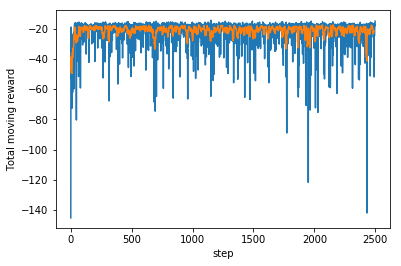

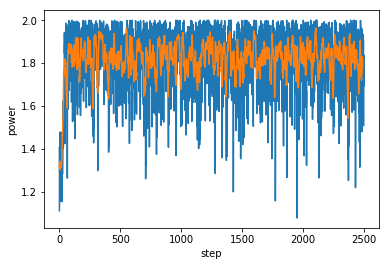

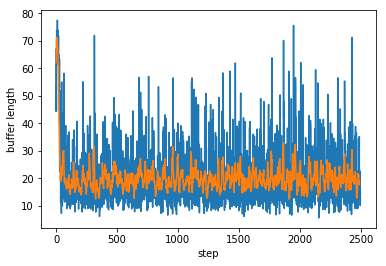

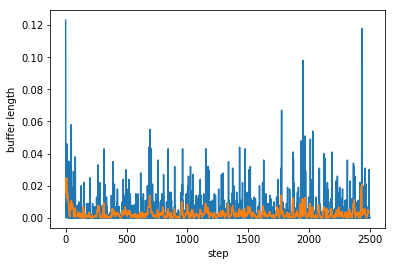

In [3]:
name = 't_10/test_1000_' + time.strftime("%b_%d_%Y_%H_%M_%S", time.localtime(time.time()))
a,b,c,d = plot_everything(res_rec, win=10)
np.savez(name, a,b,c,d)

In [1]:
cur_init_ds_ep = env.reset()
    
cur_r_ep = np.zeros(len(user_list))
cur_p_ep = np.zeros(len(user_list))
cur_n_ep = np.zeros(len(user_list))
cur_ts_ep = np.zeros(len(user_list))
cur_rs_ep = np.zeros(len(user_list))
cur_ps_ep = np.zeros(len(user_list))
cur_ds_ep = np.zeros(len(user_list))
cur_ch_ep = np.zeros(len(user_list))
    
for j in range(1000):
    # first try to transmit from current state
    [cur_r, done, cur_p, cur_n, cur_ts, cur_ps, cur_rs, cur_ds, cur_ch, cur_of] = env.step_transmit()
        
    cur_r_ep += cur_r
    cur_p_ep += cur_p
    cur_ts_ep += cur_ts
    cur_ps_ep += cur_ps
    cur_rs_ep += cur_rs
    cur_ds_ep += cur_ds
    cur_ch_ep += cur_ch
        
    print('%d:r:%f,p:%s,n:%s,tr:%s,pr:%s,rev:%s,dbuf:%s,ch:%s,ibuf:%s' % (j, cur_r, cur_p, cur_n, cur_ts, cur_ps, cur_rs, cur_ds, cur_ch, cur_init_ds_ep))
        
print('r:%f,p:%s,n:%s,tr:%s,rev:%s,dbuf:%s,ch:%s,ibuf:%s' % (cur_r_ep/MAX_EPISODE_LEN, cur_p_ep/MAX_EPISODE_LEN, cur_n_ep/MAX_EPISODE_LEN, cur_ts_ep/MAX_EPISODE_LEN, cur_rs_ep/MAX_EPISODE_LEN, cur_ds_ep/MAX_EPISODE_LEN, cur_ch_ep/MAX_EPISODE_LEN, cur_init_ds_ep))

NameError: name 'env' is not defined

In [3]:
graph = tf.get_default_graph()
inputs = graph.get_tensor_by_name("input_1"+":0")
scaled_out = graph.get_tensor_by_name("output_1"+":0")
print sess.run(scaled_out, feed_dict={inputs: [[7.22254768,2.3384,2.7784888e-05]]})

[[0.78826445 1.        ]]


In [2]:
res_rec = []
res_init_buf = []
# 3. start to explore for each episode
for i in range(MAX_EPISODE):
    
    cur_init_ds_ep = env.reset(3)
        
    res_init_buf.append(cur_init_ds_ep)
    
    cur_r_ep = np.zeros(len(user_list))
    cur_p_ep = np.zeros(len(user_list))
    cur_ts_ep = np.zeros(len(user_list))
    cur_ps_ep = np.zeros(len(user_list))
    cur_rs_ep = np.zeros(len(user_list))
    cur_ds_ep = np.zeros(len(user_list))
    cur_ch_ep = np.zeros(len(user_list))
    cur_of_ep = np.zeros(len(user_list))
    
    res_rec_tmp = []
    for j in range(MAX_EPISODE_LEN):
        
        # first try to transmit from current state
        [cur_r, done, cur_p, temp, cur_ts, cur_ps, cur_rs, cur_ds, cur_ch, cur_of] = env.step_transmit(False)
        
        res_rec_tmp.append([cur_r, done, cur_p, temp, cur_ts, cur_ps, cur_rs, cur_ds, cur_ch, cur_of])
        cur_r_ep += cur_r
        cur_p_ep += cur_p
        cur_ts_ep += cur_ts
        cur_ps_ep += cur_ps
        cur_rs_ep += cur_rs
        cur_ds_ep += cur_ds
        cur_ch_ep += cur_ch
        cur_of_ep += cur_of
        
        if done:
            res_rec.append(res_rec_tmp)
            print('%d:r:%.4f,p:%.4f,tr:%.4f,pr:%.4f,rev:%.4f,dbuf:%.4f,ch:%.8f,ibuf:%d' % (i, cur_r_ep/MAX_EPISODE_LEN, cur_p_ep/MAX_EPISODE_LEN, cur_ts_ep/MAX_EPISODE_LEN, cur_ps_ep/MAX_EPISODE_LEN, cur_rs_ep/MAX_EPISODE_LEN, cur_ds_ep/MAX_EPISODE_LEN, cur_ch_ep/MAX_EPISODE_LEN, cur_init_ds_ep[0]))
                
name = 'test_1000_' + str(time.asctime( time.localtime(time.time()) )) + '.npy'
np.save(name, [res_rec, res_init_buf])

0:r:-50.8910,p:1.4033,tr:1.4707,pr:1.3505,rev:2.9594,dbuf:72.5261,ch:0.00002568,ibuf:4
1:r:-57.9454,p:1.3913,tr:1.6529,pr:1.2218,rev:3.0360,dbuf:74.1439,ch:0.00002761,ibuf:30
2:r:-51.0844,p:1.1953,tr:1.5476,pr:1.2320,rev:2.8984,dbuf:73.1955,ch:0.00002990,ibuf:39
3:r:-18.2811,p:1.3469,tr:1.5860,pr:1.3673,rev:2.9762,dbuf:61.5868,ch:0.00002683,ibuf:35
4:r:-17.5547,p:1.2180,tr:1.7657,pr:1.2518,rev:3.0115,dbuf:55.9275,ch:0.00003238,ibuf:63
5:r:-55.6239,p:1.4116,tr:1.4240,pr:1.3390,rev:2.8791,dbuf:69.1011,ch:0.00002492,ibuf:48
6:r:-37.3900,p:1.2706,tr:1.3830,pr:1.5578,rev:3.0240,dbuf:59.5109,ch:0.00002915,ibuf:8
7:r:-32.6223,p:1.4738,tr:1.3452,pr:1.6902,rev:3.0674,dbuf:63.5657,ch:0.00002512,ibuf:71
8:r:-20.8140,p:1.2057,tr:1.4394,pr:1.5456,rev:3.0451,dbuf:49.6221,ch:0.00002902,ibuf:38
9:r:-19.3836,p:1.1973,tr:1.4459,pr:1.4838,rev:2.9358,dbuf:56.0717,ch:0.00002922,ibuf:86


In [3]:
from mec_env_var import *
from helper import *
import tensorflow as tf
import ipdb as pdb
import time

MAX_EPISODE = 50
MAX_EPISODE_LEN = 1000

NUM_T = 1
NUM_R = 1
SIGMA2 = 0.3e-9

config = {'state_dim':3, 'action_dim':2};
train_config = {'minibatch_size':64, 'actor_lr':0.0001, 'tau':0.001, 
                 'critic_lr':0.001, 'gamma':0.99, 'buffer_size':250000, 
                 'random_seed':1234}
user_config = [{'id':'1', 'rate':3, 'dis':100, 'action_bound':1, 
                'data_buf_size':100, 't_factor':0.9, 'penalty':1000}];

print user_config
# 0. initialize the session object
sess = tf.Session() 
saver = tf.train.import_meta_graph('model/my_test_model.meta')
sess.run(tf.global_variables_initializer())

saver.restore(sess, tf.train.latest_checkpoint('model/'))

graph = tf.get_default_graph()
    
# 1. include all user in the system according to the user_config
user_list = [];
for info in user_config:
    info.update(config)
    user_list.append(MecTermLD(sess, info, train_config))
    print 'test'

# 2. create the simulation env
env = MecSvrEnv(user_list, NUM_R, SIGMA2, MAX_EPISODE_LEN)
env.init_target_network()

res_rec = []
res_init_buf = []
# 3. start to explore for each episode
for i in range(MAX_EPISODE):
    
    cur_init_ds_ep = env.reset(3)
        
    res_init_buf.append(cur_init_ds_ep)
    
    cur_r_ep = np.zeros(len(user_list))
    cur_p_ep = np.zeros(len(user_list))
    cur_ts_ep = np.zeros(len(user_list))
    cur_ps_ep = np.zeros(len(user_list))
    cur_rs_ep = np.zeros(len(user_list))
    cur_ds_ep = np.zeros(len(user_list))
    cur_ch_ep = np.zeros(len(user_list))
    cur_of_ep = np.zeros(len(user_list))
    
    res_rec_tmp = []
    for j in range(MAX_EPISODE_LEN):
        
        # first try to transmit from current state
        [cur_r, done, cur_p, temp, cur_ts, cur_ps, cur_rs, cur_ds, cur_ch, cur_of] = env.step_transmit()
        
        res_rec_tmp.append([cur_r, done, cur_p, temp, cur_ts, cur_ps, cur_rs, cur_ds, cur_ch, cur_of])
        cur_r_ep += cur_r
        cur_p_ep += cur_p
        cur_ts_ep += cur_ts
        cur_ps_ep += cur_ps
        cur_rs_ep += cur_rs
        cur_ds_ep += cur_ds
        cur_ch_ep += cur_ch
        cur_of_ep += cur_of
        
        if done:
            res_rec.append(res_rec_tmp)
            print('%d:r:%.4f,p:%.4f,tr:%.4f,pr:%.4f,rev:%.4f,dbuf:%.4f,ch:%.8f,ibuf:%d' % (i, cur_r_ep/MAX_EPISODE_LEN, cur_p_ep/MAX_EPISODE_LEN, cur_ts_ep/MAX_EPISODE_LEN, cur_ps_ep/MAX_EPISODE_LEN, cur_rs_ep/MAX_EPISODE_LEN, cur_ds_ep/MAX_EPISODE_LEN, cur_ch_ep/MAX_EPISODE_LEN, cur_init_ds_ep[0]))
                
name = 'test_1000_' + str(time.asctime( time.localtime(time.time()) )) + '.npy'
np.save(name, [res_rec, res_init_buf])
sess.close()

[{'data_buf_size': 100, 'penalty': 1000, 'rate': 3, 'action_bound': 1, 'id': '1', 't_factor': 0.9, 'dis': 100}]
INFO:tensorflow:Restoring parameters from model/my_test_model
--Return--
None
> <ipython-input-3-a12846566f97>(30)<module>()
     29 graph = tf.get_default_graph()
---> 30 pdb.set_trace()
     31 

ipdb> graph
ipdb> graph.trainable_variables
*** AttributeError: 'Graph' object has no attribute 'trainable_variables'
ipdb> tf.trainable_variables()
[<tf.Variable 'fully_connected/weights:0' shape=(3, 400) dtype=float32_ref>, <tf.Variable 'fully_connected/BatchNorm/beta:0' shape=(400,) dtype=float32_ref>, <tf.Variable 'fully_connected_1/weights:0' shape=(3, 300) dtype=float32_ref>, <tf.Variable 'fully_connected_1/BatchNorm/beta:0' shape=(300,) dtype=float32_ref>, <tf.Variable 'fully_connected_2/weights:0' shape=(300, 2) dtype=float32_ref>, <tf.Variable 'fully_connected_2/biases:0' shape=(2,) dtype=float32_ref>, <tf.Variable 'fully_connected_3/weights:0' shape=(3, 400) dtype=float32

BdbQuit: 

In [9]:
sess = tf.Session() 
saver = tf.train.import_meta_graph('model/my_test_model.meta')
sess.run(tf.global_variables_initializer())

saver.restore(sess, tf.train.latest_checkpoint('model/'))

graph = tf.get_default_graph()
variable_names = [v.name for v in tf.trainable_variables()]
values = sess.run(variable_names)
print sess.run('fully_connected_2/weights:0')

INFO:tensorflow:Restoring parameters from model/my_test_model
[[0.1545126  0.15780352]
 [0.15616506 0.15971294]
 [0.06559879 0.09880391]
 [0.06487427 0.10064688]
 [0.15168335 0.16229852]
 [0.06257845 0.09748891]
 [0.06430701 0.09924787]
 [0.06548443 0.10012874]
 [0.15782878 0.15414344]
 [0.15429462 0.17596859]
 [0.05945097 0.0991616 ]
 [0.06383383 0.09632684]
 [0.06522399 0.10438306]
 [0.06095436 0.09916781]
 [0.06635379 0.0955418 ]
 [0.06379106 0.09433711]
 [0.06133086 0.09875894]
 [0.06503102 0.09639146]
 [0.15047684 0.17412661]
 [0.15663381 0.15740666]
 [0.17768952 0.15899988]
 [0.15730077 0.14491995]
 [0.05902164 0.10017106]
 [0.06845198 0.09686822]
 [0.15724926 0.14774598]
 [0.1529071  0.16426612]
 [0.1520101  0.15706535]
 [0.16091335 0.16260217]
 [0.15082897 0.16070077]
 [0.06310375 0.09398151]
 [0.06018374 0.10056869]
 [0.05968894 0.10066012]
 [0.15474424 0.16255529]
 [0.15111688 0.1622602 ]
 [0.0838669  0.18973866]
 [0.06870251 0.24295035]
 [0.06702217 0.10505467]
 [0.1529     

In [3]:
np.save('t_08/1', [1])